In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import date

from sklearn.metrics import roc_auc_score
import catboost as cb
from catboost import Pool
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
!pwd

/Users/user/Desktop/projects/employee_attrition


In [3]:
df = pd.read_excel(os.getcwd()+'/testA.xlsx')

In [4]:
df = df[['Employee_Name', 'Salary', 'Position', 'State', 'Zip', 'Date of birth',
       'Sex', 'Marital status', 'Citizen status', 'Date of Hire',
       'Term Reason', 'Employment Status', 'Department', 'RecruitmentSource',
       'Performance score', 'Engagement Survey', 'Employee satisfaction',
       'Special Projects Count', 'Days late, last 30', 'Absences']]

In [5]:
df = df.iloc[:311]

In [6]:
data = df.copy()

In [7]:
df.drop('Employee_Name', axis = 1, inplace = True)
df.head()

Salary                  Position State   Zip        Date of birth Sex  \
0   62506.0   Production Technician I    MA  1960  1983-10-07 00:00:00  M    
1  104437.0                   Sr. DBA    MA  2148  1975-05-05 00:00:00  M    
2   64955.0  Production Technician II    MA  1810             09/19/88   F   
3   64991.0   Production Technician I    MA  1886             09/27/88   F   
4   50825.0   Production Technician I    MA  2169  1989-08-09 00:00:00   F   

  Marital status Citizen status         Date of Hire        Term Reason  \
0         Single     US Citizen  2011-05-07 00:00:00  N/A-StillEmployed   
1        Married     US Citizen            3/30/2015      career change   
2        Married     US Citizen  2011-05-07 00:00:00              hours   
3        Married     US Citizen  2008-07-01 00:00:00  N/A-StillEmployed   
4       Divorced     US Citizen  2011-11-07 00:00:00   return to school   

        Employment Status         Department RecruitmentSource  \
0                  Active  Production                 LinkedIn   
1  Voluntarily Terminated              IT/IS            Indeed   
2  Voluntarily Terminated  Production                 LinkedIn   
3                  Active  Production                   Indeed   
4  Voluntarily Terminated  Production            Google Search   

  Performance score  Engagement Survey  Employee satisfaction  \
0           Exceeds               4.60                    5.0   
1       Fully Meets               4.96                    3.0   
2       Fully Meets               3.02                    3.0   
3       Fully Meets               4.84                    5.0   
4       Fully Meets               5.00                    4.0   

   Special Projects Count  Days late, last 30  Absences  
0                     0.0                 0.0       1.0  
1                     6.0                 0.0      17.0  
2                     0.0                 0.0       3.0  
3                     0.0                 0.0      15.0  
4                     0.0                 0.0       2.0

In [8]:
df.describe()

Salary  Engagement Survey  Employee satisfaction  \
count     311.000000         311.000000             311.000000   
mean    69020.684887           4.110000               3.890675   
std     25156.636930           0.789938               0.909241   
min     45046.000000           1.120000               1.000000   
25%     55501.500000           3.690000               3.000000   
50%     62810.000000           4.280000               4.000000   
75%     72036.000000           4.700000               5.000000   
max    250000.000000           5.000000               5.000000   

       Special Projects Count  Days late, last 30    Absences  
count              311.000000          311.000000  311.000000  
mean                 1.218650            0.414791   10.237942  
std                  2.349421            1.294519    5.852596  
min                  0.000000            0.000000    1.000000  
25%                  0.000000            0.000000    5.000000  
50%                  0.000000            0.000000   10.000000  
75%                  0.000000            0.000000   15.000000  
max                  8.000000            6.000000   20.000000

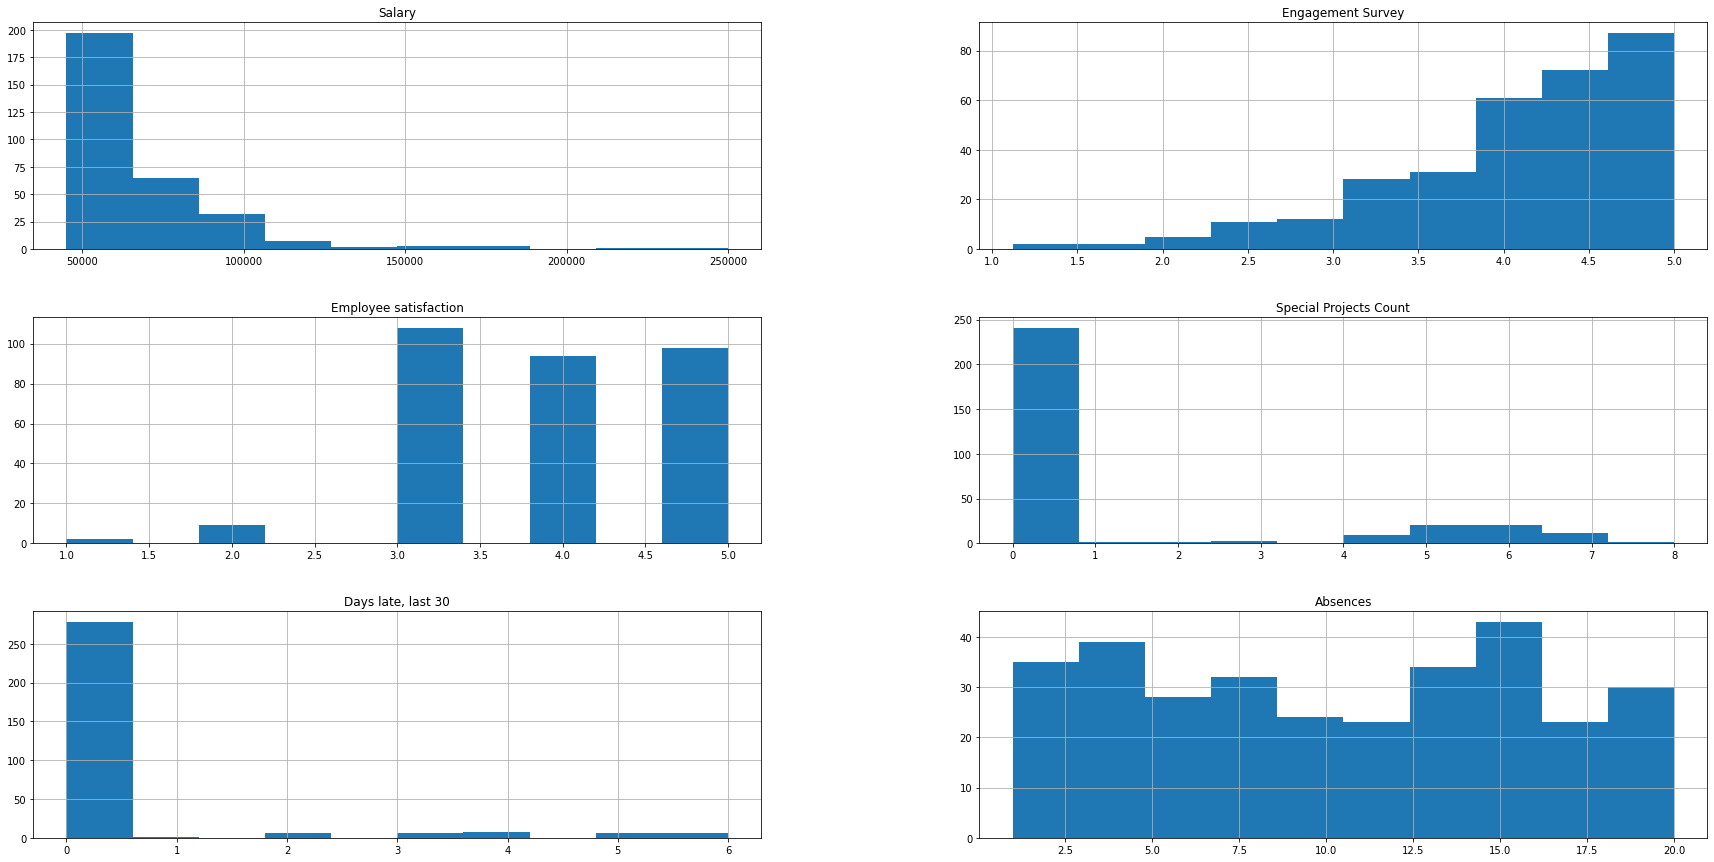

In [9]:
df[df.describe().columns].hist(figsize = (30,15))
plt.show()

In [10]:
df.isna().sum()

Salary                     0
Position                   0
State                      0
Zip                        0
Date of birth              0
Sex                        0
Marital status             0
Citizen status             0
Date of Hire               0
Term Reason               13
Employment Status         13
Department                 0
RecruitmentSource          0
Performance score          0
Engagement Survey          0
Employee satisfaction      0
Special Projects Count     0
Days late, last 30         0
Absences                   0
dtype: int64

### Creating age from date of birth

In [11]:
df['Date of birth']  = pd.to_datetime(df['Date of birth'])

In [12]:
today = date.today()
today

datetime.date(2021, 9, 1)

In [13]:
df['age'] = today.year - df['Date of birth'].dt.year

### Creating months at work form date of hire

In [14]:
df['Date of Hire'] = pd.to_datetime(df['Date of Hire'])

In [15]:
df['months_at_work'] = today.year*12+today.month - (df['Date of Hire'].dt.month+df['Date of Hire'].dt.year*12)

### Create 'month_of_hire'

In [16]:
df['month of hire'] = df['Date of Hire'].dt.month

### Transforming performance score to numerical

In [17]:
performance = {'Exceeds':4, 'Fully Meets': 3, 'Needs Improvement':2, 'PIP':1}

In [18]:
df['performance_numerical'] = df['Performance score'].apply(lambda x:performance[x])  

### EDA

In [19]:
df.dtypes

Salary                           float64
Position                          object
State                             object
Zip                               object
Date of birth             datetime64[ns]
Sex                               object
Marital status                    object
Citizen status                    object
Date of Hire              datetime64[ns]
Term Reason                       object
Employment Status                 object
Department                        object
RecruitmentSource                 object
Performance score                 object
Engagement Survey                float64
Employee satisfaction            float64
Special Projects Count           float64
Days late, last 30               float64
Absences                         float64
age                                int64
months_at_work                     int64
month of hire                      int64
performance_numerical              int64
dtype: object

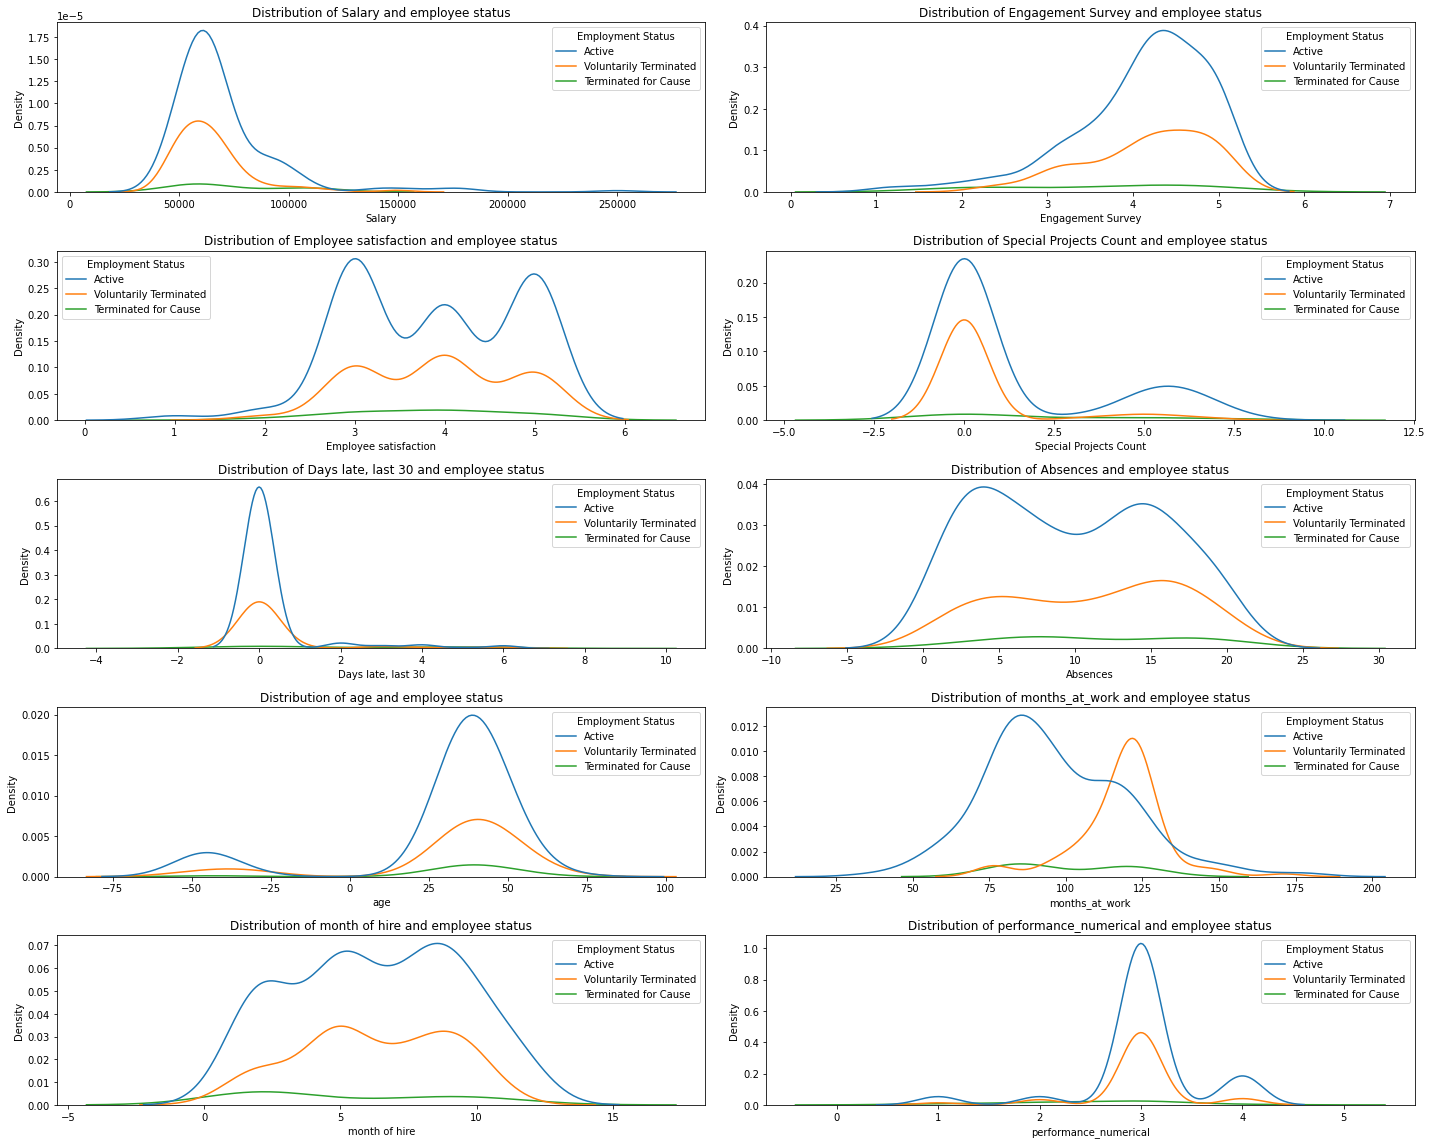

In [20]:
int_cols = df.select_dtypes(include = ['float64', 'int64'])


fig, axes = plt.subplots(figsize = (20,16), ncols = 2, nrows = 5)
cols = int_cols.columns


for i in range(5):
    for j in range(i, i+2):
        sns.kdeplot(ax = axes[i, j-i], data = df, x = cols[i+j], hue = 'Employment Status')
        axes[i, j-i].set_title(f'Distribution of {cols[i+j]} and employee status')
        
fig.tight_layout()
plt.show()

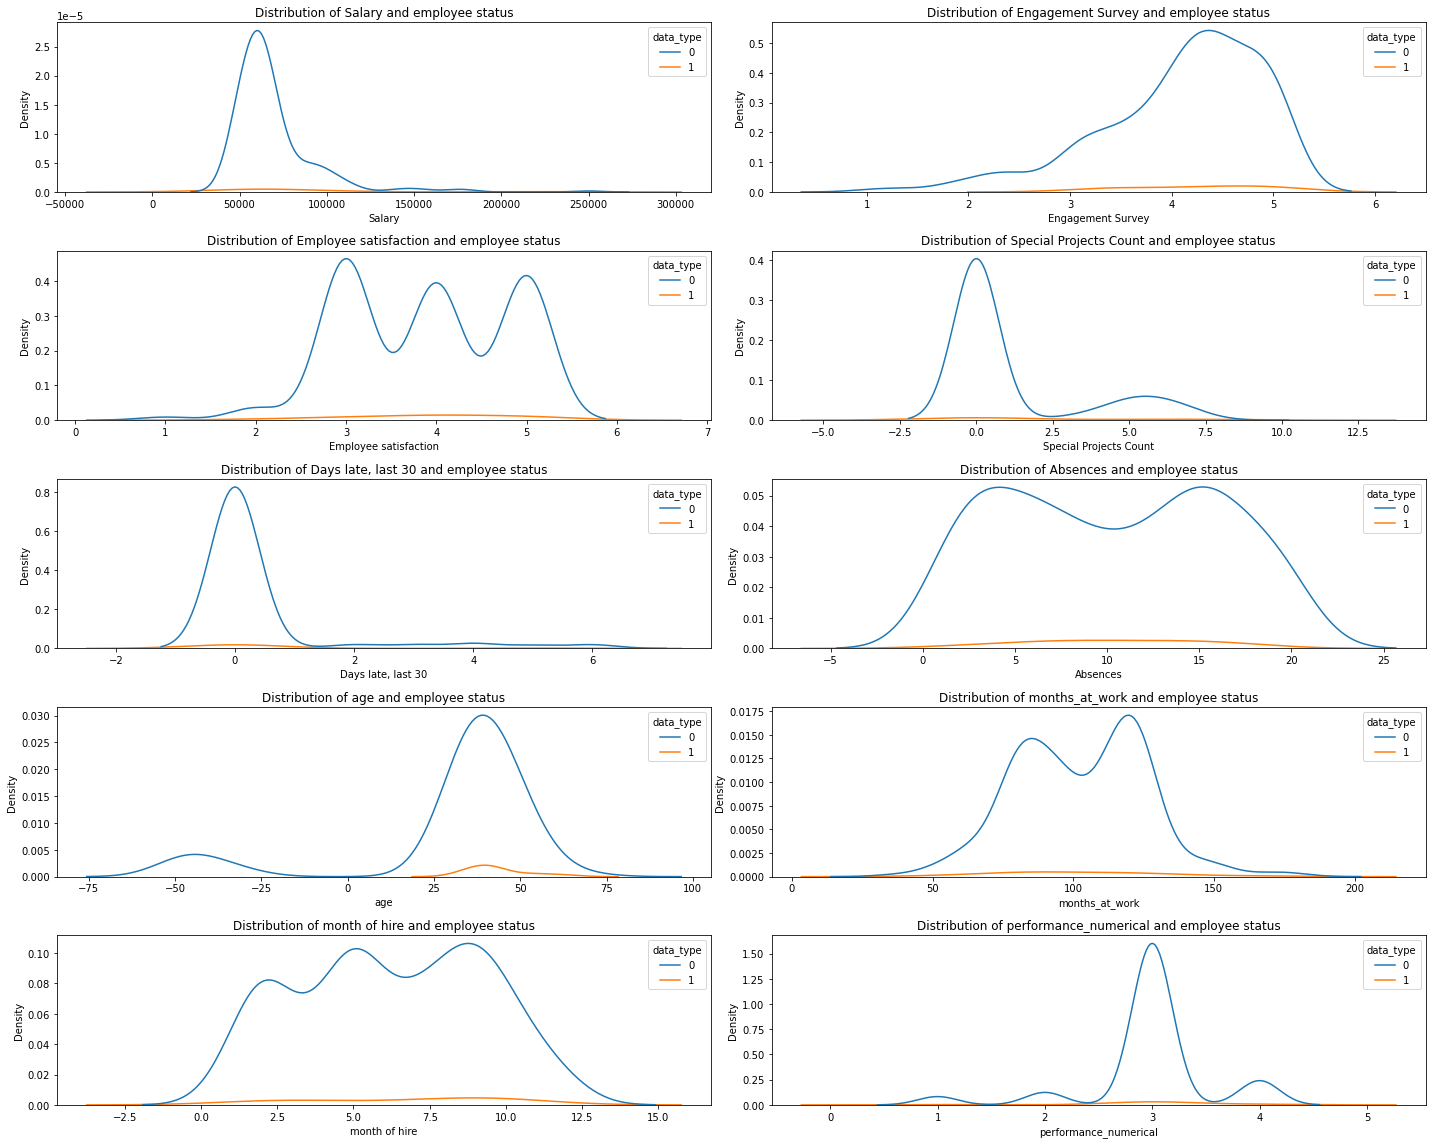

In [21]:
df['data_type'] = df['Employment Status'].isna().astype(int)

fig, axes = plt.subplots(figsize = (20,16), ncols = 2, nrows = 5)
cols = int_cols.columns


for i in range(5):
    for j in range(i, i+2):
        sns.kdeplot(ax = axes[i, j-i], data = df, x = cols[i+j], hue = 'data_type')
        axes[i, j-i].set_title(f'Distribution of {cols[i+j]} and employee status')
        
fig.tight_layout()
plt.show()

In [22]:
df.drop('data_type', axis= 1, inplace =True)

In [23]:
df.shape

(311, 23)

### Transform 'state'

In [24]:
df.select_dtypes(include=['object']).nunique()

Position              32
State                 28
Zip                  158
Sex                    2
Marital status         5
Citizen status         3
Term Reason           18
Employment Status      3
Department             6
RecruitmentSource      9
Performance score      4
dtype: int64

In [25]:
df.State.value_counts()[:10]

MA    276
CT      6
TX      3
VT      2
CA      1
IN      1
ND      1
OH      1
NY      1
MT      1
Name: State, dtype: int64

In [26]:
df['State']=np.where(df['State'] !='MA', 'notMA', df['State'])

### 'Salary' revisited

In [27]:
df['Salary_difference'] = df.apply(lambda x:x.Salary - df[df.Position == x.Position].Salary.median(), axis= 1)

In [28]:
df.Salary.corr(df['Salary_difference'])

0.2091729903634324

### Recruitment Source

In [29]:
df.RecruitmentSource.value_counts()

Indeed                     87
LinkedIn                   76
Google Search              49
Employee Referral          31
Diversity Job Fair         29
CareerBuilder              23
Website                    13
Other                       2
On-line Web application     1
Name: RecruitmentSource, dtype: int64

In [30]:
df = df[(df.RecruitmentSource!='On-line Web application')&(df.RecruitmentSource!='Other')]

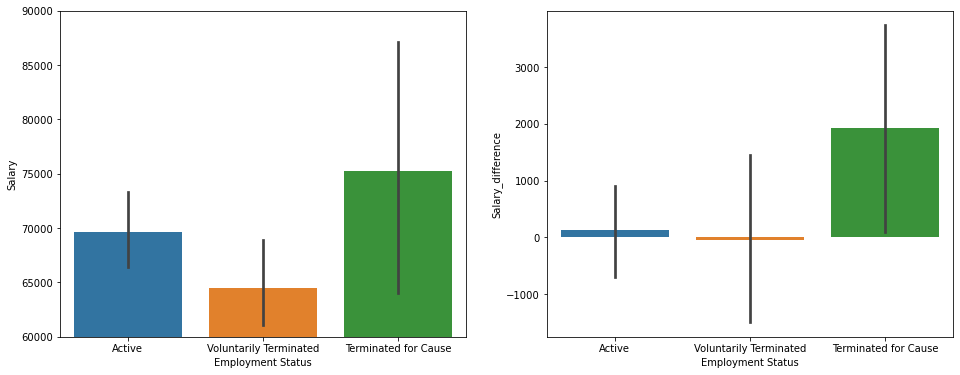

In [31]:
fig, axes = plt.subplots(figsize = (16, 6), ncols = 2, nrows = 1)
sns.barplot(ax = axes[0], data = df, x = 'Employment Status', y = 'Salary')
axes[0].set_ylim(60000, 90000)
sns.barplot(ax = axes[1], data = df, x = 'Employment Status', y = 'Salary_difference')
plt.show()

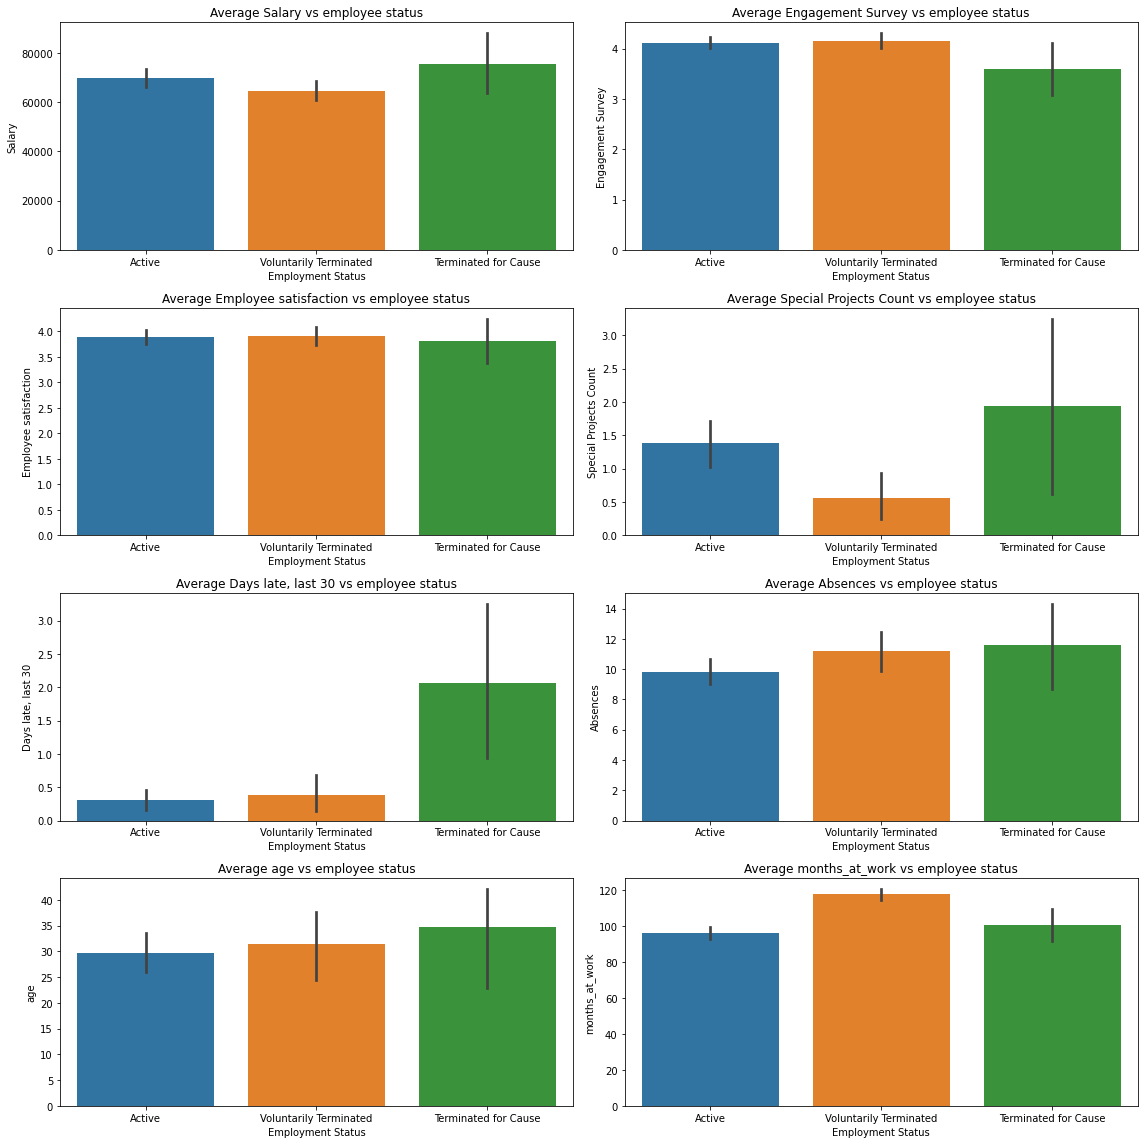

In [32]:
fig, axes = plt.subplots(figsize = (16,16), ncols = 2, nrows = 4)
cols = df.describe().columns

for i in range(4):
    for j in range(i, i+2):
        sns.barplot(ax = axes[i, j-i], data = df, x = 'Employment Status', y = cols[i+j])
        axes[i, j-i].set_title(f'Average {cols[i+j]} vs employee status')
        
fig.tight_layout()
plt.show()

In [33]:
pd.crosstab(df.Sex,df['Employment Status'])

Employment Status  Active  Terminated for Cause  Voluntarily Terminated
Sex                                                                    
F                     110                     9                      48
M                      89                     7                      32

In [34]:
from scipy import stats
stats.chi2_contingency(pd.crosstab(df.Sex,df['Employment Status']))

(0.519223042020544,
 0.7713511813341642,
 2,
 array([[112.65423729,   9.05762712,  45.28813559],
        [ 86.34576271,   6.94237288,  34.71186441]]))

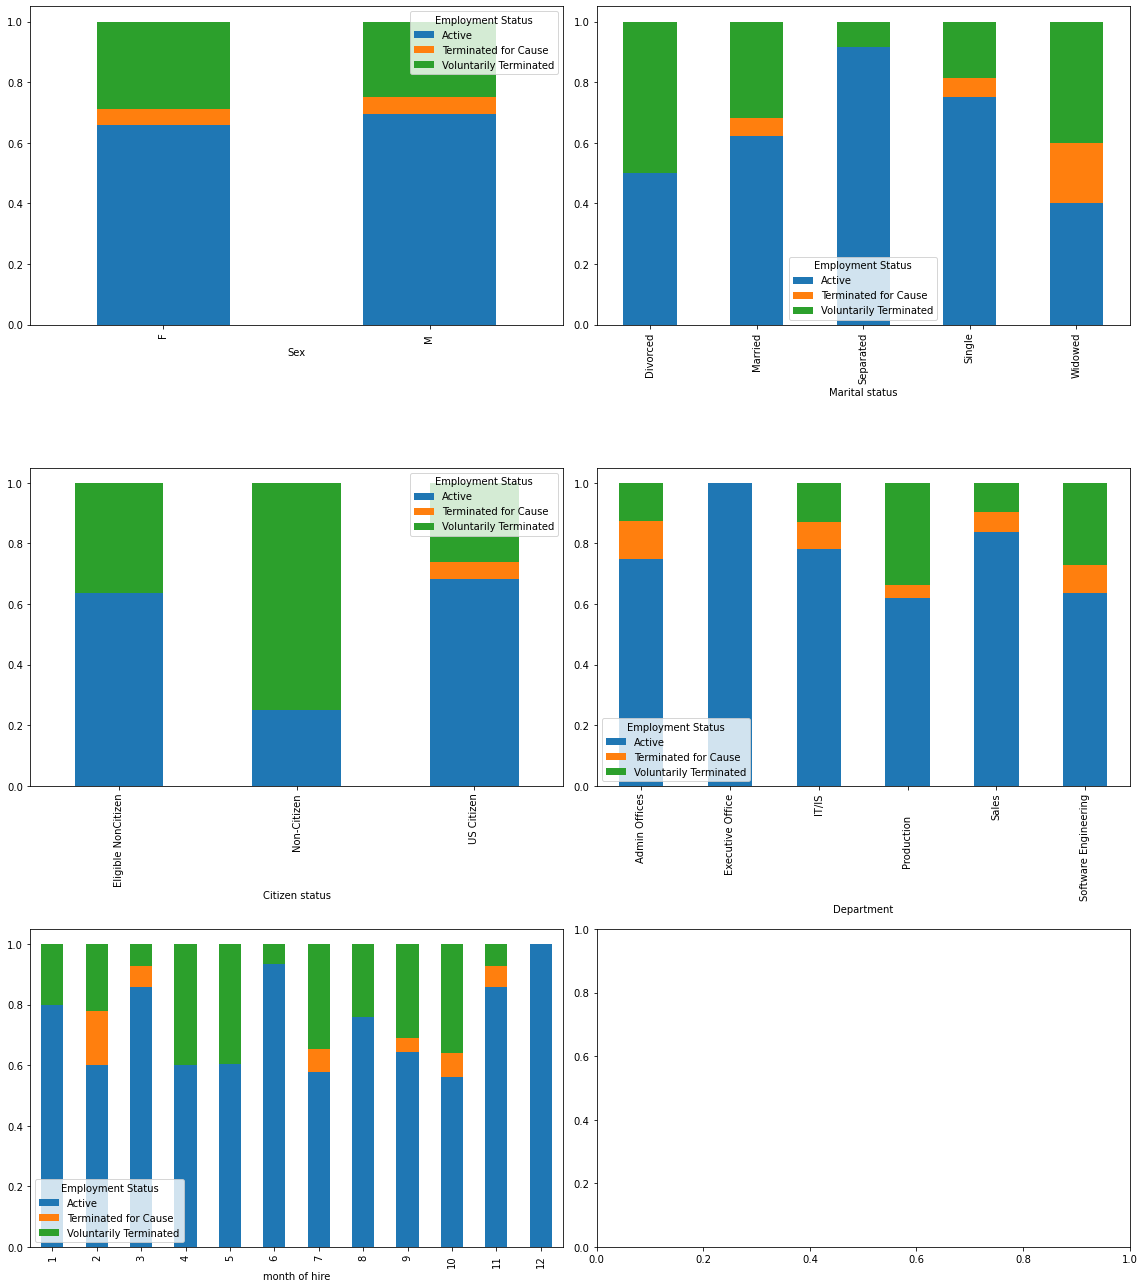

In [35]:
fig, axes = plt.subplots(figsize = (16, 18), nrows = 3, ncols = 2)

table=pd.crosstab(df.Sex,df['Employment Status'])
table.div(table.sum(1).astype(float), axis=0).plot(ax = axes[0,0], kind='bar', stacked=True)

table=pd.crosstab(df['Marital status'],df['Employment Status'])
table.div(table.sum(1).astype(float), axis=0).plot(ax = axes[0,1], kind='bar', stacked=True)

table=pd.crosstab(df['Citizen status'], df['Employment Status'])
table.div(table.sum(1).astype(float), axis=0).plot(ax = axes[1,0], kind='bar', stacked=True)

table=pd.crosstab(df['Department'],df['Employment Status'])
table.div(table.sum(1).astype(float), axis=0).plot(ax = axes[1,1], kind='bar', stacked=True)


table=pd.crosstab(df['month of hire'],df['Employment Status'])
table.div(table.sum(1).astype(float), axis=0).plot(ax = axes[2,0], kind='bar', stacked=True)
plt.tight_layout()
plt.show()

In [36]:
def zodiac_sign(date):
    month, day = date.month, date.day
    if month == 12:
        astro_sign = 'sagittarius' if (day < 22) else 'capricorn'
    elif month == 1:
        astro_sign = 'capricorn' if (day < 20) else 'aquarius'
    elif month == 2:
        astro_sign = 'aquarius' if (day < 19) else 'pisces'
    elif month == 3:
        astro_sign = 'pisces' if (day < 21) else 'aries'
    elif month == 4:
        astro_sign = 'aries' if (day < 20) else 'taurus'
    elif month == 5:
        astro_sign = 'taurus' if (day < 21) else 'gemini'
    elif month == 6:
        astro_sign = 'gemini' if (day < 21) else 'cancer'
    elif month == 7:
        astro_sign = 'cancer' if (day < 23) else 'leo'
    elif month == 8:
        astro_sign = 'leo' if (day < 23) else 'virgo'
    elif month == 9:
        astro_sign = 'virgo' if (day < 23) else 'libra'
    elif month == 10:
        astro_sign = 'libra' if (day < 23) else 'scorpio'
    elif month == 11:
        astro_sign = 'scorpio' if (day < 22) else 'sagittarius'
    return astro_sign

In [37]:
df['zodiac_sign'] = df['Date of birth'].apply(lambda x:zodiac_sign(x))

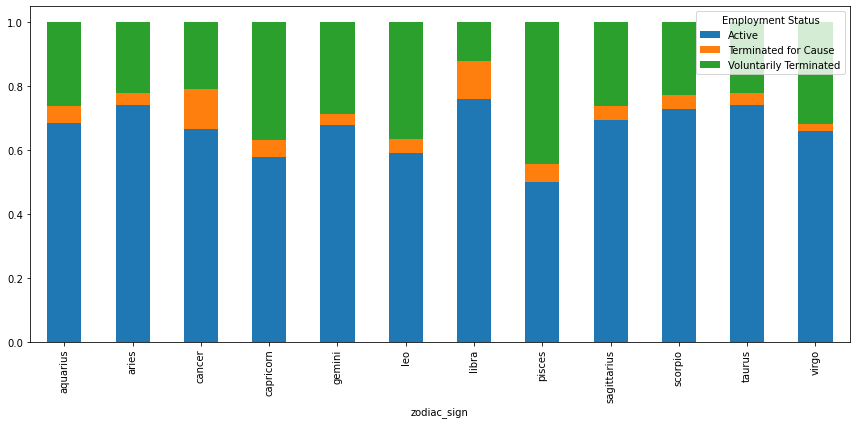

In [38]:
fig, ax = plt.subplots(figsize = (12,6),nrows= 1,ncols = 1)
table=pd.crosstab(df['zodiac_sign'],df['Employment Status'])
table.div(table.sum(1).astype(float), axis=0).plot(ax = ax,kind='bar', stacked=True)
plt.tight_layout()
plt.show()

In [39]:
stats.chi2_contingency(pd.crosstab(df['zodiac_sign'],df['Employment Status']))

(14.30771636105657,
 0.8901988630679367,
 22,
 array([[12.81694915,  1.03050847,  5.15254237],
        [18.21355932,  1.46440678,  7.3220339 ],
        [16.18983051,  1.30169492,  6.50847458],
        [12.81694915,  1.03050847,  5.15254237],
        [18.88813559,  1.51864407,  7.59322034],
        [14.84067797,  1.19322034,  5.96610169],
        [16.86440678,  1.3559322 ,  6.77966102],
        [12.14237288,  0.97627119,  4.88135593],
        [15.51525424,  1.24745763,  6.23728814],
        [14.84067797,  1.19322034,  5.96610169],
        [18.21355932,  1.46440678,  7.3220339 ],
        [27.65762712,  2.22372881, 11.11864407]]))

In [40]:
df.head()

Salary                  Position State   Zip Date of birth Sex  \
0   62506.0   Production Technician I    MA  1960    1983-10-07  M    
1  104437.0                   Sr. DBA    MA  2148    1975-05-05  M    
2   64955.0  Production Technician II    MA  1810    1988-09-19   F   
3   64991.0   Production Technician I    MA  1886    1988-09-27   F   
4   50825.0   Production Technician I    MA  2169    1989-08-09   F   

  Marital status Citizen status Date of Hire        Term Reason  ...  \
0         Single     US Citizen   2011-05-07  N/A-StillEmployed  ...   
1        Married     US Citizen   2015-03-30      career change  ...   
2        Married     US Citizen   2011-05-07              hours  ...   
3        Married     US Citizen   2008-07-01  N/A-StillEmployed  ...   
4       Divorced     US Citizen   2011-11-07   return to school  ...   

  Employee satisfaction Special Projects Count Days late, last 30 Absences  \
0                   5.0                    0.0                0.0      1.0   
1                   3.0                    6.0                0.0     17.0   
2                   3.0                    0.0                0.0      3.0   
3                   5.0                    0.0                0.0     15.0   
4                   4.0                    0.0                0.0      2.0   

   age  months_at_work  month of hire  performance_numerical  \
0   38             124              5                      4   
1   46              78              3                      3   
2   33             124              5                      3   
3   33             158              7                      3   
4   32             118             11                      3   

   Salary_difference  zodiac_sign  
0             7081.0        libra  
1             2203.0       taurus  
2              -40.0        virgo  
3             9566.0        libra  
4            -4600.0          leo  

[5 rows x 25 columns]

In [41]:
df.columns

Index(['Salary', 'Position', 'State', 'Zip', 'Date of birth', 'Sex',
       'Marital status', 'Citizen status', 'Date of Hire', 'Term Reason',
       'Employment Status', 'Department', 'RecruitmentSource',
       'Performance score', 'Engagement Survey', 'Employee satisfaction',
       'Special Projects Count', 'Days late, last 30', 'Absences', 'age',
       'months_at_work', 'month of hire', 'performance_numerical',
       'Salary_difference', 'zodiac_sign'],
      dtype='object')

In [42]:
df.drop(columns = ['Position', 'Zip', 'Date of birth', 'Date of Hire', 'Term Reason', 'Performance score'], axis = 1, inplace = True)

In [43]:
df.columns

Index(['Salary', 'State', 'Sex', 'Marital status', 'Citizen status',
       'Employment Status', 'Department', 'RecruitmentSource',
       'Engagement Survey', 'Employee satisfaction', 'Special Projects Count',
       'Days late, last 30', 'Absences', 'age', 'months_at_work',
       'month of hire', 'performance_numerical', 'Salary_difference',
       'zodiac_sign'],
      dtype='object')

In [44]:
df['Employment Status'].value_counts()/len(df)*100

Active                    64.610390
Voluntarily Terminated    25.974026
Terminated for Cause       5.194805
Name: Employment Status, dtype: float64

In [45]:
df_three_cat = df.copy()

In [46]:
df['Employment Status']=np.where(df['Employment Status'] =='Voluntarily Terminated', 'Inactive', df['Employment Status'])
df['Employment Status']=np.where(df['Employment Status'] =='Terminated for Cause', 'Inactive', df['Employment Status'])

In [47]:
df.head()

Salary State Sex Marital status Citizen status Employment Status  \
0   62506.0    MA  M          Single     US Citizen            Active   
1  104437.0    MA  M         Married     US Citizen          Inactive   
2   64955.0    MA   F        Married     US Citizen          Inactive   
3   64991.0    MA   F        Married     US Citizen            Active   
4   50825.0    MA   F       Divorced     US Citizen          Inactive   

          Department RecruitmentSource  Engagement Survey  \
0  Production                 LinkedIn               4.60   
1              IT/IS            Indeed               4.96   
2  Production                 LinkedIn               3.02   
3  Production                   Indeed               4.84   
4  Production            Google Search               5.00   

   Employee satisfaction  Special Projects Count  Days late, last 30  \
0                    5.0                     0.0                 0.0   
1                    3.0                     6.0                 0.0   
2                    3.0                     0.0                 0.0   
3                    5.0                     0.0                 0.0   
4                    4.0                     0.0                 0.0   

   Absences  age  months_at_work  month of hire  performance_numerical  \
0       1.0   38             124              5                      4   
1      17.0   46              78              3                      3   
2       3.0   33             124              5                      3   
3      15.0   33             158              7                      3   
4       2.0   32             118             11                      3   

   Salary_difference zodiac_sign  
0             7081.0       libra  
1             2203.0      taurus  
2              -40.0       virgo  
3             9566.0       libra  
4            -4600.0         leo

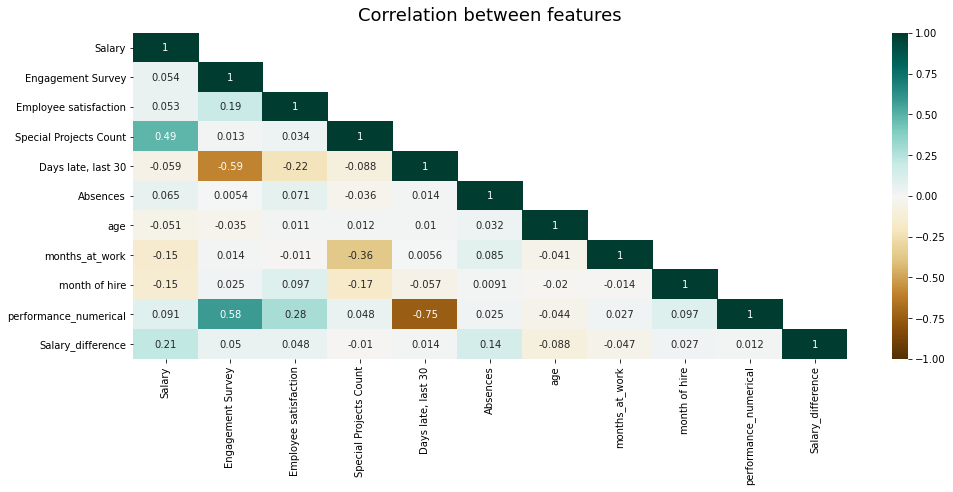

In [48]:
plt.figure(figsize = (16,6))

mask = np.triu(np.ones_like(df.iloc[:-13,:].corr(), dtype=bool), +1)
heatmap = sns.heatmap(df.iloc[:-13,:].corr(), vmin = -1, vmax = 1, mask = mask, annot = True, cmap = 'BrBG')

heatmap.set_title('Correlation between features', fontsize = 18, pad = 12)
plt.show()

In [50]:
df.columns

Index(['Salary', 'State', 'Sex', 'Marital status', 'Citizen status',
       'Employment Status', 'Department', 'RecruitmentSource',
       'Engagement Survey', 'Employee satisfaction', 'Special Projects Count',
       'Days late, last 30', 'Absences', 'age', 'months_at_work',
       'month of hire', 'performance_numerical', 'Salary_difference',
       'zodiac_sign'],
      dtype='object')

<AxesSubplot:xlabel='months_at_work', ylabel='Density'>

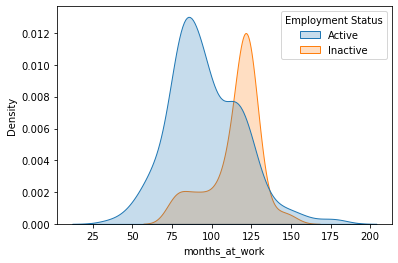

In [51]:
sns.kdeplot(data = df, x = 'months_at_work', hue='Employment Status', fill=True)

<AxesSubplot:xlabel='Absences', ylabel='Density'>

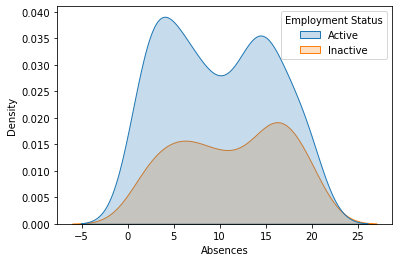

In [52]:
sns.kdeplot(data = df, x = 'Absences', hue='Employment Status', fill=True)

In [53]:
df_cat = df.copy()

In [54]:
df_cat.columns

Index(['Salary', 'State', 'Sex', 'Marital status', 'Citizen status',
       'Employment Status', 'Department', 'RecruitmentSource',
       'Engagement Survey', 'Employee satisfaction', 'Special Projects Count',
       'Days late, last 30', 'Absences', 'age', 'months_at_work',
       'month of hire', 'performance_numerical', 'Salary_difference',
       'zodiac_sign'],
      dtype='object')

In [55]:
cat_cols = df.select_dtypes(include = ['object']).columns
for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes+1

In [56]:
train_X, test_X, train_y, test_y = train_test_split(df_cat.iloc[:-13,:].drop(columns = 'Employment Status', axis = 1),\
                                                df_cat.iloc[:-13,5],
                                                random_state=10, test_size=0.20)

In [57]:
test = df_cat.iloc[:-14:-1,:].drop(columns = 'Employment Status', axis = 1)
test = test.sort_index()

In [58]:
cat_cols = train_X.select_dtypes(include = ['object']).columns
cat_cols_idx = []

for col in cat_cols:
    cat_cols_idx.append(train_X.columns.get_loc(col))

In [59]:
print(train_X.shape, train_y.shape)

(236, 18) (236,)


In [60]:
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}

cbm = cb.CatBoostClassifier()
cb_model = GridSearchCV(cbm, params, scoring="roc_auc", cv = 3)
cb_model.fit(train_X, train_y, cat_features = cat_cols_idx)

0:	learn: 0.6802273	total: 52.7ms	remaining: 15.8s
1:	learn: 0.6617646	total: 55.3ms	remaining: 8.24s
2:	learn: 0.6489726	total: 57.3ms	remaining: 5.67s
3:	learn: 0.6343036	total: 59.4ms	remaining: 4.39s
4:	learn: 0.6264102	total: 61.1ms	remaining: 3.61s
5:	learn: 0.6162141	total: 62.9ms	remaining: 3.08s
6:	learn: 0.6066106	total: 64.8ms	remaining: 2.71s
7:	learn: 0.5955020	total: 66.5ms	remaining: 2.43s
8:	learn: 0.5890742	total: 68.3ms	remaining: 2.21s
9:	learn: 0.5792864	total: 69.9ms	remaining: 2.03s
10:	learn: 0.5777086	total: 70.5ms	remaining: 1.85s
11:	learn: 0.5625095	total: 72.2ms	remaining: 1.73s
12:	learn: 0.5590613	total: 73.7ms	remaining: 1.63s
13:	learn: 0.5525557	total: 75.5ms	remaining: 1.54s
14:	learn: 0.5462697	total: 76.9ms	remaining: 1.46s
15:	learn: 0.5413364	total: 78.4ms	remaining: 1.39s
16:	learn: 0.5362190	total: 80.2ms	remaining: 1.33s
17:	learn: 0.5323026	total: 81ms	remaining: 1.27s
18:	learn: 0.5289812	total: 82.6ms	remaining: 1.22s
19:	learn: 0.5228023	tot

171:	learn: 0.2342929	total: 358ms	remaining: 267ms
172:	learn: 0.2332807	total: 360ms	remaining: 264ms
173:	learn: 0.2324166	total: 362ms	remaining: 262ms
174:	learn: 0.2315786	total: 364ms	remaining: 260ms
175:	learn: 0.2309141	total: 365ms	remaining: 257ms
176:	learn: 0.2299038	total: 367ms	remaining: 255ms
177:	learn: 0.2288524	total: 369ms	remaining: 253ms
178:	learn: 0.2284161	total: 371ms	remaining: 251ms
179:	learn: 0.2275872	total: 373ms	remaining: 248ms
180:	learn: 0.2273302	total: 374ms	remaining: 246ms
181:	learn: 0.2270686	total: 377ms	remaining: 244ms
182:	learn: 0.2263924	total: 378ms	remaining: 242ms
183:	learn: 0.2259079	total: 380ms	remaining: 240ms
184:	learn: 0.2256882	total: 381ms	remaining: 237ms
185:	learn: 0.2248920	total: 383ms	remaining: 235ms
186:	learn: 0.2245515	total: 386ms	remaining: 233ms
187:	learn: 0.2237239	total: 389ms	remaining: 232ms
188:	learn: 0.2228623	total: 391ms	remaining: 230ms
189:	learn: 0.2221293	total: 393ms	remaining: 228ms
190:	learn: 

116:	learn: 0.3092999	total: 155ms	remaining: 243ms
117:	learn: 0.3084362	total: 157ms	remaining: 242ms
118:	learn: 0.3062603	total: 158ms	remaining: 240ms
119:	learn: 0.3045915	total: 159ms	remaining: 239ms
120:	learn: 0.3037064	total: 161ms	remaining: 238ms
121:	learn: 0.3033545	total: 162ms	remaining: 236ms
122:	learn: 0.3030425	total: 163ms	remaining: 235ms
123:	learn: 0.3027223	total: 165ms	remaining: 234ms
124:	learn: 0.3018309	total: 166ms	remaining: 233ms
125:	learn: 0.3006900	total: 168ms	remaining: 232ms
126:	learn: 0.3002168	total: 169ms	remaining: 230ms
127:	learn: 0.2984519	total: 171ms	remaining: 229ms
128:	learn: 0.2973959	total: 172ms	remaining: 228ms
129:	learn: 0.2961040	total: 173ms	remaining: 226ms
130:	learn: 0.2953218	total: 175ms	remaining: 225ms
131:	learn: 0.2951762	total: 176ms	remaining: 224ms
132:	learn: 0.2943119	total: 177ms	remaining: 222ms
133:	learn: 0.2933219	total: 178ms	remaining: 221ms
134:	learn: 0.2916664	total: 180ms	remaining: 220ms
135:	learn: 

0:	learn: 0.6766740	total: 1.42ms	remaining: 425ms
1:	learn: 0.6642407	total: 3.02ms	remaining: 450ms
2:	learn: 0.6488786	total: 4.5ms	remaining: 445ms
3:	learn: 0.6448016	total: 6.03ms	remaining: 446ms
4:	learn: 0.6304590	total: 7.58ms	remaining: 447ms
5:	learn: 0.6222687	total: 8.98ms	remaining: 440ms
6:	learn: 0.6179062	total: 9.65ms	remaining: 404ms
7:	learn: 0.6145121	total: 10.3ms	remaining: 375ms
8:	learn: 0.6060211	total: 11.3ms	remaining: 366ms
9:	learn: 0.5975819	total: 12.9ms	remaining: 374ms
10:	learn: 0.5865209	total: 14.4ms	remaining: 378ms
11:	learn: 0.5778545	total: 15.7ms	remaining: 378ms
12:	learn: 0.5702711	total: 17.1ms	remaining: 376ms
13:	learn: 0.5689974	total: 17.7ms	remaining: 361ms
14:	learn: 0.5609527	total: 18.7ms	remaining: 355ms
15:	learn: 0.5595592	total: 19.3ms	remaining: 342ms
16:	learn: 0.5523476	total: 20.9ms	remaining: 347ms
17:	learn: 0.5463441	total: 22.3ms	remaining: 350ms
18:	learn: 0.5414435	total: 23.5ms	remaining: 347ms
19:	learn: 0.5303720	to

219:	learn: 0.1655823	total: 299ms	remaining: 109ms
220:	learn: 0.1639337	total: 301ms	remaining: 108ms
221:	learn: 0.1634472	total: 303ms	remaining: 107ms
222:	learn: 0.1616780	total: 305ms	remaining: 105ms
223:	learn: 0.1609211	total: 308ms	remaining: 104ms
224:	learn: 0.1604562	total: 310ms	remaining: 103ms
225:	learn: 0.1595101	total: 312ms	remaining: 102ms
226:	learn: 0.1591999	total: 314ms	remaining: 101ms
227:	learn: 0.1585499	total: 316ms	remaining: 99.8ms
228:	learn: 0.1558642	total: 318ms	remaining: 98.6ms
229:	learn: 0.1555306	total: 320ms	remaining: 97.4ms
230:	learn: 0.1549079	total: 322ms	remaining: 96.2ms
231:	learn: 0.1536910	total: 324ms	remaining: 95ms
232:	learn: 0.1530985	total: 326ms	remaining: 93.7ms
233:	learn: 0.1526530	total: 328ms	remaining: 92.4ms
234:	learn: 0.1519096	total: 330ms	remaining: 91.2ms
235:	learn: 0.1514562	total: 331ms	remaining: 89.9ms
236:	learn: 0.1511546	total: 333ms	remaining: 88.6ms
237:	learn: 0.1500354	total: 335ms	remaining: 87.4ms
238

109:	learn: 0.0866620	total: 216ms	remaining: 373ms
110:	learn: 0.0852564	total: 218ms	remaining: 371ms
111:	learn: 0.0841499	total: 220ms	remaining: 369ms
112:	learn: 0.0826821	total: 222ms	remaining: 367ms
113:	learn: 0.0821489	total: 224ms	remaining: 365ms
114:	learn: 0.0812006	total: 225ms	remaining: 362ms
115:	learn: 0.0806000	total: 227ms	remaining: 360ms
116:	learn: 0.0788469	total: 228ms	remaining: 357ms
117:	learn: 0.0760255	total: 230ms	remaining: 355ms
118:	learn: 0.0743249	total: 232ms	remaining: 353ms
119:	learn: 0.0736933	total: 234ms	remaining: 351ms
120:	learn: 0.0728761	total: 236ms	remaining: 348ms
121:	learn: 0.0726815	total: 237ms	remaining: 346ms
122:	learn: 0.0725251	total: 239ms	remaining: 344ms
123:	learn: 0.0715582	total: 241ms	remaining: 342ms
124:	learn: 0.0704795	total: 243ms	remaining: 340ms
125:	learn: 0.0691549	total: 244ms	remaining: 337ms
126:	learn: 0.0683943	total: 246ms	remaining: 335ms
127:	learn: 0.0678575	total: 248ms	remaining: 333ms
128:	learn: 

0:	learn: 0.6575126	total: 1.67ms	remaining: 498ms
1:	learn: 0.6224881	total: 3.33ms	remaining: 496ms
2:	learn: 0.5996152	total: 4.91ms	remaining: 486ms
3:	learn: 0.5614326	total: 6.7ms	remaining: 496ms
4:	learn: 0.5322398	total: 8.4ms	remaining: 496ms
5:	learn: 0.5170384	total: 10.1ms	remaining: 497ms
6:	learn: 0.4983526	total: 11.8ms	remaining: 494ms
7:	learn: 0.4923756	total: 14ms	remaining: 510ms
8:	learn: 0.4782888	total: 16.1ms	remaining: 520ms
9:	learn: 0.4630017	total: 18.3ms	remaining: 530ms
10:	learn: 0.4534638	total: 20.4ms	remaining: 535ms
11:	learn: 0.4442620	total: 22.1ms	remaining: 530ms
12:	learn: 0.4358049	total: 23.7ms	remaining: 524ms
13:	learn: 0.4237929	total: 25.7ms	remaining: 524ms
14:	learn: 0.4167198	total: 27.3ms	remaining: 519ms
15:	learn: 0.4070642	total: 28.9ms	remaining: 514ms
16:	learn: 0.3944012	total: 30.7ms	remaining: 511ms
17:	learn: 0.3833004	total: 32.5ms	remaining: 510ms
18:	learn: 0.3758793	total: 34.3ms	remaining: 507ms
19:	learn: 0.3693756	total

171:	learn: 0.0504983	total: 267ms	remaining: 199ms
172:	learn: 0.0499210	total: 269ms	remaining: 197ms
173:	learn: 0.0496527	total: 270ms	remaining: 195ms
174:	learn: 0.0488961	total: 271ms	remaining: 194ms
175:	learn: 0.0483279	total: 273ms	remaining: 192ms
176:	learn: 0.0473750	total: 275ms	remaining: 191ms
177:	learn: 0.0460019	total: 276ms	remaining: 189ms
178:	learn: 0.0454714	total: 277ms	remaining: 187ms
179:	learn: 0.0452112	total: 279ms	remaining: 186ms
180:	learn: 0.0447529	total: 280ms	remaining: 184ms
181:	learn: 0.0444429	total: 281ms	remaining: 182ms
182:	learn: 0.0443555	total: 283ms	remaining: 181ms
183:	learn: 0.0441595	total: 284ms	remaining: 179ms
184:	learn: 0.0437048	total: 286ms	remaining: 178ms
185:	learn: 0.0431945	total: 287ms	remaining: 176ms
186:	learn: 0.0426008	total: 288ms	remaining: 174ms
187:	learn: 0.0418562	total: 290ms	remaining: 173ms
188:	learn: 0.0414573	total: 292ms	remaining: 171ms
189:	learn: 0.0411029	total: 293ms	remaining: 170ms
190:	learn: 

69:	learn: 0.1532831	total: 95ms	remaining: 312ms
70:	learn: 0.1487179	total: 96.4ms	remaining: 311ms
71:	learn: 0.1463439	total: 97.8ms	remaining: 310ms
72:	learn: 0.1431624	total: 99.1ms	remaining: 308ms
73:	learn: 0.1410836	total: 100ms	remaining: 307ms
74:	learn: 0.1393888	total: 102ms	remaining: 305ms
75:	learn: 0.1372241	total: 103ms	remaining: 303ms
76:	learn: 0.1334590	total: 104ms	remaining: 302ms
77:	learn: 0.1316112	total: 106ms	remaining: 301ms
78:	learn: 0.1268224	total: 107ms	remaining: 299ms
79:	learn: 0.1246369	total: 108ms	remaining: 298ms
80:	learn: 0.1220389	total: 110ms	remaining: 297ms
81:	learn: 0.1207324	total: 111ms	remaining: 296ms
82:	learn: 0.1168902	total: 113ms	remaining: 295ms
83:	learn: 0.1157024	total: 114ms	remaining: 294ms
84:	learn: 0.1132471	total: 116ms	remaining: 293ms
85:	learn: 0.1109619	total: 117ms	remaining: 291ms
86:	learn: 0.1098388	total: 119ms	remaining: 290ms
87:	learn: 0.1064737	total: 120ms	remaining: 289ms
88:	learn: 0.1045655	total: 1

240:	learn: 0.0210761	total: 358ms	remaining: 87.6ms
241:	learn: 0.0209372	total: 360ms	remaining: 86.2ms
242:	learn: 0.0208957	total: 361ms	remaining: 84.7ms
243:	learn: 0.0206609	total: 363ms	remaining: 83.3ms
244:	learn: 0.0204637	total: 365ms	remaining: 81.9ms
245:	learn: 0.0202743	total: 367ms	remaining: 80.5ms
246:	learn: 0.0201370	total: 369ms	remaining: 79.1ms
247:	learn: 0.0200734	total: 370ms	remaining: 77.6ms
248:	learn: 0.0200086	total: 372ms	remaining: 76.2ms
249:	learn: 0.0199136	total: 374ms	remaining: 74.8ms
250:	learn: 0.0196940	total: 376ms	remaining: 73.4ms
251:	learn: 0.0196236	total: 378ms	remaining: 71.9ms
252:	learn: 0.0195443	total: 379ms	remaining: 70.5ms
253:	learn: 0.0191870	total: 381ms	remaining: 69ms
254:	learn: 0.0191130	total: 383ms	remaining: 67.6ms
255:	learn: 0.0189258	total: 385ms	remaining: 66.1ms
256:	learn: 0.0188779	total: 387ms	remaining: 64.7ms
257:	learn: 0.0188041	total: 388ms	remaining: 63.2ms
258:	learn: 0.0187677	total: 390ms	remaining: 61

113:	learn: 0.0415636	total: 235ms	remaining: 383ms
114:	learn: 0.0412324	total: 236ms	remaining: 380ms
115:	learn: 0.0405058	total: 238ms	remaining: 378ms
116:	learn: 0.0395331	total: 240ms	remaining: 375ms
117:	learn: 0.0392788	total: 242ms	remaining: 373ms
118:	learn: 0.0387671	total: 243ms	remaining: 370ms
119:	learn: 0.0381681	total: 245ms	remaining: 368ms
120:	learn: 0.0376394	total: 247ms	remaining: 365ms
121:	learn: 0.0373809	total: 248ms	remaining: 362ms
122:	learn: 0.0368634	total: 250ms	remaining: 360ms
123:	learn: 0.0360342	total: 251ms	remaining: 357ms
124:	learn: 0.0352124	total: 253ms	remaining: 354ms
125:	learn: 0.0345936	total: 256ms	remaining: 353ms
126:	learn: 0.0335400	total: 258ms	remaining: 352ms
127:	learn: 0.0332951	total: 260ms	remaining: 349ms
128:	learn: 0.0330277	total: 262ms	remaining: 347ms
129:	learn: 0.0328113	total: 264ms	remaining: 345ms
130:	learn: 0.0321085	total: 265ms	remaining: 342ms
131:	learn: 0.0307655	total: 268ms	remaining: 341ms
132:	learn: 

284:	learn: 0.0071488	total: 608ms	remaining: 32ms
285:	learn: 0.0071246	total: 612ms	remaining: 29.9ms
286:	learn: 0.0071105	total: 614ms	remaining: 27.8ms
287:	learn: 0.0070626	total: 618ms	remaining: 25.7ms
288:	learn: 0.0069778	total: 620ms	remaining: 23.6ms
289:	learn: 0.0069356	total: 623ms	remaining: 21.5ms
290:	learn: 0.0069196	total: 626ms	remaining: 19.4ms
291:	learn: 0.0068603	total: 628ms	remaining: 17.2ms
292:	learn: 0.0068255	total: 631ms	remaining: 15.1ms
293:	learn: 0.0067230	total: 633ms	remaining: 12.9ms
294:	learn: 0.0066558	total: 636ms	remaining: 10.8ms
295:	learn: 0.0066041	total: 638ms	remaining: 8.62ms
296:	learn: 0.0065804	total: 640ms	remaining: 6.46ms
297:	learn: 0.0065601	total: 642ms	remaining: 4.31ms
298:	learn: 0.0065380	total: 644ms	remaining: 2.15ms
299:	learn: 0.0065188	total: 646ms	remaining: 0us
0:	learn: 0.6414216	total: 3.16ms	remaining: 944ms
1:	learn: 0.5947759	total: 5.51ms	remaining: 822ms
2:	learn: 0.5407965	total: 7.87ms	remaining: 779ms
3:	l

150:	learn: 0.0260524	total: 238ms	remaining: 234ms
151:	learn: 0.0258796	total: 239ms	remaining: 233ms
152:	learn: 0.0255463	total: 241ms	remaining: 231ms
153:	learn: 0.0250122	total: 242ms	remaining: 229ms
154:	learn: 0.0246053	total: 243ms	remaining: 228ms
155:	learn: 0.0244412	total: 245ms	remaining: 226ms
156:	learn: 0.0237289	total: 246ms	remaining: 224ms
157:	learn: 0.0234458	total: 248ms	remaining: 223ms
158:	learn: 0.0234176	total: 249ms	remaining: 221ms
159:	learn: 0.0232048	total: 251ms	remaining: 219ms
160:	learn: 0.0229254	total: 252ms	remaining: 218ms
161:	learn: 0.0223302	total: 254ms	remaining: 216ms
162:	learn: 0.0222221	total: 256ms	remaining: 215ms
163:	learn: 0.0218255	total: 258ms	remaining: 214ms
164:	learn: 0.0216563	total: 259ms	remaining: 212ms
165:	learn: 0.0211620	total: 261ms	remaining: 210ms
166:	learn: 0.0210477	total: 262ms	remaining: 209ms
167:	learn: 0.0206921	total: 264ms	remaining: 207ms
168:	learn: 0.0204939	total: 265ms	remaining: 205ms
169:	learn: 

34:	learn: 0.2166105	total: 47.8ms	remaining: 362ms
35:	learn: 0.2056983	total: 49.3ms	remaining: 361ms
36:	learn: 0.2033547	total: 50.9ms	remaining: 362ms
37:	learn: 0.1991012	total: 52.4ms	remaining: 361ms
38:	learn: 0.1975947	total: 53.6ms	remaining: 359ms
39:	learn: 0.1928613	total: 54.9ms	remaining: 357ms
40:	learn: 0.1892009	total: 56.3ms	remaining: 356ms
41:	learn: 0.1835624	total: 57.8ms	remaining: 355ms
42:	learn: 0.1803023	total: 59.1ms	remaining: 353ms
43:	learn: 0.1723958	total: 60.7ms	remaining: 353ms
44:	learn: 0.1695241	total: 62ms	remaining: 351ms
45:	learn: 0.1612123	total: 63.4ms	remaining: 350ms
46:	learn: 0.1587584	total: 65.2ms	remaining: 351ms
47:	learn: 0.1553985	total: 66.8ms	remaining: 351ms
48:	learn: 0.1528507	total: 68.1ms	remaining: 349ms
49:	learn: 0.1509491	total: 69.5ms	remaining: 347ms
50:	learn: 0.1487997	total: 71ms	remaining: 347ms
51:	learn: 0.1457855	total: 72.6ms	remaining: 346ms
52:	learn: 0.1406006	total: 74.2ms	remaining: 346ms
53:	learn: 0.134

246:	learn: 0.0079281	total: 347ms	remaining: 74.4ms
247:	learn: 0.0078786	total: 348ms	remaining: 72.9ms
248:	learn: 0.0078531	total: 349ms	remaining: 71.5ms
249:	learn: 0.0077433	total: 351ms	remaining: 70.1ms
250:	learn: 0.0076805	total: 352ms	remaining: 68.7ms
251:	learn: 0.0076122	total: 353ms	remaining: 67.3ms
252:	learn: 0.0075445	total: 355ms	remaining: 65.9ms
253:	learn: 0.0075074	total: 356ms	remaining: 64.5ms
254:	learn: 0.0074033	total: 357ms	remaining: 63.1ms
255:	learn: 0.0073434	total: 359ms	remaining: 61.7ms
256:	learn: 0.0073111	total: 360ms	remaining: 60.3ms
257:	learn: 0.0072687	total: 362ms	remaining: 58.9ms
258:	learn: 0.0072525	total: 363ms	remaining: 57.5ms
259:	learn: 0.0072300	total: 365ms	remaining: 56.1ms
260:	learn: 0.0072088	total: 366ms	remaining: 54.7ms
261:	learn: 0.0071963	total: 369ms	remaining: 53.4ms
262:	learn: 0.0071369	total: 371ms	remaining: 52.1ms
263:	learn: 0.0070532	total: 373ms	remaining: 50.9ms
264:	learn: 0.0070189	total: 376ms	remaining: 

108:	learn: 0.3559672	total: 155ms	remaining: 271ms
109:	learn: 0.3550947	total: 156ms	remaining: 270ms
110:	learn: 0.3533470	total: 158ms	remaining: 269ms
111:	learn: 0.3517142	total: 159ms	remaining: 267ms
112:	learn: 0.3506220	total: 161ms	remaining: 266ms
113:	learn: 0.3500266	total: 162ms	remaining: 264ms
114:	learn: 0.3479611	total: 164ms	remaining: 263ms
115:	learn: 0.3466111	total: 165ms	remaining: 261ms
116:	learn: 0.3446752	total: 166ms	remaining: 260ms
117:	learn: 0.3439049	total: 167ms	remaining: 258ms
118:	learn: 0.3429583	total: 169ms	remaining: 257ms
119:	learn: 0.3416109	total: 170ms	remaining: 256ms
120:	learn: 0.3412318	total: 172ms	remaining: 254ms
121:	learn: 0.3392595	total: 174ms	remaining: 253ms
122:	learn: 0.3388542	total: 175ms	remaining: 252ms
123:	learn: 0.3373030	total: 176ms	remaining: 250ms
124:	learn: 0.3369163	total: 177ms	remaining: 248ms
125:	learn: 0.3359742	total: 178ms	remaining: 246ms
126:	learn: 0.3349572	total: 179ms	remaining: 244ms
127:	learn: 

14:	learn: 0.5664618	total: 26.2ms	remaining: 499ms
15:	learn: 0.5591034	total: 28.2ms	remaining: 500ms
16:	learn: 0.5564383	total: 29.4ms	remaining: 489ms
17:	learn: 0.5533435	total: 31.6ms	remaining: 495ms
18:	learn: 0.5497006	total: 33.3ms	remaining: 492ms
19:	learn: 0.5402635	total: 34.9ms	remaining: 489ms
20:	learn: 0.5348453	total: 36.6ms	remaining: 486ms
21:	learn: 0.5301094	total: 38.4ms	remaining: 485ms
22:	learn: 0.5255470	total: 40.2ms	remaining: 484ms
23:	learn: 0.5232782	total: 42.6ms	remaining: 490ms
24:	learn: 0.5177617	total: 44.7ms	remaining: 491ms
25:	learn: 0.5157917	total: 46.3ms	remaining: 488ms
26:	learn: 0.5119364	total: 47.9ms	remaining: 484ms
27:	learn: 0.5075559	total: 49.7ms	remaining: 482ms
28:	learn: 0.5019625	total: 51.7ms	remaining: 483ms
29:	learn: 0.4997264	total: 53.8ms	remaining: 484ms
30:	learn: 0.4972177	total: 55.9ms	remaining: 485ms
31:	learn: 0.4940479	total: 57.7ms	remaining: 483ms
32:	learn: 0.4937431	total: 58.5ms	remaining: 474ms
33:	learn: 0

178:	learn: 0.2841318	total: 293ms	remaining: 198ms
179:	learn: 0.2828025	total: 295ms	remaining: 196ms
180:	learn: 0.2818284	total: 296ms	remaining: 195ms
181:	learn: 0.2808503	total: 298ms	remaining: 193ms
182:	learn: 0.2803707	total: 299ms	remaining: 191ms
183:	learn: 0.2796001	total: 301ms	remaining: 190ms
184:	learn: 0.2787063	total: 303ms	remaining: 188ms
185:	learn: 0.2775430	total: 304ms	remaining: 186ms
186:	learn: 0.2758105	total: 306ms	remaining: 185ms
187:	learn: 0.2746263	total: 307ms	remaining: 183ms
188:	learn: 0.2727749	total: 309ms	remaining: 181ms
189:	learn: 0.2720841	total: 310ms	remaining: 180ms
190:	learn: 0.2715043	total: 312ms	remaining: 178ms
191:	learn: 0.2698819	total: 314ms	remaining: 176ms
192:	learn: 0.2694984	total: 315ms	remaining: 175ms
193:	learn: 0.2682592	total: 317ms	remaining: 173ms
194:	learn: 0.2671191	total: 318ms	remaining: 171ms
195:	learn: 0.2656582	total: 320ms	remaining: 170ms
196:	learn: 0.2650825	total: 321ms	remaining: 168ms
197:	learn: 

57:	learn: 0.4240285	total: 80ms	remaining: 334ms
58:	learn: 0.4231262	total: 81.8ms	remaining: 334ms
59:	learn: 0.4225755	total: 83ms	remaining: 332ms
60:	learn: 0.4208123	total: 84.6ms	remaining: 331ms
61:	learn: 0.4193046	total: 85.9ms	remaining: 330ms
62:	learn: 0.4167775	total: 87.4ms	remaining: 329ms
63:	learn: 0.4155207	total: 89.1ms	remaining: 329ms
64:	learn: 0.4139326	total: 90.7ms	remaining: 328ms
65:	learn: 0.4119984	total: 92.3ms	remaining: 327ms
66:	learn: 0.4109736	total: 94.1ms	remaining: 327ms
67:	learn: 0.4101097	total: 95.6ms	remaining: 326ms
68:	learn: 0.4076876	total: 96.9ms	remaining: 325ms
69:	learn: 0.4070596	total: 98.2ms	remaining: 323ms
70:	learn: 0.4062758	total: 99.9ms	remaining: 322ms
71:	learn: 0.4053392	total: 102ms	remaining: 321ms
72:	learn: 0.4040508	total: 103ms	remaining: 320ms
73:	learn: 0.4028691	total: 104ms	remaining: 317ms
74:	learn: 0.4018041	total: 105ms	remaining: 316ms
75:	learn: 0.4013814	total: 107ms	remaining: 314ms
76:	learn: 0.4006718	

255:	learn: 0.1888415	total: 345ms	remaining: 59.4ms
256:	learn: 0.1879885	total: 347ms	remaining: 58ms
257:	learn: 0.1877247	total: 348ms	remaining: 56.7ms
258:	learn: 0.1872550	total: 350ms	remaining: 55.4ms
259:	learn: 0.1863409	total: 351ms	remaining: 54ms
260:	learn: 0.1850912	total: 353ms	remaining: 52.7ms
261:	learn: 0.1839856	total: 354ms	remaining: 51.3ms
262:	learn: 0.1833024	total: 355ms	remaining: 50ms
263:	learn: 0.1829935	total: 357ms	remaining: 48.6ms
264:	learn: 0.1827388	total: 358ms	remaining: 47.3ms
265:	learn: 0.1825823	total: 359ms	remaining: 45.9ms
266:	learn: 0.1815474	total: 361ms	remaining: 44.6ms
267:	learn: 0.1805183	total: 362ms	remaining: 43.3ms
268:	learn: 0.1802335	total: 364ms	remaining: 41.9ms
269:	learn: 0.1796922	total: 365ms	remaining: 40.6ms
270:	learn: 0.1785122	total: 367ms	remaining: 39.2ms
271:	learn: 0.1782037	total: 368ms	remaining: 37.9ms
272:	learn: 0.1779344	total: 370ms	remaining: 36.6ms
273:	learn: 0.1776854	total: 371ms	remaining: 35.2ms

168:	learn: 0.0997378	total: 226ms	remaining: 175ms
169:	learn: 0.0991183	total: 227ms	remaining: 173ms
170:	learn: 0.0988153	total: 228ms	remaining: 172ms
171:	learn: 0.0975644	total: 230ms	remaining: 171ms
172:	learn: 0.0961514	total: 231ms	remaining: 170ms
173:	learn: 0.0944338	total: 232ms	remaining: 168ms
174:	learn: 0.0940095	total: 234ms	remaining: 167ms
175:	learn: 0.0936409	total: 235ms	remaining: 166ms
176:	learn: 0.0930592	total: 236ms	remaining: 164ms
177:	learn: 0.0929311	total: 238ms	remaining: 163ms
178:	learn: 0.0920411	total: 239ms	remaining: 162ms
179:	learn: 0.0915140	total: 240ms	remaining: 160ms
180:	learn: 0.0900504	total: 242ms	remaining: 159ms
181:	learn: 0.0892972	total: 243ms	remaining: 158ms
182:	learn: 0.0885636	total: 245ms	remaining: 157ms
183:	learn: 0.0877278	total: 246ms	remaining: 155ms
184:	learn: 0.0874458	total: 247ms	remaining: 154ms
185:	learn: 0.0867132	total: 249ms	remaining: 152ms
186:	learn: 0.0857387	total: 250ms	remaining: 151ms
187:	learn: 

44:	learn: 0.3416034	total: 77.1ms	remaining: 437ms
45:	learn: 0.3393298	total: 79.3ms	remaining: 438ms
46:	learn: 0.3369282	total: 81ms	remaining: 436ms
47:	learn: 0.3310111	total: 83.6ms	remaining: 439ms
48:	learn: 0.3272379	total: 85.7ms	remaining: 439ms
49:	learn: 0.3206990	total: 87.8ms	remaining: 439ms
50:	learn: 0.3190176	total: 89.5ms	remaining: 437ms
51:	learn: 0.3129715	total: 91.4ms	remaining: 436ms
52:	learn: 0.3121369	total: 93ms	remaining: 433ms
53:	learn: 0.3044748	total: 95.3ms	remaining: 434ms
54:	learn: 0.2999221	total: 97ms	remaining: 432ms
55:	learn: 0.2975727	total: 98.9ms	remaining: 431ms
56:	learn: 0.2917578	total: 101ms	remaining: 430ms
57:	learn: 0.2884715	total: 103ms	remaining: 428ms
58:	learn: 0.2857236	total: 104ms	remaining: 426ms
59:	learn: 0.2850909	total: 106ms	remaining: 425ms
60:	learn: 0.2824286	total: 108ms	remaining: 423ms
61:	learn: 0.2798874	total: 110ms	remaining: 421ms
62:	learn: 0.2777156	total: 111ms	remaining: 419ms
63:	learn: 0.2719248	tota

230:	learn: 0.0568144	total: 448ms	remaining: 134ms
231:	learn: 0.0567166	total: 450ms	remaining: 132ms
232:	learn: 0.0566076	total: 452ms	remaining: 130ms
233:	learn: 0.0564574	total: 454ms	remaining: 128ms
234:	learn: 0.0560676	total: 456ms	remaining: 126ms
235:	learn: 0.0556796	total: 458ms	remaining: 124ms
236:	learn: 0.0554656	total: 460ms	remaining: 122ms
237:	learn: 0.0553527	total: 462ms	remaining: 120ms
238:	learn: 0.0550673	total: 463ms	remaining: 118ms
239:	learn: 0.0550275	total: 465ms	remaining: 116ms
240:	learn: 0.0549766	total: 467ms	remaining: 114ms
241:	learn: 0.0547194	total: 469ms	remaining: 112ms
242:	learn: 0.0539112	total: 471ms	remaining: 111ms
243:	learn: 0.0536896	total: 473ms	remaining: 108ms
244:	learn: 0.0536408	total: 475ms	remaining: 107ms
245:	learn: 0.0530799	total: 477ms	remaining: 105ms
246:	learn: 0.0530440	total: 479ms	remaining: 103ms
247:	learn: 0.0529592	total: 480ms	remaining: 101ms
248:	learn: 0.0528142	total: 483ms	remaining: 98.9ms
249:	learn:

114:	learn: 0.1214092	total: 221ms	remaining: 356ms
115:	learn: 0.1207007	total: 223ms	remaining: 355ms
116:	learn: 0.1181265	total: 225ms	remaining: 352ms
117:	learn: 0.1169715	total: 227ms	remaining: 350ms
118:	learn: 0.1165894	total: 229ms	remaining: 348ms
119:	learn: 0.1161540	total: 231ms	remaining: 346ms
120:	learn: 0.1156295	total: 233ms	remaining: 345ms
121:	learn: 0.1129069	total: 235ms	remaining: 342ms
122:	learn: 0.1107137	total: 237ms	remaining: 341ms
123:	learn: 0.1103061	total: 239ms	remaining: 339ms
124:	learn: 0.1093183	total: 241ms	remaining: 337ms
125:	learn: 0.1089677	total: 243ms	remaining: 335ms
126:	learn: 0.1086662	total: 244ms	remaining: 333ms
127:	learn: 0.1070155	total: 246ms	remaining: 331ms
128:	learn: 0.1058000	total: 248ms	remaining: 328ms
129:	learn: 0.1047186	total: 249ms	remaining: 326ms
130:	learn: 0.1023978	total: 251ms	remaining: 324ms
131:	learn: 0.1020127	total: 253ms	remaining: 322ms
132:	learn: 0.1008873	total: 255ms	remaining: 320ms
133:	learn: 

277:	learn: 0.0343956	total: 517ms	remaining: 40.9ms
278:	learn: 0.0343687	total: 518ms	remaining: 39ms
279:	learn: 0.0342808	total: 519ms	remaining: 37.1ms
280:	learn: 0.0340285	total: 521ms	remaining: 35.2ms
281:	learn: 0.0339188	total: 522ms	remaining: 33.3ms
282:	learn: 0.0338305	total: 524ms	remaining: 31.4ms
283:	learn: 0.0337722	total: 525ms	remaining: 29.6ms
284:	learn: 0.0337192	total: 526ms	remaining: 27.7ms
285:	learn: 0.0335713	total: 528ms	remaining: 25.8ms
286:	learn: 0.0332661	total: 529ms	remaining: 24ms
287:	learn: 0.0328223	total: 530ms	remaining: 22.1ms
288:	learn: 0.0327383	total: 532ms	remaining: 20.2ms
289:	learn: 0.0327043	total: 533ms	remaining: 18.4ms
290:	learn: 0.0326540	total: 535ms	remaining: 16.5ms
291:	learn: 0.0325598	total: 536ms	remaining: 14.7ms
292:	learn: 0.0324895	total: 537ms	remaining: 12.8ms
293:	learn: 0.0322556	total: 539ms	remaining: 11ms
294:	learn: 0.0320552	total: 540ms	remaining: 9.16ms
295:	learn: 0.0315768	total: 542ms	remaining: 7.32ms

169:	learn: 0.0511203	total: 221ms	remaining: 169ms
170:	learn: 0.0506438	total: 222ms	remaining: 168ms
171:	learn: 0.0496128	total: 224ms	remaining: 166ms
172:	learn: 0.0494297	total: 225ms	remaining: 165ms
173:	learn: 0.0490566	total: 226ms	remaining: 163ms
174:	learn: 0.0488958	total: 227ms	remaining: 162ms
175:	learn: 0.0482239	total: 229ms	remaining: 161ms
176:	learn: 0.0464959	total: 230ms	remaining: 160ms
177:	learn: 0.0460903	total: 231ms	remaining: 158ms
178:	learn: 0.0454550	total: 233ms	remaining: 157ms
179:	learn: 0.0450618	total: 234ms	remaining: 156ms
180:	learn: 0.0449126	total: 236ms	remaining: 155ms
181:	learn: 0.0445826	total: 237ms	remaining: 154ms
182:	learn: 0.0445084	total: 239ms	remaining: 153ms
183:	learn: 0.0442810	total: 240ms	remaining: 151ms
184:	learn: 0.0440209	total: 241ms	remaining: 150ms
185:	learn: 0.0439237	total: 243ms	remaining: 149ms
186:	learn: 0.0431514	total: 244ms	remaining: 148ms
187:	learn: 0.0428171	total: 246ms	remaining: 146ms
188:	learn: 

74:	learn: 0.1636449	total: 112ms	remaining: 336ms
75:	learn: 0.1567777	total: 114ms	remaining: 335ms
76:	learn: 0.1565496	total: 115ms	remaining: 334ms
77:	learn: 0.1542731	total: 118ms	remaining: 335ms
78:	learn: 0.1478467	total: 119ms	remaining: 334ms
79:	learn: 0.1444309	total: 122ms	remaining: 335ms
80:	learn: 0.1412570	total: 125ms	remaining: 337ms
81:	learn: 0.1402080	total: 126ms	remaining: 335ms
82:	learn: 0.1361915	total: 128ms	remaining: 335ms
83:	learn: 0.1352990	total: 129ms	remaining: 333ms
84:	learn: 0.1344438	total: 131ms	remaining: 331ms
85:	learn: 0.1292821	total: 132ms	remaining: 329ms
86:	learn: 0.1258525	total: 133ms	remaining: 327ms
87:	learn: 0.1238281	total: 135ms	remaining: 324ms
88:	learn: 0.1187444	total: 136ms	remaining: 322ms
89:	learn: 0.1178693	total: 138ms	remaining: 321ms
90:	learn: 0.1159746	total: 139ms	remaining: 319ms
91:	learn: 0.1155923	total: 140ms	remaining: 317ms
92:	learn: 0.1150035	total: 141ms	remaining: 315ms
93:	learn: 0.1138146	total: 143

264:	learn: 0.0268742	total: 381ms	remaining: 50.3ms
265:	learn: 0.0268493	total: 382ms	remaining: 48.8ms
266:	learn: 0.0267385	total: 383ms	remaining: 47.4ms
267:	learn: 0.0263254	total: 385ms	remaining: 45.9ms
268:	learn: 0.0262145	total: 386ms	remaining: 44.5ms
269:	learn: 0.0260578	total: 387ms	remaining: 43ms
270:	learn: 0.0258720	total: 389ms	remaining: 41.6ms
271:	learn: 0.0256385	total: 390ms	remaining: 40.2ms
272:	learn: 0.0253145	total: 392ms	remaining: 38.8ms
273:	learn: 0.0252251	total: 393ms	remaining: 37.3ms
274:	learn: 0.0250735	total: 395ms	remaining: 35.9ms
275:	learn: 0.0249823	total: 397ms	remaining: 34.5ms
276:	learn: 0.0247339	total: 398ms	remaining: 33.1ms
277:	learn: 0.0246152	total: 400ms	remaining: 31.6ms
278:	learn: 0.0245532	total: 401ms	remaining: 30.2ms
279:	learn: 0.0245310	total: 402ms	remaining: 28.7ms
280:	learn: 0.0243282	total: 403ms	remaining: 27.3ms
281:	learn: 0.0240378	total: 405ms	remaining: 25.8ms
282:	learn: 0.0239850	total: 406ms	remaining: 24

178:	learn: 0.0445357	total: 237ms	remaining: 160ms
179:	learn: 0.0444795	total: 239ms	remaining: 159ms
180:	learn: 0.0438957	total: 240ms	remaining: 158ms
181:	learn: 0.0438180	total: 241ms	remaining: 156ms
182:	learn: 0.0435128	total: 242ms	remaining: 155ms
183:	learn: 0.0429059	total: 244ms	remaining: 154ms
184:	learn: 0.0427794	total: 245ms	remaining: 152ms
185:	learn: 0.0424197	total: 247ms	remaining: 151ms
186:	learn: 0.0423364	total: 248ms	remaining: 150ms
187:	learn: 0.0417186	total: 250ms	remaining: 149ms
188:	learn: 0.0411586	total: 251ms	remaining: 148ms
189:	learn: 0.0406575	total: 253ms	remaining: 146ms
190:	learn: 0.0405090	total: 254ms	remaining: 145ms
191:	learn: 0.0399863	total: 256ms	remaining: 144ms
192:	learn: 0.0395619	total: 257ms	remaining: 142ms
193:	learn: 0.0394856	total: 258ms	remaining: 141ms
194:	learn: 0.0389015	total: 260ms	remaining: 140ms
195:	learn: 0.0387554	total: 261ms	remaining: 139ms
196:	learn: 0.0386226	total: 263ms	remaining: 137ms
197:	learn: 

70:	learn: 0.4283114	total: 90.6ms	remaining: 292ms
71:	learn: 0.4272255	total: 92ms	remaining: 291ms
72:	learn: 0.4259334	total: 93.3ms	remaining: 290ms
73:	learn: 0.4250788	total: 94.6ms	remaining: 289ms
74:	learn: 0.4229904	total: 95.8ms	remaining: 287ms
75:	learn: 0.4201729	total: 97.1ms	remaining: 286ms
76:	learn: 0.4198534	total: 98.3ms	remaining: 285ms
77:	learn: 0.4193968	total: 99.6ms	remaining: 283ms
78:	learn: 0.4185080	total: 101ms	remaining: 283ms
79:	learn: 0.4152107	total: 102ms	remaining: 282ms
80:	learn: 0.4128018	total: 104ms	remaining: 281ms
81:	learn: 0.4111190	total: 105ms	remaining: 279ms
82:	learn: 0.4096609	total: 107ms	remaining: 279ms
83:	learn: 0.4080502	total: 108ms	remaining: 278ms
84:	learn: 0.4060334	total: 109ms	remaining: 276ms
85:	learn: 0.4044732	total: 111ms	remaining: 275ms
86:	learn: 0.4037486	total: 112ms	remaining: 275ms
87:	learn: 0.4026991	total: 114ms	remaining: 274ms
88:	learn: 0.4025680	total: 115ms	remaining: 272ms
89:	learn: 0.4018879	tota

291:	learn: 0.2314764	total: 390ms	remaining: 10.7ms
292:	learn: 0.2313790	total: 391ms	remaining: 9.35ms
293:	learn: 0.2306693	total: 393ms	remaining: 8.02ms
294:	learn: 0.2283638	total: 394ms	remaining: 6.68ms
295:	learn: 0.2270742	total: 396ms	remaining: 5.34ms
296:	learn: 0.2260486	total: 397ms	remaining: 4.01ms
297:	learn: 0.2254422	total: 398ms	remaining: 2.67ms
298:	learn: 0.2242921	total: 399ms	remaining: 1.33ms
299:	learn: 0.2230916	total: 401ms	remaining: 0us
0:	learn: 0.6828099	total: 1.51ms	remaining: 453ms
1:	learn: 0.6721826	total: 2.97ms	remaining: 443ms
2:	learn: 0.6642251	total: 4.26ms	remaining: 422ms
3:	learn: 0.6537509	total: 5.78ms	remaining: 428ms
4:	learn: 0.6440005	total: 7.28ms	remaining: 429ms
5:	learn: 0.6356245	total: 8.89ms	remaining: 436ms
6:	learn: 0.6270770	total: 10.4ms	remaining: 435ms
7:	learn: 0.6187112	total: 11.7ms	remaining: 427ms
8:	learn: 0.6096405	total: 13.1ms	remaining: 423ms
9:	learn: 0.6029104	total: 14.5ms	remaining: 421ms
10:	learn: 0.598

183:	learn: 0.3238147	total: 242ms	remaining: 153ms
184:	learn: 0.3224789	total: 244ms	remaining: 152ms
185:	learn: 0.3209480	total: 245ms	remaining: 150ms
186:	learn: 0.3205865	total: 247ms	remaining: 149ms
187:	learn: 0.3192038	total: 248ms	remaining: 148ms
188:	learn: 0.3181833	total: 249ms	remaining: 147ms
189:	learn: 0.3167898	total: 251ms	remaining: 145ms
190:	learn: 0.3161245	total: 252ms	remaining: 144ms
191:	learn: 0.3149059	total: 254ms	remaining: 143ms
192:	learn: 0.3128805	total: 255ms	remaining: 141ms
193:	learn: 0.3120862	total: 256ms	remaining: 140ms
194:	learn: 0.3117651	total: 258ms	remaining: 139ms
195:	learn: 0.3112811	total: 259ms	remaining: 138ms
196:	learn: 0.3096881	total: 261ms	remaining: 136ms
197:	learn: 0.3080922	total: 262ms	remaining: 135ms
198:	learn: 0.3077751	total: 263ms	remaining: 134ms
199:	learn: 0.3071130	total: 265ms	remaining: 132ms
200:	learn: 0.3056352	total: 266ms	remaining: 131ms
201:	learn: 0.3048755	total: 267ms	remaining: 130ms
202:	learn: 

100:	learn: 0.3828443	total: 131ms	remaining: 257ms
101:	learn: 0.3808093	total: 132ms	remaining: 256ms
102:	learn: 0.3802813	total: 133ms	remaining: 255ms
103:	learn: 0.3795953	total: 135ms	remaining: 254ms
104:	learn: 0.3779157	total: 136ms	remaining: 252ms
105:	learn: 0.3769183	total: 137ms	remaining: 251ms
106:	learn: 0.3759088	total: 138ms	remaining: 250ms
107:	learn: 0.3745087	total: 140ms	remaining: 248ms
108:	learn: 0.3728715	total: 141ms	remaining: 247ms
109:	learn: 0.3712527	total: 143ms	remaining: 246ms
110:	learn: 0.3705124	total: 144ms	remaining: 245ms
111:	learn: 0.3698451	total: 145ms	remaining: 244ms
112:	learn: 0.3696024	total: 146ms	remaining: 242ms
113:	learn: 0.3694241	total: 148ms	remaining: 241ms
114:	learn: 0.3689297	total: 149ms	remaining: 240ms
115:	learn: 0.3680050	total: 150ms	remaining: 239ms
116:	learn: 0.3678314	total: 152ms	remaining: 237ms
117:	learn: 0.3671807	total: 153ms	remaining: 236ms
118:	learn: 0.3663624	total: 154ms	remaining: 234ms
119:	learn: 

0:	learn: 0.6547174	total: 1.67ms	remaining: 498ms
1:	learn: 0.6191604	total: 3.46ms	remaining: 515ms
2:	learn: 0.5984463	total: 5.92ms	remaining: 587ms
3:	learn: 0.5747047	total: 7.68ms	remaining: 568ms
4:	learn: 0.5536619	total: 9.33ms	remaining: 551ms
5:	learn: 0.5352103	total: 11ms	remaining: 539ms
6:	learn: 0.5228422	total: 13.7ms	remaining: 572ms
7:	learn: 0.5135075	total: 16.1ms	remaining: 586ms
8:	learn: 0.4974367	total: 17.6ms	remaining: 570ms
9:	learn: 0.4903837	total: 18.9ms	remaining: 548ms
10:	learn: 0.4820625	total: 20.5ms	remaining: 539ms
11:	learn: 0.4728194	total: 21.9ms	remaining: 526ms
12:	learn: 0.4642620	total: 23.4ms	remaining: 516ms
13:	learn: 0.4586123	total: 25.1ms	remaining: 512ms
14:	learn: 0.4561168	total: 26.4ms	remaining: 501ms
15:	learn: 0.4508939	total: 27.7ms	remaining: 493ms
16:	learn: 0.4473014	total: 29.4ms	remaining: 489ms
17:	learn: 0.4378179	total: 30.4ms	remaining: 476ms
18:	learn: 0.4325073	total: 31.9ms	remaining: 472ms
19:	learn: 0.4241372	tot

210:	learn: 0.0917467	total: 291ms	remaining: 123ms
211:	learn: 0.0909003	total: 293ms	remaining: 121ms
212:	learn: 0.0900843	total: 294ms	remaining: 120ms
213:	learn: 0.0898813	total: 295ms	remaining: 119ms
214:	learn: 0.0889914	total: 296ms	remaining: 117ms
215:	learn: 0.0888548	total: 298ms	remaining: 116ms
216:	learn: 0.0888010	total: 299ms	remaining: 114ms
217:	learn: 0.0887523	total: 300ms	remaining: 113ms
218:	learn: 0.0886823	total: 302ms	remaining: 112ms
219:	learn: 0.0885483	total: 303ms	remaining: 110ms
220:	learn: 0.0877638	total: 304ms	remaining: 109ms
221:	learn: 0.0872245	total: 306ms	remaining: 107ms
222:	learn: 0.0868408	total: 307ms	remaining: 106ms
223:	learn: 0.0856478	total: 309ms	remaining: 105ms
224:	learn: 0.0851750	total: 310ms	remaining: 103ms
225:	learn: 0.0849642	total: 311ms	remaining: 102ms
226:	learn: 0.0840540	total: 312ms	remaining: 100ms
227:	learn: 0.0831898	total: 314ms	remaining: 99.1ms
228:	learn: 0.0831560	total: 315ms	remaining: 97.7ms
229:	learn

103:	learn: 0.1958660	total: 146ms	remaining: 274ms
104:	learn: 0.1943432	total: 147ms	remaining: 274ms
105:	learn: 0.1933402	total: 149ms	remaining: 273ms
106:	learn: 0.1917667	total: 151ms	remaining: 273ms
107:	learn: 0.1914660	total: 153ms	remaining: 272ms
108:	learn: 0.1893361	total: 155ms	remaining: 271ms
109:	learn: 0.1862794	total: 157ms	remaining: 271ms
110:	learn: 0.1860431	total: 159ms	remaining: 270ms
111:	learn: 0.1858854	total: 161ms	remaining: 270ms
112:	learn: 0.1854910	total: 162ms	remaining: 268ms
113:	learn: 0.1837135	total: 164ms	remaining: 268ms
114:	learn: 0.1829312	total: 166ms	remaining: 267ms
115:	learn: 0.1805121	total: 168ms	remaining: 266ms
116:	learn: 0.1803688	total: 169ms	remaining: 265ms
117:	learn: 0.1784462	total: 171ms	remaining: 264ms
118:	learn: 0.1768921	total: 173ms	remaining: 264ms
119:	learn: 0.1757853	total: 175ms	remaining: 263ms
120:	learn: 0.1756211	total: 177ms	remaining: 262ms
121:	learn: 0.1751885	total: 179ms	remaining: 261ms
122:	learn: 

293:	learn: 0.0675587	total: 515ms	remaining: 10.5ms
294:	learn: 0.0675100	total: 517ms	remaining: 8.77ms
295:	learn: 0.0674639	total: 519ms	remaining: 7.01ms
296:	learn: 0.0673912	total: 521ms	remaining: 5.26ms
297:	learn: 0.0669830	total: 523ms	remaining: 3.51ms
298:	learn: 0.0667023	total: 525ms	remaining: 1.75ms
299:	learn: 0.0665588	total: 526ms	remaining: 0us
0:	learn: 0.6490652	total: 1.89ms	remaining: 564ms
1:	learn: 0.6206287	total: 3.94ms	remaining: 588ms
2:	learn: 0.5898007	total: 5.82ms	remaining: 576ms
3:	learn: 0.5690007	total: 6.6ms	remaining: 488ms
4:	learn: 0.5483139	total: 8.69ms	remaining: 513ms
5:	learn: 0.5243756	total: 10.6ms	remaining: 518ms
6:	learn: 0.5193337	total: 13.3ms	remaining: 556ms
7:	learn: 0.4980931	total: 15.3ms	remaining: 559ms
8:	learn: 0.4796780	total: 17.2ms	remaining: 555ms
9:	learn: 0.4648833	total: 19.3ms	remaining: 561ms
10:	learn: 0.4610624	total: 20.6ms	remaining: 541ms
11:	learn: 0.4545770	total: 22.5ms	remaining: 539ms
12:	learn: 0.450540

160:	learn: 0.1119339	total: 255ms	remaining: 220ms
161:	learn: 0.1117180	total: 256ms	remaining: 218ms
162:	learn: 0.1109512	total: 258ms	remaining: 217ms
163:	learn: 0.1108575	total: 259ms	remaining: 215ms
164:	learn: 0.1089795	total: 260ms	remaining: 213ms
165:	learn: 0.1086353	total: 262ms	remaining: 211ms
166:	learn: 0.1078796	total: 263ms	remaining: 210ms
167:	learn: 0.1067889	total: 265ms	remaining: 208ms
168:	learn: 0.1060228	total: 266ms	remaining: 206ms
169:	learn: 0.1058474	total: 267ms	remaining: 204ms
170:	learn: 0.1051727	total: 269ms	remaining: 203ms
171:	learn: 0.1042376	total: 270ms	remaining: 201ms
172:	learn: 0.1040587	total: 271ms	remaining: 199ms
173:	learn: 0.1025989	total: 273ms	remaining: 197ms
174:	learn: 0.1022848	total: 274ms	remaining: 196ms
175:	learn: 0.1019135	total: 275ms	remaining: 194ms
176:	learn: 0.1017093	total: 276ms	remaining: 192ms
177:	learn: 0.1008348	total: 278ms	remaining: 190ms
178:	learn: 0.0993670	total: 279ms	remaining: 189ms
179:	learn: 

28:	learn: 0.3471051	total: 49.5ms	remaining: 463ms
29:	learn: 0.3402826	total: 51.4ms	remaining: 462ms
30:	learn: 0.3358175	total: 53.6ms	remaining: 465ms
31:	learn: 0.3329025	total: 55.3ms	remaining: 463ms
32:	learn: 0.3301009	total: 57.1ms	remaining: 462ms
33:	learn: 0.3251183	total: 58.9ms	remaining: 461ms
34:	learn: 0.3216316	total: 60.8ms	remaining: 460ms
35:	learn: 0.3172417	total: 62.5ms	remaining: 459ms
36:	learn: 0.3163130	total: 64.3ms	remaining: 457ms
37:	learn: 0.3117548	total: 66.1ms	remaining: 456ms
38:	learn: 0.3089690	total: 68ms	remaining: 455ms
39:	learn: 0.3074582	total: 69.9ms	remaining: 454ms
40:	learn: 0.3033043	total: 71.7ms	remaining: 453ms
41:	learn: 0.3025254	total: 73.4ms	remaining: 451ms
42:	learn: 0.2940923	total: 75.3ms	remaining: 450ms
43:	learn: 0.2914451	total: 76.8ms	remaining: 447ms
44:	learn: 0.2890850	total: 78.8ms	remaining: 446ms
45:	learn: 0.2838681	total: 80.4ms	remaining: 444ms
46:	learn: 0.2801331	total: 82.2ms	remaining: 443ms
47:	learn: 0.2

198:	learn: 0.0684889	total: 336ms	remaining: 171ms
199:	learn: 0.0678662	total: 338ms	remaining: 169ms
200:	learn: 0.0672342	total: 339ms	remaining: 167ms
201:	learn: 0.0666326	total: 341ms	remaining: 165ms
202:	learn: 0.0663800	total: 343ms	remaining: 164ms
203:	learn: 0.0651306	total: 345ms	remaining: 162ms
204:	learn: 0.0638205	total: 347ms	remaining: 161ms
205:	learn: 0.0632603	total: 349ms	remaining: 159ms
206:	learn: 0.0628024	total: 352ms	remaining: 158ms
207:	learn: 0.0625657	total: 354ms	remaining: 157ms
208:	learn: 0.0625319	total: 356ms	remaining: 155ms
209:	learn: 0.0624787	total: 358ms	remaining: 153ms
210:	learn: 0.0623197	total: 360ms	remaining: 152ms
211:	learn: 0.0618721	total: 362ms	remaining: 150ms
212:	learn: 0.0614517	total: 364ms	remaining: 149ms
213:	learn: 0.0612063	total: 366ms	remaining: 147ms
214:	learn: 0.0608923	total: 368ms	remaining: 145ms
215:	learn: 0.0607427	total: 369ms	remaining: 144ms
216:	learn: 0.0605437	total: 371ms	remaining: 142ms
217:	learn: 

88:	learn: 0.1672921	total: 188ms	remaining: 447ms
89:	learn: 0.1666916	total: 191ms	remaining: 446ms
90:	learn: 0.1663019	total: 193ms	remaining: 444ms
91:	learn: 0.1593118	total: 196ms	remaining: 442ms
92:	learn: 0.1573720	total: 199ms	remaining: 442ms
93:	learn: 0.1543652	total: 201ms	remaining: 440ms
94:	learn: 0.1523012	total: 203ms	remaining: 438ms
95:	learn: 0.1511119	total: 205ms	remaining: 436ms
96:	learn: 0.1499819	total: 208ms	remaining: 434ms
97:	learn: 0.1496962	total: 210ms	remaining: 432ms
98:	learn: 0.1485058	total: 212ms	remaining: 430ms
99:	learn: 0.1470897	total: 214ms	remaining: 429ms
100:	learn: 0.1455111	total: 216ms	remaining: 426ms
101:	learn: 0.1447060	total: 218ms	remaining: 424ms
102:	learn: 0.1445543	total: 220ms	remaining: 421ms
103:	learn: 0.1399196	total: 222ms	remaining: 419ms
104:	learn: 0.1391164	total: 225ms	remaining: 417ms
105:	learn: 0.1376578	total: 227ms	remaining: 415ms
106:	learn: 0.1365142	total: 230ms	remaining: 415ms
107:	learn: 0.1354877	to

252:	learn: 0.0445757	total: 560ms	remaining: 104ms
253:	learn: 0.0443779	total: 562ms	remaining: 102ms
254:	learn: 0.0442858	total: 565ms	remaining: 99.7ms
255:	learn: 0.0440701	total: 568ms	remaining: 97.6ms
256:	learn: 0.0437579	total: 570ms	remaining: 95.3ms
257:	learn: 0.0435883	total: 572ms	remaining: 93.1ms
258:	learn: 0.0433336	total: 574ms	remaining: 90.8ms
259:	learn: 0.0431763	total: 576ms	remaining: 88.6ms
260:	learn: 0.0428030	total: 577ms	remaining: 86.3ms
261:	learn: 0.0424074	total: 580ms	remaining: 84.1ms
262:	learn: 0.0421209	total: 582ms	remaining: 81.8ms
263:	learn: 0.0420167	total: 583ms	remaining: 79.5ms
264:	learn: 0.0419175	total: 585ms	remaining: 77.3ms
265:	learn: 0.0418231	total: 587ms	remaining: 75.1ms
266:	learn: 0.0417759	total: 589ms	remaining: 72.8ms
267:	learn: 0.0413412	total: 591ms	remaining: 70.5ms
268:	learn: 0.0409974	total: 593ms	remaining: 68.3ms
269:	learn: 0.0407368	total: 595ms	remaining: 66.1ms
270:	learn: 0.0406792	total: 596ms	remaining: 63

145:	learn: 0.0773542	total: 265ms	remaining: 280ms
146:	learn: 0.0767064	total: 267ms	remaining: 278ms
147:	learn: 0.0766164	total: 268ms	remaining: 275ms
148:	learn: 0.0758841	total: 269ms	remaining: 273ms
149:	learn: 0.0751475	total: 270ms	remaining: 270ms
150:	learn: 0.0751067	total: 271ms	remaining: 268ms
151:	learn: 0.0748254	total: 273ms	remaining: 265ms
152:	learn: 0.0746590	total: 274ms	remaining: 263ms
153:	learn: 0.0739699	total: 275ms	remaining: 261ms
154:	learn: 0.0726477	total: 277ms	remaining: 259ms
155:	learn: 0.0716618	total: 278ms	remaining: 257ms
156:	learn: 0.0713264	total: 280ms	remaining: 255ms
157:	learn: 0.0710243	total: 281ms	remaining: 252ms
158:	learn: 0.0708813	total: 283ms	remaining: 251ms
159:	learn: 0.0707273	total: 285ms	remaining: 249ms
160:	learn: 0.0704226	total: 286ms	remaining: 247ms
161:	learn: 0.0695611	total: 288ms	remaining: 245ms
162:	learn: 0.0686517	total: 290ms	remaining: 244ms
163:	learn: 0.0685404	total: 292ms	remaining: 242ms
164:	learn: 

10:	learn: 0.5086367	total: 45.1ms	remaining: 1.19s
11:	learn: 0.4950619	total: 49.7ms	remaining: 1.19s
12:	learn: 0.4899495	total: 53ms	remaining: 1.17s
13:	learn: 0.4781821	total: 57.5ms	remaining: 1.17s
14:	learn: 0.4764829	total: 59.1ms	remaining: 1.12s
15:	learn: 0.4662515	total: 63.1ms	remaining: 1.12s
16:	learn: 0.4545378	total: 67.6ms	remaining: 1.13s
17:	learn: 0.4426128	total: 71.5ms	remaining: 1.12s
18:	learn: 0.4364826	total: 74.8ms	remaining: 1.11s
19:	learn: 0.4243250	total: 79.7ms	remaining: 1.12s
20:	learn: 0.4160646	total: 84ms	remaining: 1.11s
21:	learn: 0.4070571	total: 88.1ms	remaining: 1.11s
22:	learn: 0.4011686	total: 92.4ms	remaining: 1.11s
23:	learn: 0.3943472	total: 96.9ms	remaining: 1.11s
24:	learn: 0.3939797	total: 98.2ms	remaining: 1.08s
25:	learn: 0.3876264	total: 101ms	remaining: 1.07s
26:	learn: 0.3810173	total: 106ms	remaining: 1.07s
27:	learn: 0.3736343	total: 110ms	remaining: 1.07s
28:	learn: 0.3710388	total: 114ms	remaining: 1.07s
29:	learn: 0.3698977

182:	learn: 0.0794258	total: 629ms	remaining: 402ms
183:	learn: 0.0790285	total: 632ms	remaining: 399ms
184:	learn: 0.0782914	total: 636ms	remaining: 395ms
185:	learn: 0.0775307	total: 639ms	remaining: 392ms
186:	learn: 0.0772365	total: 643ms	remaining: 389ms
187:	learn: 0.0765379	total: 647ms	remaining: 386ms
188:	learn: 0.0761185	total: 651ms	remaining: 383ms
189:	learn: 0.0753822	total: 655ms	remaining: 379ms
190:	learn: 0.0743659	total: 659ms	remaining: 376ms
191:	learn: 0.0730315	total: 663ms	remaining: 373ms
192:	learn: 0.0725651	total: 666ms	remaining: 369ms
193:	learn: 0.0718846	total: 670ms	remaining: 366ms
194:	learn: 0.0712953	total: 674ms	remaining: 363ms
195:	learn: 0.0707885	total: 679ms	remaining: 360ms
196:	learn: 0.0704402	total: 683ms	remaining: 357ms
197:	learn: 0.0696586	total: 687ms	remaining: 354ms
198:	learn: 0.0692047	total: 691ms	remaining: 351ms
199:	learn: 0.0684134	total: 695ms	remaining: 347ms
200:	learn: 0.0675130	total: 698ms	remaining: 344ms
201:	learn: 

65:	learn: 0.2525527	total: 208ms	remaining: 737ms
66:	learn: 0.2486912	total: 211ms	remaining: 735ms
67:	learn: 0.2469864	total: 215ms	remaining: 732ms
68:	learn: 0.2419852	total: 218ms	remaining: 730ms
69:	learn: 0.2385501	total: 221ms	remaining: 728ms
70:	learn: 0.2350805	total: 225ms	remaining: 726ms
71:	learn: 0.2309415	total: 229ms	remaining: 725ms
72:	learn: 0.2286444	total: 232ms	remaining: 723ms
73:	learn: 0.2252239	total: 236ms	remaining: 720ms
74:	learn: 0.2221313	total: 240ms	remaining: 719ms
75:	learn: 0.2180041	total: 243ms	remaining: 718ms
76:	learn: 0.2152367	total: 247ms	remaining: 717ms
77:	learn: 0.2104778	total: 251ms	remaining: 715ms
78:	learn: 0.2077696	total: 255ms	remaining: 714ms
79:	learn: 0.2074675	total: 258ms	remaining: 708ms
80:	learn: 0.2062995	total: 261ms	remaining: 705ms
81:	learn: 0.2028748	total: 265ms	remaining: 703ms
82:	learn: 0.2009323	total: 268ms	remaining: 702ms
83:	learn: 0.1990314	total: 272ms	remaining: 699ms
84:	learn: 0.1979987	total: 275

237:	learn: 0.0514895	total: 873ms	remaining: 227ms
238:	learn: 0.0510294	total: 877ms	remaining: 224ms
239:	learn: 0.0508993	total: 881ms	remaining: 220ms
240:	learn: 0.0505776	total: 887ms	remaining: 217ms
241:	learn: 0.0500664	total: 892ms	remaining: 214ms
242:	learn: 0.0494801	total: 896ms	remaining: 210ms
243:	learn: 0.0492094	total: 900ms	remaining: 207ms
244:	learn: 0.0489934	total: 905ms	remaining: 203ms
245:	learn: 0.0487020	total: 910ms	remaining: 200ms
246:	learn: 0.0484437	total: 915ms	remaining: 196ms
247:	learn: 0.0483509	total: 920ms	remaining: 193ms
248:	learn: 0.0478227	total: 925ms	remaining: 189ms
249:	learn: 0.0473942	total: 929ms	remaining: 186ms
250:	learn: 0.0471812	total: 934ms	remaining: 182ms
251:	learn: 0.0468480	total: 938ms	remaining: 179ms
252:	learn: 0.0463485	total: 942ms	remaining: 175ms
253:	learn: 0.0458399	total: 947ms	remaining: 171ms
254:	learn: 0.0456040	total: 951ms	remaining: 168ms
255:	learn: 0.0452394	total: 955ms	remaining: 164ms
256:	learn: 

119:	learn: 0.1338749	total: 403ms	remaining: 605ms
120:	learn: 0.1320324	total: 407ms	remaining: 602ms
121:	learn: 0.1308200	total: 410ms	remaining: 598ms
122:	learn: 0.1282754	total: 414ms	remaining: 595ms
123:	learn: 0.1269730	total: 417ms	remaining: 592ms
124:	learn: 0.1250431	total: 421ms	remaining: 590ms
125:	learn: 0.1241651	total: 425ms	remaining: 587ms
126:	learn: 0.1227638	total: 429ms	remaining: 584ms
127:	learn: 0.1220832	total: 432ms	remaining: 581ms
128:	learn: 0.1210473	total: 436ms	remaining: 578ms
129:	learn: 0.1205021	total: 440ms	remaining: 576ms
130:	learn: 0.1192329	total: 444ms	remaining: 573ms
131:	learn: 0.1178710	total: 448ms	remaining: 570ms
132:	learn: 0.1168205	total: 451ms	remaining: 567ms
133:	learn: 0.1158511	total: 456ms	remaining: 565ms
134:	learn: 0.1157650	total: 458ms	remaining: 559ms
135:	learn: 0.1151898	total: 461ms	remaining: 556ms
136:	learn: 0.1138502	total: 465ms	remaining: 553ms
137:	learn: 0.1120605	total: 469ms	remaining: 550ms
138:	learn: 

0:	learn: 0.6368663	total: 3.83ms	remaining: 1.15s
1:	learn: 0.5853776	total: 9.08ms	remaining: 1.35s
2:	learn: 0.5218451	total: 15ms	remaining: 1.48s
3:	learn: 0.4973343	total: 19.5ms	remaining: 1.44s
4:	learn: 0.4707457	total: 22.1ms	remaining: 1.3s
5:	learn: 0.4269832	total: 25.5ms	remaining: 1.25s
6:	learn: 0.3986016	total: 29.9ms	remaining: 1.25s
7:	learn: 0.3729435	total: 34.6ms	remaining: 1.26s
8:	learn: 0.3565729	total: 39.1ms	remaining: 1.26s
9:	learn: 0.3322339	total: 43.7ms	remaining: 1.27s
10:	learn: 0.3186238	total: 49.4ms	remaining: 1.3s
11:	learn: 0.3021652	total: 54.7ms	remaining: 1.31s
12:	learn: 0.2948717	total: 59.3ms	remaining: 1.31s
13:	learn: 0.2734101	total: 64.8ms	remaining: 1.32s
14:	learn: 0.2649791	total: 69.5ms	remaining: 1.32s
15:	learn: 0.2641515	total: 71.5ms	remaining: 1.27s
16:	learn: 0.2592188	total: 75.5ms	remaining: 1.26s
17:	learn: 0.2543560	total: 80ms	remaining: 1.25s
18:	learn: 0.2427887	total: 84.6ms	remaining: 1.25s
19:	learn: 0.2272689	total: 

164:	learn: 0.0099309	total: 638ms	remaining: 522ms
165:	learn: 0.0098271	total: 642ms	remaining: 519ms
166:	learn: 0.0097195	total: 647ms	remaining: 515ms
167:	learn: 0.0095572	total: 651ms	remaining: 511ms
168:	learn: 0.0094335	total: 655ms	remaining: 508ms
169:	learn: 0.0093779	total: 659ms	remaining: 504ms
170:	learn: 0.0093316	total: 664ms	remaining: 501ms
171:	learn: 0.0092257	total: 668ms	remaining: 497ms
172:	learn: 0.0091843	total: 672ms	remaining: 493ms
173:	learn: 0.0090562	total: 676ms	remaining: 489ms
174:	learn: 0.0089705	total: 680ms	remaining: 486ms
175:	learn: 0.0088400	total: 684ms	remaining: 482ms
176:	learn: 0.0087155	total: 688ms	remaining: 478ms
177:	learn: 0.0086477	total: 691ms	remaining: 474ms
178:	learn: 0.0085829	total: 695ms	remaining: 470ms
179:	learn: 0.0085049	total: 699ms	remaining: 466ms
180:	learn: 0.0084247	total: 703ms	remaining: 462ms
181:	learn: 0.0083420	total: 707ms	remaining: 458ms
182:	learn: 0.0082819	total: 711ms	remaining: 454ms
183:	learn: 

58:	learn: 0.0807795	total: 199ms	remaining: 813ms
59:	learn: 0.0793061	total: 203ms	remaining: 810ms
60:	learn: 0.0774366	total: 206ms	remaining: 808ms
61:	learn: 0.0748263	total: 210ms	remaining: 805ms
62:	learn: 0.0736953	total: 214ms	remaining: 803ms
63:	learn: 0.0709712	total: 218ms	remaining: 803ms
64:	learn: 0.0681263	total: 222ms	remaining: 803ms
65:	learn: 0.0667239	total: 227ms	remaining: 804ms
66:	learn: 0.0659702	total: 232ms	remaining: 806ms
67:	learn: 0.0646033	total: 237ms	remaining: 807ms
68:	learn: 0.0631496	total: 241ms	remaining: 808ms
69:	learn: 0.0607566	total: 246ms	remaining: 808ms
70:	learn: 0.0598520	total: 251ms	remaining: 808ms
71:	learn: 0.0583443	total: 256ms	remaining: 810ms
72:	learn: 0.0571873	total: 261ms	remaining: 811ms
73:	learn: 0.0552414	total: 265ms	remaining: 810ms
74:	learn: 0.0541261	total: 270ms	remaining: 809ms
75:	learn: 0.0520715	total: 274ms	remaining: 808ms
76:	learn: 0.0501484	total: 279ms	remaining: 807ms
77:	learn: 0.0475145	total: 283

261:	learn: 0.0053693	total: 980ms	remaining: 142ms
262:	learn: 0.0053377	total: 984ms	remaining: 138ms
263:	learn: 0.0053015	total: 988ms	remaining: 135ms
264:	learn: 0.0052661	total: 992ms	remaining: 131ms
265:	learn: 0.0052345	total: 996ms	remaining: 127ms
266:	learn: 0.0051908	total: 1s	remaining: 124ms
267:	learn: 0.0051663	total: 1s	remaining: 120ms
268:	learn: 0.0051156	total: 1.01s	remaining: 116ms
269:	learn: 0.0050921	total: 1.01s	remaining: 113ms
270:	learn: 0.0050562	total: 1.02s	remaining: 109ms
271:	learn: 0.0050236	total: 1.02s	remaining: 105ms
272:	learn: 0.0049772	total: 1.03s	remaining: 101ms
273:	learn: 0.0049433	total: 1.03s	remaining: 97.8ms
274:	learn: 0.0049433	total: 1.03s	remaining: 94.1ms
275:	learn: 0.0049199	total: 1.04s	remaining: 90.4ms
276:	learn: 0.0048967	total: 1.04s	remaining: 86.6ms
277:	learn: 0.0048660	total: 1.05s	remaining: 82.9ms
278:	learn: 0.0048464	total: 1.05s	remaining: 79.2ms
279:	learn: 0.0047953	total: 1.05s	remaining: 75.4ms
280:	learn:

157:	learn: 0.0086401	total: 782ms	remaining: 703ms
158:	learn: 0.0086133	total: 788ms	remaining: 699ms
159:	learn: 0.0084878	total: 793ms	remaining: 694ms
160:	learn: 0.0083604	total: 798ms	remaining: 689ms
161:	learn: 0.0083130	total: 803ms	remaining: 684ms
162:	learn: 0.0081682	total: 808ms	remaining: 679ms
163:	learn: 0.0080406	total: 813ms	remaining: 674ms
164:	learn: 0.0080133	total: 818ms	remaining: 669ms
165:	learn: 0.0079503	total: 823ms	remaining: 664ms
166:	learn: 0.0078775	total: 831ms	remaining: 662ms
167:	learn: 0.0078448	total: 836ms	remaining: 657ms
168:	learn: 0.0078008	total: 840ms	remaining: 651ms
169:	learn: 0.0076834	total: 844ms	remaining: 646ms
170:	learn: 0.0076204	total: 850ms	remaining: 641ms
171:	learn: 0.0075555	total: 856ms	remaining: 637ms
172:	learn: 0.0075324	total: 861ms	remaining: 632ms
173:	learn: 0.0074563	total: 867ms	remaining: 628ms
174:	learn: 0.0073659	total: 872ms	remaining: 623ms
175:	learn: 0.0072803	total: 877ms	remaining: 618ms
176:	learn: 

59:	learn: 0.0290928	total: 250ms	remaining: 1s
60:	learn: 0.0279295	total: 255ms	remaining: 999ms
61:	learn: 0.0269047	total: 259ms	remaining: 996ms
62:	learn: 0.0259661	total: 264ms	remaining: 991ms
63:	learn: 0.0254359	total: 268ms	remaining: 987ms
64:	learn: 0.0246999	total: 272ms	remaining: 983ms
65:	learn: 0.0236251	total: 277ms	remaining: 982ms
66:	learn: 0.0233299	total: 283ms	remaining: 984ms
67:	learn: 0.0228340	total: 288ms	remaining: 981ms
68:	learn: 0.0225379	total: 292ms	remaining: 978ms
69:	learn: 0.0220899	total: 298ms	remaining: 980ms
70:	learn: 0.0213155	total: 303ms	remaining: 977ms
71:	learn: 0.0209423	total: 309ms	remaining: 978ms
72:	learn: 0.0203138	total: 314ms	remaining: 977ms
73:	learn: 0.0199934	total: 320ms	remaining: 977ms
74:	learn: 0.0194414	total: 326ms	remaining: 977ms
75:	learn: 0.0192220	total: 332ms	remaining: 979ms
76:	learn: 0.0187829	total: 338ms	remaining: 978ms
77:	learn: 0.0183092	total: 343ms	remaining: 977ms
78:	learn: 0.0179559	total: 348ms	

220:	learn: 0.0036234	total: 1.03s	remaining: 368ms
221:	learn: 0.0036054	total: 1.04s	remaining: 364ms
222:	learn: 0.0035794	total: 1.04s	remaining: 360ms
223:	learn: 0.0035596	total: 1.05s	remaining: 356ms
224:	learn: 0.0035281	total: 1.05s	remaining: 351ms
225:	learn: 0.0035110	total: 1.06s	remaining: 347ms
226:	learn: 0.0034900	total: 1.06s	remaining: 342ms
227:	learn: 0.0034643	total: 1.07s	remaining: 337ms
228:	learn: 0.0034483	total: 1.07s	remaining: 333ms
229:	learn: 0.0034345	total: 1.08s	remaining: 328ms
230:	learn: 0.0033974	total: 1.08s	remaining: 324ms
231:	learn: 0.0033884	total: 1.09s	remaining: 319ms
232:	learn: 0.0033676	total: 1.09s	remaining: 314ms
233:	learn: 0.0033536	total: 1.1s	remaining: 309ms
234:	learn: 0.0033282	total: 1.1s	remaining: 305ms
235:	learn: 0.0033150	total: 1.1s	remaining: 300ms
236:	learn: 0.0033018	total: 1.11s	remaining: 295ms
237:	learn: 0.0032810	total: 1.11s	remaining: 290ms
238:	learn: 0.0032684	total: 1.12s	remaining: 286ms
239:	learn: 0.0

85:	learn: 0.0143350	total: 436ms	remaining: 1.09s
86:	learn: 0.0140452	total: 443ms	remaining: 1.08s
87:	learn: 0.0135734	total: 449ms	remaining: 1.08s
88:	learn: 0.0133196	total: 458ms	remaining: 1.09s
89:	learn: 0.0131182	total: 465ms	remaining: 1.08s
90:	learn: 0.0129257	total: 472ms	remaining: 1.08s
91:	learn: 0.0127919	total: 486ms	remaining: 1.1s
92:	learn: 0.0126086	total: 494ms	remaining: 1.1s
93:	learn: 0.0124452	total: 503ms	remaining: 1.1s
94:	learn: 0.0122176	total: 510ms	remaining: 1.1s
95:	learn: 0.0120552	total: 520ms	remaining: 1.1s
96:	learn: 0.0117929	total: 526ms	remaining: 1.1s
97:	learn: 0.0116377	total: 532ms	remaining: 1.1s
98:	learn: 0.0114951	total: 541ms	remaining: 1.1s
99:	learn: 0.0113019	total: 550ms	remaining: 1.1s
100:	learn: 0.0110911	total: 559ms	remaining: 1.1s
101:	learn: 0.0108481	total: 566ms	remaining: 1.1s
102:	learn: 0.0106746	total: 573ms	remaining: 1.09s
103:	learn: 0.0104806	total: 581ms	remaining: 1.09s
104:	learn: 0.0103136	total: 590ms	rem

252:	learn: 0.0029743	total: 1.41s	remaining: 263ms
253:	learn: 0.0029613	total: 1.42s	remaining: 257ms
254:	learn: 0.0029431	total: 1.42s	remaining: 251ms
255:	learn: 0.0029205	total: 1.43s	remaining: 245ms
256:	learn: 0.0029029	total: 1.43s	remaining: 240ms
257:	learn: 0.0028909	total: 1.44s	remaining: 234ms
258:	learn: 0.0028792	total: 1.44s	remaining: 228ms
259:	learn: 0.0028649	total: 1.45s	remaining: 222ms
260:	learn: 0.0028515	total: 1.45s	remaining: 217ms
261:	learn: 0.0028388	total: 1.45s	remaining: 211ms
262:	learn: 0.0028286	total: 1.46s	remaining: 205ms
263:	learn: 0.0028110	total: 1.46s	remaining: 200ms
264:	learn: 0.0027944	total: 1.47s	remaining: 194ms
265:	learn: 0.0027874	total: 1.47s	remaining: 188ms
266:	learn: 0.0027670	total: 1.48s	remaining: 182ms
267:	learn: 0.0027536	total: 1.48s	remaining: 177ms
268:	learn: 0.0027447	total: 1.48s	remaining: 171ms
269:	learn: 0.0027304	total: 1.49s	remaining: 166ms
270:	learn: 0.0027246	total: 1.49s	remaining: 160ms
271:	learn: 

155:	learn: 0.0047194	total: 737ms	remaining: 680ms
156:	learn: 0.0046681	total: 740ms	remaining: 674ms
157:	learn: 0.0046370	total: 744ms	remaining: 669ms
158:	learn: 0.0045652	total: 748ms	remaining: 663ms
159:	learn: 0.0045100	total: 752ms	remaining: 658ms
160:	learn: 0.0044471	total: 756ms	remaining: 652ms
161:	learn: 0.0043994	total: 759ms	remaining: 647ms
162:	learn: 0.0043302	total: 763ms	remaining: 642ms
163:	learn: 0.0042956	total: 767ms	remaining: 636ms
164:	learn: 0.0042697	total: 771ms	remaining: 631ms
165:	learn: 0.0042338	total: 774ms	remaining: 625ms
166:	learn: 0.0041844	total: 778ms	remaining: 619ms
167:	learn: 0.0041717	total: 781ms	remaining: 614ms
168:	learn: 0.0041293	total: 785ms	remaining: 608ms
169:	learn: 0.0040985	total: 788ms	remaining: 603ms
170:	learn: 0.0040686	total: 791ms	remaining: 597ms
171:	learn: 0.0040492	total: 795ms	remaining: 592ms
172:	learn: 0.0039971	total: 798ms	remaining: 586ms
173:	learn: 0.0039809	total: 802ms	remaining: 581ms
174:	learn: 

15:	learn: 0.5288479	total: 56.2ms	remaining: 998ms
16:	learn: 0.5207449	total: 60.2ms	remaining: 1s
17:	learn: 0.5153577	total: 64.8ms	remaining: 1.01s
18:	learn: 0.5124674	total: 66.4ms	remaining: 981ms
19:	learn: 0.5031696	total: 69.6ms	remaining: 974ms
20:	learn: 0.4967462	total: 72.4ms	remaining: 961ms
21:	learn: 0.4940221	total: 75.2ms	remaining: 950ms
22:	learn: 0.4880293	total: 79.2ms	remaining: 954ms
23:	learn: 0.4841415	total: 83.2ms	remaining: 957ms
24:	learn: 0.4773774	total: 87ms	remaining: 957ms
25:	learn: 0.4719043	total: 90.7ms	remaining: 956ms
26:	learn: 0.4659885	total: 93.9ms	remaining: 950ms
27:	learn: 0.4619276	total: 98ms	remaining: 952ms
28:	learn: 0.4575036	total: 101ms	remaining: 948ms
29:	learn: 0.4514947	total: 106ms	remaining: 950ms
30:	learn: 0.4493792	total: 110ms	remaining: 952ms
31:	learn: 0.4435036	total: 114ms	remaining: 953ms
32:	learn: 0.4400395	total: 120ms	remaining: 967ms
33:	learn: 0.4356773	total: 124ms	remaining: 968ms
34:	learn: 0.4282816	tota

224:	learn: 0.1137755	total: 835ms	remaining: 278ms
225:	learn: 0.1130894	total: 840ms	remaining: 275ms
226:	learn: 0.1128584	total: 844ms	remaining: 271ms
227:	learn: 0.1120811	total: 847ms	remaining: 268ms
228:	learn: 0.1110834	total: 852ms	remaining: 264ms
229:	learn: 0.1104057	total: 857ms	remaining: 261ms
230:	learn: 0.1097320	total: 861ms	remaining: 257ms
231:	learn: 0.1091776	total: 865ms	remaining: 254ms
232:	learn: 0.1085092	total: 869ms	remaining: 250ms
233:	learn: 0.1073084	total: 874ms	remaining: 246ms
234:	learn: 0.1068684	total: 878ms	remaining: 243ms
235:	learn: 0.1064810	total: 882ms	remaining: 239ms
236:	learn: 0.1060602	total: 887ms	remaining: 236ms
237:	learn: 0.1048894	total: 891ms	remaining: 232ms
238:	learn: 0.1040167	total: 896ms	remaining: 229ms
239:	learn: 0.1033125	total: 901ms	remaining: 225ms
240:	learn: 0.1028872	total: 905ms	remaining: 222ms
241:	learn: 0.1027765	total: 909ms	remaining: 218ms
242:	learn: 0.1021864	total: 913ms	remaining: 214ms
243:	learn: 

87:	learn: 0.2776930	total: 394ms	remaining: 950ms
88:	learn: 0.2760245	total: 401ms	remaining: 950ms
89:	learn: 0.2752744	total: 405ms	remaining: 944ms
90:	learn: 0.2741104	total: 409ms	remaining: 939ms
91:	learn: 0.2720202	total: 414ms	remaining: 935ms
92:	learn: 0.2700586	total: 420ms	remaining: 935ms
93:	learn: 0.2691785	total: 425ms	remaining: 931ms
94:	learn: 0.2686593	total: 427ms	remaining: 922ms
95:	learn: 0.2663622	total: 431ms	remaining: 916ms
96:	learn: 0.2654613	total: 436ms	remaining: 913ms
97:	learn: 0.2645172	total: 441ms	remaining: 909ms
98:	learn: 0.2624510	total: 445ms	remaining: 904ms
99:	learn: 0.2605424	total: 450ms	remaining: 901ms
100:	learn: 0.2596504	total: 454ms	remaining: 895ms
101:	learn: 0.2588068	total: 459ms	remaining: 890ms
102:	learn: 0.2551594	total: 464ms	remaining: 888ms
103:	learn: 0.2539932	total: 467ms	remaining: 881ms
104:	learn: 0.2503565	total: 472ms	remaining: 876ms
105:	learn: 0.2495400	total: 476ms	remaining: 872ms
106:	learn: 0.2487089	tot

266:	learn: 0.1015813	total: 1.17s	remaining: 145ms
267:	learn: 0.1007782	total: 1.18s	remaining: 141ms
268:	learn: 0.1002335	total: 1.19s	remaining: 137ms
269:	learn: 0.0996109	total: 1.2s	remaining: 133ms
270:	learn: 0.0991778	total: 1.2s	remaining: 129ms
271:	learn: 0.0989391	total: 1.21s	remaining: 124ms
272:	learn: 0.0986769	total: 1.21s	remaining: 120ms
273:	learn: 0.0980472	total: 1.22s	remaining: 116ms
274:	learn: 0.0974024	total: 1.23s	remaining: 112ms
275:	learn: 0.0968815	total: 1.23s	remaining: 107ms
276:	learn: 0.0963155	total: 1.24s	remaining: 103ms
277:	learn: 0.0955069	total: 1.24s	remaining: 98.3ms
278:	learn: 0.0950846	total: 1.25s	remaining: 94ms
279:	learn: 0.0945452	total: 1.25s	remaining: 89.7ms
280:	learn: 0.0940760	total: 1.26s	remaining: 85.3ms
281:	learn: 0.0940159	total: 1.27s	remaining: 80.8ms
282:	learn: 0.0935520	total: 1.27s	remaining: 76.5ms
283:	learn: 0.0930430	total: 1.28s	remaining: 72.1ms
284:	learn: 0.0925350	total: 1.29s	remaining: 67.7ms
285:	lea

172:	learn: 0.1641159	total: 914ms	remaining: 671ms
173:	learn: 0.1632186	total: 918ms	remaining: 665ms
174:	learn: 0.1614993	total: 922ms	remaining: 659ms
175:	learn: 0.1595403	total: 929ms	remaining: 654ms
176:	learn: 0.1578918	total: 935ms	remaining: 649ms
177:	learn: 0.1573295	total: 939ms	remaining: 643ms
178:	learn: 0.1558689	total: 943ms	remaining: 637ms
179:	learn: 0.1544035	total: 947ms	remaining: 632ms
180:	learn: 0.1537721	total: 952ms	remaining: 626ms
181:	learn: 0.1527240	total: 956ms	remaining: 620ms
182:	learn: 0.1505956	total: 961ms	remaining: 614ms
183:	learn: 0.1492072	total: 966ms	remaining: 609ms
184:	learn: 0.1481524	total: 970ms	remaining: 603ms
185:	learn: 0.1465880	total: 975ms	remaining: 597ms
186:	learn: 0.1452135	total: 981ms	remaining: 593ms
187:	learn: 0.1441040	total: 986ms	remaining: 587ms
188:	learn: 0.1429721	total: 991ms	remaining: 582ms
189:	learn: 0.1415380	total: 995ms	remaining: 576ms
190:	learn: 0.1402103	total: 1000ms	remaining: 571ms
191:	learn:

54:	learn: 0.1638699	total: 199ms	remaining: 887ms
55:	learn: 0.1582475	total: 203ms	remaining: 885ms
56:	learn: 0.1568939	total: 207ms	remaining: 881ms
57:	learn: 0.1541943	total: 211ms	remaining: 879ms
58:	learn: 0.1531793	total: 215ms	remaining: 877ms
59:	learn: 0.1496845	total: 219ms	remaining: 876ms
60:	learn: 0.1467022	total: 223ms	remaining: 875ms
61:	learn: 0.1425622	total: 228ms	remaining: 876ms
62:	learn: 0.1386644	total: 233ms	remaining: 877ms
63:	learn: 0.1356993	total: 238ms	remaining: 878ms
64:	learn: 0.1345496	total: 244ms	remaining: 883ms
65:	learn: 0.1312626	total: 251ms	remaining: 891ms
66:	learn: 0.1281605	total: 257ms	remaining: 893ms
67:	learn: 0.1275950	total: 263ms	remaining: 896ms
68:	learn: 0.1256653	total: 268ms	remaining: 898ms
69:	learn: 0.1232654	total: 272ms	remaining: 895ms
70:	learn: 0.1205431	total: 279ms	remaining: 899ms
71:	learn: 0.1172834	total: 285ms	remaining: 903ms
72:	learn: 0.1130195	total: 290ms	remaining: 903ms
73:	learn: 0.1092307	total: 295

240:	learn: 0.0190457	total: 1.15s	remaining: 282ms
241:	learn: 0.0189919	total: 1.16s	remaining: 278ms
242:	learn: 0.0189031	total: 1.17s	remaining: 273ms
243:	learn: 0.0187632	total: 1.17s	remaining: 269ms
244:	learn: 0.0185667	total: 1.18s	remaining: 264ms
245:	learn: 0.0185402	total: 1.18s	remaining: 260ms
246:	learn: 0.0184515	total: 1.19s	remaining: 255ms
247:	learn: 0.0183504	total: 1.2s	remaining: 251ms
248:	learn: 0.0183178	total: 1.2s	remaining: 246ms
249:	learn: 0.0182150	total: 1.2s	remaining: 241ms
250:	learn: 0.0180310	total: 1.21s	remaining: 236ms
251:	learn: 0.0179405	total: 1.21s	remaining: 231ms
252:	learn: 0.0178386	total: 1.22s	remaining: 227ms
253:	learn: 0.0177552	total: 1.23s	remaining: 222ms
254:	learn: 0.0177288	total: 1.23s	remaining: 217ms
255:	learn: 0.0176745	total: 1.24s	remaining: 213ms
256:	learn: 0.0175650	total: 1.24s	remaining: 208ms
257:	learn: 0.0174811	total: 1.25s	remaining: 203ms
258:	learn: 0.0173625	total: 1.25s	remaining: 198ms
259:	learn: 0.0

113:	learn: 0.0532650	total: 597ms	remaining: 974ms
114:	learn: 0.0528170	total: 602ms	remaining: 968ms
115:	learn: 0.0526308	total: 606ms	remaining: 961ms
116:	learn: 0.0521344	total: 611ms	remaining: 956ms
117:	learn: 0.0518109	total: 617ms	remaining: 952ms
118:	learn: 0.0507067	total: 621ms	remaining: 945ms
119:	learn: 0.0501285	total: 627ms	remaining: 940ms
120:	learn: 0.0493829	total: 632ms	remaining: 934ms
121:	learn: 0.0486651	total: 637ms	remaining: 929ms
122:	learn: 0.0481124	total: 642ms	remaining: 923ms
123:	learn: 0.0474487	total: 648ms	remaining: 919ms
124:	learn: 0.0465723	total: 653ms	remaining: 914ms
125:	learn: 0.0460464	total: 658ms	remaining: 909ms
126:	learn: 0.0455758	total: 663ms	remaining: 903ms
127:	learn: 0.0452389	total: 671ms	remaining: 901ms
128:	learn: 0.0448981	total: 677ms	remaining: 897ms
129:	learn: 0.0443076	total: 682ms	remaining: 892ms
130:	learn: 0.0436599	total: 687ms	remaining: 886ms
131:	learn: 0.0432192	total: 693ms	remaining: 882ms
132:	learn: 

275:	learn: 0.0158149	total: 1.49s	remaining: 129ms
276:	learn: 0.0157112	total: 1.49s	remaining: 124ms
277:	learn: 0.0156383	total: 1.5s	remaining: 119ms
278:	learn: 0.0155404	total: 1.5s	remaining: 113ms
279:	learn: 0.0154871	total: 1.51s	remaining: 108ms
280:	learn: 0.0154324	total: 1.51s	remaining: 102ms
281:	learn: 0.0153454	total: 1.52s	remaining: 96.9ms
282:	learn: 0.0152747	total: 1.52s	remaining: 91.5ms
283:	learn: 0.0152178	total: 1.53s	remaining: 86.1ms
284:	learn: 0.0151328	total: 1.53s	remaining: 80.7ms
285:	learn: 0.0150153	total: 1.54s	remaining: 75.3ms
286:	learn: 0.0149916	total: 1.54s	remaining: 70ms
287:	learn: 0.0149090	total: 1.55s	remaining: 64.6ms
288:	learn: 0.0148088	total: 1.55s	remaining: 59.2ms
289:	learn: 0.0147270	total: 1.56s	remaining: 53.8ms
290:	learn: 0.0146750	total: 1.56s	remaining: 48.4ms
291:	learn: 0.0146330	total: 1.57s	remaining: 43ms
292:	learn: 0.0146155	total: 1.58s	remaining: 37.7ms
293:	learn: 0.0144871	total: 1.58s	remaining: 32.3ms
294:	

158:	learn: 0.0314219	total: 825ms	remaining: 732ms
159:	learn: 0.0310792	total: 829ms	remaining: 725ms
160:	learn: 0.0307467	total: 833ms	remaining: 719ms
161:	learn: 0.0304791	total: 839ms	remaining: 714ms
162:	learn: 0.0303697	total: 844ms	remaining: 709ms
163:	learn: 0.0301376	total: 848ms	remaining: 703ms
164:	learn: 0.0299996	total: 852ms	remaining: 697ms
165:	learn: 0.0299179	total: 856ms	remaining: 691ms
166:	learn: 0.0294787	total: 861ms	remaining: 685ms
167:	learn: 0.0291100	total: 865ms	remaining: 679ms
168:	learn: 0.0287454	total: 870ms	remaining: 674ms
169:	learn: 0.0284905	total: 874ms	remaining: 668ms
170:	learn: 0.0282408	total: 878ms	remaining: 662ms
171:	learn: 0.0281418	total: 882ms	remaining: 657ms
172:	learn: 0.0278437	total: 886ms	remaining: 651ms
173:	learn: 0.0275779	total: 890ms	remaining: 644ms
174:	learn: 0.0273912	total: 894ms	remaining: 639ms
175:	learn: 0.0272826	total: 898ms	remaining: 633ms
176:	learn: 0.0269478	total: 902ms	remaining: 627ms
177:	learn: 

28:	learn: 0.1945002	total: 109ms	remaining: 1.02s
29:	learn: 0.1846512	total: 113ms	remaining: 1.02s
30:	learn: 0.1839684	total: 116ms	remaining: 1.01s
31:	learn: 0.1813333	total: 120ms	remaining: 1s
32:	learn: 0.1783524	total: 124ms	remaining: 1s
33:	learn: 0.1723920	total: 129ms	remaining: 1.01s
34:	learn: 0.1709685	total: 134ms	remaining: 1.01s
35:	learn: 0.1661959	total: 138ms	remaining: 1.01s
36:	learn: 0.1599004	total: 142ms	remaining: 1.01s
37:	learn: 0.1545110	total: 146ms	remaining: 1s
38:	learn: 0.1482000	total: 150ms	remaining: 1s
39:	learn: 0.1475838	total: 154ms	remaining: 1s
40:	learn: 0.1442007	total: 158ms	remaining: 998ms
41:	learn: 0.1360312	total: 162ms	remaining: 997ms
42:	learn: 0.1279125	total: 166ms	remaining: 995ms
43:	learn: 0.1243465	total: 170ms	remaining: 991ms
44:	learn: 0.1175704	total: 174ms	remaining: 987ms
45:	learn: 0.1133876	total: 178ms	remaining: 983ms
46:	learn: 0.1097113	total: 182ms	remaining: 981ms
47:	learn: 0.1063564	total: 187ms	remaining: 9

216:	learn: 0.0135630	total: 890ms	remaining: 340ms
217:	learn: 0.0135354	total: 895ms	remaining: 337ms
218:	learn: 0.0134906	total: 900ms	remaining: 333ms
219:	learn: 0.0134182	total: 905ms	remaining: 329ms
220:	learn: 0.0133850	total: 910ms	remaining: 325ms
221:	learn: 0.0133112	total: 915ms	remaining: 321ms
222:	learn: 0.0131941	total: 920ms	remaining: 318ms
223:	learn: 0.0131771	total: 924ms	remaining: 314ms
224:	learn: 0.0130747	total: 929ms	remaining: 310ms
225:	learn: 0.0129534	total: 933ms	remaining: 306ms
226:	learn: 0.0128275	total: 938ms	remaining: 302ms
227:	learn: 0.0127119	total: 944ms	remaining: 298ms
228:	learn: 0.0126889	total: 948ms	remaining: 294ms
229:	learn: 0.0126300	total: 953ms	remaining: 290ms
230:	learn: 0.0125870	total: 957ms	remaining: 286ms
231:	learn: 0.0125697	total: 962ms	remaining: 282ms
232:	learn: 0.0125265	total: 966ms	remaining: 278ms
233:	learn: 0.0125046	total: 971ms	remaining: 274ms
234:	learn: 0.0124608	total: 976ms	remaining: 270ms
235:	learn: 

81:	learn: 0.0572694	total: 323ms	remaining: 858ms
82:	learn: 0.0558929	total: 329ms	remaining: 861ms
83:	learn: 0.0549980	total: 335ms	remaining: 860ms
84:	learn: 0.0545373	total: 340ms	remaining: 859ms
85:	learn: 0.0537104	total: 345ms	remaining: 857ms
86:	learn: 0.0524815	total: 350ms	remaining: 856ms
87:	learn: 0.0515115	total: 354ms	remaining: 854ms
88:	learn: 0.0504683	total: 359ms	remaining: 851ms
89:	learn: 0.0503681	total: 365ms	remaining: 851ms
90:	learn: 0.0495213	total: 372ms	remaining: 854ms
91:	learn: 0.0488506	total: 378ms	remaining: 854ms
92:	learn: 0.0480066	total: 384ms	remaining: 856ms
93:	learn: 0.0474026	total: 390ms	remaining: 856ms
94:	learn: 0.0471851	total: 396ms	remaining: 855ms
95:	learn: 0.0466432	total: 402ms	remaining: 854ms
96:	learn: 0.0458007	total: 407ms	remaining: 853ms
97:	learn: 0.0450067	total: 414ms	remaining: 852ms
98:	learn: 0.0443366	total: 421ms	remaining: 855ms
99:	learn: 0.0438487	total: 428ms	remaining: 855ms
100:	learn: 0.0425495	total: 43

264:	learn: 0.0109651	total: 1.25s	remaining: 165ms
265:	learn: 0.0108807	total: 1.25s	remaining: 160ms
266:	learn: 0.0108289	total: 1.26s	remaining: 155ms
267:	learn: 0.0107695	total: 1.26s	remaining: 151ms
268:	learn: 0.0107559	total: 1.26s	remaining: 146ms
269:	learn: 0.0107070	total: 1.27s	remaining: 141ms
270:	learn: 0.0106955	total: 1.27s	remaining: 136ms
271:	learn: 0.0106503	total: 1.28s	remaining: 132ms
272:	learn: 0.0105922	total: 1.28s	remaining: 127ms
273:	learn: 0.0105823	total: 1.29s	remaining: 122ms
274:	learn: 0.0104922	total: 1.29s	remaining: 117ms
275:	learn: 0.0104260	total: 1.29s	remaining: 113ms
276:	learn: 0.0103756	total: 1.3s	remaining: 108ms
277:	learn: 0.0103048	total: 1.3s	remaining: 103ms
278:	learn: 0.0102415	total: 1.31s	remaining: 98.4ms
279:	learn: 0.0102135	total: 1.31s	remaining: 93.7ms
280:	learn: 0.0101254	total: 1.31s	remaining: 89ms
281:	learn: 0.0100947	total: 1.32s	remaining: 84.2ms
282:	learn: 0.0100548	total: 1.32s	remaining: 79.5ms
283:	learn:

168:	learn: 0.0141708	total: 612ms	remaining: 474ms
169:	learn: 0.0140707	total: 615ms	remaining: 470ms
170:	learn: 0.0139327	total: 619ms	remaining: 467ms
171:	learn: 0.0137559	total: 622ms	remaining: 463ms
172:	learn: 0.0136109	total: 625ms	remaining: 459ms
173:	learn: 0.0135327	total: 629ms	remaining: 455ms
174:	learn: 0.0134533	total: 632ms	remaining: 452ms
175:	learn: 0.0133744	total: 636ms	remaining: 448ms
176:	learn: 0.0133409	total: 640ms	remaining: 445ms
177:	learn: 0.0132603	total: 644ms	remaining: 441ms
178:	learn: 0.0131664	total: 647ms	remaining: 437ms
179:	learn: 0.0130927	total: 650ms	remaining: 434ms
180:	learn: 0.0129363	total: 654ms	remaining: 430ms
181:	learn: 0.0127977	total: 657ms	remaining: 426ms
182:	learn: 0.0126952	total: 661ms	remaining: 422ms
183:	learn: 0.0126823	total: 664ms	remaining: 418ms
184:	learn: 0.0126131	total: 667ms	remaining: 415ms
185:	learn: 0.0125187	total: 671ms	remaining: 411ms
186:	learn: 0.0124889	total: 674ms	remaining: 407ms
187:	learn: 

33:	learn: 0.4834999	total: 93.5ms	remaining: 732ms
34:	learn: 0.4798895	total: 97.4ms	remaining: 738ms
35:	learn: 0.4758486	total: 101ms	remaining: 743ms
36:	learn: 0.4746926	total: 103ms	remaining: 735ms
37:	learn: 0.4740186	total: 105ms	remaining: 721ms
38:	learn: 0.4713451	total: 108ms	remaining: 723ms
39:	learn: 0.4678282	total: 112ms	remaining: 727ms
40:	learn: 0.4631933	total: 116ms	remaining: 732ms
41:	learn: 0.4603717	total: 119ms	remaining: 731ms
42:	learn: 0.4562709	total: 123ms	remaining: 734ms
43:	learn: 0.4520047	total: 127ms	remaining: 736ms
44:	learn: 0.4481529	total: 131ms	remaining: 740ms
45:	learn: 0.4450599	total: 133ms	remaining: 734ms
46:	learn: 0.4418460	total: 136ms	remaining: 733ms
47:	learn: 0.4389509	total: 141ms	remaining: 739ms
48:	learn: 0.4366295	total: 144ms	remaining: 739ms
49:	learn: 0.4340109	total: 148ms	remaining: 741ms
50:	learn: 0.4309043	total: 152ms	remaining: 741ms
51:	learn: 0.4281159	total: 157ms	remaining: 747ms
52:	learn: 0.4259914	total: 1

210:	learn: 0.1967223	total: 873ms	remaining: 368ms
211:	learn: 0.1953752	total: 879ms	remaining: 365ms
212:	learn: 0.1937842	total: 883ms	remaining: 361ms
213:	learn: 0.1935278	total: 887ms	remaining: 357ms
214:	learn: 0.1925093	total: 892ms	remaining: 353ms
215:	learn: 0.1905632	total: 896ms	remaining: 349ms
216:	learn: 0.1889441	total: 901ms	remaining: 345ms
217:	learn: 0.1885495	total: 906ms	remaining: 341ms
218:	learn: 0.1870732	total: 911ms	remaining: 337ms
219:	learn: 0.1862574	total: 915ms	remaining: 333ms
220:	learn: 0.1853424	total: 919ms	remaining: 328ms
221:	learn: 0.1849636	total: 924ms	remaining: 324ms
222:	learn: 0.1835001	total: 928ms	remaining: 320ms
223:	learn: 0.1825329	total: 932ms	remaining: 316ms
224:	learn: 0.1817589	total: 935ms	remaining: 312ms
225:	learn: 0.1813155	total: 940ms	remaining: 308ms
226:	learn: 0.1809819	total: 944ms	remaining: 304ms
227:	learn: 0.1807847	total: 948ms	remaining: 299ms
228:	learn: 0.1803651	total: 952ms	remaining: 295ms
229:	learn: 

109:	learn: 0.3288948	total: 394ms	remaining: 681ms
110:	learn: 0.3275161	total: 397ms	remaining: 677ms
111:	learn: 0.3252997	total: 401ms	remaining: 674ms
112:	learn: 0.3230444	total: 405ms	remaining: 671ms
113:	learn: 0.3215956	total: 410ms	remaining: 668ms
114:	learn: 0.3198818	total: 414ms	remaining: 666ms
115:	learn: 0.3192623	total: 418ms	remaining: 663ms
116:	learn: 0.3168586	total: 423ms	remaining: 661ms
117:	learn: 0.3165987	total: 425ms	remaining: 655ms
118:	learn: 0.3155213	total: 427ms	remaining: 649ms
119:	learn: 0.3140604	total: 430ms	remaining: 645ms
120:	learn: 0.3127922	total: 434ms	remaining: 641ms
121:	learn: 0.3112188	total: 439ms	remaining: 640ms
122:	learn: 0.3107749	total: 441ms	remaining: 635ms
123:	learn: 0.3101827	total: 445ms	remaining: 631ms
124:	learn: 0.3083016	total: 449ms	remaining: 629ms
125:	learn: 0.3072674	total: 453ms	remaining: 626ms
126:	learn: 0.3055366	total: 457ms	remaining: 622ms
127:	learn: 0.3039467	total: 461ms	remaining: 619ms
128:	learn: 

280:	learn: 0.1537915	total: 1.18s	remaining: 79.5ms
281:	learn: 0.1531924	total: 1.19s	remaining: 76.2ms
282:	learn: 0.1527956	total: 1.21s	remaining: 72.5ms
283:	learn: 0.1523212	total: 1.22s	remaining: 68.6ms
284:	learn: 0.1517032	total: 1.23s	remaining: 64.5ms
285:	learn: 0.1511867	total: 1.23s	remaining: 60.3ms
286:	learn: 0.1504274	total: 1.24s	remaining: 56.1ms
287:	learn: 0.1496367	total: 1.24s	remaining: 51.8ms
288:	learn: 0.1490669	total: 1.25s	remaining: 47.6ms
289:	learn: 0.1485060	total: 1.26s	remaining: 43.3ms
290:	learn: 0.1478442	total: 1.26s	remaining: 39.1ms
291:	learn: 0.1470720	total: 1.27s	remaining: 34.8ms
292:	learn: 0.1460970	total: 1.28s	remaining: 30.5ms
293:	learn: 0.1453883	total: 1.28s	remaining: 26.2ms
294:	learn: 0.1442057	total: 1.29s	remaining: 21.9ms
295:	learn: 0.1436985	total: 1.29s	remaining: 17.5ms
296:	learn: 0.1430526	total: 1.3s	remaining: 13.1ms
297:	learn: 0.1424456	total: 1.31s	remaining: 8.77ms
298:	learn: 0.1416974	total: 1.31s	remaining: 4

179:	learn: 0.2200901	total: 812ms	remaining: 542ms
180:	learn: 0.2187020	total: 818ms	remaining: 537ms
181:	learn: 0.2177881	total: 822ms	remaining: 533ms
182:	learn: 0.2166942	total: 828ms	remaining: 529ms
183:	learn: 0.2146176	total: 832ms	remaining: 525ms
184:	learn: 0.2141537	total: 837ms	remaining: 520ms
185:	learn: 0.2133614	total: 841ms	remaining: 515ms
186:	learn: 0.2120409	total: 845ms	remaining: 510ms
187:	learn: 0.2105331	total: 850ms	remaining: 506ms
188:	learn: 0.2100675	total: 855ms	remaining: 502ms
189:	learn: 0.2088622	total: 861ms	remaining: 498ms
190:	learn: 0.2081644	total: 865ms	remaining: 493ms
191:	learn: 0.2072346	total: 870ms	remaining: 489ms
192:	learn: 0.2067272	total: 875ms	remaining: 485ms
193:	learn: 0.2063562	total: 879ms	remaining: 481ms
194:	learn: 0.2052049	total: 885ms	remaining: 476ms
195:	learn: 0.2041378	total: 892ms	remaining: 473ms
196:	learn: 0.2031107	total: 898ms	remaining: 470ms
197:	learn: 0.2023605	total: 903ms	remaining: 465ms
198:	learn: 

67:	learn: 0.1738914	total: 317ms	remaining: 1.08s
68:	learn: 0.1706376	total: 324ms	remaining: 1.08s
69:	learn: 0.1672842	total: 330ms	remaining: 1.08s
70:	learn: 0.1641698	total: 334ms	remaining: 1.08s
71:	learn: 0.1631182	total: 341ms	remaining: 1.08s
72:	learn: 0.1617762	total: 347ms	remaining: 1.08s
73:	learn: 0.1574233	total: 352ms	remaining: 1.07s
74:	learn: 0.1556117	total: 357ms	remaining: 1.07s
75:	learn: 0.1529274	total: 362ms	remaining: 1.07s
76:	learn: 0.1506068	total: 368ms	remaining: 1.06s
77:	learn: 0.1473310	total: 374ms	remaining: 1.06s
78:	learn: 0.1466510	total: 380ms	remaining: 1.06s
79:	learn: 0.1456230	total: 385ms	remaining: 1.06s
80:	learn: 0.1432334	total: 391ms	remaining: 1.06s
81:	learn: 0.1414922	total: 397ms	remaining: 1.05s
82:	learn: 0.1394792	total: 402ms	remaining: 1.05s
83:	learn: 0.1372289	total: 408ms	remaining: 1.05s
84:	learn: 0.1362829	total: 413ms	remaining: 1.04s
85:	learn: 0.1344641	total: 418ms	remaining: 1.04s
86:	learn: 0.1338811	total: 423

230:	learn: 0.0392887	total: 1.1s	remaining: 328ms
231:	learn: 0.0390169	total: 1.1s	remaining: 323ms
232:	learn: 0.0388186	total: 1.11s	remaining: 319ms
233:	learn: 0.0385783	total: 1.11s	remaining: 314ms
234:	learn: 0.0381994	total: 1.12s	remaining: 309ms
235:	learn: 0.0380304	total: 1.12s	remaining: 304ms
236:	learn: 0.0378166	total: 1.13s	remaining: 300ms
237:	learn: 0.0375784	total: 1.13s	remaining: 295ms
238:	learn: 0.0373553	total: 1.14s	remaining: 290ms
239:	learn: 0.0371906	total: 1.14s	remaining: 285ms
240:	learn: 0.0369616	total: 1.15s	remaining: 280ms
241:	learn: 0.0366773	total: 1.15s	remaining: 276ms
242:	learn: 0.0365147	total: 1.15s	remaining: 271ms
243:	learn: 0.0363715	total: 1.16s	remaining: 266ms
244:	learn: 0.0360836	total: 1.16s	remaining: 261ms
245:	learn: 0.0358308	total: 1.17s	remaining: 257ms
246:	learn: 0.0356359	total: 1.17s	remaining: 252ms
247:	learn: 0.0354936	total: 1.18s	remaining: 247ms
248:	learn: 0.0352846	total: 1.18s	remaining: 242ms
249:	learn: 0.

92:	learn: 0.1303785	total: 438ms	remaining: 976ms
93:	learn: 0.1297221	total: 443ms	remaining: 972ms
94:	learn: 0.1277885	total: 449ms	remaining: 968ms
95:	learn: 0.1263385	total: 454ms	remaining: 965ms
96:	learn: 0.1258728	total: 459ms	remaining: 960ms
97:	learn: 0.1238959	total: 463ms	remaining: 955ms
98:	learn: 0.1217718	total: 469ms	remaining: 952ms
99:	learn: 0.1194244	total: 474ms	remaining: 949ms
100:	learn: 0.1183759	total: 480ms	remaining: 946ms
101:	learn: 0.1169832	total: 485ms	remaining: 942ms
102:	learn: 0.1150679	total: 490ms	remaining: 938ms
103:	learn: 0.1132124	total: 495ms	remaining: 934ms
104:	learn: 0.1116395	total: 500ms	remaining: 929ms
105:	learn: 0.1101879	total: 504ms	remaining: 923ms
106:	learn: 0.1087543	total: 509ms	remaining: 918ms
107:	learn: 0.1071829	total: 513ms	remaining: 913ms
108:	learn: 0.1057412	total: 518ms	remaining: 908ms
109:	learn: 0.1047283	total: 523ms	remaining: 904ms
110:	learn: 0.1040350	total: 529ms	remaining: 900ms
111:	learn: 0.102689

298:	learn: 0.0288335	total: 1.41s	remaining: 4.72ms
299:	learn: 0.0287475	total: 1.42s	remaining: 0us
0:	learn: 0.6490652	total: 2.03ms	remaining: 607ms
1:	learn: 0.6176326	total: 6.23ms	remaining: 929ms
2:	learn: 0.5919023	total: 10.4ms	remaining: 1.03s
3:	learn: 0.5632652	total: 14.1ms	remaining: 1.05s
4:	learn: 0.5485957	total: 17.8ms	remaining: 1.05s
5:	learn: 0.5295042	total: 21.7ms	remaining: 1.06s
6:	learn: 0.5123772	total: 26ms	remaining: 1.09s
7:	learn: 0.4989770	total: 29.2ms	remaining: 1.07s
8:	learn: 0.4880339	total: 32.7ms	remaining: 1.06s
9:	learn: 0.4844828	total: 34.5ms	remaining: 1000ms
10:	learn: 0.4727056	total: 35.8ms	remaining: 940ms
11:	learn: 0.4665780	total: 38.9ms	remaining: 935ms
12:	learn: 0.4526088	total: 42.7ms	remaining: 942ms
13:	learn: 0.4413043	total: 46.4ms	remaining: 949ms
14:	learn: 0.4404454	total: 47.9ms	remaining: 910ms
15:	learn: 0.4309255	total: 50.9ms	remaining: 903ms
16:	learn: 0.4228493	total: 54ms	remaining: 899ms
17:	learn: 0.4164863	total

193:	learn: 0.0448835	total: 756ms	remaining: 413ms
194:	learn: 0.0446665	total: 760ms	remaining: 409ms
195:	learn: 0.0443982	total: 764ms	remaining: 405ms
196:	learn: 0.0441223	total: 768ms	remaining: 401ms
197:	learn: 0.0439714	total: 772ms	remaining: 397ms
198:	learn: 0.0437192	total: 775ms	remaining: 394ms
199:	learn: 0.0434619	total: 780ms	remaining: 390ms
200:	learn: 0.0431774	total: 783ms	remaining: 386ms
201:	learn: 0.0427905	total: 788ms	remaining: 382ms
202:	learn: 0.0423972	total: 791ms	remaining: 378ms
203:	learn: 0.0420976	total: 795ms	remaining: 374ms
204:	learn: 0.0418829	total: 799ms	remaining: 370ms
205:	learn: 0.0416229	total: 803ms	remaining: 366ms
206:	learn: 0.0412992	total: 806ms	remaining: 362ms
207:	learn: 0.0410036	total: 810ms	remaining: 358ms
208:	learn: 0.0406922	total: 814ms	remaining: 354ms
209:	learn: 0.0403180	total: 817ms	remaining: 350ms
210:	learn: 0.0401380	total: 821ms	remaining: 346ms
211:	learn: 0.0399576	total: 824ms	remaining: 342ms
212:	learn: 

87:	learn: 0.0861463	total: 328ms	remaining: 791ms
88:	learn: 0.0854936	total: 332ms	remaining: 787ms
89:	learn: 0.0839727	total: 336ms	remaining: 783ms
90:	learn: 0.0825049	total: 339ms	remaining: 779ms
91:	learn: 0.0817344	total: 343ms	remaining: 776ms
92:	learn: 0.0810956	total: 347ms	remaining: 773ms
93:	learn: 0.0799741	total: 351ms	remaining: 769ms
94:	learn: 0.0789079	total: 354ms	remaining: 764ms
95:	learn: 0.0781112	total: 358ms	remaining: 761ms
96:	learn: 0.0769900	total: 361ms	remaining: 756ms
97:	learn: 0.0767949	total: 365ms	remaining: 751ms
98:	learn: 0.0763705	total: 368ms	remaining: 748ms
99:	learn: 0.0753241	total: 372ms	remaining: 743ms
100:	learn: 0.0741862	total: 375ms	remaining: 740ms
101:	learn: 0.0730911	total: 379ms	remaining: 736ms
102:	learn: 0.0713913	total: 383ms	remaining: 732ms
103:	learn: 0.0704759	total: 386ms	remaining: 728ms
104:	learn: 0.0699409	total: 390ms	remaining: 724ms
105:	learn: 0.0689893	total: 394ms	remaining: 720ms
106:	learn: 0.0676229	tot

246:	learn: 0.0232986	total: 916ms	remaining: 197ms
247:	learn: 0.0231412	total: 919ms	remaining: 193ms
248:	learn: 0.0229914	total: 923ms	remaining: 189ms
249:	learn: 0.0228134	total: 926ms	remaining: 185ms
250:	learn: 0.0226800	total: 930ms	remaining: 181ms
251:	learn: 0.0225434	total: 933ms	remaining: 178ms
252:	learn: 0.0224357	total: 936ms	remaining: 174ms
253:	learn: 0.0223231	total: 940ms	remaining: 170ms
254:	learn: 0.0222684	total: 944ms	remaining: 167ms
255:	learn: 0.0222101	total: 947ms	remaining: 163ms
256:	learn: 0.0220746	total: 951ms	remaining: 159ms
257:	learn: 0.0219797	total: 955ms	remaining: 155ms
258:	learn: 0.0218707	total: 958ms	remaining: 152ms
259:	learn: 0.0217239	total: 962ms	remaining: 148ms
260:	learn: 0.0215919	total: 965ms	remaining: 144ms
261:	learn: 0.0214863	total: 968ms	remaining: 140ms
262:	learn: 0.0214375	total: 971ms	remaining: 137ms
263:	learn: 0.0213295	total: 975ms	remaining: 133ms
264:	learn: 0.0212179	total: 978ms	remaining: 129ms
265:	learn: 

118:	learn: 0.0589324	total: 390ms	remaining: 594ms
119:	learn: 0.0584488	total: 394ms	remaining: 591ms
120:	learn: 0.0581213	total: 397ms	remaining: 588ms
121:	learn: 0.0576106	total: 401ms	remaining: 585ms
122:	learn: 0.0565923	total: 404ms	remaining: 582ms
123:	learn: 0.0561003	total: 408ms	remaining: 579ms
124:	learn: 0.0555947	total: 413ms	remaining: 578ms
125:	learn: 0.0551171	total: 416ms	remaining: 575ms
126:	learn: 0.0546172	total: 420ms	remaining: 572ms
127:	learn: 0.0539352	total: 424ms	remaining: 569ms
128:	learn: 0.0535093	total: 427ms	remaining: 566ms
129:	learn: 0.0529558	total: 431ms	remaining: 563ms
130:	learn: 0.0523861	total: 434ms	remaining: 560ms
131:	learn: 0.0519885	total: 438ms	remaining: 557ms
132:	learn: 0.0513990	total: 442ms	remaining: 554ms
133:	learn: 0.0507181	total: 445ms	remaining: 551ms
134:	learn: 0.0502596	total: 449ms	remaining: 549ms
135:	learn: 0.0499896	total: 453ms	remaining: 546ms
136:	learn: 0.0494854	total: 456ms	remaining: 543ms
137:	learn: 

281:	learn: 0.0196743	total: 981ms	remaining: 62.6ms
282:	learn: 0.0195640	total: 984ms	remaining: 59.1ms
283:	learn: 0.0194251	total: 987ms	remaining: 55.6ms
284:	learn: 0.0193204	total: 990ms	remaining: 52.1ms
285:	learn: 0.0192733	total: 994ms	remaining: 48.7ms
286:	learn: 0.0191709	total: 997ms	remaining: 45.2ms
287:	learn: 0.0191138	total: 1s	remaining: 41.7ms
288:	learn: 0.0190537	total: 1s	remaining: 38.2ms
289:	learn: 0.0189846	total: 1.01s	remaining: 34.8ms
290:	learn: 0.0189254	total: 1.01s	remaining: 31.3ms
291:	learn: 0.0188961	total: 1.01s	remaining: 27.8ms
292:	learn: 0.0187894	total: 1.02s	remaining: 24.4ms
293:	learn: 0.0187584	total: 1.02s	remaining: 20.9ms
294:	learn: 0.0187298	total: 1.03s	remaining: 17.4ms
295:	learn: 0.0186541	total: 1.03s	remaining: 13.9ms
296:	learn: 0.0186389	total: 1.03s	remaining: 10.4ms
297:	learn: 0.0186196	total: 1.04s	remaining: 6.96ms
298:	learn: 0.0185300	total: 1.04s	remaining: 3.48ms
299:	learn: 0.0184329	total: 1.04s	remaining: 0us
0:

142:	learn: 0.0387745	total: 501ms	remaining: 550ms
143:	learn: 0.0383175	total: 505ms	remaining: 547ms
144:	learn: 0.0380961	total: 509ms	remaining: 544ms
145:	learn: 0.0376356	total: 512ms	remaining: 540ms
146:	learn: 0.0373923	total: 516ms	remaining: 537ms
147:	learn: 0.0370789	total: 521ms	remaining: 535ms
148:	learn: 0.0368258	total: 524ms	remaining: 531ms
149:	learn: 0.0365946	total: 528ms	remaining: 528ms
150:	learn: 0.0363272	total: 532ms	remaining: 525ms
151:	learn: 0.0359703	total: 536ms	remaining: 522ms
152:	learn: 0.0358277	total: 540ms	remaining: 519ms
153:	learn: 0.0354493	total: 544ms	remaining: 516ms
154:	learn: 0.0352193	total: 548ms	remaining: 513ms
155:	learn: 0.0349268	total: 553ms	remaining: 510ms
156:	learn: 0.0345333	total: 557ms	remaining: 508ms
157:	learn: 0.0342042	total: 561ms	remaining: 505ms
158:	learn: 0.0338986	total: 565ms	remaining: 501ms
159:	learn: 0.0336327	total: 570ms	remaining: 499ms
160:	learn: 0.0333301	total: 575ms	remaining: 497ms
161:	learn: 

18:	learn: 0.4158208	total: 103ms	remaining: 1.52s
19:	learn: 0.4151708	total: 104ms	remaining: 1.45s
20:	learn: 0.4068642	total: 111ms	remaining: 1.48s
21:	learn: 0.4036186	total: 113ms	remaining: 1.42s
22:	learn: 0.3934768	total: 120ms	remaining: 1.45s
23:	learn: 0.3801937	total: 128ms	remaining: 1.47s
24:	learn: 0.3786621	total: 128ms	remaining: 1.41s
25:	learn: 0.3744088	total: 130ms	remaining: 1.37s
26:	learn: 0.3634858	total: 137ms	remaining: 1.39s
27:	learn: 0.3559624	total: 145ms	remaining: 1.41s
28:	learn: 0.3453556	total: 150ms	remaining: 1.4s
29:	learn: 0.3350234	total: 158ms	remaining: 1.42s
30:	learn: 0.3244089	total: 166ms	remaining: 1.44s
31:	learn: 0.3178007	total: 175ms	remaining: 1.47s
32:	learn: 0.3099648	total: 184ms	remaining: 1.48s
33:	learn: 0.3051081	total: 193ms	remaining: 1.51s
34:	learn: 0.2974483	total: 201ms	remaining: 1.52s
35:	learn: 0.2857991	total: 211ms	remaining: 1.54s
36:	learn: 0.2797468	total: 216ms	remaining: 1.54s
37:	learn: 0.2722431	total: 226m

186:	learn: 0.0346881	total: 1.31s	remaining: 793ms
187:	learn: 0.0343786	total: 1.32s	remaining: 787ms
188:	learn: 0.0340380	total: 1.33s	remaining: 780ms
189:	learn: 0.0336194	total: 1.34s	remaining: 774ms
190:	learn: 0.0332134	total: 1.34s	remaining: 767ms
191:	learn: 0.0328749	total: 1.35s	remaining: 761ms
192:	learn: 0.0325492	total: 1.36s	remaining: 754ms
193:	learn: 0.0322579	total: 1.37s	remaining: 747ms
194:	learn: 0.0319816	total: 1.37s	remaining: 740ms
195:	learn: 0.0317534	total: 1.38s	remaining: 734ms
196:	learn: 0.0313865	total: 1.39s	remaining: 727ms
197:	learn: 0.0310751	total: 1.4s	remaining: 720ms
198:	learn: 0.0307916	total: 1.4s	remaining: 713ms
199:	learn: 0.0305385	total: 1.41s	remaining: 706ms
200:	learn: 0.0302466	total: 1.42s	remaining: 699ms
201:	learn: 0.0300126	total: 1.43s	remaining: 693ms
202:	learn: 0.0297601	total: 1.44s	remaining: 686ms
203:	learn: 0.0293398	total: 1.44s	remaining: 679ms
204:	learn: 0.0290783	total: 1.45s	remaining: 672ms
205:	learn: 0.

59:	learn: 0.1892423	total: 410ms	remaining: 1.64s
60:	learn: 0.1843049	total: 417ms	remaining: 1.63s
61:	learn: 0.1804974	total: 425ms	remaining: 1.63s
62:	learn: 0.1791623	total: 430ms	remaining: 1.62s
63:	learn: 0.1764145	total: 438ms	remaining: 1.61s
64:	learn: 0.1722010	total: 446ms	remaining: 1.61s
65:	learn: 0.1721123	total: 446ms	remaining: 1.58s
66:	learn: 0.1677818	total: 454ms	remaining: 1.58s
67:	learn: 0.1648534	total: 461ms	remaining: 1.57s
68:	learn: 0.1621346	total: 469ms	remaining: 1.57s
69:	learn: 0.1615249	total: 471ms	remaining: 1.55s
70:	learn: 0.1582564	total: 479ms	remaining: 1.54s
71:	learn: 0.1555567	total: 482ms	remaining: 1.53s
72:	learn: 0.1539808	total: 490ms	remaining: 1.52s
73:	learn: 0.1523035	total: 497ms	remaining: 1.52s
74:	learn: 0.1500906	total: 505ms	remaining: 1.51s
75:	learn: 0.1490414	total: 507ms	remaining: 1.5s
76:	learn: 0.1460927	total: 515ms	remaining: 1.49s
77:	learn: 0.1437841	total: 523ms	remaining: 1.49s
78:	learn: 0.1420889	total: 526m

222:	learn: 0.0285798	total: 1.61s	remaining: 557ms
223:	learn: 0.0283366	total: 1.62s	remaining: 551ms
224:	learn: 0.0281000	total: 1.63s	remaining: 544ms
225:	learn: 0.0279099	total: 1.64s	remaining: 537ms
226:	learn: 0.0276759	total: 1.65s	remaining: 530ms
227:	learn: 0.0275184	total: 1.66s	remaining: 524ms
228:	learn: 0.0273028	total: 1.67s	remaining: 517ms
229:	learn: 0.0271238	total: 1.68s	remaining: 510ms
230:	learn: 0.0268858	total: 1.68s	remaining: 503ms
231:	learn: 0.0266827	total: 1.69s	remaining: 496ms
232:	learn: 0.0264639	total: 1.7s	remaining: 489ms
233:	learn: 0.0262543	total: 1.71s	remaining: 483ms
234:	learn: 0.0260588	total: 1.72s	remaining: 476ms
235:	learn: 0.0258790	total: 1.73s	remaining: 469ms
236:	learn: 0.0256349	total: 1.74s	remaining: 462ms
237:	learn: 0.0254397	total: 1.75s	remaining: 455ms
238:	learn: 0.0252380	total: 1.75s	remaining: 448ms
239:	learn: 0.0250467	total: 1.76s	remaining: 441ms
240:	learn: 0.0248586	total: 1.77s	remaining: 434ms
241:	learn: 0

89:	learn: 0.1147620	total: 659ms	remaining: 1.54s
90:	learn: 0.1144530	total: 661ms	remaining: 1.52s
91:	learn: 0.1121287	total: 675ms	remaining: 1.53s
92:	learn: 0.1095379	total: 686ms	remaining: 1.53s
93:	learn: 0.1077825	total: 696ms	remaining: 1.53s
94:	learn: 0.1062678	total: 712ms	remaining: 1.53s
95:	learn: 0.1043489	total: 722ms	remaining: 1.53s
96:	learn: 0.1029719	total: 734ms	remaining: 1.54s
97:	learn: 0.1007862	total: 747ms	remaining: 1.54s
98:	learn: 0.0995697	total: 759ms	remaining: 1.54s
99:	learn: 0.0978646	total: 770ms	remaining: 1.54s
100:	learn: 0.0959797	total: 779ms	remaining: 1.53s
101:	learn: 0.0940601	total: 787ms	remaining: 1.53s
102:	learn: 0.0921966	total: 797ms	remaining: 1.52s
103:	learn: 0.0907637	total: 805ms	remaining: 1.52s
104:	learn: 0.0896735	total: 815ms	remaining: 1.51s
105:	learn: 0.0881639	total: 824ms	remaining: 1.51s
106:	learn: 0.0868288	total: 833ms	remaining: 1.5s
107:	learn: 0.0867530	total: 834ms	remaining: 1.48s
108:	learn: 0.0865884	to

272:	learn: 0.0175192	total: 2.27s	remaining: 225ms
273:	learn: 0.0174021	total: 2.28s	remaining: 216ms
274:	learn: 0.0172968	total: 2.29s	remaining: 208ms
275:	learn: 0.0171763	total: 2.3s	remaining: 200ms
276:	learn: 0.0170868	total: 2.3s	remaining: 191ms
277:	learn: 0.0169556	total: 2.31s	remaining: 183ms
278:	learn: 0.0168336	total: 2.32s	remaining: 175ms
279:	learn: 0.0167190	total: 2.33s	remaining: 166ms
280:	learn: 0.0166158	total: 2.34s	remaining: 158ms
281:	learn: 0.0165119	total: 2.35s	remaining: 150ms
282:	learn: 0.0164102	total: 2.35s	remaining: 141ms
283:	learn: 0.0163147	total: 2.36s	remaining: 133ms
284:	learn: 0.0161988	total: 2.37s	remaining: 125ms
285:	learn: 0.0160921	total: 2.38s	remaining: 116ms
286:	learn: 0.0159675	total: 2.39s	remaining: 108ms
287:	learn: 0.0158652	total: 2.39s	remaining: 99.7ms
288:	learn: 0.0157690	total: 2.4s	remaining: 91.4ms
289:	learn: 0.0156776	total: 2.41s	remaining: 83.1ms
290:	learn: 0.0155801	total: 2.42s	remaining: 74.8ms
291:	learn:

136:	learn: 0.0076134	total: 1.12s	remaining: 1.33s
137:	learn: 0.0075226	total: 1.13s	remaining: 1.33s
138:	learn: 0.0074492	total: 1.14s	remaining: 1.32s
139:	learn: 0.0073691	total: 1.15s	remaining: 1.31s
140:	learn: 0.0072790	total: 1.16s	remaining: 1.3s
141:	learn: 0.0071867	total: 1.16s	remaining: 1.29s
142:	learn: 0.0071378	total: 1.17s	remaining: 1.28s
143:	learn: 0.0070701	total: 1.18s	remaining: 1.28s
144:	learn: 0.0070018	total: 1.19s	remaining: 1.27s
145:	learn: 0.0069351	total: 1.19s	remaining: 1.26s
146:	learn: 0.0068788	total: 1.2s	remaining: 1.25s
147:	learn: 0.0068245	total: 1.21s	remaining: 1.24s
148:	learn: 0.0067636	total: 1.22s	remaining: 1.23s
149:	learn: 0.0066995	total: 1.23s	remaining: 1.23s
150:	learn: 0.0066411	total: 1.23s	remaining: 1.22s
151:	learn: 0.0065779	total: 1.24s	remaining: 1.21s
152:	learn: 0.0064916	total: 1.25s	remaining: 1.2s
153:	learn: 0.0064188	total: 1.26s	remaining: 1.19s
154:	learn: 0.0063592	total: 1.26s	remaining: 1.18s
155:	learn: 0.0

6:	learn: 0.3855040	total: 45.7ms	remaining: 1.91s
7:	learn: 0.3746540	total: 48.2ms	remaining: 1.76s
8:	learn: 0.3714198	total: 49.8ms	remaining: 1.61s
9:	learn: 0.3387832	total: 58.7ms	remaining: 1.7s
10:	learn: 0.3070903	total: 66.8ms	remaining: 1.75s
11:	learn: 0.2810167	total: 75.5ms	remaining: 1.81s
12:	learn: 0.2555637	total: 83.5ms	remaining: 1.84s
13:	learn: 0.2549411	total: 84.1ms	remaining: 1.72s
14:	learn: 0.2386581	total: 87.9ms	remaining: 1.67s
15:	learn: 0.2282391	total: 95.3ms	remaining: 1.69s
16:	learn: 0.2179223	total: 103ms	remaining: 1.71s
17:	learn: 0.2018251	total: 111ms	remaining: 1.74s
18:	learn: 0.1984169	total: 116ms	remaining: 1.71s
19:	learn: 0.1824553	total: 124ms	remaining: 1.73s
20:	learn: 0.1692491	total: 132ms	remaining: 1.75s
21:	learn: 0.1687842	total: 132ms	remaining: 1.67s
22:	learn: 0.1595220	total: 140ms	remaining: 1.68s
23:	learn: 0.1532121	total: 147ms	remaining: 1.69s
24:	learn: 0.1454354	total: 154ms	remaining: 1.7s
25:	learn: 0.1348403	total:

182:	learn: 0.0056044	total: 1.46s	remaining: 931ms
183:	learn: 0.0055216	total: 1.47s	remaining: 924ms
184:	learn: 0.0054849	total: 1.48s	remaining: 918ms
185:	learn: 0.0054520	total: 1.49s	remaining: 910ms
186:	learn: 0.0054177	total: 1.5s	remaining: 903ms
187:	learn: 0.0053787	total: 1.5s	remaining: 896ms
188:	learn: 0.0053327	total: 1.51s	remaining: 889ms
189:	learn: 0.0053061	total: 1.52s	remaining: 881ms
190:	learn: 0.0052697	total: 1.53s	remaining: 873ms
191:	learn: 0.0052318	total: 1.54s	remaining: 865ms
192:	learn: 0.0051965	total: 1.54s	remaining: 856ms
193:	learn: 0.0051608	total: 1.55s	remaining: 848ms
194:	learn: 0.0051271	total: 1.56s	remaining: 840ms
195:	learn: 0.0050986	total: 1.57s	remaining: 832ms
196:	learn: 0.0050634	total: 1.58s	remaining: 824ms
197:	learn: 0.0050210	total: 1.58s	remaining: 816ms
198:	learn: 0.0049858	total: 1.59s	remaining: 808ms
199:	learn: 0.0049609	total: 1.6s	remaining: 800ms
200:	learn: 0.0049189	total: 1.6s	remaining: 791ms
201:	learn: 0.00

55:	learn: 0.0379763	total: 400ms	remaining: 1.74s
56:	learn: 0.0366916	total: 410ms	remaining: 1.75s
57:	learn: 0.0353714	total: 420ms	remaining: 1.75s
58:	learn: 0.0341889	total: 430ms	remaining: 1.75s
59:	learn: 0.0332022	total: 439ms	remaining: 1.76s
60:	learn: 0.0321415	total: 449ms	remaining: 1.76s
61:	learn: 0.0310674	total: 458ms	remaining: 1.76s
62:	learn: 0.0300307	total: 467ms	remaining: 1.76s
63:	learn: 0.0289256	total: 476ms	remaining: 1.75s
64:	learn: 0.0280739	total: 486ms	remaining: 1.76s
65:	learn: 0.0272252	total: 495ms	remaining: 1.75s
66:	learn: 0.0262715	total: 504ms	remaining: 1.75s
67:	learn: 0.0255593	total: 514ms	remaining: 1.75s
68:	learn: 0.0249096	total: 522ms	remaining: 1.75s
69:	learn: 0.0243841	total: 531ms	remaining: 1.75s
70:	learn: 0.0237786	total: 540ms	remaining: 1.74s
71:	learn: 0.0229672	total: 549ms	remaining: 1.74s
72:	learn: 0.0223018	total: 559ms	remaining: 1.74s
73:	learn: 0.0217767	total: 569ms	remaining: 1.74s
74:	learn: 0.0212252	total: 578

228:	learn: 0.0037523	total: 2.02s	remaining: 625ms
229:	learn: 0.0037303	total: 2.03s	remaining: 617ms
230:	learn: 0.0037105	total: 2.04s	remaining: 609ms
231:	learn: 0.0036933	total: 2.05s	remaining: 601ms
232:	learn: 0.0036763	total: 2.06s	remaining: 593ms
233:	learn: 0.0036589	total: 2.07s	remaining: 585ms
234:	learn: 0.0036431	total: 2.08s	remaining: 577ms
235:	learn: 0.0036213	total: 2.1s	remaining: 569ms
236:	learn: 0.0036078	total: 2.11s	remaining: 560ms
237:	learn: 0.0035844	total: 2.12s	remaining: 551ms
238:	learn: 0.0035660	total: 2.13s	remaining: 543ms
239:	learn: 0.0035498	total: 2.13s	remaining: 534ms
240:	learn: 0.0035316	total: 2.15s	remaining: 526ms
241:	learn: 0.0035107	total: 2.16s	remaining: 517ms
242:	learn: 0.0034939	total: 2.17s	remaining: 509ms
243:	learn: 0.0034738	total: 2.18s	remaining: 500ms
244:	learn: 0.0034521	total: 2.19s	remaining: 491ms
245:	learn: 0.0034339	total: 2.2s	remaining: 483ms
246:	learn: 0.0034123	total: 2.21s	remaining: 474ms
247:	learn: 0.

88:	learn: 0.0080127	total: 819ms	remaining: 1.94s
89:	learn: 0.0078072	total: 828ms	remaining: 1.93s
90:	learn: 0.0076706	total: 837ms	remaining: 1.92s
91:	learn: 0.0075578	total: 847ms	remaining: 1.91s
92:	learn: 0.0074216	total: 857ms	remaining: 1.91s
93:	learn: 0.0072774	total: 868ms	remaining: 1.9s
94:	learn: 0.0071740	total: 877ms	remaining: 1.89s
95:	learn: 0.0070561	total: 887ms	remaining: 1.89s
96:	learn: 0.0069736	total: 897ms	remaining: 1.88s
97:	learn: 0.0068951	total: 907ms	remaining: 1.87s
98:	learn: 0.0067485	total: 917ms	remaining: 1.86s
99:	learn: 0.0066537	total: 926ms	remaining: 1.85s
100:	learn: 0.0065023	total: 936ms	remaining: 1.84s
101:	learn: 0.0064330	total: 945ms	remaining: 1.83s
102:	learn: 0.0063222	total: 954ms	remaining: 1.82s
103:	learn: 0.0062414	total: 964ms	remaining: 1.82s
104:	learn: 0.0061832	total: 973ms	remaining: 1.81s
105:	learn: 0.0060807	total: 983ms	remaining: 1.8s
106:	learn: 0.0059728	total: 993ms	remaining: 1.79s
107:	learn: 0.0058745	tota

251:	learn: 0.0019830	total: 2.43s	remaining: 463ms
252:	learn: 0.0019749	total: 2.44s	remaining: 454ms
253:	learn: 0.0019685	total: 2.46s	remaining: 445ms
254:	learn: 0.0019614	total: 2.46s	remaining: 435ms
255:	learn: 0.0019535	total: 2.48s	remaining: 426ms
256:	learn: 0.0019437	total: 2.49s	remaining: 417ms
257:	learn: 0.0019370	total: 2.51s	remaining: 408ms
258:	learn: 0.0019302	total: 2.52s	remaining: 399ms
259:	learn: 0.0019210	total: 2.53s	remaining: 390ms
260:	learn: 0.0019124	total: 2.54s	remaining: 380ms
261:	learn: 0.0019030	total: 2.55s	remaining: 370ms
262:	learn: 0.0018952	total: 2.56s	remaining: 361ms
263:	learn: 0.0018872	total: 2.57s	remaining: 351ms
264:	learn: 0.0018763	total: 2.58s	remaining: 341ms
265:	learn: 0.0018688	total: 2.6s	remaining: 332ms
266:	learn: 0.0018547	total: 2.61s	remaining: 322ms
267:	learn: 0.0018461	total: 2.62s	remaining: 313ms
268:	learn: 0.0018347	total: 2.63s	remaining: 303ms
269:	learn: 0.0018280	total: 2.64s	remaining: 293ms
270:	learn: 0

125:	learn: 0.0050463	total: 1.01s	remaining: 1.39s
126:	learn: 0.0050040	total: 1.02s	remaining: 1.39s
127:	learn: 0.0049598	total: 1.03s	remaining: 1.38s
128:	learn: 0.0049108	total: 1.04s	remaining: 1.37s
129:	learn: 0.0048611	total: 1.04s	remaining: 1.36s
130:	learn: 0.0048154	total: 1.05s	remaining: 1.36s
131:	learn: 0.0047457	total: 1.06s	remaining: 1.35s
132:	learn: 0.0047014	total: 1.07s	remaining: 1.34s
133:	learn: 0.0046645	total: 1.08s	remaining: 1.33s
134:	learn: 0.0046168	total: 1.09s	remaining: 1.33s
135:	learn: 0.0045663	total: 1.09s	remaining: 1.32s
136:	learn: 0.0045320	total: 1.1s	remaining: 1.31s
137:	learn: 0.0044950	total: 1.11s	remaining: 1.3s
138:	learn: 0.0044490	total: 1.12s	remaining: 1.3s
139:	learn: 0.0044215	total: 1.13s	remaining: 1.29s
140:	learn: 0.0043702	total: 1.13s	remaining: 1.28s
141:	learn: 0.0043342	total: 1.14s	remaining: 1.27s
142:	learn: 0.0042982	total: 1.15s	remaining: 1.26s
143:	learn: 0.0042652	total: 1.16s	remaining: 1.25s
144:	learn: 0.0

298:	learn: 0.0017454	total: 2.42s	remaining: 8.08ms
299:	learn: 0.0017405	total: 2.42s	remaining: 0us
0:	learn: 0.6181674	total: 1.82ms	remaining: 545ms
1:	learn: 0.5151419	total: 9.45ms	remaining: 1.41s
2:	learn: 0.4418844	total: 13.1ms	remaining: 1.3s
3:	learn: 0.3827160	total: 16.5ms	remaining: 1.22s
4:	learn: 0.3373645	total: 23.9ms	remaining: 1.41s
5:	learn: 0.2880931	total: 31.7ms	remaining: 1.55s
6:	learn: 0.2405293	total: 39.9ms	remaining: 1.67s
7:	learn: 0.2235323	total: 47.5ms	remaining: 1.73s
8:	learn: 0.1956321	total: 54.9ms	remaining: 1.77s
9:	learn: 0.1821252	total: 62.8ms	remaining: 1.82s
10:	learn: 0.1663920	total: 70.8ms	remaining: 1.86s
11:	learn: 0.1541965	total: 78.8ms	remaining: 1.89s
12:	learn: 0.1434883	total: 87.3ms	remaining: 1.93s
13:	learn: 0.1282382	total: 96ms	remaining: 1.96s
14:	learn: 0.1128516	total: 104ms	remaining: 1.97s
15:	learn: 0.1066149	total: 111ms	remaining: 1.97s
16:	learn: 0.0964728	total: 120ms	remaining: 1.99s
17:	learn: 0.0884044	total: 1

161:	learn: 0.0034314	total: 1.34s	remaining: 1.15s
162:	learn: 0.0034088	total: 1.35s	remaining: 1.14s
163:	learn: 0.0033822	total: 1.36s	remaining: 1.13s
164:	learn: 0.0033557	total: 1.38s	remaining: 1.13s
165:	learn: 0.0033355	total: 1.39s	remaining: 1.12s
166:	learn: 0.0033096	total: 1.39s	remaining: 1.11s
167:	learn: 0.0032850	total: 1.4s	remaining: 1.1s
168:	learn: 0.0032587	total: 1.41s	remaining: 1.1s
169:	learn: 0.0032282	total: 1.42s	remaining: 1.09s
170:	learn: 0.0031791	total: 1.43s	remaining: 1.08s
171:	learn: 0.0031570	total: 1.44s	remaining: 1.07s
172:	learn: 0.0031300	total: 1.45s	remaining: 1.07s
173:	learn: 0.0031138	total: 1.46s	remaining: 1.06s
174:	learn: 0.0030940	total: 1.47s	remaining: 1.05s
175:	learn: 0.0030754	total: 1.48s	remaining: 1.04s
176:	learn: 0.0030547	total: 1.49s	remaining: 1.03s
177:	learn: 0.0030336	total: 1.5s	remaining: 1.03s
178:	learn: 0.0030088	total: 1.51s	remaining: 1.02s
179:	learn: 0.0029913	total: 1.52s	remaining: 1.01s
180:	learn: 0.00

38:	learn: 0.3649639	total: 312ms	remaining: 2.09s
39:	learn: 0.3591913	total: 323ms	remaining: 2.1s
40:	learn: 0.3537438	total: 333ms	remaining: 2.1s
41:	learn: 0.3527527	total: 335ms	remaining: 2.05s
42:	learn: 0.3471547	total: 344ms	remaining: 2.06s
43:	learn: 0.3415588	total: 354ms	remaining: 2.06s
44:	learn: 0.3387104	total: 356ms	remaining: 2.02s
45:	learn: 0.3353976	total: 367ms	remaining: 2.02s
46:	learn: 0.3301294	total: 377ms	remaining: 2.03s
47:	learn: 0.3298040	total: 378ms	remaining: 1.98s
48:	learn: 0.3264858	total: 387ms	remaining: 1.98s
49:	learn: 0.3221078	total: 396ms	remaining: 1.98s
50:	learn: 0.3199604	total: 399ms	remaining: 1.95s
51:	learn: 0.3158360	total: 407ms	remaining: 1.94s
52:	learn: 0.3141438	total: 408ms	remaining: 1.9s
53:	learn: 0.3104734	total: 417ms	remaining: 1.9s
54:	learn: 0.3075271	total: 422ms	remaining: 1.88s
55:	learn: 0.3028672	total: 430ms	remaining: 1.88s
56:	learn: 0.2990510	total: 436ms	remaining: 1.86s
57:	learn: 0.2985042	total: 437ms	r

218:	learn: 0.0810131	total: 1.71s	remaining: 634ms
219:	learn: 0.0806128	total: 1.72s	remaining: 627ms
220:	learn: 0.0799041	total: 1.73s	remaining: 619ms
221:	learn: 0.0791839	total: 1.74s	remaining: 612ms
222:	learn: 0.0788319	total: 1.75s	remaining: 605ms
223:	learn: 0.0783949	total: 1.76s	remaining: 597ms
224:	learn: 0.0778778	total: 1.77s	remaining: 590ms
225:	learn: 0.0773450	total: 1.78s	remaining: 582ms
226:	learn: 0.0768858	total: 1.79s	remaining: 574ms
227:	learn: 0.0764716	total: 1.79s	remaining: 567ms
228:	learn: 0.0759979	total: 1.8s	remaining: 559ms
229:	learn: 0.0754940	total: 1.81s	remaining: 551ms
230:	learn: 0.0750880	total: 1.82s	remaining: 543ms
231:	learn: 0.0745994	total: 1.83s	remaining: 535ms
232:	learn: 0.0741232	total: 1.83s	remaining: 527ms
233:	learn: 0.0736438	total: 1.84s	remaining: 520ms
234:	learn: 0.0731705	total: 1.85s	remaining: 512ms
235:	learn: 0.0726852	total: 1.86s	remaining: 505ms
236:	learn: 0.0722061	total: 1.87s	remaining: 497ms
237:	learn: 0

90:	learn: 0.2349240	total: 610ms	remaining: 1.4s
91:	learn: 0.2328745	total: 619ms	remaining: 1.4s
92:	learn: 0.2312856	total: 622ms	remaining: 1.38s
93:	learn: 0.2288997	total: 632ms	remaining: 1.38s
94:	learn: 0.2263410	total: 638ms	remaining: 1.38s
95:	learn: 0.2248200	total: 643ms	remaining: 1.37s
96:	learn: 0.2238189	total: 646ms	remaining: 1.35s
97:	learn: 0.2236285	total: 647ms	remaining: 1.33s
98:	learn: 0.2221367	total: 657ms	remaining: 1.33s
99:	learn: 0.2196121	total: 667ms	remaining: 1.33s
100:	learn: 0.2174568	total: 676ms	remaining: 1.33s
101:	learn: 0.2160474	total: 682ms	remaining: 1.32s
102:	learn: 0.2151678	total: 684ms	remaining: 1.31s
103:	learn: 0.2132208	total: 692ms	remaining: 1.3s
104:	learn: 0.2124521	total: 693ms	remaining: 1.29s
105:	learn: 0.2107741	total: 702ms	remaining: 1.28s
106:	learn: 0.2084949	total: 710ms	remaining: 1.28s
107:	learn: 0.2064649	total: 718ms	remaining: 1.28s
108:	learn: 0.2045832	total: 726ms	remaining: 1.27s
109:	learn: 0.2021983	tot

254:	learn: 0.0718574	total: 2.03s	remaining: 359ms
255:	learn: 0.0714231	total: 2.04s	remaining: 351ms
256:	learn: 0.0710687	total: 2.05s	remaining: 343ms
257:	learn: 0.0707227	total: 2.06s	remaining: 335ms
258:	learn: 0.0703408	total: 2.07s	remaining: 328ms
259:	learn: 0.0698561	total: 2.08s	remaining: 320ms
260:	learn: 0.0694292	total: 2.09s	remaining: 312ms
261:	learn: 0.0690205	total: 2.1s	remaining: 304ms
262:	learn: 0.0687131	total: 2.1s	remaining: 296ms
263:	learn: 0.0684100	total: 2.12s	remaining: 288ms
264:	learn: 0.0680632	total: 2.13s	remaining: 281ms
265:	learn: 0.0676653	total: 2.13s	remaining: 273ms
266:	learn: 0.0672141	total: 2.14s	remaining: 265ms
267:	learn: 0.0668139	total: 2.15s	remaining: 257ms
268:	learn: 0.0664076	total: 2.16s	remaining: 249ms
269:	learn: 0.0661104	total: 2.17s	remaining: 241ms
270:	learn: 0.0657825	total: 2.18s	remaining: 234ms
271:	learn: 0.0654271	total: 2.19s	remaining: 226ms
272:	learn: 0.0651319	total: 2.2s	remaining: 218ms
273:	learn: 0.0

117:	learn: 0.1817282	total: 915ms	remaining: 1.41s
118:	learn: 0.1813830	total: 916ms	remaining: 1.39s
119:	learn: 0.1797023	total: 928ms	remaining: 1.39s
120:	learn: 0.1784923	total: 938ms	remaining: 1.39s
121:	learn: 0.1765687	total: 950ms	remaining: 1.39s
122:	learn: 0.1762487	total: 953ms	remaining: 1.37s
123:	learn: 0.1748184	total: 964ms	remaining: 1.37s
124:	learn: 0.1730730	total: 974ms	remaining: 1.36s
125:	learn: 0.1713917	total: 980ms	remaining: 1.35s
126:	learn: 0.1697025	total: 990ms	remaining: 1.35s
127:	learn: 0.1682017	total: 998ms	remaining: 1.34s
128:	learn: 0.1670579	total: 1s	remaining: 1.33s
129:	learn: 0.1669079	total: 1s	remaining: 1.31s
130:	learn: 0.1655756	total: 1.01s	remaining: 1.31s
131:	learn: 0.1647920	total: 1.02s	remaining: 1.3s
132:	learn: 0.1639860	total: 1.03s	remaining: 1.3s
133:	learn: 0.1625054	total: 1.04s	remaining: 1.29s
134:	learn: 0.1611004	total: 1.05s	remaining: 1.29s
135:	learn: 0.1599024	total: 1.06s	remaining: 1.28s
136:	learn: 0.159085

279:	learn: 0.0590945	total: 2.78s	remaining: 198ms
280:	learn: 0.0588088	total: 2.79s	remaining: 189ms
281:	learn: 0.0584942	total: 2.8s	remaining: 179ms
282:	learn: 0.0581867	total: 2.81s	remaining: 169ms
283:	learn: 0.0578704	total: 2.83s	remaining: 160ms
284:	learn: 0.0576266	total: 2.84s	remaining: 150ms
285:	learn: 0.0573478	total: 2.86s	remaining: 140ms
286:	learn: 0.0570816	total: 2.87s	remaining: 130ms
287:	learn: 0.0568540	total: 2.88s	remaining: 120ms
288:	learn: 0.0565803	total: 2.9s	remaining: 110ms
289:	learn: 0.0562901	total: 2.91s	remaining: 100ms
290:	learn: 0.0560107	total: 2.92s	remaining: 90.2ms
291:	learn: 0.0557066	total: 2.93s	remaining: 80.2ms
292:	learn: 0.0553166	total: 2.94s	remaining: 70.2ms
293:	learn: 0.0550612	total: 2.95s	remaining: 60.2ms
294:	learn: 0.0547248	total: 2.96s	remaining: 50.2ms
295:	learn: 0.0544994	total: 2.97s	remaining: 40.1ms
296:	learn: 0.0542136	total: 2.98s	remaining: 30.1ms
297:	learn: 0.0539517	total: 2.99s	remaining: 20.1ms
298:	l

151:	learn: 0.0246270	total: 1.74s	remaining: 1.7s
152:	learn: 0.0244491	total: 1.75s	remaining: 1.68s
153:	learn: 0.0242384	total: 1.76s	remaining: 1.67s
154:	learn: 0.0240555	total: 1.77s	remaining: 1.66s
155:	learn: 0.0238913	total: 1.78s	remaining: 1.64s
156:	learn: 0.0237160	total: 1.79s	remaining: 1.63s
157:	learn: 0.0235373	total: 1.8s	remaining: 1.61s
158:	learn: 0.0233770	total: 1.8s	remaining: 1.6s
159:	learn: 0.0232152	total: 1.81s	remaining: 1.59s
160:	learn: 0.0230673	total: 1.83s	remaining: 1.58s
161:	learn: 0.0228637	total: 1.84s	remaining: 1.57s
162:	learn: 0.0224943	total: 1.85s	remaining: 1.55s
163:	learn: 0.0223436	total: 1.86s	remaining: 1.54s
164:	learn: 0.0221771	total: 1.87s	remaining: 1.53s
165:	learn: 0.0220319	total: 1.88s	remaining: 1.51s
166:	learn: 0.0218785	total: 1.89s	remaining: 1.5s
167:	learn: 0.0217577	total: 1.89s	remaining: 1.49s
168:	learn: 0.0216107	total: 1.9s	remaining: 1.48s
169:	learn: 0.0214741	total: 1.91s	remaining: 1.46s
170:	learn: 0.0213

23:	learn: 0.2480538	total: 200ms	remaining: 2.3s
24:	learn: 0.2376534	total: 210ms	remaining: 2.31s
25:	learn: 0.2289750	total: 220ms	remaining: 2.32s
26:	learn: 0.2221313	total: 227ms	remaining: 2.29s
27:	learn: 0.2134806	total: 236ms	remaining: 2.29s
28:	learn: 0.2083443	total: 247ms	remaining: 2.31s
29:	learn: 0.2026639	total: 260ms	remaining: 2.33s
30:	learn: 0.2023822	total: 260ms	remaining: 2.26s
31:	learn: 0.1961472	total: 271ms	remaining: 2.27s
32:	learn: 0.1927385	total: 282ms	remaining: 2.28s
33:	learn: 0.1888418	total: 293ms	remaining: 2.29s
34:	learn: 0.1843347	total: 309ms	remaining: 2.34s
35:	learn: 0.1804144	total: 314ms	remaining: 2.3s
36:	learn: 0.1744291	total: 329ms	remaining: 2.34s
37:	learn: 0.1694300	total: 344ms	remaining: 2.37s
38:	learn: 0.1627591	total: 358ms	remaining: 2.39s
39:	learn: 0.1568079	total: 372ms	remaining: 2.42s
40:	learn: 0.1554156	total: 375ms	remaining: 2.37s
41:	learn: 0.1517087	total: 390ms	remaining: 2.39s
42:	learn: 0.1482106	total: 402ms

192:	learn: 0.0203028	total: 2.02s	remaining: 1.12s
193:	learn: 0.0201736	total: 2.03s	remaining: 1.11s
194:	learn: 0.0200417	total: 2.04s	remaining: 1.1s
195:	learn: 0.0199304	total: 2.05s	remaining: 1.09s
196:	learn: 0.0197826	total: 2.06s	remaining: 1.08s
197:	learn: 0.0196441	total: 2.08s	remaining: 1.07s
198:	learn: 0.0195401	total: 2.09s	remaining: 1.06s
199:	learn: 0.0194151	total: 2.1s	remaining: 1.05s
200:	learn: 0.0192700	total: 2.12s	remaining: 1.04s
201:	learn: 0.0191714	total: 2.13s	remaining: 1.03s
202:	learn: 0.0190596	total: 2.14s	remaining: 1.02s
203:	learn: 0.0189568	total: 2.16s	remaining: 1.01s
204:	learn: 0.0188590	total: 2.17s	remaining: 1s
205:	learn: 0.0187283	total: 2.21s	remaining: 1.01s
206:	learn: 0.0186382	total: 2.22s	remaining: 998ms
207:	learn: 0.0185272	total: 2.23s	remaining: 987ms
208:	learn: 0.0184075	total: 2.25s	remaining: 978ms
209:	learn: 0.0182814	total: 2.26s	remaining: 968ms
210:	learn: 0.0181722	total: 2.27s	remaining: 960ms
211:	learn: 0.018

60:	learn: 0.0874677	total: 618ms	remaining: 2.42s
61:	learn: 0.0852581	total: 630ms	remaining: 2.42s
62:	learn: 0.0834686	total: 641ms	remaining: 2.41s
63:	learn: 0.0817026	total: 651ms	remaining: 2.4s
64:	learn: 0.0808597	total: 660ms	remaining: 2.39s
65:	learn: 0.0787726	total: 665ms	remaining: 2.35s
66:	learn: 0.0773881	total: 673ms	remaining: 2.34s
67:	learn: 0.0756733	total: 682ms	remaining: 2.33s
68:	learn: 0.0742356	total: 691ms	remaining: 2.31s
69:	learn: 0.0728634	total: 700ms	remaining: 2.3s
70:	learn: 0.0714695	total: 709ms	remaining: 2.29s
71:	learn: 0.0701904	total: 719ms	remaining: 2.28s
72:	learn: 0.0687603	total: 728ms	remaining: 2.26s
73:	learn: 0.0679204	total: 736ms	remaining: 2.25s
74:	learn: 0.0666611	total: 744ms	remaining: 2.23s
75:	learn: 0.0652896	total: 752ms	remaining: 2.22s
76:	learn: 0.0639021	total: 761ms	remaining: 2.2s
77:	learn: 0.0627456	total: 768ms	remaining: 2.19s
78:	learn: 0.0615424	total: 776ms	remaining: 2.17s
79:	learn: 0.0602217	total: 785ms	

227:	learn: 0.0151180	total: 2.25s	remaining: 711ms
228:	learn: 0.0150484	total: 2.26s	remaining: 701ms
229:	learn: 0.0149575	total: 2.27s	remaining: 690ms
230:	learn: 0.0148864	total: 2.28s	remaining: 680ms
231:	learn: 0.0148042	total: 2.29s	remaining: 670ms
232:	learn: 0.0147451	total: 2.29s	remaining: 660ms
233:	learn: 0.0146666	total: 2.31s	remaining: 651ms
234:	learn: 0.0145750	total: 2.31s	remaining: 640ms
235:	learn: 0.0144888	total: 2.33s	remaining: 631ms
236:	learn: 0.0144122	total: 2.33s	remaining: 620ms
237:	learn: 0.0143340	total: 2.34s	remaining: 610ms
238:	learn: 0.0142804	total: 2.35s	remaining: 600ms
239:	learn: 0.0142161	total: 2.36s	remaining: 590ms
240:	learn: 0.0141374	total: 2.37s	remaining: 580ms
241:	learn: 0.0140642	total: 2.38s	remaining: 570ms
242:	learn: 0.0139970	total: 2.39s	remaining: 560ms
243:	learn: 0.0139395	total: 2.4s	remaining: 550ms
244:	learn: 0.0138978	total: 2.4s	remaining: 540ms
245:	learn: 0.0138328	total: 2.41s	remaining: 530ms
246:	learn: 0.

98:	learn: 0.0255506	total: 879ms	remaining: 1.78s
99:	learn: 0.0251941	total: 888ms	remaining: 1.78s
100:	learn: 0.0248560	total: 898ms	remaining: 1.77s
101:	learn: 0.0245163	total: 910ms	remaining: 1.76s
102:	learn: 0.0241948	total: 922ms	remaining: 1.76s
103:	learn: 0.0240201	total: 934ms	remaining: 1.76s
104:	learn: 0.0237661	total: 943ms	remaining: 1.75s
105:	learn: 0.0235719	total: 952ms	remaining: 1.74s
106:	learn: 0.0232724	total: 961ms	remaining: 1.73s
107:	learn: 0.0230520	total: 970ms	remaining: 1.72s
108:	learn: 0.0228555	total: 978ms	remaining: 1.71s
109:	learn: 0.0226469	total: 987ms	remaining: 1.7s
110:	learn: 0.0224009	total: 996ms	remaining: 1.7s
111:	learn: 0.0222009	total: 1s	remaining: 1.68s
112:	learn: 0.0219545	total: 1.01s	remaining: 1.67s
113:	learn: 0.0217174	total: 1.02s	remaining: 1.67s
114:	learn: 0.0214894	total: 1.03s	remaining: 1.66s
115:	learn: 0.0212809	total: 1.04s	remaining: 1.65s
116:	learn: 0.0210469	total: 1.05s	remaining: 1.64s
117:	learn: 0.02083

273:	learn: 0.0075755	total: 2.5s	remaining: 237ms
274:	learn: 0.0075439	total: 2.51s	remaining: 228ms
275:	learn: 0.0075038	total: 2.52s	remaining: 219ms
276:	learn: 0.0074774	total: 2.53s	remaining: 210ms
277:	learn: 0.0074519	total: 2.54s	remaining: 201ms
278:	learn: 0.0074203	total: 2.55s	remaining: 192ms
279:	learn: 0.0073936	total: 2.56s	remaining: 183ms
280:	learn: 0.0073668	total: 2.56s	remaining: 173ms
281:	learn: 0.0073409	total: 2.57s	remaining: 164ms
282:	learn: 0.0073146	total: 2.58s	remaining: 155ms
283:	learn: 0.0072846	total: 2.59s	remaining: 146ms
284:	learn: 0.0072591	total: 2.6s	remaining: 137ms
285:	learn: 0.0072253	total: 2.61s	remaining: 128ms
286:	learn: 0.0071919	total: 2.62s	remaining: 119ms
287:	learn: 0.0071649	total: 2.63s	remaining: 110ms
288:	learn: 0.0071214	total: 2.65s	remaining: 101ms
289:	learn: 0.0070854	total: 2.65s	remaining: 91.6ms
290:	learn: 0.0070630	total: 2.67s	remaining: 82.5ms
291:	learn: 0.0070306	total: 2.68s	remaining: 73.4ms
292:	learn:

150:	learn: 0.0159689	total: 1.25s	remaining: 1.23s
151:	learn: 0.0158376	total: 1.26s	remaining: 1.23s
152:	learn: 0.0156963	total: 1.27s	remaining: 1.22s
153:	learn: 0.0155852	total: 1.27s	remaining: 1.21s
154:	learn: 0.0154465	total: 1.28s	remaining: 1.2s
155:	learn: 0.0153464	total: 1.29s	remaining: 1.19s
156:	learn: 0.0151786	total: 1.3s	remaining: 1.19s
157:	learn: 0.0150808	total: 1.31s	remaining: 1.18s
158:	learn: 0.0149549	total: 1.32s	remaining: 1.17s
159:	learn: 0.0148486	total: 1.33s	remaining: 1.16s
160:	learn: 0.0147155	total: 1.33s	remaining: 1.15s
161:	learn: 0.0146251	total: 1.34s	remaining: 1.15s
162:	learn: 0.0144791	total: 1.35s	remaining: 1.14s
163:	learn: 0.0143835	total: 1.36s	remaining: 1.13s
164:	learn: 0.0142849	total: 1.37s	remaining: 1.12s
165:	learn: 0.0141844	total: 1.38s	remaining: 1.11s
166:	learn: 0.0140959	total: 1.39s	remaining: 1.1s
167:	learn: 0.0139995	total: 1.39s	remaining: 1.09s
168:	learn: 0.0139217	total: 1.4s	remaining: 1.09s
169:	learn: 0.01

20:	learn: 0.2297234	total: 106ms	remaining: 1.41s
21:	learn: 0.2150368	total: 114ms	remaining: 1.44s
22:	learn: 0.2063289	total: 123ms	remaining: 1.48s
23:	learn: 0.2021059	total: 131ms	remaining: 1.5s
24:	learn: 0.1958886	total: 139ms	remaining: 1.53s
25:	learn: 0.1846703	total: 148ms	remaining: 1.56s
26:	learn: 0.1754675	total: 157ms	remaining: 1.58s
27:	learn: 0.1693138	total: 165ms	remaining: 1.6s
28:	learn: 0.1604124	total: 174ms	remaining: 1.63s
29:	learn: 0.1530906	total: 183ms	remaining: 1.65s
30:	learn: 0.1464094	total: 192ms	remaining: 1.67s
31:	learn: 0.1396328	total: 201ms	remaining: 1.68s
32:	learn: 0.1367340	total: 204ms	remaining: 1.65s
33:	learn: 0.1329689	total: 212ms	remaining: 1.66s
34:	learn: 0.1267849	total: 221ms	remaining: 1.67s
35:	learn: 0.1240046	total: 229ms	remaining: 1.68s
36:	learn: 0.1205405	total: 238ms	remaining: 1.69s
37:	learn: 0.1148675	total: 247ms	remaining: 1.7s
38:	learn: 0.1134687	total: 255ms	remaining: 1.71s
39:	learn: 0.1088208	total: 264ms	

180:	learn: 0.0129222	total: 1.49s	remaining: 982ms
181:	learn: 0.0128437	total: 1.5s	remaining: 974ms
182:	learn: 0.0127727	total: 1.51s	remaining: 966ms
183:	learn: 0.0126951	total: 1.52s	remaining: 957ms
184:	learn: 0.0126159	total: 1.53s	remaining: 949ms
185:	learn: 0.0125403	total: 1.53s	remaining: 940ms
186:	learn: 0.0124603	total: 1.54s	remaining: 932ms
187:	learn: 0.0123821	total: 1.55s	remaining: 923ms
188:	learn: 0.0123121	total: 1.56s	remaining: 915ms
189:	learn: 0.0122493	total: 1.57s	remaining: 907ms
190:	learn: 0.0121818	total: 1.57s	remaining: 899ms
191:	learn: 0.0120997	total: 1.58s	remaining: 891ms
192:	learn: 0.0120343	total: 1.59s	remaining: 882ms
193:	learn: 0.0119730	total: 1.6s	remaining: 874ms
194:	learn: 0.0119114	total: 1.61s	remaining: 865ms
195:	learn: 0.0118146	total: 1.61s	remaining: 857ms
196:	learn: 0.0117512	total: 1.62s	remaining: 848ms
197:	learn: 0.0116884	total: 1.63s	remaining: 840ms
198:	learn: 0.0115991	total: 1.64s	remaining: 832ms
199:	learn: 0.

59:	learn: 0.3845049	total: 414ms	remaining: 1.66s
60:	learn: 0.3828013	total: 415ms	remaining: 1.63s
61:	learn: 0.3820859	total: 416ms	remaining: 1.6s
62:	learn: 0.3794177	total: 424ms	remaining: 1.59s
63:	learn: 0.3763730	total: 433ms	remaining: 1.6s
64:	learn: 0.3736867	total: 443ms	remaining: 1.6s
65:	learn: 0.3712795	total: 451ms	remaining: 1.6s
66:	learn: 0.3686257	total: 460ms	remaining: 1.6s
67:	learn: 0.3670970	total: 470ms	remaining: 1.6s
68:	learn: 0.3639751	total: 479ms	remaining: 1.6s
69:	learn: 0.3610983	total: 488ms	remaining: 1.6s
70:	learn: 0.3608442	total: 489ms	remaining: 1.57s
71:	learn: 0.3575258	total: 498ms	remaining: 1.58s
72:	learn: 0.3565058	total: 499ms	remaining: 1.55s
73:	learn: 0.3549426	total: 501ms	remaining: 1.53s
74:	learn: 0.3521212	total: 511ms	remaining: 1.53s
75:	learn: 0.3509516	total: 512ms	remaining: 1.51s
76:	learn: 0.3485681	total: 523ms	remaining: 1.51s
77:	learn: 0.3458314	total: 530ms	remaining: 1.51s
78:	learn: 0.3439491	total: 540ms	remai

233:	learn: 0.1447961	total: 1.83s	remaining: 517ms
234:	learn: 0.1441396	total: 1.84s	remaining: 510ms
235:	learn: 0.1434382	total: 1.85s	remaining: 502ms
236:	learn: 0.1427487	total: 1.86s	remaining: 495ms
237:	learn: 0.1421664	total: 1.87s	remaining: 487ms
238:	learn: 0.1413695	total: 1.88s	remaining: 480ms
239:	learn: 0.1406899	total: 1.89s	remaining: 472ms
240:	learn: 0.1400282	total: 1.9s	remaining: 465ms
241:	learn: 0.1393914	total: 1.91s	remaining: 457ms
242:	learn: 0.1387699	total: 1.92s	remaining: 450ms
243:	learn: 0.1381923	total: 1.93s	remaining: 442ms
244:	learn: 0.1375483	total: 1.94s	remaining: 434ms
245:	learn: 0.1369182	total: 1.94s	remaining: 427ms
246:	learn: 0.1362550	total: 1.95s	remaining: 419ms
247:	learn: 0.1355638	total: 1.96s	remaining: 412ms
248:	learn: 0.1348593	total: 1.97s	remaining: 404ms
249:	learn: 0.1342103	total: 1.98s	remaining: 396ms
250:	learn: 0.1336774	total: 1.99s	remaining: 389ms
251:	learn: 0.1330938	total: 2s	remaining: 381ms
252:	learn: 0.13

102:	learn: 0.3019209	total: 813ms	remaining: 1.55s
103:	learn: 0.2996962	total: 824ms	remaining: 1.55s
104:	learn: 0.2978456	total: 836ms	remaining: 1.55s
105:	learn: 0.2958021	total: 845ms	remaining: 1.55s
106:	learn: 0.2948000	total: 846ms	remaining: 1.53s
107:	learn: 0.2929529	total: 858ms	remaining: 1.52s
108:	learn: 0.2909901	total: 868ms	remaining: 1.52s
109:	learn: 0.2900477	total: 875ms	remaining: 1.51s
110:	learn: 0.2885097	total: 884ms	remaining: 1.5s
111:	learn: 0.2865367	total: 894ms	remaining: 1.5s
112:	learn: 0.2848942	total: 904ms	remaining: 1.5s
113:	learn: 0.2829213	total: 914ms	remaining: 1.49s
114:	learn: 0.2813451	total: 923ms	remaining: 1.48s
115:	learn: 0.2795074	total: 932ms	remaining: 1.48s
116:	learn: 0.2792443	total: 933ms	remaining: 1.46s
117:	learn: 0.2768695	total: 944ms	remaining: 1.46s
118:	learn: 0.2751099	total: 954ms	remaining: 1.45s
119:	learn: 0.2734568	total: 965ms	remaining: 1.45s
120:	learn: 0.2729030	total: 967ms	remaining: 1.43s
121:	learn: 0.2

263:	learn: 0.1291467	total: 2.44s	remaining: 333ms
264:	learn: 0.1286130	total: 2.45s	remaining: 324ms
265:	learn: 0.1280367	total: 2.46s	remaining: 315ms
266:	learn: 0.1275465	total: 2.48s	remaining: 306ms
267:	learn: 0.1268880	total: 2.49s	remaining: 297ms
268:	learn: 0.1264701	total: 2.5s	remaining: 288ms
269:	learn: 0.1257996	total: 2.5s	remaining: 278ms
270:	learn: 0.1251610	total: 2.51s	remaining: 269ms
271:	learn: 0.1244966	total: 2.52s	remaining: 260ms
272:	learn: 0.1240017	total: 2.53s	remaining: 251ms
273:	learn: 0.1235409	total: 2.54s	remaining: 242ms
274:	learn: 0.1230241	total: 2.56s	remaining: 232ms
275:	learn: 0.1224483	total: 2.56s	remaining: 223ms
276:	learn: 0.1218738	total: 2.57s	remaining: 214ms
277:	learn: 0.1214479	total: 2.58s	remaining: 204ms
278:	learn: 0.1209134	total: 2.59s	remaining: 195ms
279:	learn: 0.1204119	total: 2.6s	remaining: 186ms
280:	learn: 0.1198790	total: 2.61s	remaining: 177ms
281:	learn: 0.1194279	total: 2.62s	remaining: 167ms
282:	learn: 0.1

134:	learn: 0.2477402	total: 1s	remaining: 1.22s
135:	learn: 0.2464039	total: 1.01s	remaining: 1.22s
136:	learn: 0.2448596	total: 1.02s	remaining: 1.21s
137:	learn: 0.2434982	total: 1.03s	remaining: 1.21s
138:	learn: 0.2414977	total: 1.04s	remaining: 1.21s
139:	learn: 0.2402844	total: 1.05s	remaining: 1.2s
140:	learn: 0.2390546	total: 1.06s	remaining: 1.19s
141:	learn: 0.2369035	total: 1.06s	remaining: 1.18s
142:	learn: 0.2354514	total: 1.07s	remaining: 1.18s
143:	learn: 0.2341845	total: 1.08s	remaining: 1.17s
144:	learn: 0.2325160	total: 1.09s	remaining: 1.17s
145:	learn: 0.2316025	total: 1.1s	remaining: 1.17s
146:	learn: 0.2304791	total: 1.11s	remaining: 1.15s
147:	learn: 0.2299457	total: 1.11s	remaining: 1.14s
148:	learn: 0.2293327	total: 1.12s	remaining: 1.13s
149:	learn: 0.2276004	total: 1.13s	remaining: 1.13s
150:	learn: 0.2260223	total: 1.14s	remaining: 1.13s
151:	learn: 0.2245579	total: 1.15s	remaining: 1.12s
152:	learn: 0.2232176	total: 1.16s	remaining: 1.12s
153:	learn: 0.222

294:	learn: 0.1085083	total: 2.61s	remaining: 44.2ms
295:	learn: 0.1081171	total: 2.62s	remaining: 35.4ms
296:	learn: 0.1077257	total: 2.63s	remaining: 26.6ms
297:	learn: 0.1072166	total: 2.64s	remaining: 17.7ms
298:	learn: 0.1067374	total: 2.65s	remaining: 8.87ms
299:	learn: 0.1063015	total: 2.66s	remaining: 0us
0:	learn: 0.6535696	total: 5.09ms	remaining: 1.52s
1:	learn: 0.6312844	total: 15.2ms	remaining: 2.26s
2:	learn: 0.6012934	total: 16.8ms	remaining: 1.66s
3:	learn: 0.5947587	total: 17.5ms	remaining: 1.29s
4:	learn: 0.5676970	total: 30.6ms	remaining: 1.8s
5:	learn: 0.5428576	total: 39.7ms	remaining: 1.95s
6:	learn: 0.5224676	total: 49.4ms	remaining: 2.07s
7:	learn: 0.4982164	total: 51.1ms	remaining: 1.86s
8:	learn: 0.4831719	total: 53.9ms	remaining: 1.74s
9:	learn: 0.4702399	total: 58.6ms	remaining: 1.7s
10:	learn: 0.4555554	total: 70.1ms	remaining: 1.84s
11:	learn: 0.4391020	total: 75.2ms	remaining: 1.8s
12:	learn: 0.4274615	total: 85.2ms	remaining: 1.88s
13:	learn: 0.4193112	t

155:	learn: 0.0572121	total: 1.52s	remaining: 1.4s
156:	learn: 0.0567905	total: 1.53s	remaining: 1.4s
157:	learn: 0.0563831	total: 1.55s	remaining: 1.39s
158:	learn: 0.0559877	total: 1.56s	remaining: 1.38s
159:	learn: 0.0555215	total: 1.57s	remaining: 1.37s
160:	learn: 0.0551429	total: 1.58s	remaining: 1.36s
161:	learn: 0.0547809	total: 1.59s	remaining: 1.35s
162:	learn: 0.0544123	total: 1.6s	remaining: 1.35s
163:	learn: 0.0539980	total: 1.62s	remaining: 1.34s
164:	learn: 0.0536310	total: 1.63s	remaining: 1.33s
165:	learn: 0.0532792	total: 1.64s	remaining: 1.33s
166:	learn: 0.0527651	total: 1.66s	remaining: 1.32s
167:	learn: 0.0523702	total: 1.67s	remaining: 1.31s
168:	learn: 0.0520576	total: 1.68s	remaining: 1.3s
169:	learn: 0.0517244	total: 1.69s	remaining: 1.29s
170:	learn: 0.0513984	total: 1.7s	remaining: 1.28s
171:	learn: 0.0510627	total: 1.72s	remaining: 1.28s
172:	learn: 0.0507668	total: 1.73s	remaining: 1.27s
173:	learn: 0.0504153	total: 1.74s	remaining: 1.26s
174:	learn: 0.050

28:	learn: 0.3033121	total: 202ms	remaining: 1.89s
29:	learn: 0.2979306	total: 211ms	remaining: 1.9s
30:	learn: 0.2900167	total: 213ms	remaining: 1.85s
31:	learn: 0.2839301	total: 216ms	remaining: 1.81s
32:	learn: 0.2769361	total: 224ms	remaining: 1.81s
33:	learn: 0.2731881	total: 228ms	remaining: 1.79s
34:	learn: 0.2674952	total: 237ms	remaining: 1.8s
35:	learn: 0.2624500	total: 247ms	remaining: 1.81s
36:	learn: 0.2568226	total: 255ms	remaining: 1.81s
37:	learn: 0.2532358	total: 256ms	remaining: 1.77s
38:	learn: 0.2483738	total: 266ms	remaining: 1.78s
39:	learn: 0.2462579	total: 274ms	remaining: 1.78s
40:	learn: 0.2415113	total: 284ms	remaining: 1.79s
41:	learn: 0.2372354	total: 295ms	remaining: 1.81s
42:	learn: 0.2321675	total: 304ms	remaining: 1.81s
43:	learn: 0.2265699	total: 313ms	remaining: 1.82s
44:	learn: 0.2219032	total: 322ms	remaining: 1.83s
45:	learn: 0.2175757	total: 332ms	remaining: 1.83s
46:	learn: 0.2131271	total: 342ms	remaining: 1.84s
47:	learn: 0.2080571	total: 351ms

199:	learn: 0.0427406	total: 2.02s	remaining: 1.01s
200:	learn: 0.0424973	total: 2.04s	remaining: 1s
201:	learn: 0.0422601	total: 2.05s	remaining: 995ms
202:	learn: 0.0420659	total: 2.06s	remaining: 985ms
203:	learn: 0.0418303	total: 2.07s	remaining: 976ms
204:	learn: 0.0416255	total: 2.08s	remaining: 966ms
205:	learn: 0.0413963	total: 2.1s	remaining: 957ms
206:	learn: 0.0411794	total: 2.11s	remaining: 949ms
207:	learn: 0.0409036	total: 2.12s	remaining: 939ms
208:	learn: 0.0406309	total: 2.13s	remaining: 930ms
209:	learn: 0.0404277	total: 2.15s	remaining: 920ms
210:	learn: 0.0401935	total: 2.16s	remaining: 911ms
211:	learn: 0.0400011	total: 2.17s	remaining: 901ms
212:	learn: 0.0397985	total: 2.18s	remaining: 891ms
213:	learn: 0.0396060	total: 2.19s	remaining: 881ms
214:	learn: 0.0394063	total: 2.2s	remaining: 871ms
215:	learn: 0.0390282	total: 2.21s	remaining: 860ms
216:	learn: 0.0388398	total: 2.22s	remaining: 851ms
217:	learn: 0.0386232	total: 2.23s	remaining: 841ms
218:	learn: 0.038

70:	learn: 0.1443183	total: 618ms	remaining: 1.99s
71:	learn: 0.1415928	total: 628ms	remaining: 1.99s
72:	learn: 0.1395428	total: 638ms	remaining: 1.98s
73:	learn: 0.1372948	total: 648ms	remaining: 1.98s
74:	learn: 0.1354952	total: 660ms	remaining: 1.98s
75:	learn: 0.1335173	total: 671ms	remaining: 1.98s
76:	learn: 0.1313001	total: 683ms	remaining: 1.98s
77:	learn: 0.1291681	total: 695ms	remaining: 1.98s
78:	learn: 0.1269574	total: 708ms	remaining: 1.98s
79:	learn: 0.1251641	total: 722ms	remaining: 1.99s
80:	learn: 0.1230434	total: 734ms	remaining: 1.98s
81:	learn: 0.1213316	total: 746ms	remaining: 1.98s
82:	learn: 0.1194640	total: 757ms	remaining: 1.98s
83:	learn: 0.1176553	total: 769ms	remaining: 1.98s
84:	learn: 0.1160504	total: 781ms	remaining: 1.98s
85:	learn: 0.1142666	total: 793ms	remaining: 1.97s
86:	learn: 0.1121670	total: 803ms	remaining: 1.97s
87:	learn: 0.1103693	total: 812ms	remaining: 1.96s
88:	learn: 0.1090486	total: 822ms	remaining: 1.95s
89:	learn: 0.1077935	total: 833

249:	learn: 0.0315580	total: 2.44s	remaining: 489ms
250:	learn: 0.0314392	total: 2.45s	remaining: 479ms
251:	learn: 0.0312926	total: 2.46s	remaining: 469ms
252:	learn: 0.0311427	total: 2.47s	remaining: 459ms
253:	learn: 0.0309953	total: 2.48s	remaining: 450ms
254:	learn: 0.0308600	total: 2.49s	remaining: 440ms
255:	learn: 0.0307004	total: 2.5s	remaining: 430ms
256:	learn: 0.0304570	total: 2.51s	remaining: 421ms
257:	learn: 0.0302947	total: 2.52s	remaining: 411ms
258:	learn: 0.0301849	total: 2.53s	remaining: 401ms
259:	learn: 0.0299538	total: 2.54s	remaining: 391ms
260:	learn: 0.0297796	total: 2.55s	remaining: 381ms
261:	learn: 0.0296673	total: 2.56s	remaining: 371ms
262:	learn: 0.0295431	total: 2.57s	remaining: 361ms
263:	learn: 0.0294131	total: 2.58s	remaining: 351ms
264:	learn: 0.0292934	total: 2.58s	remaining: 341ms
265:	learn: 0.0291806	total: 2.59s	remaining: 331ms
266:	learn: 0.0290685	total: 2.6s	remaining: 322ms
267:	learn: 0.0289595	total: 2.61s	remaining: 312ms
268:	learn: 0.

126:	learn: 0.0429912	total: 1.07s	remaining: 1.46s
127:	learn: 0.0426018	total: 1.08s	remaining: 1.45s
128:	learn: 0.0422214	total: 1.09s	remaining: 1.44s
129:	learn: 0.0418891	total: 1.1s	remaining: 1.44s
130:	learn: 0.0414399	total: 1.11s	remaining: 1.43s
131:	learn: 0.0410347	total: 1.11s	remaining: 1.42s
132:	learn: 0.0405883	total: 1.12s	remaining: 1.41s
133:	learn: 0.0402779	total: 1.13s	remaining: 1.4s
134:	learn: 0.0399973	total: 1.14s	remaining: 1.39s
135:	learn: 0.0396296	total: 1.15s	remaining: 1.39s
136:	learn: 0.0392937	total: 1.16s	remaining: 1.38s
137:	learn: 0.0389922	total: 1.17s	remaining: 1.37s
138:	learn: 0.0387162	total: 1.18s	remaining: 1.36s
139:	learn: 0.0384670	total: 1.18s	remaining: 1.35s
140:	learn: 0.0381197	total: 1.19s	remaining: 1.34s
141:	learn: 0.0378107	total: 1.2s	remaining: 1.33s
142:	learn: 0.0374175	total: 1.21s	remaining: 1.32s
143:	learn: 0.0371421	total: 1.22s	remaining: 1.32s
144:	learn: 0.0368465	total: 1.22s	remaining: 1.31s
145:	learn: 0.0

0:	learn: 0.6450198	total: 1.8ms	remaining: 537ms
1:	learn: 0.6034512	total: 10.3ms	remaining: 1.54s
2:	learn: 0.5644524	total: 18.9ms	remaining: 1.87s
3:	learn: 0.5372271	total: 22.8ms	remaining: 1.68s
4:	learn: 0.5074036	total: 30.6ms	remaining: 1.8s
5:	learn: 0.4883561	total: 39.3ms	remaining: 1.93s
6:	learn: 0.4835867	total: 39.9ms	remaining: 1.67s
7:	learn: 0.4613903	total: 42.5ms	remaining: 1.55s
8:	learn: 0.4347491	total: 50.6ms	remaining: 1.64s
9:	learn: 0.4173163	total: 59.6ms	remaining: 1.73s
10:	learn: 0.3984962	total: 67.8ms	remaining: 1.78s
11:	learn: 0.3904543	total: 76.1ms	remaining: 1.83s
12:	learn: 0.3748605	total: 84.5ms	remaining: 1.87s
13:	learn: 0.3640209	total: 93ms	remaining: 1.9s
14:	learn: 0.3545405	total: 101ms	remaining: 1.93s
15:	learn: 0.3392536	total: 104ms	remaining: 1.85s
16:	learn: 0.3254302	total: 112ms	remaining: 1.87s
17:	learn: 0.3144687	total: 121ms	remaining: 1.89s
18:	learn: 0.3023129	total: 130ms	remaining: 1.92s
19:	learn: 0.2929635	total: 139m

177:	learn: 0.0308493	total: 1.61s	remaining: 1.1s
178:	learn: 0.0307033	total: 1.62s	remaining: 1.09s
179:	learn: 0.0304668	total: 1.63s	remaining: 1.09s
180:	learn: 0.0302899	total: 1.64s	remaining: 1.08s
181:	learn: 0.0301326	total: 1.65s	remaining: 1.07s
182:	learn: 0.0299734	total: 1.66s	remaining: 1.06s
183:	learn: 0.0297249	total: 1.66s	remaining: 1.05s
184:	learn: 0.0295635	total: 1.67s	remaining: 1.04s
185:	learn: 0.0293961	total: 1.68s	remaining: 1.03s
186:	learn: 0.0292014	total: 1.69s	remaining: 1.02s
187:	learn: 0.0290540	total: 1.7s	remaining: 1.01s
188:	learn: 0.0288536	total: 1.71s	remaining: 1s
189:	learn: 0.0286949	total: 1.72s	remaining: 997ms
190:	learn: 0.0285256	total: 1.73s	remaining: 988ms
191:	learn: 0.0283552	total: 1.74s	remaining: 979ms
192:	learn: 0.0281843	total: 1.75s	remaining: 971ms
193:	learn: 0.0280565	total: 1.76s	remaining: 963ms
194:	learn: 0.0278980	total: 1.77s	remaining: 954ms
195:	learn: 0.0277479	total: 1.78s	remaining: 946ms
196:	learn: 0.027

53:	learn: 0.1242089	total: 414ms	remaining: 1.89s
54:	learn: 0.1223990	total: 423ms	remaining: 1.89s
55:	learn: 0.1196907	total: 432ms	remaining: 1.88s
56:	learn: 0.1171440	total: 441ms	remaining: 1.88s
57:	learn: 0.1143212	total: 450ms	remaining: 1.88s
58:	learn: 0.1120444	total: 458ms	remaining: 1.87s
59:	learn: 0.1107854	total: 467ms	remaining: 1.87s
60:	learn: 0.1086986	total: 475ms	remaining: 1.86s
61:	learn: 0.1066415	total: 484ms	remaining: 1.86s
62:	learn: 0.1046416	total: 493ms	remaining: 1.86s
63:	learn: 0.1032922	total: 503ms	remaining: 1.85s
64:	learn: 0.1013341	total: 511ms	remaining: 1.85s
65:	learn: 0.0994258	total: 519ms	remaining: 1.84s
66:	learn: 0.0977203	total: 528ms	remaining: 1.84s
67:	learn: 0.0958991	total: 537ms	remaining: 1.83s
68:	learn: 0.0940527	total: 545ms	remaining: 1.82s
69:	learn: 0.0922977	total: 553ms	remaining: 1.82s
70:	learn: 0.0908504	total: 561ms	remaining: 1.81s
71:	learn: 0.0893602	total: 570ms	remaining: 1.8s
72:	learn: 0.0874931	total: 578m

213:	learn: 0.0240353	total: 1.83s	remaining: 735ms
214:	learn: 0.0239166	total: 1.84s	remaining: 726ms
215:	learn: 0.0237953	total: 1.85s	remaining: 718ms
216:	learn: 0.0236517	total: 1.85s	remaining: 710ms
217:	learn: 0.0235369	total: 1.86s	remaining: 701ms
218:	learn: 0.0233837	total: 1.87s	remaining: 693ms
219:	learn: 0.0232750	total: 1.88s	remaining: 685ms
220:	learn: 0.0231666	total: 1.89s	remaining: 677ms
221:	learn: 0.0230258	total: 1.9s	remaining: 669ms
222:	learn: 0.0229257	total: 1.91s	remaining: 660ms
223:	learn: 0.0228193	total: 1.92s	remaining: 652ms
224:	learn: 0.0226845	total: 1.93s	remaining: 644ms
225:	learn: 0.0225508	total: 1.94s	remaining: 636ms
226:	learn: 0.0224443	total: 1.95s	remaining: 627ms
227:	learn: 0.0223249	total: 1.96s	remaining: 619ms
228:	learn: 0.0222161	total: 1.97s	remaining: 611ms
229:	learn: 0.0220981	total: 1.98s	remaining: 603ms
230:	learn: 0.0219951	total: 1.99s	remaining: 594ms
231:	learn: 0.0218870	total: 2s	remaining: 586ms
232:	learn: 0.02

84:	learn: 0.0729156	total: 818ms	remaining: 2.07s
85:	learn: 0.0719408	total: 831ms	remaining: 2.07s
86:	learn: 0.0707750	total: 843ms	remaining: 2.06s
87:	learn: 0.0699355	total: 855ms	remaining: 2.06s
88:	learn: 0.0690103	total: 870ms	remaining: 2.06s
89:	learn: 0.0679801	total: 881ms	remaining: 2.05s
90:	learn: 0.0670869	total: 892ms	remaining: 2.05s
91:	learn: 0.0662912	total: 902ms	remaining: 2.04s
92:	learn: 0.0654813	total: 912ms	remaining: 2.03s
93:	learn: 0.0645233	total: 922ms	remaining: 2.02s
94:	learn: 0.0636428	total: 933ms	remaining: 2.01s
95:	learn: 0.0628790	total: 942ms	remaining: 2s
96:	learn: 0.0620656	total: 953ms	remaining: 1.99s
97:	learn: 0.0612667	total: 963ms	remaining: 1.98s
98:	learn: 0.0604935	total: 972ms	remaining: 1.97s
99:	learn: 0.0596657	total: 980ms	remaining: 1.96s
100:	learn: 0.0588015	total: 992ms	remaining: 1.95s
101:	learn: 0.0580397	total: 1s	remaining: 1.94s
102:	learn: 0.0571217	total: 1.01s	remaining: 1.93s
103:	learn: 0.0563865	total: 1.02s

257:	learn: 0.0191057	total: 2.65s	remaining: 432ms
258:	learn: 0.0190351	total: 2.66s	remaining: 422ms
259:	learn: 0.0189489	total: 2.67s	remaining: 411ms
260:	learn: 0.0188813	total: 2.68s	remaining: 401ms
261:	learn: 0.0187795	total: 2.69s	remaining: 391ms
262:	learn: 0.0187053	total: 2.7s	remaining: 380ms
263:	learn: 0.0186375	total: 2.71s	remaining: 370ms
264:	learn: 0.0185468	total: 2.72s	remaining: 360ms
265:	learn: 0.0184890	total: 2.73s	remaining: 349ms
266:	learn: 0.0184057	total: 2.74s	remaining: 339ms
267:	learn: 0.0183282	total: 2.75s	remaining: 328ms
268:	learn: 0.0182324	total: 2.76s	remaining: 318ms
269:	learn: 0.0181682	total: 2.77s	remaining: 308ms
270:	learn: 0.0180952	total: 2.78s	remaining: 297ms
271:	learn: 0.0180079	total: 2.79s	remaining: 287ms
272:	learn: 0.0179380	total: 2.8s	remaining: 277ms
273:	learn: 0.0178298	total: 2.81s	remaining: 266ms
274:	learn: 0.0177535	total: 2.82s	remaining: 256ms
275:	learn: 0.0176681	total: 2.83s	remaining: 246ms
276:	learn: 0.

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x1237c2f10>,
             param_grid={'depth': [4, 7, 10], 'iterations': [300],
                         'l2_leaf_reg': [1, 4, 9],
                         'learning_rate': [0.03, 0.1, 0.15]},
             scoring='roc_auc')

In [61]:
cb_model.best_params_

{'depth': 10, 'iterations': 300, 'l2_leaf_reg': 9, 'learning_rate': 0.15}

In [62]:
clf = cb.CatBoostClassifier(eval_metric="AUC", \
                            depth=10, iterations= 300, l2_leaf_reg= 9, learning_rate= 0.15)
clf.fit(train_X,train_y, cat_features= cat_cols_idx)

0:	total: 12.4ms	remaining: 3.7s
1:	total: 23.1ms	remaining: 3.44s
2:	total: 25.3ms	remaining: 2.5s
3:	total: 36ms	remaining: 2.66s
4:	total: 46.7ms	remaining: 2.75s
5:	total: 57.8ms	remaining: 2.83s
6:	total: 68.8ms	remaining: 2.88s
7:	total: 71.6ms	remaining: 2.61s
8:	total: 82.1ms	remaining: 2.65s
9:	total: 84.4ms	remaining: 2.45s
10:	total: 87.3ms	remaining: 2.29s
11:	total: 97.9ms	remaining: 2.35s
12:	total: 109ms	remaining: 2.41s
13:	total: 119ms	remaining: 2.44s
14:	total: 130ms	remaining: 2.46s
15:	total: 139ms	remaining: 2.47s
16:	total: 150ms	remaining: 2.5s
17:	total: 160ms	remaining: 2.5s
18:	total: 171ms	remaining: 2.52s
19:	total: 181ms	remaining: 2.53s
20:	total: 184ms	remaining: 2.44s
21:	total: 188ms	remaining: 2.38s
22:	total: 198ms	remaining: 2.39s
23:	total: 209ms	remaining: 2.4s
24:	total: 219ms	remaining: 2.41s
25:	total: 230ms	remaining: 2.42s
26:	total: 241ms	remaining: 2.43s
27:	total: 243ms	remaining: 2.36s
28:	total: 253ms	remaining: 2.36s
29:	total: 253ms	re

241:	total: 2.55s	remaining: 611ms
242:	total: 2.56s	remaining: 601ms
243:	total: 2.57s	remaining: 590ms
244:	total: 2.58s	remaining: 580ms
245:	total: 2.59s	remaining: 569ms
246:	total: 2.6s	remaining: 558ms
247:	total: 2.61s	remaining: 548ms
248:	total: 2.62s	remaining: 537ms
249:	total: 2.63s	remaining: 527ms
250:	total: 2.64s	remaining: 516ms
251:	total: 2.65s	remaining: 506ms
252:	total: 2.67s	remaining: 495ms
253:	total: 2.67s	remaining: 485ms
254:	total: 2.69s	remaining: 474ms
255:	total: 2.7s	remaining: 463ms
256:	total: 2.71s	remaining: 453ms
257:	total: 2.72s	remaining: 442ms
258:	total: 2.73s	remaining: 432ms
259:	total: 2.74s	remaining: 421ms
260:	total: 2.75s	remaining: 410ms
261:	total: 2.76s	remaining: 400ms
262:	total: 2.77s	remaining: 390ms
263:	total: 2.79s	remaining: 380ms
264:	total: 2.8s	remaining: 370ms
265:	total: 2.81s	remaining: 359ms
266:	total: 2.82s	remaining: 349ms
267:	total: 2.83s	remaining: 338ms
268:	total: 2.85s	remaining: 328ms
269:	total: 2.86s	remai

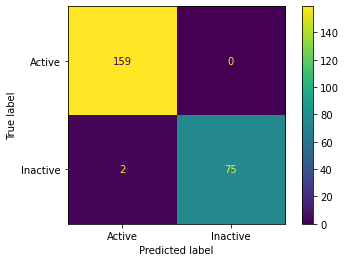

In [63]:
plot_confusion_matrix(clf, train_X, train_y)
plt.show()

In [64]:
print(classification_report(train_y,clf.predict(train_X)))

              precision    recall  f1-score   support

      Active       0.99      1.00      0.99       159
    Inactive       1.00      0.97      0.99        77

    accuracy                           0.99       236
   macro avg       0.99      0.99      0.99       236
weighted avg       0.99      0.99      0.99       236



In [65]:
roc_auc_score(train_y,clf.predict_proba(train_X)[:,1])

0.9999183206730377

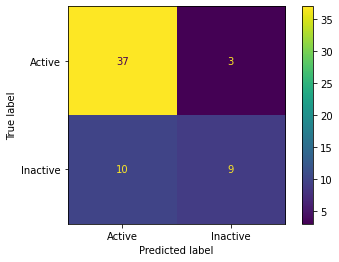

In [66]:
plot_confusion_matrix(clf, test_X, test_y)

In [67]:
print(classification_report(test_y,clf.predict(test_X)))

              precision    recall  f1-score   support

      Active       0.79      0.93      0.85        40
    Inactive       0.75      0.47      0.58        19

    accuracy                           0.78        59
   macro avg       0.77      0.70      0.72        59
weighted avg       0.78      0.78      0.76        59



In [68]:
roc_auc_score(test_y,clf.predict_proba(test_X)[:,1])

0.7710526315789473

In [69]:
a = pd.DataFrame(clf.predict_proba(test), columns = ['Active', 'Inactive']) 

In [70]:
a['name'] = data.iloc[:-14:-1, 0].sort_index().values

In [71]:
a = a[['name', 'Active', 'Inactive']]
a

name    Active  Inactive
0           Walle, Robot  0.974799  0.025201
1         Warwith, Salsa  0.636320  0.363680
2            Whats, Sapp  0.700109  0.299891
3         Wilbor, Bilbor  0.333332  0.666668
4    Wilkensin, Annabele  0.144250  0.855750
5   Williams, Samantha    0.505956  0.494044
6      Winnie,  The pooh  0.985134  0.014866
7           Wolf, Bigman  0.984410  0.015590
8      Woodpecker, Woody  0.992390  0.007610
9       Yemini, Kathleen  0.658696  0.341304
10        Zamchi, Banchi  0.710217  0.289783
11    Zinna, The warrier  0.961550  0.038450
12      Zimmerman, Clara  0.958613  0.041387

In [72]:
# train_data = Pool(data=train_X, label=train_y)

# clf.get_feature_importance(train_data)



### Using three categories in the output

In [73]:
train_X, test_X, train_y, test_y = train_test_split(df_three_cat.iloc[:-13,:].drop(columns = 'Employment Status', axis = 1),\
                                                df_three_cat.iloc[:-13,5],
                                                random_state=10, test_size=0.20)

In [74]:
test = df_three_cat.iloc[:-14:-1,:].drop(columns = 'Employment Status', axis = 1)
test = test.sort_index()

In [75]:
cat_cols = train_X.select_dtypes(include = ['object']).columns
cat_cols_idx = []

for col in cat_cols:
    cat_cols_idx.append(train_X.columns.get_loc(col))

In [76]:
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}

cbm1 = cb.CatBoostClassifier()
cb_model1 = GridSearchCV(cbm1, params, scoring="roc_auc", cv = 3)
cb_model1.fit(train_X, train_y, cat_features = cat_cols_idx)

0:	learn: 1.0804466	total: 4.3ms	remaining: 1.28s
1:	learn: 1.0563565	total: 8.04ms	remaining: 1.2s
2:	learn: 1.0345351	total: 10.6ms	remaining: 1.05s
3:	learn: 1.0164288	total: 12.8ms	remaining: 946ms
4:	learn: 1.0027239	total: 14.8ms	remaining: 871ms
5:	learn: 0.9823794	total: 16.6ms	remaining: 815ms
6:	learn: 0.9619577	total: 18.5ms	remaining: 774ms
7:	learn: 0.9443824	total: 20.3ms	remaining: 740ms
8:	learn: 0.9297674	total: 22ms	remaining: 711ms
9:	learn: 0.9150192	total: 23.6ms	remaining: 685ms
10:	learn: 0.8999497	total: 25.4ms	remaining: 667ms
11:	learn: 0.8860563	total: 27.1ms	remaining: 651ms
12:	learn: 0.8718706	total: 29.2ms	remaining: 645ms
13:	learn: 0.8587325	total: 30.1ms	remaining: 615ms
14:	learn: 0.8454644	total: 32ms	remaining: 608ms
15:	learn: 0.8331942	total: 33.9ms	remaining: 602ms
16:	learn: 0.8238362	total: 35.2ms	remaining: 586ms
17:	learn: 0.8136713	total: 37.1ms	remaining: 581ms
18:	learn: 0.8032581	total: 38.9ms	remaining: 575ms
19:	learn: 0.7940756	total: 

196:	learn: 0.3588190	total: 321ms	remaining: 168ms
197:	learn: 0.3584542	total: 322ms	remaining: 166ms
198:	learn: 0.3581692	total: 324ms	remaining: 164ms
199:	learn: 0.3571883	total: 325ms	remaining: 163ms
200:	learn: 0.3558564	total: 327ms	remaining: 161ms
201:	learn: 0.3547108	total: 328ms	remaining: 159ms
202:	learn: 0.3544966	total: 330ms	remaining: 158ms
203:	learn: 0.3534315	total: 331ms	remaining: 156ms
204:	learn: 0.3529021	total: 333ms	remaining: 154ms
205:	learn: 0.3518610	total: 334ms	remaining: 153ms
206:	learn: 0.3515276	total: 336ms	remaining: 151ms
207:	learn: 0.3502145	total: 337ms	remaining: 149ms
208:	learn: 0.3491725	total: 339ms	remaining: 148ms
209:	learn: 0.3470790	total: 341ms	remaining: 146ms
210:	learn: 0.3459890	total: 342ms	remaining: 144ms
211:	learn: 0.3451917	total: 344ms	remaining: 143ms
212:	learn: 0.3445680	total: 345ms	remaining: 141ms
213:	learn: 0.3429713	total: 347ms	remaining: 139ms
214:	learn: 0.3422648	total: 348ms	remaining: 138ms
215:	learn: 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


46:	learn: 0.6591894	total: 72ms	remaining: 388ms
47:	learn: 0.6563712	total: 73.6ms	remaining: 387ms
48:	learn: 0.6518393	total: 75.6ms	remaining: 387ms
49:	learn: 0.6491920	total: 77ms	remaining: 385ms
50:	learn: 0.6456091	total: 78.7ms	remaining: 384ms
51:	learn: 0.6432189	total: 80.2ms	remaining: 382ms
52:	learn: 0.6379349	total: 81.7ms	remaining: 381ms
53:	learn: 0.6329526	total: 83.3ms	remaining: 380ms
54:	learn: 0.6302056	total: 85ms	remaining: 379ms
55:	learn: 0.6274052	total: 86.6ms	remaining: 377ms
56:	learn: 0.6247563	total: 88.3ms	remaining: 376ms
57:	learn: 0.6204515	total: 90.1ms	remaining: 376ms
58:	learn: 0.6167195	total: 91.7ms	remaining: 375ms
59:	learn: 0.6125828	total: 93.5ms	remaining: 374ms
60:	learn: 0.6097484	total: 95.4ms	remaining: 374ms
61:	learn: 0.6069140	total: 97.1ms	remaining: 373ms
62:	learn: 0.6051050	total: 98.6ms	remaining: 371ms
63:	learn: 0.6033890	total: 100ms	remaining: 369ms
64:	learn: 0.5998680	total: 102ms	remaining: 367ms
65:	learn: 0.5956082

237:	learn: 0.3383758	total: 388ms	remaining: 101ms
238:	learn: 0.3368456	total: 390ms	remaining: 99.4ms
239:	learn: 0.3358151	total: 391ms	remaining: 97.8ms
240:	learn: 0.3346358	total: 393ms	remaining: 96.2ms
241:	learn: 0.3334081	total: 394ms	remaining: 94.5ms
242:	learn: 0.3322544	total: 396ms	remaining: 92.9ms
243:	learn: 0.3305194	total: 398ms	remaining: 91.2ms
244:	learn: 0.3298598	total: 399ms	remaining: 89.6ms
245:	learn: 0.3289612	total: 401ms	remaining: 88ms
246:	learn: 0.3280916	total: 402ms	remaining: 86.3ms
247:	learn: 0.3265294	total: 404ms	remaining: 84.6ms
248:	learn: 0.3257950	total: 405ms	remaining: 83ms
249:	learn: 0.3249392	total: 407ms	remaining: 81.4ms
250:	learn: 0.3237272	total: 408ms	remaining: 79.7ms
251:	learn: 0.3227643	total: 410ms	remaining: 78.1ms
252:	learn: 0.3215606	total: 411ms	remaining: 76.4ms
253:	learn: 0.3201039	total: 413ms	remaining: 74.8ms
254:	learn: 0.3187679	total: 415ms	remaining: 73.2ms
255:	learn: 0.3180491	total: 416ms	remaining: 71.5m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


91:	learn: 0.5327794	total: 141ms	remaining: 318ms
92:	learn: 0.5323008	total: 142ms	remaining: 315ms
93:	learn: 0.5294632	total: 143ms	remaining: 314ms
94:	learn: 0.5283869	total: 145ms	remaining: 313ms
95:	learn: 0.5274195	total: 146ms	remaining: 311ms
96:	learn: 0.5260053	total: 148ms	remaining: 309ms
97:	learn: 0.5238260	total: 149ms	remaining: 308ms
98:	learn: 0.5224958	total: 151ms	remaining: 306ms
99:	learn: 0.5204600	total: 153ms	remaining: 305ms
100:	learn: 0.5180641	total: 154ms	remaining: 304ms
101:	learn: 0.5170797	total: 156ms	remaining: 302ms
102:	learn: 0.5145427	total: 157ms	remaining: 300ms
103:	learn: 0.5131286	total: 159ms	remaining: 299ms
104:	learn: 0.5116059	total: 160ms	remaining: 297ms
105:	learn: 0.5091960	total: 162ms	remaining: 296ms
106:	learn: 0.5070957	total: 163ms	remaining: 295ms
107:	learn: 0.5046721	total: 165ms	remaining: 293ms
108:	learn: 0.5032561	total: 167ms	remaining: 293ms
109:	learn: 0.5018367	total: 169ms	remaining: 292ms
110:	learn: 0.5001695

284:	learn: 0.2780991	total: 459ms	remaining: 24.2ms
285:	learn: 0.2772136	total: 460ms	remaining: 22.5ms
286:	learn: 0.2766457	total: 462ms	remaining: 20.9ms
287:	learn: 0.2761106	total: 464ms	remaining: 19.3ms
288:	learn: 0.2753950	total: 466ms	remaining: 17.7ms
289:	learn: 0.2749356	total: 467ms	remaining: 16.1ms
290:	learn: 0.2742728	total: 469ms	remaining: 14.5ms
291:	learn: 0.2733373	total: 470ms	remaining: 12.9ms
292:	learn: 0.2733138	total: 472ms	remaining: 11.3ms
293:	learn: 0.2728335	total: 473ms	remaining: 9.66ms
294:	learn: 0.2720674	total: 475ms	remaining: 8.04ms
295:	learn: 0.2712839	total: 477ms	remaining: 6.44ms
296:	learn: 0.2711852	total: 478ms	remaining: 4.83ms
297:	learn: 0.2702515	total: 480ms	remaining: 3.22ms
298:	learn: 0.2695609	total: 482ms	remaining: 1.61ms
299:	learn: 0.2680478	total: 484ms	remaining: 0us
0:	learn: 1.0399926	total: 1.65ms	remaining: 495ms
1:	learn: 0.9699320	total: 3.44ms	remaining: 513ms
2:	learn: 0.9124120	total: 5.27ms	remaining: 522ms
3:

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


90:	learn: 0.2573779	total: 152ms	remaining: 348ms
91:	learn: 0.2531560	total: 153ms	remaining: 347ms
92:	learn: 0.2504424	total: 155ms	remaining: 345ms
93:	learn: 0.2484987	total: 157ms	remaining: 344ms
94:	learn: 0.2452224	total: 159ms	remaining: 343ms
95:	learn: 0.2415360	total: 160ms	remaining: 341ms
96:	learn: 0.2384440	total: 162ms	remaining: 339ms
97:	learn: 0.2365691	total: 164ms	remaining: 337ms
98:	learn: 0.2339956	total: 165ms	remaining: 335ms
99:	learn: 0.2330399	total: 167ms	remaining: 333ms
100:	learn: 0.2313364	total: 168ms	remaining: 331ms
101:	learn: 0.2296977	total: 169ms	remaining: 329ms
102:	learn: 0.2277942	total: 171ms	remaining: 327ms
103:	learn: 0.2235590	total: 173ms	remaining: 325ms
104:	learn: 0.2214993	total: 174ms	remaining: 323ms
105:	learn: 0.2184456	total: 176ms	remaining: 322ms
106:	learn: 0.2178846	total: 177ms	remaining: 320ms
107:	learn: 0.2150575	total: 179ms	remaining: 318ms
108:	learn: 0.2141529	total: 180ms	remaining: 316ms
109:	learn: 0.2121368	

12:	learn: 0.6654581	total: 19.8ms	remaining: 437ms
13:	learn: 0.6467946	total: 21.5ms	remaining: 439ms
14:	learn: 0.6368930	total: 23ms	remaining: 436ms
15:	learn: 0.6207407	total: 24.9ms	remaining: 442ms
16:	learn: 0.6146208	total: 26.7ms	remaining: 445ms
17:	learn: 0.6008058	total: 28.4ms	remaining: 444ms
18:	learn: 0.5919817	total: 29.9ms	remaining: 442ms
19:	learn: 0.5824275	total: 31.6ms	remaining: 443ms
20:	learn: 0.5734670	total: 33.2ms	remaining: 441ms
21:	learn: 0.5612388	total: 35ms	remaining: 442ms
22:	learn: 0.5554766	total: 36.9ms	remaining: 445ms
23:	learn: 0.5481422	total: 38.7ms	remaining: 445ms
24:	learn: 0.5376211	total: 40.5ms	remaining: 446ms
25:	learn: 0.5261251	total: 42.2ms	remaining: 445ms
26:	learn: 0.5158326	total: 44.1ms	remaining: 446ms
27:	learn: 0.5093388	total: 45.6ms	remaining: 443ms
28:	learn: 0.5045310	total: 47.1ms	remaining: 440ms
29:	learn: 0.4995959	total: 48.8ms	remaining: 439ms
30:	learn: 0.4924783	total: 50.7ms	remaining: 440ms
31:	learn: 0.490

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


50:	learn: 0.4144927	total: 83.8ms	remaining: 409ms
51:	learn: 0.4080630	total: 85.7ms	remaining: 409ms
52:	learn: 0.4052443	total: 87.6ms	remaining: 408ms
53:	learn: 0.4024347	total: 89.4ms	remaining: 407ms
54:	learn: 0.3977916	total: 91.3ms	remaining: 407ms
55:	learn: 0.3941952	total: 93.1ms	remaining: 406ms
56:	learn: 0.3896124	total: 94.4ms	remaining: 403ms
57:	learn: 0.3880547	total: 95.9ms	remaining: 400ms
58:	learn: 0.3851752	total: 97.8ms	remaining: 399ms
59:	learn: 0.3786317	total: 99.5ms	remaining: 398ms
60:	learn: 0.3725849	total: 101ms	remaining: 397ms
61:	learn: 0.3696568	total: 103ms	remaining: 395ms
62:	learn: 0.3674888	total: 105ms	remaining: 394ms
63:	learn: 0.3641807	total: 106ms	remaining: 393ms
64:	learn: 0.3598739	total: 108ms	remaining: 391ms
65:	learn: 0.3574691	total: 110ms	remaining: 390ms
66:	learn: 0.3528390	total: 112ms	remaining: 389ms
67:	learn: 0.3473933	total: 113ms	remaining: 387ms
68:	learn: 0.3414627	total: 115ms	remaining: 386ms
69:	learn: 0.3381073	

238:	learn: 0.0921233	total: 403ms	remaining: 103ms
239:	learn: 0.0912616	total: 404ms	remaining: 101ms
240:	learn: 0.0909047	total: 406ms	remaining: 99.4ms
241:	learn: 0.0902221	total: 408ms	remaining: 97.7ms
242:	learn: 0.0897926	total: 409ms	remaining: 95.9ms
243:	learn: 0.0895058	total: 411ms	remaining: 94.2ms
244:	learn: 0.0886102	total: 412ms	remaining: 92.5ms
245:	learn: 0.0881648	total: 414ms	remaining: 90.8ms
246:	learn: 0.0878748	total: 415ms	remaining: 89.1ms
247:	learn: 0.0876113	total: 417ms	remaining: 87.4ms
248:	learn: 0.0871422	total: 419ms	remaining: 85.7ms
249:	learn: 0.0864027	total: 420ms	remaining: 84ms
250:	learn: 0.0859355	total: 422ms	remaining: 82.3ms
251:	learn: 0.0856407	total: 423ms	remaining: 80.6ms
252:	learn: 0.0855361	total: 425ms	remaining: 78.9ms
253:	learn: 0.0849437	total: 426ms	remaining: 77.2ms
254:	learn: 0.0843245	total: 428ms	remaining: 75.5ms
255:	learn: 0.0834385	total: 429ms	remaining: 73.8ms
256:	learn: 0.0828898	total: 431ms	remaining: 72.1

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


83:	learn: 0.2966937	total: 142ms	remaining: 366ms
84:	learn: 0.2929316	total: 144ms	remaining: 365ms
85:	learn: 0.2907137	total: 146ms	remaining: 363ms
86:	learn: 0.2872906	total: 148ms	remaining: 362ms
87:	learn: 0.2858700	total: 149ms	remaining: 360ms
88:	learn: 0.2847805	total: 151ms	remaining: 359ms
89:	learn: 0.2813695	total: 153ms	remaining: 358ms
90:	learn: 0.2795768	total: 155ms	remaining: 356ms
91:	learn: 0.2774645	total: 157ms	remaining: 354ms
92:	learn: 0.2754976	total: 158ms	remaining: 352ms
93:	learn: 0.2728184	total: 160ms	remaining: 351ms
94:	learn: 0.2691255	total: 162ms	remaining: 349ms
95:	learn: 0.2680116	total: 163ms	remaining: 347ms
96:	learn: 0.2650245	total: 165ms	remaining: 345ms
97:	learn: 0.2638622	total: 166ms	remaining: 343ms
98:	learn: 0.2631617	total: 168ms	remaining: 340ms
99:	learn: 0.2617111	total: 170ms	remaining: 339ms
100:	learn: 0.2578483	total: 171ms	remaining: 337ms
101:	learn: 0.2543473	total: 173ms	remaining: 335ms
102:	learn: 0.2527498	total: 

269:	learn: 0.0817482	total: 461ms	remaining: 51.2ms
270:	learn: 0.0810386	total: 463ms	remaining: 49.5ms
271:	learn: 0.0807014	total: 465ms	remaining: 47.9ms
272:	learn: 0.0804557	total: 466ms	remaining: 46.1ms
273:	learn: 0.0802395	total: 468ms	remaining: 44.4ms
274:	learn: 0.0798456	total: 470ms	remaining: 42.7ms
275:	learn: 0.0794553	total: 472ms	remaining: 41ms
276:	learn: 0.0787239	total: 473ms	remaining: 39.3ms
277:	learn: 0.0782018	total: 475ms	remaining: 37.6ms
278:	learn: 0.0778556	total: 477ms	remaining: 35.9ms
279:	learn: 0.0776830	total: 479ms	remaining: 34.2ms
280:	learn: 0.0774756	total: 480ms	remaining: 32.5ms
281:	learn: 0.0767113	total: 482ms	remaining: 30.8ms
282:	learn: 0.0758102	total: 484ms	remaining: 29.1ms
283:	learn: 0.0753927	total: 486ms	remaining: 27.4ms
284:	learn: 0.0749847	total: 488ms	remaining: 25.7ms
285:	learn: 0.0746036	total: 490ms	remaining: 24ms
286:	learn: 0.0744392	total: 491ms	remaining: 22.3ms
287:	learn: 0.0742191	total: 493ms	remaining: 20.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


74:	learn: 0.2142890	total: 126ms	remaining: 379ms
75:	learn: 0.2125080	total: 128ms	remaining: 377ms
76:	learn: 0.2114630	total: 130ms	remaining: 376ms
77:	learn: 0.2095965	total: 131ms	remaining: 374ms
78:	learn: 0.2077387	total: 133ms	remaining: 372ms
79:	learn: 0.2047686	total: 135ms	remaining: 371ms
80:	learn: 0.2045352	total: 137ms	remaining: 369ms
81:	learn: 0.2010872	total: 138ms	remaining: 368ms
82:	learn: 0.1993872	total: 140ms	remaining: 366ms
83:	learn: 0.1979547	total: 142ms	remaining: 364ms
84:	learn: 0.1972374	total: 143ms	remaining: 362ms
85:	learn: 0.1958180	total: 145ms	remaining: 360ms
86:	learn: 0.1913085	total: 146ms	remaining: 358ms
87:	learn: 0.1897222	total: 149ms	remaining: 358ms
88:	learn: 0.1874736	total: 150ms	remaining: 357ms
89:	learn: 0.1847703	total: 152ms	remaining: 354ms
90:	learn: 0.1837529	total: 154ms	remaining: 353ms
91:	learn: 0.1824685	total: 155ms	remaining: 351ms
92:	learn: 0.1800472	total: 157ms	remaining: 349ms
93:	learn: 0.1788941	total: 158

0:	learn: 0.9807999	total: 1.66ms	remaining: 497ms
1:	learn: 0.9208090	total: 3.37ms	remaining: 502ms
2:	learn: 0.8629874	total: 5.26ms	remaining: 521ms
3:	learn: 0.8155283	total: 6.93ms	remaining: 513ms
4:	learn: 0.7671185	total: 8.71ms	remaining: 514ms
5:	learn: 0.7355487	total: 10.4ms	remaining: 508ms
6:	learn: 0.7057856	total: 12.2ms	remaining: 512ms
7:	learn: 0.6809721	total: 14.3ms	remaining: 521ms
8:	learn: 0.6522798	total: 16ms	remaining: 519ms
9:	learn: 0.6421209	total: 16.6ms	remaining: 481ms
10:	learn: 0.6275292	total: 18.2ms	remaining: 479ms
11:	learn: 0.6183371	total: 19.8ms	remaining: 476ms
12:	learn: 0.6006041	total: 21.6ms	remaining: 477ms
13:	learn: 0.5819221	total: 23.3ms	remaining: 477ms
14:	learn: 0.5745343	total: 24.9ms	remaining: 474ms
15:	learn: 0.5654902	total: 26.9ms	remaining: 477ms
16:	learn: 0.5563539	total: 28.6ms	remaining: 476ms
17:	learn: 0.5391872	total: 30.2ms	remaining: 473ms
18:	learn: 0.5299927	total: 31.3ms	remaining: 464ms
19:	learn: 0.5253249	tot

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


34:	learn: 0.4294797	total: 57.3ms	remaining: 434ms
35:	learn: 0.4213695	total: 59.3ms	remaining: 435ms
36:	learn: 0.4108386	total: 60.9ms	remaining: 433ms
37:	learn: 0.4049361	total: 62.8ms	remaining: 433ms
38:	learn: 0.4026164	total: 64.5ms	remaining: 431ms
39:	learn: 0.4016702	total: 65.9ms	remaining: 429ms
40:	learn: 0.3911829	total: 67.5ms	remaining: 426ms
41:	learn: 0.3844627	total: 69.2ms	remaining: 425ms
42:	learn: 0.3803858	total: 70.8ms	remaining: 423ms
43:	learn: 0.3726445	total: 72.4ms	remaining: 421ms
44:	learn: 0.3683625	total: 74.1ms	remaining: 420ms
45:	learn: 0.3629313	total: 76ms	remaining: 420ms
46:	learn: 0.3538653	total: 77.7ms	remaining: 418ms
47:	learn: 0.3456746	total: 79.4ms	remaining: 417ms
48:	learn: 0.3426973	total: 81.1ms	remaining: 415ms
49:	learn: 0.3391757	total: 82.8ms	remaining: 414ms
50:	learn: 0.3348923	total: 84.5ms	remaining: 413ms
51:	learn: 0.3279874	total: 86.2ms	remaining: 411ms
52:	learn: 0.3225731	total: 87.8ms	remaining: 409ms
53:	learn: 0.3

226:	learn: 0.0615448	total: 384ms	remaining: 124ms
227:	learn: 0.0614458	total: 386ms	remaining: 122ms
228:	learn: 0.0612416	total: 388ms	remaining: 120ms
229:	learn: 0.0609567	total: 390ms	remaining: 119ms
230:	learn: 0.0606577	total: 391ms	remaining: 117ms
231:	learn: 0.0602102	total: 393ms	remaining: 115ms
232:	learn: 0.0601114	total: 394ms	remaining: 113ms
233:	learn: 0.0596433	total: 396ms	remaining: 112ms
234:	learn: 0.0590115	total: 398ms	remaining: 110ms
235:	learn: 0.0585814	total: 400ms	remaining: 108ms
236:	learn: 0.0583004	total: 401ms	remaining: 107ms
237:	learn: 0.0579971	total: 403ms	remaining: 105ms
238:	learn: 0.0575286	total: 405ms	remaining: 103ms
239:	learn: 0.0570485	total: 407ms	remaining: 102ms
240:	learn: 0.0568142	total: 409ms	remaining: 100ms
241:	learn: 0.0564586	total: 411ms	remaining: 98.4ms
242:	learn: 0.0560347	total: 412ms	remaining: 96.7ms
243:	learn: 0.0559079	total: 414ms	remaining: 95ms
244:	learn: 0.0558196	total: 416ms	remaining: 93.3ms
245:	learn

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


62:	learn: 0.2636806	total: 108ms	remaining: 407ms
63:	learn: 0.2577328	total: 110ms	remaining: 405ms
64:	learn: 0.2543235	total: 112ms	remaining: 403ms
65:	learn: 0.2489572	total: 113ms	remaining: 401ms
66:	learn: 0.2450616	total: 115ms	remaining: 400ms
67:	learn: 0.2420810	total: 116ms	remaining: 397ms
68:	learn: 0.2381435	total: 118ms	remaining: 396ms
69:	learn: 0.2360486	total: 120ms	remaining: 395ms
70:	learn: 0.2340702	total: 122ms	remaining: 393ms
71:	learn: 0.2306308	total: 124ms	remaining: 391ms
72:	learn: 0.2287746	total: 125ms	remaining: 389ms
73:	learn: 0.2204639	total: 127ms	remaining: 388ms
74:	learn: 0.2185071	total: 129ms	remaining: 386ms
75:	learn: 0.2152302	total: 130ms	remaining: 384ms
76:	learn: 0.2116062	total: 132ms	remaining: 382ms
77:	learn: 0.2093538	total: 133ms	remaining: 380ms
78:	learn: 0.2064087	total: 135ms	remaining: 378ms
79:	learn: 0.2035793	total: 137ms	remaining: 377ms
80:	learn: 0.2018061	total: 139ms	remaining: 375ms
81:	learn: 0.1993932	total: 140

250:	learn: 0.0481127	total: 434ms	remaining: 84.7ms
251:	learn: 0.0477622	total: 437ms	remaining: 83.2ms
252:	learn: 0.0475320	total: 438ms	remaining: 81.5ms
253:	learn: 0.0473449	total: 440ms	remaining: 79.7ms
254:	learn: 0.0471495	total: 442ms	remaining: 78ms
255:	learn: 0.0468227	total: 444ms	remaining: 76.2ms
256:	learn: 0.0466004	total: 445ms	remaining: 74.5ms
257:	learn: 0.0460778	total: 447ms	remaining: 72.7ms
258:	learn: 0.0459826	total: 448ms	remaining: 71ms
259:	learn: 0.0457911	total: 450ms	remaining: 69.2ms
260:	learn: 0.0455312	total: 452ms	remaining: 67.5ms
261:	learn: 0.0453190	total: 453ms	remaining: 65.7ms
262:	learn: 0.0449673	total: 455ms	remaining: 64ms
263:	learn: 0.0448233	total: 457ms	remaining: 62.3ms
264:	learn: 0.0445989	total: 459ms	remaining: 60.6ms
265:	learn: 0.0444542	total: 460ms	remaining: 58.8ms
266:	learn: 0.0441561	total: 462ms	remaining: 57.1ms
267:	learn: 0.0439777	total: 464ms	remaining: 55.4ms
268:	learn: 0.0436314	total: 465ms	remaining: 53.6ms

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


94:	learn: 0.5695834	total: 144ms	remaining: 311ms
95:	learn: 0.5682330	total: 146ms	remaining: 311ms
96:	learn: 0.5668176	total: 148ms	remaining: 310ms
97:	learn: 0.5657200	total: 150ms	remaining: 308ms
98:	learn: 0.5642637	total: 151ms	remaining: 307ms
99:	learn: 0.5627887	total: 153ms	remaining: 305ms
100:	learn: 0.5609498	total: 154ms	remaining: 304ms
101:	learn: 0.5595164	total: 156ms	remaining: 303ms
102:	learn: 0.5581160	total: 157ms	remaining: 301ms
103:	learn: 0.5559654	total: 159ms	remaining: 300ms
104:	learn: 0.5542164	total: 161ms	remaining: 298ms
105:	learn: 0.5526986	total: 162ms	remaining: 297ms
106:	learn: 0.5513742	total: 164ms	remaining: 295ms
107:	learn: 0.5499165	total: 165ms	remaining: 294ms
108:	learn: 0.5489060	total: 167ms	remaining: 292ms
109:	learn: 0.5471781	total: 168ms	remaining: 290ms
110:	learn: 0.5461800	total: 170ms	remaining: 289ms
111:	learn: 0.5448433	total: 171ms	remaining: 288ms
112:	learn: 0.5427686	total: 173ms	remaining: 286ms
113:	learn: 0.5416

283:	learn: 0.3834533	total: 472ms	remaining: 26.6ms
284:	learn: 0.3825937	total: 473ms	remaining: 24.9ms
285:	learn: 0.3820439	total: 475ms	remaining: 23.3ms
286:	learn: 0.3812216	total: 477ms	remaining: 21.6ms
287:	learn: 0.3806324	total: 479ms	remaining: 20ms
288:	learn: 0.3802457	total: 480ms	remaining: 18.3ms
289:	learn: 0.3799702	total: 482ms	remaining: 16.6ms
290:	learn: 0.3793725	total: 484ms	remaining: 15ms
291:	learn: 0.3789983	total: 486ms	remaining: 13.3ms
292:	learn: 0.3779539	total: 488ms	remaining: 11.6ms
293:	learn: 0.3772112	total: 490ms	remaining: 10ms
294:	learn: 0.3761316	total: 492ms	remaining: 8.34ms
295:	learn: 0.3753442	total: 493ms	remaining: 6.67ms
296:	learn: 0.3748521	total: 495ms	remaining: 5ms
297:	learn: 0.3739600	total: 497ms	remaining: 3.33ms
298:	learn: 0.3732708	total: 498ms	remaining: 1.67ms
299:	learn: 0.3726289	total: 500ms	remaining: 0us
0:	learn: 1.0773910	total: 1.7ms	remaining: 507ms
1:	learn: 1.0638097	total: 3.33ms	remaining: 496ms
2:	learn: 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


91:	learn: 0.5972688	total: 148ms	remaining: 335ms
92:	learn: 0.5955723	total: 150ms	remaining: 334ms
93:	learn: 0.5939875	total: 152ms	remaining: 332ms
94:	learn: 0.5929928	total: 153ms	remaining: 331ms
95:	learn: 0.5913688	total: 155ms	remaining: 330ms
96:	learn: 0.5896584	total: 157ms	remaining: 328ms
97:	learn: 0.5880971	total: 159ms	remaining: 327ms
98:	learn: 0.5872875	total: 160ms	remaining: 324ms
99:	learn: 0.5854084	total: 161ms	remaining: 323ms
100:	learn: 0.5841959	total: 163ms	remaining: 321ms
101:	learn: 0.5829497	total: 165ms	remaining: 319ms
102:	learn: 0.5814874	total: 166ms	remaining: 318ms
103:	learn: 0.5804518	total: 168ms	remaining: 316ms
104:	learn: 0.5783704	total: 170ms	remaining: 315ms
105:	learn: 0.5771336	total: 171ms	remaining: 313ms
106:	learn: 0.5762845	total: 173ms	remaining: 311ms
107:	learn: 0.5750616	total: 175ms	remaining: 311ms
108:	learn: 0.5737545	total: 176ms	remaining: 309ms
109:	learn: 0.5727091	total: 178ms	remaining: 308ms
110:	learn: 0.5713198

2:	learn: 1.0527207	total: 5.82ms	remaining: 576ms
3:	learn: 1.0358822	total: 7.54ms	remaining: 558ms
4:	learn: 1.0206062	total: 9.49ms	remaining: 560ms
5:	learn: 1.0108732	total: 11.2ms	remaining: 550ms
6:	learn: 0.9965415	total: 13.2ms	remaining: 550ms
7:	learn: 0.9851200	total: 14.6ms	remaining: 533ms
8:	learn: 0.9705206	total: 16.2ms	remaining: 525ms
9:	learn: 0.9581281	total: 18ms	remaining: 521ms
10:	learn: 0.9468427	total: 19.7ms	remaining: 517ms
11:	learn: 0.9319116	total: 20.9ms	remaining: 502ms
12:	learn: 0.9225931	total: 22.6ms	remaining: 500ms
13:	learn: 0.9148962	total: 24.2ms	remaining: 494ms
14:	learn: 0.9056758	total: 25.8ms	remaining: 490ms
15:	learn: 0.8971710	total: 27.2ms	remaining: 483ms
16:	learn: 0.8890234	total: 29.1ms	remaining: 484ms
17:	learn: 0.8815844	total: 30.6ms	remaining: 480ms
18:	learn: 0.8709375	total: 32.4ms	remaining: 479ms
19:	learn: 0.8629141	total: 34ms	remaining: 476ms
20:	learn: 0.8567894	total: 35.5ms	remaining: 472ms
21:	learn: 0.8495708	tot

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


36:	learn: 0.7527475	total: 59.8ms	remaining: 425ms
37:	learn: 0.7490000	total: 61.8ms	remaining: 426ms
38:	learn: 0.7451515	total: 62.3ms	remaining: 417ms
39:	learn: 0.7416318	total: 63.8ms	remaining: 415ms
40:	learn: 0.7377425	total: 65.6ms	remaining: 414ms
41:	learn: 0.7341375	total: 67.5ms	remaining: 415ms
42:	learn: 0.7310968	total: 68.9ms	remaining: 412ms
43:	learn: 0.7278974	total: 69.5ms	remaining: 404ms
44:	learn: 0.7232273	total: 71.1ms	remaining: 403ms
45:	learn: 0.7197297	total: 72.5ms	remaining: 400ms
46:	learn: 0.7172698	total: 74ms	remaining: 398ms
47:	learn: 0.7143906	total: 75.6ms	remaining: 397ms
48:	learn: 0.7088377	total: 77.3ms	remaining: 396ms
49:	learn: 0.7066528	total: 79ms	remaining: 395ms
50:	learn: 0.7041055	total: 79.5ms	remaining: 388ms
51:	learn: 0.7002351	total: 81.2ms	remaining: 387ms
52:	learn: 0.6975485	total: 82.9ms	remaining: 386ms
53:	learn: 0.6952513	total: 84.6ms	remaining: 385ms
54:	learn: 0.6932883	total: 86.2ms	remaining: 384ms
55:	learn: 0.689

225:	learn: 0.4486798	total: 386ms	remaining: 126ms
226:	learn: 0.4481279	total: 388ms	remaining: 125ms
227:	learn: 0.4472505	total: 390ms	remaining: 123ms
228:	learn: 0.4467177	total: 392ms	remaining: 122ms
229:	learn: 0.4452070	total: 394ms	remaining: 120ms
230:	learn: 0.4446558	total: 396ms	remaining: 118ms
231:	learn: 0.4438571	total: 398ms	remaining: 117ms
232:	learn: 0.4425356	total: 400ms	remaining: 115ms
233:	learn: 0.4422959	total: 402ms	remaining: 113ms
234:	learn: 0.4417514	total: 404ms	remaining: 112ms
235:	learn: 0.4413882	total: 405ms	remaining: 110ms
236:	learn: 0.4403775	total: 407ms	remaining: 108ms
237:	learn: 0.4385073	total: 410ms	remaining: 107ms
238:	learn: 0.4370112	total: 412ms	remaining: 105ms
239:	learn: 0.4362565	total: 413ms	remaining: 103ms
240:	learn: 0.4354924	total: 415ms	remaining: 102ms
241:	learn: 0.4344702	total: 417ms	remaining: 100ms
242:	learn: 0.4334069	total: 419ms	remaining: 98.3ms
243:	learn: 0.4327182	total: 421ms	remaining: 96.6ms
244:	learn

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


49:	learn: 0.4857754	total: 90.2ms	remaining: 451ms
50:	learn: 0.4837011	total: 92.2ms	remaining: 450ms
51:	learn: 0.4828261	total: 93.9ms	remaining: 448ms
52:	learn: 0.4805179	total: 95.8ms	remaining: 446ms
53:	learn: 0.4781618	total: 97.7ms	remaining: 445ms
54:	learn: 0.4759704	total: 99.3ms	remaining: 442ms
55:	learn: 0.4731704	total: 101ms	remaining: 441ms
56:	learn: 0.4705002	total: 103ms	remaining: 441ms
57:	learn: 0.4675435	total: 105ms	remaining: 440ms
58:	learn: 0.4639277	total: 107ms	remaining: 439ms
59:	learn: 0.4595157	total: 109ms	remaining: 435ms
60:	learn: 0.4568898	total: 110ms	remaining: 432ms
61:	learn: 0.4562878	total: 112ms	remaining: 431ms
62:	learn: 0.4533904	total: 114ms	remaining: 429ms
63:	learn: 0.4494149	total: 116ms	remaining: 427ms
64:	learn: 0.4471375	total: 117ms	remaining: 425ms
65:	learn: 0.4438154	total: 120ms	remaining: 427ms
66:	learn: 0.4413927	total: 122ms	remaining: 425ms
67:	learn: 0.4382272	total: 124ms	remaining: 424ms
68:	learn: 0.4368292	tota

229:	learn: 0.2093630	total: 417ms	remaining: 127ms
230:	learn: 0.2083339	total: 418ms	remaining: 125ms
231:	learn: 0.2073142	total: 420ms	remaining: 123ms
232:	learn: 0.2056754	total: 422ms	remaining: 121ms
233:	learn: 0.2052906	total: 423ms	remaining: 119ms
234:	learn: 0.2045748	total: 425ms	remaining: 118ms
235:	learn: 0.2038856	total: 426ms	remaining: 116ms
236:	learn: 0.2032669	total: 428ms	remaining: 114ms
237:	learn: 0.2026057	total: 430ms	remaining: 112ms
238:	learn: 0.2019362	total: 431ms	remaining: 110ms
239:	learn: 0.2012798	total: 433ms	remaining: 108ms
240:	learn: 0.2005804	total: 435ms	remaining: 106ms
241:	learn: 0.1993305	total: 436ms	remaining: 105ms
242:	learn: 0.1985907	total: 438ms	remaining: 103ms
243:	learn: 0.1973422	total: 440ms	remaining: 101ms
244:	learn: 0.1962364	total: 442ms	remaining: 99.1ms
245:	learn: 0.1961566	total: 443ms	remaining: 97.3ms
246:	learn: 0.1952426	total: 445ms	remaining: 95.4ms
247:	learn: 0.1944576	total: 446ms	remaining: 93.6ms
248:	lea

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


57:	learn: 0.4645080	total: 111ms	remaining: 464ms
58:	learn: 0.4618134	total: 114ms	remaining: 464ms
59:	learn: 0.4590448	total: 116ms	remaining: 463ms
60:	learn: 0.4564457	total: 118ms	remaining: 461ms
61:	learn: 0.4531289	total: 120ms	remaining: 459ms
62:	learn: 0.4507638	total: 122ms	remaining: 458ms
63:	learn: 0.4482955	total: 124ms	remaining: 457ms
64:	learn: 0.4441431	total: 126ms	remaining: 456ms
65:	learn: 0.4424594	total: 128ms	remaining: 455ms
66:	learn: 0.4388444	total: 130ms	remaining: 453ms
67:	learn: 0.4367124	total: 132ms	remaining: 451ms
68:	learn: 0.4340109	total: 135ms	remaining: 452ms
69:	learn: 0.4302710	total: 137ms	remaining: 450ms
70:	learn: 0.4294292	total: 139ms	remaining: 448ms
71:	learn: 0.4274292	total: 141ms	remaining: 447ms
72:	learn: 0.4249480	total: 144ms	remaining: 446ms
73:	learn: 0.4227493	total: 145ms	remaining: 444ms
74:	learn: 0.4190245	total: 147ms	remaining: 442ms
75:	learn: 0.4161114	total: 150ms	remaining: 442ms
76:	learn: 0.4128833	total: 152

235:	learn: 0.1878966	total: 620ms	remaining: 168ms
236:	learn: 0.1873441	total: 624ms	remaining: 166ms
237:	learn: 0.1871165	total: 626ms	remaining: 163ms
238:	learn: 0.1868075	total: 628ms	remaining: 160ms
239:	learn: 0.1861214	total: 632ms	remaining: 158ms
240:	learn: 0.1856870	total: 635ms	remaining: 155ms
241:	learn: 0.1849877	total: 639ms	remaining: 153ms
242:	learn: 0.1841941	total: 641ms	remaining: 150ms
243:	learn: 0.1839010	total: 645ms	remaining: 148ms
244:	learn: 0.1832847	total: 648ms	remaining: 145ms
245:	learn: 0.1823616	total: 651ms	remaining: 143ms
246:	learn: 0.1819250	total: 654ms	remaining: 140ms
247:	learn: 0.1814722	total: 656ms	remaining: 138ms
248:	learn: 0.1808378	total: 659ms	remaining: 135ms
249:	learn: 0.1805677	total: 661ms	remaining: 132ms
250:	learn: 0.1803152	total: 663ms	remaining: 130ms
251:	learn: 0.1799640	total: 666ms	remaining: 127ms
252:	learn: 0.1795624	total: 670ms	remaining: 124ms
253:	learn: 0.1792779	total: 672ms	remaining: 122ms
254:	learn: 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


57:	learn: 0.4921033	total: 142ms	remaining: 593ms
58:	learn: 0.4902223	total: 148ms	remaining: 605ms
59:	learn: 0.4863990	total: 150ms	remaining: 601ms
60:	learn: 0.4838388	total: 153ms	remaining: 601ms
61:	learn: 0.4822060	total: 157ms	remaining: 602ms
62:	learn: 0.4808844	total: 160ms	remaining: 603ms
63:	learn: 0.4751831	total: 164ms	remaining: 603ms
64:	learn: 0.4724742	total: 166ms	remaining: 600ms
65:	learn: 0.4708298	total: 169ms	remaining: 598ms
66:	learn: 0.4669079	total: 171ms	remaining: 595ms
67:	learn: 0.4610563	total: 173ms	remaining: 591ms
68:	learn: 0.4555806	total: 176ms	remaining: 588ms
69:	learn: 0.4492396	total: 180ms	remaining: 590ms
70:	learn: 0.4438820	total: 183ms	remaining: 591ms
71:	learn: 0.4395883	total: 187ms	remaining: 593ms
72:	learn: 0.4348394	total: 190ms	remaining: 592ms
73:	learn: 0.4312376	total: 193ms	remaining: 591ms
74:	learn: 0.4270405	total: 197ms	remaining: 591ms
75:	learn: 0.4229927	total: 201ms	remaining: 593ms
76:	learn: 0.4190232	total: 203

225:	learn: 0.1987041	total: 525ms	remaining: 172ms
226:	learn: 0.1980750	total: 528ms	remaining: 170ms
227:	learn: 0.1973818	total: 530ms	remaining: 167ms
228:	learn: 0.1967466	total: 532ms	remaining: 165ms
229:	learn: 0.1959843	total: 534ms	remaining: 163ms
230:	learn: 0.1953084	total: 536ms	remaining: 160ms
231:	learn: 0.1946323	total: 538ms	remaining: 158ms
232:	learn: 0.1939243	total: 540ms	remaining: 155ms
233:	learn: 0.1934890	total: 541ms	remaining: 153ms
234:	learn: 0.1925280	total: 543ms	remaining: 150ms
235:	learn: 0.1914174	total: 545ms	remaining: 148ms
236:	learn: 0.1906896	total: 546ms	remaining: 145ms
237:	learn: 0.1895754	total: 548ms	remaining: 143ms
238:	learn: 0.1887135	total: 550ms	remaining: 140ms
239:	learn: 0.1877885	total: 551ms	remaining: 138ms
240:	learn: 0.1867826	total: 553ms	remaining: 135ms
241:	learn: 0.1861110	total: 555ms	remaining: 133ms
242:	learn: 0.1858107	total: 556ms	remaining: 131ms
243:	learn: 0.1853934	total: 558ms	remaining: 128ms
244:	learn: 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


48:	learn: 0.4193525	total: 96ms	remaining: 492ms
49:	learn: 0.4141425	total: 97.9ms	remaining: 490ms
50:	learn: 0.4125508	total: 99.8ms	remaining: 487ms
51:	learn: 0.4076882	total: 102ms	remaining: 485ms
52:	learn: 0.4051240	total: 104ms	remaining: 483ms
53:	learn: 0.4038579	total: 106ms	remaining: 481ms
54:	learn: 0.3996442	total: 107ms	remaining: 478ms
55:	learn: 0.3954308	total: 109ms	remaining: 476ms
56:	learn: 0.3904229	total: 111ms	remaining: 473ms
57:	learn: 0.3873932	total: 113ms	remaining: 471ms
58:	learn: 0.3834666	total: 115ms	remaining: 469ms
59:	learn: 0.3814046	total: 116ms	remaining: 465ms
60:	learn: 0.3758472	total: 118ms	remaining: 463ms
61:	learn: 0.3737304	total: 120ms	remaining: 461ms
62:	learn: 0.3710732	total: 122ms	remaining: 460ms
63:	learn: 0.3687844	total: 125ms	remaining: 460ms
64:	learn: 0.3668530	total: 127ms	remaining: 460ms
65:	learn: 0.3637861	total: 129ms	remaining: 459ms
66:	learn: 0.3601725	total: 132ms	remaining: 457ms
67:	learn: 0.3579197	total: 13

219:	learn: 0.1479986	total: 474ms	remaining: 172ms
220:	learn: 0.1473800	total: 476ms	remaining: 170ms
221:	learn: 0.1468046	total: 479ms	remaining: 168ms
222:	learn: 0.1461834	total: 481ms	remaining: 166ms
223:	learn: 0.1452526	total: 483ms	remaining: 164ms
224:	learn: 0.1447749	total: 485ms	remaining: 162ms
225:	learn: 0.1444221	total: 487ms	remaining: 160ms
226:	learn: 0.1441789	total: 489ms	remaining: 157ms
227:	learn: 0.1437476	total: 491ms	remaining: 155ms
228:	learn: 0.1431271	total: 493ms	remaining: 153ms
229:	learn: 0.1424837	total: 495ms	remaining: 151ms
230:	learn: 0.1419660	total: 497ms	remaining: 148ms
231:	learn: 0.1412556	total: 499ms	remaining: 146ms
232:	learn: 0.1403997	total: 502ms	remaining: 144ms
233:	learn: 0.1395789	total: 505ms	remaining: 142ms
234:	learn: 0.1392896	total: 508ms	remaining: 140ms
235:	learn: 0.1382955	total: 512ms	remaining: 139ms
236:	learn: 0.1377424	total: 515ms	remaining: 137ms
237:	learn: 0.1374396	total: 518ms	remaining: 135ms
238:	learn: 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


51:	learn: 0.4286159	total: 116ms	remaining: 554ms
52:	learn: 0.4246094	total: 121ms	remaining: 566ms
53:	learn: 0.4186436	total: 125ms	remaining: 568ms
54:	learn: 0.4152363	total: 127ms	remaining: 568ms
55:	learn: 0.4106705	total: 132ms	remaining: 573ms
56:	learn: 0.4068168	total: 135ms	remaining: 575ms
57:	learn: 0.4043757	total: 138ms	remaining: 575ms
58:	learn: 0.4002530	total: 141ms	remaining: 575ms
59:	learn: 0.3986901	total: 145ms	remaining: 579ms
60:	learn: 0.3950498	total: 150ms	remaining: 586ms
61:	learn: 0.3922648	total: 154ms	remaining: 591ms
62:	learn: 0.3853475	total: 157ms	remaining: 592ms
63:	learn: 0.3812737	total: 162ms	remaining: 598ms
64:	learn: 0.3798891	total: 168ms	remaining: 607ms
65:	learn: 0.3739300	total: 172ms	remaining: 610ms
66:	learn: 0.3701077	total: 175ms	remaining: 610ms
67:	learn: 0.3658241	total: 185ms	remaining: 630ms
68:	learn: 0.3600814	total: 188ms	remaining: 631ms
69:	learn: 0.3579229	total: 192ms	remaining: 631ms
70:	learn: 0.3516304	total: 195

235:	learn: 0.1338991	total: 564ms	remaining: 153ms
236:	learn: 0.1334173	total: 566ms	remaining: 151ms
237:	learn: 0.1329248	total: 569ms	remaining: 148ms
238:	learn: 0.1320553	total: 570ms	remaining: 146ms
239:	learn: 0.1311798	total: 572ms	remaining: 143ms
240:	learn: 0.1307092	total: 575ms	remaining: 141ms
241:	learn: 0.1305631	total: 577ms	remaining: 138ms
242:	learn: 0.1298196	total: 579ms	remaining: 136ms
243:	learn: 0.1285022	total: 582ms	remaining: 133ms
244:	learn: 0.1276446	total: 584ms	remaining: 131ms
245:	learn: 0.1273081	total: 586ms	remaining: 129ms
246:	learn: 0.1269852	total: 588ms	remaining: 126ms
247:	learn: 0.1266072	total: 590ms	remaining: 124ms
248:	learn: 0.1264600	total: 593ms	remaining: 121ms
249:	learn: 0.1251273	total: 595ms	remaining: 119ms
250:	learn: 0.1247161	total: 597ms	remaining: 117ms
251:	learn: 0.1243527	total: 599ms	remaining: 114ms
252:	learn: 0.1240051	total: 601ms	remaining: 112ms
253:	learn: 0.1233494	total: 603ms	remaining: 109ms
254:	learn: 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


72:	learn: 0.3357790	total: 160ms	remaining: 497ms
73:	learn: 0.3336917	total: 162ms	remaining: 494ms
74:	learn: 0.3301973	total: 164ms	remaining: 493ms
75:	learn: 0.3287458	total: 167ms	remaining: 492ms
76:	learn: 0.3253643	total: 169ms	remaining: 491ms
77:	learn: 0.3229116	total: 172ms	remaining: 489ms
78:	learn: 0.3198218	total: 174ms	remaining: 487ms
79:	learn: 0.3160204	total: 176ms	remaining: 484ms
80:	learn: 0.3126111	total: 178ms	remaining: 482ms
81:	learn: 0.3095856	total: 180ms	remaining: 479ms
82:	learn: 0.3087467	total: 182ms	remaining: 477ms
83:	learn: 0.3078390	total: 185ms	remaining: 476ms
84:	learn: 0.3042253	total: 188ms	remaining: 474ms
85:	learn: 0.3031410	total: 190ms	remaining: 473ms
86:	learn: 0.3015481	total: 192ms	remaining: 471ms
87:	learn: 0.3002939	total: 196ms	remaining: 472ms
88:	learn: 0.2980324	total: 199ms	remaining: 472ms
89:	learn: 0.2960835	total: 202ms	remaining: 470ms
90:	learn: 0.2956121	total: 204ms	remaining: 468ms
91:	learn: 0.2953698	total: 206

251:	learn: 0.1211096	total: 614ms	remaining: 117ms
252:	learn: 0.1207548	total: 616ms	remaining: 114ms
253:	learn: 0.1201667	total: 618ms	remaining: 112ms
254:	learn: 0.1198785	total: 620ms	remaining: 109ms
255:	learn: 0.1193291	total: 622ms	remaining: 107ms
256:	learn: 0.1189514	total: 624ms	remaining: 104ms
257:	learn: 0.1182647	total: 626ms	remaining: 102ms
258:	learn: 0.1176554	total: 628ms	remaining: 99.4ms
259:	learn: 0.1174898	total: 630ms	remaining: 96.9ms
260:	learn: 0.1172703	total: 632ms	remaining: 94.4ms
261:	learn: 0.1170766	total: 633ms	remaining: 91.8ms
262:	learn: 0.1165223	total: 635ms	remaining: 89.4ms
263:	learn: 0.1163214	total: 637ms	remaining: 86.9ms
264:	learn: 0.1158397	total: 640ms	remaining: 84.5ms
265:	learn: 0.1155446	total: 641ms	remaining: 82ms
266:	learn: 0.1152372	total: 643ms	remaining: 79.5ms
267:	learn: 0.1147646	total: 645ms	remaining: 77ms
268:	learn: 0.1139122	total: 647ms	remaining: 74.5ms
269:	learn: 0.1134559	total: 649ms	remaining: 72.1ms
270:

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


48:	learn: 0.7431331	total: 84.1ms	remaining: 431ms
49:	learn: 0.7396551	total: 86ms	remaining: 430ms
50:	learn: 0.7363361	total: 87.6ms	remaining: 428ms
51:	learn: 0.7339498	total: 89.5ms	remaining: 427ms
52:	learn: 0.7295994	total: 91.9ms	remaining: 428ms
53:	learn: 0.7262474	total: 92.6ms	remaining: 422ms
54:	learn: 0.7213185	total: 94.6ms	remaining: 421ms
55:	learn: 0.7187600	total: 96.4ms	remaining: 420ms
56:	learn: 0.7164962	total: 98.8ms	remaining: 421ms
57:	learn: 0.7112391	total: 101ms	remaining: 420ms
58:	learn: 0.7080854	total: 102ms	remaining: 416ms
59:	learn: 0.7052146	total: 104ms	remaining: 414ms
60:	learn: 0.7027593	total: 105ms	remaining: 413ms
61:	learn: 0.6992745	total: 106ms	remaining: 408ms
62:	learn: 0.6961534	total: 108ms	remaining: 406ms
63:	learn: 0.6946017	total: 110ms	remaining: 405ms
64:	learn: 0.6924345	total: 112ms	remaining: 404ms
65:	learn: 0.6900042	total: 113ms	remaining: 402ms
66:	learn: 0.6865632	total: 115ms	remaining: 402ms
67:	learn: 0.6840636	tot

209:	learn: 0.4963756	total: 384ms	remaining: 165ms
210:	learn: 0.4957156	total: 386ms	remaining: 163ms
211:	learn: 0.4950447	total: 389ms	remaining: 162ms
212:	learn: 0.4941923	total: 391ms	remaining: 160ms
213:	learn: 0.4936399	total: 393ms	remaining: 158ms
214:	learn: 0.4925361	total: 396ms	remaining: 156ms
215:	learn: 0.4916672	total: 397ms	remaining: 155ms
216:	learn: 0.4908818	total: 399ms	remaining: 153ms
217:	learn: 0.4898063	total: 401ms	remaining: 151ms
218:	learn: 0.4892059	total: 404ms	remaining: 149ms
219:	learn: 0.4887771	total: 406ms	remaining: 148ms
220:	learn: 0.4884021	total: 408ms	remaining: 146ms
221:	learn: 0.4872496	total: 410ms	remaining: 144ms
222:	learn: 0.4866184	total: 412ms	remaining: 142ms
223:	learn: 0.4856596	total: 415ms	remaining: 141ms
224:	learn: 0.4849076	total: 418ms	remaining: 139ms
225:	learn: 0.4843870	total: 420ms	remaining: 137ms
226:	learn: 0.4832920	total: 422ms	remaining: 136ms
227:	learn: 0.4828448	total: 425ms	remaining: 134ms
228:	learn: 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


35:	learn: 0.7999411	total: 68.6ms	remaining: 503ms
36:	learn: 0.7962469	total: 70.8ms	remaining: 503ms
37:	learn: 0.7905200	total: 73.3ms	remaining: 505ms
38:	learn: 0.7867375	total: 75.8ms	remaining: 507ms
39:	learn: 0.7827141	total: 76.4ms	remaining: 497ms
40:	learn: 0.7791566	total: 78.6ms	remaining: 496ms
41:	learn: 0.7744020	total: 82.5ms	remaining: 507ms
42:	learn: 0.7716359	total: 85.2ms	remaining: 509ms
43:	learn: 0.7680587	total: 86ms	remaining: 500ms
44:	learn: 0.7656066	total: 89ms	remaining: 504ms
45:	learn: 0.7614959	total: 91.5ms	remaining: 505ms
46:	learn: 0.7595829	total: 93.8ms	remaining: 505ms
47:	learn: 0.7564612	total: 95.5ms	remaining: 501ms
48:	learn: 0.7512242	total: 96.7ms	remaining: 495ms
49:	learn: 0.7478690	total: 98.9ms	remaining: 495ms
50:	learn: 0.7439350	total: 101ms	remaining: 494ms
51:	learn: 0.7404394	total: 104ms	remaining: 497ms
52:	learn: 0.7379661	total: 106ms	remaining: 496ms
53:	learn: 0.7356782	total: 109ms	remaining: 495ms
54:	learn: 0.7331045

194:	learn: 0.5379318	total: 381ms	remaining: 205ms
195:	learn: 0.5366049	total: 383ms	remaining: 203ms
196:	learn: 0.5359167	total: 385ms	remaining: 201ms
197:	learn: 0.5347660	total: 386ms	remaining: 199ms
198:	learn: 0.5338524	total: 388ms	remaining: 197ms
199:	learn: 0.5332065	total: 390ms	remaining: 195ms
200:	learn: 0.5323948	total: 391ms	remaining: 193ms
201:	learn: 0.5311093	total: 393ms	remaining: 191ms
202:	learn: 0.5305280	total: 395ms	remaining: 189ms
203:	learn: 0.5294733	total: 397ms	remaining: 187ms
204:	learn: 0.5288908	total: 399ms	remaining: 185ms
205:	learn: 0.5282652	total: 401ms	remaining: 183ms
206:	learn: 0.5276702	total: 402ms	remaining: 181ms
207:	learn: 0.5272212	total: 405ms	remaining: 179ms
208:	learn: 0.5259545	total: 406ms	remaining: 177ms
209:	learn: 0.5251256	total: 408ms	remaining: 175ms
210:	learn: 0.5242473	total: 410ms	remaining: 173ms
211:	learn: 0.5237153	total: 412ms	remaining: 171ms
212:	learn: 0.5225807	total: 413ms	remaining: 169ms
213:	learn: 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


24:	learn: 0.8648625	total: 57.6ms	remaining: 634ms
25:	learn: 0.8568009	total: 60ms	remaining: 632ms
26:	learn: 0.8517152	total: 62ms	remaining: 627ms
27:	learn: 0.8454610	total: 63.9ms	remaining: 621ms
28:	learn: 0.8404345	total: 66.4ms	remaining: 620ms
29:	learn: 0.8352125	total: 67.5ms	remaining: 607ms
30:	learn: 0.8272540	total: 68.7ms	remaining: 596ms
31:	learn: 0.8202231	total: 71.7ms	remaining: 600ms
32:	learn: 0.8152911	total: 73.7ms	remaining: 596ms
33:	learn: 0.8103836	total: 75.9ms	remaining: 594ms
34:	learn: 0.8067383	total: 78.1ms	remaining: 592ms
35:	learn: 0.8038191	total: 80.2ms	remaining: 588ms
36:	learn: 0.8001811	total: 82.2ms	remaining: 584ms
37:	learn: 0.7972425	total: 84.3ms	remaining: 581ms
38:	learn: 0.7925311	total: 86.2ms	remaining: 577ms
39:	learn: 0.7896145	total: 88.7ms	remaining: 577ms
40:	learn: 0.7856759	total: 91.8ms	remaining: 580ms
41:	learn: 0.7819043	total: 93.2ms	remaining: 573ms
42:	learn: 0.7770040	total: 95.7ms	remaining: 572ms
43:	learn: 0.773

233:	learn: 0.5124814	total: 564ms	remaining: 159ms
234:	learn: 0.5120951	total: 567ms	remaining: 157ms
235:	learn: 0.5114210	total: 570ms	remaining: 155ms
236:	learn: 0.5109041	total: 572ms	remaining: 152ms
237:	learn: 0.5100937	total: 575ms	remaining: 150ms
238:	learn: 0.5081220	total: 577ms	remaining: 147ms
239:	learn: 0.5075983	total: 579ms	remaining: 145ms
240:	learn: 0.5068188	total: 581ms	remaining: 142ms
241:	learn: 0.5061747	total: 583ms	remaining: 140ms
242:	learn: 0.5051500	total: 585ms	remaining: 137ms
243:	learn: 0.5040621	total: 588ms	remaining: 135ms
244:	learn: 0.5037638	total: 590ms	remaining: 132ms
245:	learn: 0.5030501	total: 592ms	remaining: 130ms
246:	learn: 0.5026927	total: 594ms	remaining: 127ms
247:	learn: 0.5011966	total: 596ms	remaining: 125ms
248:	learn: 0.5009149	total: 598ms	remaining: 122ms
249:	learn: 0.5000457	total: 599ms	remaining: 120ms
250:	learn: 0.4996957	total: 601ms	remaining: 117ms
251:	learn: 0.4993147	total: 603ms	remaining: 115ms
252:	learn: 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


26:	learn: 0.6252019	total: 66.1ms	remaining: 668ms
27:	learn: 0.6166066	total: 70.7ms	remaining: 686ms
28:	learn: 0.6097686	total: 73.3ms	remaining: 685ms
29:	learn: 0.6056131	total: 75.8ms	remaining: 682ms
30:	learn: 0.5982938	total: 79.1ms	remaining: 686ms
31:	learn: 0.5940146	total: 81.4ms	remaining: 681ms
32:	learn: 0.5857891	total: 83.9ms	remaining: 679ms
33:	learn: 0.5793416	total: 86.1ms	remaining: 673ms
34:	learn: 0.5725309	total: 88.5ms	remaining: 670ms
35:	learn: 0.5658665	total: 91.3ms	remaining: 670ms
36:	learn: 0.5605326	total: 92.8ms	remaining: 660ms
37:	learn: 0.5582175	total: 95.5ms	remaining: 658ms
38:	learn: 0.5556795	total: 97.7ms	remaining: 654ms
39:	learn: 0.5520777	total: 101ms	remaining: 656ms
40:	learn: 0.5474755	total: 104ms	remaining: 658ms
41:	learn: 0.5441471	total: 106ms	remaining: 652ms
42:	learn: 0.5404427	total: 109ms	remaining: 649ms
43:	learn: 0.5364282	total: 111ms	remaining: 645ms
44:	learn: 0.5335431	total: 113ms	remaining: 640ms
45:	learn: 0.53105

189:	learn: 0.3149475	total: 444ms	remaining: 257ms
190:	learn: 0.3147363	total: 446ms	remaining: 254ms
191:	learn: 0.3137645	total: 448ms	remaining: 252ms
192:	learn: 0.3123564	total: 453ms	remaining: 251ms
193:	learn: 0.3110483	total: 455ms	remaining: 249ms
194:	learn: 0.3104064	total: 457ms	remaining: 246ms
195:	learn: 0.3092339	total: 460ms	remaining: 244ms
196:	learn: 0.3082042	total: 462ms	remaining: 241ms
197:	learn: 0.3071451	total: 464ms	remaining: 239ms
198:	learn: 0.3064500	total: 466ms	remaining: 236ms
199:	learn: 0.3059214	total: 468ms	remaining: 234ms
200:	learn: 0.3053291	total: 471ms	remaining: 232ms
201:	learn: 0.3048356	total: 474ms	remaining: 230ms
202:	learn: 0.3039628	total: 476ms	remaining: 228ms
203:	learn: 0.3032263	total: 480ms	remaining: 226ms
204:	learn: 0.3025372	total: 482ms	remaining: 223ms
205:	learn: 0.3021858	total: 485ms	remaining: 221ms
206:	learn: 0.3010830	total: 488ms	remaining: 219ms
207:	learn: 0.3005736	total: 491ms	remaining: 217ms
208:	learn: 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


67:	learn: 0.5151016	total: 173ms	remaining: 591ms
68:	learn: 0.5120505	total: 176ms	remaining: 590ms
69:	learn: 0.5086385	total: 179ms	remaining: 589ms
70:	learn: 0.5053495	total: 184ms	remaining: 594ms
71:	learn: 0.5040100	total: 187ms	remaining: 593ms
72:	learn: 0.5011827	total: 191ms	remaining: 593ms
73:	learn: 0.4991935	total: 194ms	remaining: 594ms
74:	learn: 0.4968951	total: 199ms	remaining: 596ms
75:	learn: 0.4948132	total: 203ms	remaining: 597ms
76:	learn: 0.4941232	total: 206ms	remaining: 596ms
77:	learn: 0.4915575	total: 210ms	remaining: 598ms
78:	learn: 0.4894445	total: 213ms	remaining: 596ms
79:	learn: 0.4870456	total: 217ms	remaining: 597ms
80:	learn: 0.4846267	total: 220ms	remaining: 594ms
81:	learn: 0.4830485	total: 222ms	remaining: 591ms
82:	learn: 0.4811963	total: 225ms	remaining: 587ms
83:	learn: 0.4792980	total: 227ms	remaining: 584ms
84:	learn: 0.4767704	total: 231ms	remaining: 584ms
85:	learn: 0.4746652	total: 234ms	remaining: 582ms
86:	learn: 0.4738461	total: 237

226:	learn: 0.3068403	total: 612ms	remaining: 197ms
227:	learn: 0.3060255	total: 615ms	remaining: 194ms
228:	learn: 0.3056634	total: 618ms	remaining: 192ms
229:	learn: 0.3050626	total: 621ms	remaining: 189ms
230:	learn: 0.3040619	total: 623ms	remaining: 186ms
231:	learn: 0.3030590	total: 626ms	remaining: 183ms
232:	learn: 0.3025014	total: 629ms	remaining: 181ms
233:	learn: 0.3021237	total: 632ms	remaining: 178ms
234:	learn: 0.3013393	total: 634ms	remaining: 175ms
235:	learn: 0.3007143	total: 637ms	remaining: 173ms
236:	learn: 0.3004232	total: 639ms	remaining: 170ms
237:	learn: 0.2990478	total: 641ms	remaining: 167ms
238:	learn: 0.2972998	total: 643ms	remaining: 164ms
239:	learn: 0.2962392	total: 645ms	remaining: 161ms
240:	learn: 0.2957500	total: 646ms	remaining: 158ms
241:	learn: 0.2943321	total: 648ms	remaining: 155ms
242:	learn: 0.2936931	total: 651ms	remaining: 153ms
243:	learn: 0.2932580	total: 652ms	remaining: 150ms
244:	learn: 0.2924012	total: 654ms	remaining: 147ms
245:	learn: 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


81:	learn: 0.4759246	total: 154ms	remaining: 409ms
82:	learn: 0.4737366	total: 155ms	remaining: 406ms
83:	learn: 0.4725557	total: 157ms	remaining: 404ms
84:	learn: 0.4707483	total: 159ms	remaining: 402ms
85:	learn: 0.4671911	total: 161ms	remaining: 401ms
86:	learn: 0.4641022	total: 163ms	remaining: 400ms
87:	learn: 0.4620848	total: 165ms	remaining: 398ms
88:	learn: 0.4587860	total: 167ms	remaining: 396ms
89:	learn: 0.4567879	total: 169ms	remaining: 394ms
90:	learn: 0.4546304	total: 171ms	remaining: 392ms
91:	learn: 0.4513825	total: 173ms	remaining: 390ms
92:	learn: 0.4486130	total: 174ms	remaining: 388ms
93:	learn: 0.4468422	total: 177ms	remaining: 388ms
94:	learn: 0.4440803	total: 180ms	remaining: 389ms
95:	learn: 0.4420863	total: 182ms	remaining: 387ms
96:	learn: 0.4389643	total: 184ms	remaining: 385ms
97:	learn: 0.4376748	total: 186ms	remaining: 384ms
98:	learn: 0.4358022	total: 189ms	remaining: 384ms
99:	learn: 0.4336972	total: 191ms	remaining: 383ms
100:	learn: 0.4333394	total: 19

274:	learn: 0.2560415	total: 533ms	remaining: 48.5ms
275:	learn: 0.2555942	total: 535ms	remaining: 46.5ms
276:	learn: 0.2554640	total: 536ms	remaining: 44.5ms
277:	learn: 0.2551760	total: 537ms	remaining: 42.5ms
278:	learn: 0.2546905	total: 539ms	remaining: 40.6ms
279:	learn: 0.2544807	total: 541ms	remaining: 38.6ms
280:	learn: 0.2536171	total: 543ms	remaining: 36.7ms
281:	learn: 0.2514840	total: 544ms	remaining: 34.7ms
282:	learn: 0.2511794	total: 546ms	remaining: 32.8ms
283:	learn: 0.2501235	total: 547ms	remaining: 30.8ms
284:	learn: 0.2496370	total: 549ms	remaining: 28.9ms
285:	learn: 0.2486875	total: 551ms	remaining: 27ms
286:	learn: 0.2485324	total: 552ms	remaining: 25ms
287:	learn: 0.2484356	total: 554ms	remaining: 23.1ms
288:	learn: 0.2480769	total: 556ms	remaining: 21.2ms
289:	learn: 0.2476191	total: 557ms	remaining: 19.2ms
290:	learn: 0.2472385	total: 559ms	remaining: 17.3ms
291:	learn: 0.2468286	total: 561ms	remaining: 15.4ms
292:	learn: 0.2460327	total: 563ms	remaining: 13.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


80:	learn: 0.3945232	total: 132ms	remaining: 358ms
81:	learn: 0.3935388	total: 134ms	remaining: 357ms
82:	learn: 0.3923349	total: 136ms	remaining: 355ms
83:	learn: 0.3904126	total: 137ms	remaining: 353ms
84:	learn: 0.3884977	total: 139ms	remaining: 351ms
85:	learn: 0.3873291	total: 141ms	remaining: 350ms
86:	learn: 0.3855022	total: 143ms	remaining: 349ms
87:	learn: 0.3849569	total: 144ms	remaining: 347ms
88:	learn: 0.3837616	total: 146ms	remaining: 345ms
89:	learn: 0.3819014	total: 147ms	remaining: 343ms
90:	learn: 0.3791638	total: 149ms	remaining: 341ms
91:	learn: 0.3763397	total: 150ms	remaining: 339ms
92:	learn: 0.3742941	total: 152ms	remaining: 338ms
93:	learn: 0.3732366	total: 153ms	remaining: 336ms
94:	learn: 0.3717978	total: 155ms	remaining: 335ms
95:	learn: 0.3697984	total: 157ms	remaining: 333ms
96:	learn: 0.3682912	total: 158ms	remaining: 331ms
97:	learn: 0.3672108	total: 160ms	remaining: 330ms
98:	learn: 0.3635530	total: 162ms	remaining: 329ms
99:	learn: 0.3611908	total: 164

290:	learn: 0.1848259	total: 514ms	remaining: 15.9ms
291:	learn: 0.1844125	total: 516ms	remaining: 14.1ms
292:	learn: 0.1838666	total: 518ms	remaining: 12.4ms
293:	learn: 0.1836473	total: 519ms	remaining: 10.6ms
294:	learn: 0.1834356	total: 521ms	remaining: 8.83ms
295:	learn: 0.1831932	total: 523ms	remaining: 7.06ms
296:	learn: 0.1819967	total: 525ms	remaining: 5.3ms
297:	learn: 0.1818030	total: 526ms	remaining: 3.53ms
298:	learn: 0.1809107	total: 528ms	remaining: 1.77ms
299:	learn: 0.1807251	total: 530ms	remaining: 0us
0:	learn: 1.0148015	total: 2.03ms	remaining: 606ms
1:	learn: 0.9699378	total: 4.01ms	remaining: 598ms
2:	learn: 0.9291153	total: 6.17ms	remaining: 611ms
3:	learn: 0.8970395	total: 8.29ms	remaining: 613ms
4:	learn: 0.8715243	total: 10.4ms	remaining: 616ms
5:	learn: 0.8365705	total: 11.3ms	remaining: 551ms
6:	learn: 0.8108106	total: 13.1ms	remaining: 548ms
7:	learn: 0.7921082	total: 15ms	remaining: 548ms
8:	learn: 0.7628402	total: 17.4ms	remaining: 563ms
9:	learn: 0.74570

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


80:	learn: 0.4112204	total: 161ms	remaining: 435ms
81:	learn: 0.4104717	total: 163ms	remaining: 433ms
82:	learn: 0.4073023	total: 165ms	remaining: 431ms
83:	learn: 0.4061603	total: 167ms	remaining: 429ms
84:	learn: 0.4055437	total: 169ms	remaining: 427ms
85:	learn: 0.4036208	total: 171ms	remaining: 425ms
86:	learn: 0.4017586	total: 173ms	remaining: 422ms
87:	learn: 0.3980402	total: 174ms	remaining: 420ms
88:	learn: 0.3952399	total: 176ms	remaining: 417ms
89:	learn: 0.3935145	total: 178ms	remaining: 415ms
90:	learn: 0.3920757	total: 180ms	remaining: 412ms
91:	learn: 0.3897775	total: 181ms	remaining: 410ms
92:	learn: 0.3889600	total: 183ms	remaining: 408ms
93:	learn: 0.3865479	total: 186ms	remaining: 407ms
94:	learn: 0.3837217	total: 189ms	remaining: 407ms
95:	learn: 0.3804635	total: 191ms	remaining: 406ms
96:	learn: 0.3790427	total: 193ms	remaining: 405ms
97:	learn: 0.3779562	total: 195ms	remaining: 402ms
98:	learn: 0.3757902	total: 197ms	remaining: 400ms
99:	learn: 0.3745122	total: 199

241:	learn: 0.2152268	total: 550ms	remaining: 132ms
242:	learn: 0.2141255	total: 552ms	remaining: 129ms
243:	learn: 0.2137653	total: 554ms	remaining: 127ms
244:	learn: 0.2125568	total: 556ms	remaining: 125ms
245:	learn: 0.2119845	total: 557ms	remaining: 122ms
246:	learn: 0.2117404	total: 559ms	remaining: 120ms
247:	learn: 0.2108948	total: 561ms	remaining: 118ms
248:	learn: 0.2106563	total: 563ms	remaining: 115ms
249:	learn: 0.2088992	total: 564ms	remaining: 113ms
250:	learn: 0.2078170	total: 566ms	remaining: 110ms
251:	learn: 0.2071692	total: 568ms	remaining: 108ms
252:	learn: 0.2068432	total: 569ms	remaining: 106ms
253:	learn: 0.2054970	total: 572ms	remaining: 104ms
254:	learn: 0.2049380	total: 574ms	remaining: 101ms
255:	learn: 0.2040677	total: 576ms	remaining: 99ms
256:	learn: 0.2035961	total: 577ms	remaining: 96.6ms
257:	learn: 0.2027923	total: 579ms	remaining: 94.3ms
258:	learn: 0.2020643	total: 581ms	remaining: 92ms
259:	learn: 0.2012632	total: 583ms	remaining: 89.7ms
260:	learn:

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


37:	learn: 0.5406736	total: 69.3ms	remaining: 477ms
38:	learn: 0.5364954	total: 71.5ms	remaining: 479ms
39:	learn: 0.5269389	total: 73.9ms	remaining: 480ms
40:	learn: 0.5230496	total: 76.3ms	remaining: 482ms
41:	learn: 0.5209370	total: 77.9ms	remaining: 479ms
42:	learn: 0.5188213	total: 79.6ms	remaining: 476ms
43:	learn: 0.5158019	total: 81.4ms	remaining: 474ms
44:	learn: 0.5090915	total: 83.1ms	remaining: 471ms
45:	learn: 0.5076764	total: 85ms	remaining: 470ms
46:	learn: 0.5019745	total: 86.8ms	remaining: 467ms
47:	learn: 0.4979219	total: 89.4ms	remaining: 470ms
48:	learn: 0.4921124	total: 91.8ms	remaining: 470ms
49:	learn: 0.4871513	total: 93.7ms	remaining: 469ms
50:	learn: 0.4848231	total: 95.3ms	remaining: 465ms
51:	learn: 0.4830669	total: 97.2ms	remaining: 464ms
52:	learn: 0.4786108	total: 99ms	remaining: 462ms
53:	learn: 0.4741972	total: 101ms	remaining: 460ms
54:	learn: 0.4677323	total: 103ms	remaining: 458ms
55:	learn: 0.4673470	total: 104ms	remaining: 455ms
56:	learn: 0.463223

225:	learn: 0.2216008	total: 388ms	remaining: 127ms
226:	learn: 0.2213419	total: 390ms	remaining: 125ms
227:	learn: 0.2210688	total: 392ms	remaining: 124ms
228:	learn: 0.2194168	total: 393ms	remaining: 122ms
229:	learn: 0.2183212	total: 395ms	remaining: 120ms
230:	learn: 0.2170341	total: 397ms	remaining: 119ms
231:	learn: 0.2162444	total: 398ms	remaining: 117ms
232:	learn: 0.2157925	total: 400ms	remaining: 115ms
233:	learn: 0.2154251	total: 402ms	remaining: 113ms
234:	learn: 0.2145302	total: 404ms	remaining: 112ms
235:	learn: 0.2137634	total: 406ms	remaining: 110ms
236:	learn: 0.2131222	total: 408ms	remaining: 108ms
237:	learn: 0.2129546	total: 409ms	remaining: 107ms
238:	learn: 0.2124965	total: 411ms	remaining: 105ms
239:	learn: 0.2119050	total: 413ms	remaining: 103ms
240:	learn: 0.2105071	total: 414ms	remaining: 101ms
241:	learn: 0.2097192	total: 416ms	remaining: 99.6ms
242:	learn: 0.2087426	total: 417ms	remaining: 97.8ms
243:	learn: 0.2077891	total: 419ms	remaining: 96.1ms
244:	lear

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


15:	learn: 0.8302752	total: 136ms	remaining: 2.41s
16:	learn: 0.8201533	total: 144ms	remaining: 2.39s
17:	learn: 0.8094981	total: 149ms	remaining: 2.34s
18:	learn: 0.7959246	total: 156ms	remaining: 2.31s
19:	learn: 0.7861042	total: 167ms	remaining: 2.33s
20:	learn: 0.7772617	total: 178ms	remaining: 2.36s
21:	learn: 0.7672517	total: 187ms	remaining: 2.37s
22:	learn: 0.7577068	total: 197ms	remaining: 2.37s
23:	learn: 0.7503361	total: 205ms	remaining: 2.36s
24:	learn: 0.7419554	total: 215ms	remaining: 2.37s
25:	learn: 0.7341393	total: 226ms	remaining: 2.38s
26:	learn: 0.7254074	total: 236ms	remaining: 2.38s
27:	learn: 0.7173162	total: 245ms	remaining: 2.38s
28:	learn: 0.7103624	total: 255ms	remaining: 2.38s
29:	learn: 0.7016741	total: 266ms	remaining: 2.39s
30:	learn: 0.6934075	total: 276ms	remaining: 2.39s
31:	learn: 0.6853504	total: 281ms	remaining: 2.36s
32:	learn: 0.6755942	total: 288ms	remaining: 2.33s
33:	learn: 0.6692650	total: 297ms	remaining: 2.33s
34:	learn: 0.6612309	total: 307

176:	learn: 0.2592407	total: 1.67s	remaining: 1.16s
177:	learn: 0.2576004	total: 1.69s	remaining: 1.16s
178:	learn: 0.2565909	total: 1.7s	remaining: 1.15s
179:	learn: 0.2551923	total: 1.71s	remaining: 1.14s
180:	learn: 0.2534433	total: 1.72s	remaining: 1.13s
181:	learn: 0.2523125	total: 1.73s	remaining: 1.12s
182:	learn: 0.2511503	total: 1.74s	remaining: 1.11s
183:	learn: 0.2492491	total: 1.75s	remaining: 1.1s
184:	learn: 0.2477172	total: 1.76s	remaining: 1.1s
185:	learn: 0.2464138	total: 1.77s	remaining: 1.09s
186:	learn: 0.2450249	total: 1.79s	remaining: 1.08s
187:	learn: 0.2435103	total: 1.8s	remaining: 1.07s
188:	learn: 0.2423818	total: 1.81s	remaining: 1.06s
189:	learn: 0.2409988	total: 1.82s	remaining: 1.05s
190:	learn: 0.2397517	total: 1.83s	remaining: 1.04s
191:	learn: 0.2384696	total: 1.84s	remaining: 1.04s
192:	learn: 0.2371745	total: 1.85s	remaining: 1.03s
193:	learn: 0.2356117	total: 1.87s	remaining: 1.02s
194:	learn: 0.2340985	total: 1.88s	remaining: 1.01s
195:	learn: 0.23

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


10:	learn: 0.9092322	total: 116ms	remaining: 3.05s
11:	learn: 0.8985741	total: 122ms	remaining: 2.93s
12:	learn: 0.8863296	total: 128ms	remaining: 2.83s
13:	learn: 0.8762284	total: 135ms	remaining: 2.76s
14:	learn: 0.8666570	total: 139ms	remaining: 2.64s
15:	learn: 0.8577966	total: 144ms	remaining: 2.56s
16:	learn: 0.8483065	total: 155ms	remaining: 2.58s
17:	learn: 0.8349476	total: 166ms	remaining: 2.6s
18:	learn: 0.8219697	total: 178ms	remaining: 2.63s
19:	learn: 0.8088564	total: 186ms	remaining: 2.6s
20:	learn: 0.7970038	total: 191ms	remaining: 2.54s
21:	learn: 0.7885171	total: 203ms	remaining: 2.56s
22:	learn: 0.7782951	total: 212ms	remaining: 2.55s
23:	learn: 0.7719493	total: 218ms	remaining: 2.5s
24:	learn: 0.7624233	total: 226ms	remaining: 2.48s
25:	learn: 0.7513029	total: 238ms	remaining: 2.5s
26:	learn: 0.7403268	total: 248ms	remaining: 2.51s
27:	learn: 0.7327302	total: 259ms	remaining: 2.51s
28:	learn: 0.7253206	total: 268ms	remaining: 2.5s
29:	learn: 0.7196141	total: 278ms	re

172:	learn: 0.2842158	total: 1.64s	remaining: 1.2s
173:	learn: 0.2834443	total: 1.65s	remaining: 1.2s
174:	learn: 0.2816075	total: 1.66s	remaining: 1.19s
175:	learn: 0.2799458	total: 1.67s	remaining: 1.18s
176:	learn: 0.2780119	total: 1.68s	remaining: 1.17s
177:	learn: 0.2770719	total: 1.69s	remaining: 1.16s
178:	learn: 0.2748861	total: 1.7s	remaining: 1.15s
179:	learn: 0.2731655	total: 1.71s	remaining: 1.14s
180:	learn: 0.2721258	total: 1.72s	remaining: 1.13s
181:	learn: 0.2710531	total: 1.73s	remaining: 1.12s
182:	learn: 0.2692120	total: 1.74s	remaining: 1.11s
183:	learn: 0.2678766	total: 1.75s	remaining: 1.1s
184:	learn: 0.2663079	total: 1.76s	remaining: 1.1s
185:	learn: 0.2643014	total: 1.77s	remaining: 1.09s
186:	learn: 0.2622956	total: 1.78s	remaining: 1.08s
187:	learn: 0.2608487	total: 1.79s	remaining: 1.07s
188:	learn: 0.2589957	total: 1.8s	remaining: 1.06s
189:	learn: 0.2575926	total: 1.82s	remaining: 1.05s
190:	learn: 0.2563828	total: 1.83s	remaining: 1.04s
191:	learn: 0.2550

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


15:	learn: 0.8438086	total: 140ms	remaining: 2.48s
16:	learn: 0.8325529	total: 148ms	remaining: 2.47s
17:	learn: 0.8188629	total: 158ms	remaining: 2.48s
18:	learn: 0.8103312	total: 168ms	remaining: 2.49s
19:	learn: 0.8030910	total: 174ms	remaining: 2.43s
20:	learn: 0.7946449	total: 177ms	remaining: 2.36s
21:	learn: 0.7858769	total: 187ms	remaining: 2.37s
22:	learn: 0.7749938	total: 198ms	remaining: 2.39s
23:	learn: 0.7652557	total: 209ms	remaining: 2.4s
24:	learn: 0.7560510	total: 220ms	remaining: 2.42s
25:	learn: 0.7483344	total: 231ms	remaining: 2.44s
26:	learn: 0.7405257	total: 242ms	remaining: 2.45s
27:	learn: 0.7310476	total: 253ms	remaining: 2.46s
28:	learn: 0.7255616	total: 259ms	remaining: 2.42s
29:	learn: 0.7172062	total: 267ms	remaining: 2.4s
30:	learn: 0.7093164	total: 278ms	remaining: 2.41s
31:	learn: 0.7006464	total: 288ms	remaining: 2.41s
32:	learn: 0.6960252	total: 295ms	remaining: 2.38s
33:	learn: 0.6897964	total: 302ms	remaining: 2.36s
34:	learn: 0.6823779	total: 311ms

181:	learn: 0.2626376	total: 1.76s	remaining: 1.14s
182:	learn: 0.2609456	total: 1.77s	remaining: 1.13s
183:	learn: 0.2597402	total: 1.78s	remaining: 1.12s
184:	learn: 0.2584940	total: 1.79s	remaining: 1.11s
185:	learn: 0.2574629	total: 1.8s	remaining: 1.1s
186:	learn: 0.2562445	total: 1.81s	remaining: 1.09s
187:	learn: 0.2552595	total: 1.82s	remaining: 1.08s
188:	learn: 0.2539771	total: 1.83s	remaining: 1.07s
189:	learn: 0.2527745	total: 1.84s	remaining: 1.07s
190:	learn: 0.2514141	total: 1.85s	remaining: 1.06s
191:	learn: 0.2503277	total: 1.86s	remaining: 1.05s
192:	learn: 0.2482987	total: 1.87s	remaining: 1.04s
193:	learn: 0.2467994	total: 1.88s	remaining: 1.03s
194:	learn: 0.2451106	total: 1.89s	remaining: 1.02s
195:	learn: 0.2440893	total: 1.9s	remaining: 1.01s
196:	learn: 0.2427181	total: 1.91s	remaining: 1s
197:	learn: 0.2416360	total: 1.92s	remaining: 992ms
198:	learn: 0.2399183	total: 1.94s	remaining: 982ms
199:	learn: 0.2384944	total: 1.95s	remaining: 973ms
200:	learn: 0.2370

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


16:	learn: 0.5386514	total: 153ms	remaining: 2.55s
17:	learn: 0.5210300	total: 164ms	remaining: 2.57s
18:	learn: 0.5050666	total: 175ms	remaining: 2.58s
19:	learn: 0.4930621	total: 186ms	remaining: 2.6s
20:	learn: 0.4811435	total: 196ms	remaining: 2.6s
21:	learn: 0.4712781	total: 206ms	remaining: 2.61s
22:	learn: 0.4599725	total: 217ms	remaining: 2.61s
23:	learn: 0.4522554	total: 227ms	remaining: 2.61s
24:	learn: 0.4448226	total: 238ms	remaining: 2.62s
25:	learn: 0.4343102	total: 246ms	remaining: 2.59s
26:	learn: 0.4278314	total: 253ms	remaining: 2.55s
27:	learn: 0.4175090	total: 260ms	remaining: 2.52s
28:	learn: 0.4127756	total: 272ms	remaining: 2.54s
29:	learn: 0.4040176	total: 283ms	remaining: 2.54s
30:	learn: 0.3935197	total: 290ms	remaining: 2.52s
31:	learn: 0.3870312	total: 297ms	remaining: 2.49s
32:	learn: 0.3778412	total: 305ms	remaining: 2.47s
33:	learn: 0.3743541	total: 316ms	remaining: 2.47s
34:	learn: 0.3638735	total: 326ms	remaining: 2.46s
35:	learn: 0.3593757	total: 336ms

178:	learn: 0.0478213	total: 1.78s	remaining: 1.2s
179:	learn: 0.0474493	total: 1.79s	remaining: 1.19s
180:	learn: 0.0467651	total: 1.8s	remaining: 1.18s
181:	learn: 0.0465141	total: 1.81s	remaining: 1.17s
182:	learn: 0.0460807	total: 1.82s	remaining: 1.17s
183:	learn: 0.0457819	total: 1.83s	remaining: 1.16s
184:	learn: 0.0453977	total: 1.84s	remaining: 1.15s
185:	learn: 0.0448653	total: 1.85s	remaining: 1.14s
186:	learn: 0.0445060	total: 1.86s	remaining: 1.13s
187:	learn: 0.0442796	total: 1.87s	remaining: 1.12s
188:	learn: 0.0439703	total: 1.88s	remaining: 1.11s
189:	learn: 0.0436428	total: 1.89s	remaining: 1.1s
190:	learn: 0.0433003	total: 1.9s	remaining: 1.09s
191:	learn: 0.0429817	total: 1.91s	remaining: 1.08s
192:	learn: 0.0426855	total: 1.92s	remaining: 1.07s
193:	learn: 0.0424370	total: 1.93s	remaining: 1.06s
194:	learn: 0.0420978	total: 1.94s	remaining: 1.05s
195:	learn: 0.0417711	total: 1.95s	remaining: 1.04s
196:	learn: 0.0415252	total: 1.96s	remaining: 1.03s
197:	learn: 0.04

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


17:	learn: 0.5419084	total: 168ms	remaining: 2.63s
18:	learn: 0.5256288	total: 178ms	remaining: 2.63s
19:	learn: 0.5097196	total: 188ms	remaining: 2.64s
20:	learn: 0.4940672	total: 199ms	remaining: 2.64s
21:	learn: 0.4818519	total: 209ms	remaining: 2.65s
22:	learn: 0.4738936	total: 220ms	remaining: 2.65s
23:	learn: 0.4658499	total: 230ms	remaining: 2.64s
24:	learn: 0.4543467	total: 241ms	remaining: 2.65s
25:	learn: 0.4439191	total: 251ms	remaining: 2.65s
26:	learn: 0.4351533	total: 261ms	remaining: 2.64s
27:	learn: 0.4239177	total: 271ms	remaining: 2.64s
28:	learn: 0.4178896	total: 283ms	remaining: 2.64s
29:	learn: 0.4117349	total: 292ms	remaining: 2.63s
30:	learn: 0.4032935	total: 303ms	remaining: 2.63s
31:	learn: 0.3912619	total: 312ms	remaining: 2.62s
32:	learn: 0.3817246	total: 322ms	remaining: 2.61s
33:	learn: 0.3727293	total: 333ms	remaining: 2.6s
34:	learn: 0.3651555	total: 343ms	remaining: 2.6s
35:	learn: 0.3599359	total: 353ms	remaining: 2.59s
36:	learn: 0.3501916	total: 363ms

184:	learn: 0.0474892	total: 1.91s	remaining: 1.19s
185:	learn: 0.0470508	total: 1.92s	remaining: 1.17s
186:	learn: 0.0466959	total: 1.93s	remaining: 1.16s
187:	learn: 0.0464087	total: 1.94s	remaining: 1.15s
188:	learn: 0.0461236	total: 1.95s	remaining: 1.14s
189:	learn: 0.0456444	total: 1.96s	remaining: 1.13s
190:	learn: 0.0452623	total: 1.97s	remaining: 1.12s
191:	learn: 0.0447760	total: 1.98s	remaining: 1.11s
192:	learn: 0.0443898	total: 1.99s	remaining: 1.1s
193:	learn: 0.0440217	total: 2s	remaining: 1.09s
194:	learn: 0.0435978	total: 2.01s	remaining: 1.08s
195:	learn: 0.0432843	total: 2.02s	remaining: 1.07s
196:	learn: 0.0429448	total: 2.03s	remaining: 1.06s
197:	learn: 0.0426312	total: 2.04s	remaining: 1.05s
198:	learn: 0.0423833	total: 2.05s	remaining: 1.04s
199:	learn: 0.0420684	total: 2.06s	remaining: 1.03s
200:	learn: 0.0417362	total: 2.07s	remaining: 1.02s
201:	learn: 0.0413876	total: 2.08s	remaining: 1.01s
202:	learn: 0.0411051	total: 2.09s	remaining: 999ms
203:	learn: 0.04

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


14:	learn: 0.6043707	total: 104ms	remaining: 1.97s
15:	learn: 0.5916977	total: 113ms	remaining: 2.01s
16:	learn: 0.5767785	total: 124ms	remaining: 2.06s
17:	learn: 0.5599305	total: 133ms	remaining: 2.09s
18:	learn: 0.5457115	total: 143ms	remaining: 2.12s
19:	learn: 0.5330854	total: 154ms	remaining: 2.15s
20:	learn: 0.5210296	total: 164ms	remaining: 2.18s
21:	learn: 0.5077803	total: 173ms	remaining: 2.19s
22:	learn: 0.4953427	total: 183ms	remaining: 2.2s
23:	learn: 0.4862911	total: 193ms	remaining: 2.22s
24:	learn: 0.4776589	total: 202ms	remaining: 2.22s
25:	learn: 0.4745094	total: 211ms	remaining: 2.23s
26:	learn: 0.4713707	total: 217ms	remaining: 2.2s
27:	learn: 0.4587045	total: 224ms	remaining: 2.17s
28:	learn: 0.4478662	total: 233ms	remaining: 2.18s
29:	learn: 0.4444180	total: 239ms	remaining: 2.15s
30:	learn: 0.4367267	total: 244ms	remaining: 2.12s
31:	learn: 0.4331554	total: 250ms	remaining: 2.09s
32:	learn: 0.4266994	total: 257ms	remaining: 2.08s
33:	learn: 0.4253122	total: 264ms

184:	learn: 0.0478874	total: 1.84s	remaining: 1.14s
185:	learn: 0.0476316	total: 1.85s	remaining: 1.13s
186:	learn: 0.0471933	total: 1.86s	remaining: 1.12s
187:	learn: 0.0466257	total: 1.87s	remaining: 1.11s
188:	learn: 0.0462614	total: 1.88s	remaining: 1.1s
189:	learn: 0.0458153	total: 1.89s	remaining: 1.09s
190:	learn: 0.0453847	total: 1.9s	remaining: 1.08s
191:	learn: 0.0451660	total: 1.91s	remaining: 1.07s
192:	learn: 0.0449348	total: 1.92s	remaining: 1.06s
193:	learn: 0.0444997	total: 1.93s	remaining: 1.05s
194:	learn: 0.0442027	total: 1.94s	remaining: 1.04s
195:	learn: 0.0437728	total: 1.95s	remaining: 1.03s
196:	learn: 0.0435165	total: 1.96s	remaining: 1.02s
197:	learn: 0.0430836	total: 1.97s	remaining: 1.02s
198:	learn: 0.0427969	total: 1.98s	remaining: 1.01s
199:	learn: 0.0424614	total: 1.99s	remaining: 996ms
200:	learn: 0.0420594	total: 2s	remaining: 986ms
201:	learn: 0.0417931	total: 2.01s	remaining: 977ms
202:	learn: 0.0414403	total: 2.02s	remaining: 967ms
203:	learn: 0.041

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


13:	learn: 0.4729148	total: 119ms	remaining: 2.43s
14:	learn: 0.4607410	total: 127ms	remaining: 2.41s
15:	learn: 0.4515559	total: 133ms	remaining: 2.36s
16:	learn: 0.4391195	total: 140ms	remaining: 2.33s
17:	learn: 0.4216256	total: 151ms	remaining: 2.37s
18:	learn: 0.4132054	total: 160ms	remaining: 2.37s
19:	learn: 0.3981823	total: 170ms	remaining: 2.38s
20:	learn: 0.3860579	total: 181ms	remaining: 2.41s
21:	learn: 0.3710463	total: 192ms	remaining: 2.42s
22:	learn: 0.3546105	total: 202ms	remaining: 2.44s
23:	learn: 0.3399963	total: 213ms	remaining: 2.45s
24:	learn: 0.3316263	total: 223ms	remaining: 2.46s
25:	learn: 0.3209991	total: 233ms	remaining: 2.46s
26:	learn: 0.3150015	total: 244ms	remaining: 2.46s
27:	learn: 0.3033507	total: 254ms	remaining: 2.47s
28:	learn: 0.2958942	total: 265ms	remaining: 2.48s
29:	learn: 0.2894910	total: 275ms	remaining: 2.48s
30:	learn: 0.2848365	total: 285ms	remaining: 2.48s
31:	learn: 0.2815278	total: 293ms	remaining: 2.45s
32:	learn: 0.2725670	total: 299

182:	learn: 0.0265493	total: 1.85s	remaining: 1.18s
183:	learn: 0.0263099	total: 1.86s	remaining: 1.17s
184:	learn: 0.0261303	total: 1.87s	remaining: 1.16s
185:	learn: 0.0259802	total: 1.88s	remaining: 1.16s
186:	learn: 0.0257822	total: 1.9s	remaining: 1.15s
187:	learn: 0.0255787	total: 1.9s	remaining: 1.13s
188:	learn: 0.0252182	total: 1.91s	remaining: 1.12s
189:	learn: 0.0250929	total: 1.92s	remaining: 1.11s
190:	learn: 0.0249265	total: 1.94s	remaining: 1.1s
191:	learn: 0.0247914	total: 1.95s	remaining: 1.09s
192:	learn: 0.0246310	total: 1.96s	remaining: 1.08s
193:	learn: 0.0244245	total: 1.97s	remaining: 1.07s
194:	learn: 0.0242313	total: 1.98s	remaining: 1.06s
195:	learn: 0.0239885	total: 2s	remaining: 1.06s
196:	learn: 0.0237620	total: 2.01s	remaining: 1.05s
197:	learn: 0.0236416	total: 2.02s	remaining: 1.04s
198:	learn: 0.0234743	total: 2.03s	remaining: 1.03s
199:	learn: 0.0233169	total: 2.04s	remaining: 1.02s
200:	learn: 0.0231348	total: 2.05s	remaining: 1.01s
201:	learn: 0.0229

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


16:	learn: 0.4681534	total: 167ms	remaining: 2.78s
17:	learn: 0.4588789	total: 178ms	remaining: 2.79s
18:	learn: 0.4465632	total: 188ms	remaining: 2.79s
19:	learn: 0.4429502	total: 197ms	remaining: 2.75s
20:	learn: 0.4267275	total: 204ms	remaining: 2.71s
21:	learn: 0.4210871	total: 213ms	remaining: 2.7s
22:	learn: 0.4119693	total: 224ms	remaining: 2.7s
23:	learn: 0.4005096	total: 235ms	remaining: 2.7s
24:	learn: 0.3849830	total: 247ms	remaining: 2.72s
25:	learn: 0.3822153	total: 254ms	remaining: 2.68s
26:	learn: 0.3715612	total: 263ms	remaining: 2.66s
27:	learn: 0.3583362	total: 275ms	remaining: 2.67s
28:	learn: 0.3482798	total: 285ms	remaining: 2.67s
29:	learn: 0.3381276	total: 297ms	remaining: 2.67s
30:	learn: 0.3257139	total: 309ms	remaining: 2.68s
31:	learn: 0.3163019	total: 319ms	remaining: 2.67s
32:	learn: 0.3071050	total: 331ms	remaining: 2.67s
33:	learn: 0.2968395	total: 342ms	remaining: 2.68s
34:	learn: 0.2908196	total: 353ms	remaining: 2.67s
35:	learn: 0.2790031	total: 363ms	

176:	learn: 0.0273410	total: 1.91s	remaining: 1.33s
177:	learn: 0.0271345	total: 1.92s	remaining: 1.32s
178:	learn: 0.0268402	total: 1.93s	remaining: 1.3s
179:	learn: 0.0266101	total: 1.94s	remaining: 1.29s
180:	learn: 0.0264273	total: 1.95s	remaining: 1.28s
181:	learn: 0.0262361	total: 1.96s	remaining: 1.27s
182:	learn: 0.0260170	total: 1.97s	remaining: 1.26s
183:	learn: 0.0258607	total: 1.99s	remaining: 1.25s
184:	learn: 0.0256340	total: 2s	remaining: 1.24s
185:	learn: 0.0253510	total: 2.01s	remaining: 1.23s
186:	learn: 0.0251574	total: 2.02s	remaining: 1.22s
187:	learn: 0.0249266	total: 2.03s	remaining: 1.21s
188:	learn: 0.0247766	total: 2.04s	remaining: 1.2s
189:	learn: 0.0246096	total: 2.05s	remaining: 1.19s
190:	learn: 0.0244381	total: 2.06s	remaining: 1.18s
191:	learn: 0.0242824	total: 2.07s	remaining: 1.16s
192:	learn: 0.0241366	total: 2.08s	remaining: 1.15s
193:	learn: 0.0239472	total: 2.09s	remaining: 1.14s
194:	learn: 0.0237695	total: 2.1s	remaining: 1.13s
195:	learn: 0.0235

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


20:	learn: 0.4448466	total: 165ms	remaining: 2.19s
21:	learn: 0.4382295	total: 175ms	remaining: 2.21s
22:	learn: 0.4239436	total: 187ms	remaining: 2.25s
23:	learn: 0.4116283	total: 199ms	remaining: 2.29s
24:	learn: 0.4034518	total: 210ms	remaining: 2.31s
25:	learn: 0.3909883	total: 220ms	remaining: 2.32s
26:	learn: 0.3795584	total: 229ms	remaining: 2.31s
27:	learn: 0.3655642	total: 239ms	remaining: 2.32s
28:	learn: 0.3634632	total: 246ms	remaining: 2.3s
29:	learn: 0.3499627	total: 254ms	remaining: 2.28s
30:	learn: 0.3428595	total: 262ms	remaining: 2.28s
31:	learn: 0.3369018	total: 274ms	remaining: 2.29s
32:	learn: 0.3231589	total: 285ms	remaining: 2.3s
33:	learn: 0.3134651	total: 296ms	remaining: 2.32s
34:	learn: 0.3051786	total: 306ms	remaining: 2.32s
35:	learn: 0.2945662	total: 317ms	remaining: 2.32s
36:	learn: 0.2873067	total: 327ms	remaining: 2.32s
37:	learn: 0.2817885	total: 338ms	remaining: 2.33s
38:	learn: 0.2733700	total: 349ms	remaining: 2.33s
39:	learn: 0.2646717	total: 359ms

183:	learn: 0.0259956	total: 1.88s	remaining: 1.18s
184:	learn: 0.0258094	total: 1.89s	remaining: 1.17s
185:	learn: 0.0256780	total: 1.9s	remaining: 1.16s
186:	learn: 0.0254283	total: 1.91s	remaining: 1.15s
187:	learn: 0.0252778	total: 1.92s	remaining: 1.14s
188:	learn: 0.0251361	total: 1.93s	remaining: 1.13s
189:	learn: 0.0249971	total: 1.94s	remaining: 1.12s
190:	learn: 0.0248309	total: 1.95s	remaining: 1.11s
191:	learn: 0.0246680	total: 1.96s	remaining: 1.1s
192:	learn: 0.0245019	total: 1.97s	remaining: 1.09s
193:	learn: 0.0243326	total: 1.98s	remaining: 1.08s
194:	learn: 0.0241530	total: 1.99s	remaining: 1.07s
195:	learn: 0.0239803	total: 2s	remaining: 1.06s
196:	learn: 0.0238813	total: 2.02s	remaining: 1.05s
197:	learn: 0.0237606	total: 2.02s	remaining: 1.04s
198:	learn: 0.0235868	total: 2.04s	remaining: 1.03s
199:	learn: 0.0234003	total: 2.05s	remaining: 1.02s
200:	learn: 0.0230989	total: 2.06s	remaining: 1.01s
201:	learn: 0.0229461	total: 2.07s	remaining: 1s
202:	learn: 0.022876

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


12:	learn: 0.9212588	total: 87.2ms	remaining: 1.93s
13:	learn: 0.9063196	total: 90.8ms	remaining: 1.85s
14:	learn: 0.8986083	total: 96.2ms	remaining: 1.83s
15:	learn: 0.8856471	total: 102ms	remaining: 1.81s
16:	learn: 0.8769129	total: 105ms	remaining: 1.75s
17:	learn: 0.8678129	total: 108ms	remaining: 1.69s
18:	learn: 0.8587503	total: 111ms	remaining: 1.64s
19:	learn: 0.8504584	total: 118ms	remaining: 1.65s
20:	learn: 0.8426398	total: 129ms	remaining: 1.72s
21:	learn: 0.8351620	total: 136ms	remaining: 1.71s
22:	learn: 0.8275582	total: 145ms	remaining: 1.75s
23:	learn: 0.8203019	total: 155ms	remaining: 1.79s
24:	learn: 0.8144983	total: 165ms	remaining: 1.81s
25:	learn: 0.8054763	total: 173ms	remaining: 1.83s
26:	learn: 0.7993816	total: 181ms	remaining: 1.83s
27:	learn: 0.7937605	total: 191ms	remaining: 1.86s
28:	learn: 0.7876452	total: 203ms	remaining: 1.9s
29:	learn: 0.7826756	total: 214ms	remaining: 1.92s
30:	learn: 0.7774488	total: 225ms	remaining: 1.95s
31:	learn: 0.7727295	total: 2

172:	learn: 0.4266946	total: 1.6s	remaining: 1.17s
173:	learn: 0.4254913	total: 1.61s	remaining: 1.17s
174:	learn: 0.4241243	total: 1.62s	remaining: 1.16s
175:	learn: 0.4228349	total: 1.63s	remaining: 1.15s
176:	learn: 0.4212032	total: 1.64s	remaining: 1.14s
177:	learn: 0.4198752	total: 1.65s	remaining: 1.13s
178:	learn: 0.4184379	total: 1.66s	remaining: 1.12s
179:	learn: 0.4171767	total: 1.67s	remaining: 1.11s
180:	learn: 0.4157822	total: 1.68s	remaining: 1.11s
181:	learn: 0.4139089	total: 1.7s	remaining: 1.1s
182:	learn: 0.4125842	total: 1.71s	remaining: 1.09s
183:	learn: 0.4113056	total: 1.72s	remaining: 1.08s
184:	learn: 0.4098358	total: 1.73s	remaining: 1.07s
185:	learn: 0.4083849	total: 1.74s	remaining: 1.07s
186:	learn: 0.4074976	total: 1.75s	remaining: 1.06s
187:	learn: 0.4060547	total: 1.76s	remaining: 1.05s
188:	learn: 0.4047396	total: 1.77s	remaining: 1.04s
189:	learn: 0.4035460	total: 1.78s	remaining: 1.03s
190:	learn: 0.4024145	total: 1.79s	remaining: 1.02s
191:	learn: 0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


18:	learn: 0.8847343	total: 154ms	remaining: 2.27s
19:	learn: 0.8759875	total: 160ms	remaining: 2.24s
20:	learn: 0.8692821	total: 167ms	remaining: 2.22s
21:	learn: 0.8639813	total: 177ms	remaining: 2.24s
22:	learn: 0.8571796	total: 188ms	remaining: 2.27s
23:	learn: 0.8491589	total: 197ms	remaining: 2.26s
24:	learn: 0.8422096	total: 203ms	remaining: 2.23s
25:	learn: 0.8350885	total: 205ms	remaining: 2.16s
26:	learn: 0.8283084	total: 206ms	remaining: 2.08s
27:	learn: 0.8213475	total: 208ms	remaining: 2.02s
28:	learn: 0.8171633	total: 215ms	remaining: 2.01s
29:	learn: 0.8104593	total: 225ms	remaining: 2.03s
30:	learn: 0.8015427	total: 232ms	remaining: 2.01s
31:	learn: 0.7966082	total: 240ms	remaining: 2.01s
32:	learn: 0.7927277	total: 250ms	remaining: 2.02s
33:	learn: 0.7869434	total: 261ms	remaining: 2.04s
34:	learn: 0.7822346	total: 270ms	remaining: 2.04s
35:	learn: 0.7755183	total: 277ms	remaining: 2.03s
36:	learn: 0.7718226	total: 283ms	remaining: 2.01s
37:	learn: 0.7671740	total: 294

187:	learn: 0.4349319	total: 1.69s	remaining: 1s
188:	learn: 0.4331885	total: 1.69s	remaining: 995ms
189:	learn: 0.4321372	total: 1.71s	remaining: 987ms
190:	learn: 0.4306781	total: 1.71s	remaining: 979ms
191:	learn: 0.4295339	total: 1.73s	remaining: 970ms
192:	learn: 0.4283751	total: 1.74s	remaining: 962ms
193:	learn: 0.4264750	total: 1.75s	remaining: 954ms
194:	learn: 0.4254168	total: 1.76s	remaining: 946ms
195:	learn: 0.4237665	total: 1.77s	remaining: 937ms
196:	learn: 0.4223276	total: 1.78s	remaining: 929ms
197:	learn: 0.4205989	total: 1.79s	remaining: 921ms
198:	learn: 0.4193306	total: 1.8s	remaining: 912ms
199:	learn: 0.4179916	total: 1.81s	remaining: 904ms
200:	learn: 0.4170398	total: 1.82s	remaining: 896ms
201:	learn: 0.4160444	total: 1.83s	remaining: 887ms
202:	learn: 0.4149669	total: 1.84s	remaining: 879ms
203:	learn: 0.4138274	total: 1.85s	remaining: 870ms
204:	learn: 0.4123855	total: 1.86s	remaining: 861ms
205:	learn: 0.4112450	total: 1.87s	remaining: 853ms
206:	learn: 0.40

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


16:	learn: 0.9006185	total: 119ms	remaining: 1.99s
17:	learn: 0.8907985	total: 130ms	remaining: 2.03s
18:	learn: 0.8836152	total: 137ms	remaining: 2.03s
19:	learn: 0.8772432	total: 147ms	remaining: 2.05s
20:	learn: 0.8711432	total: 157ms	remaining: 2.08s
21:	learn: 0.8659264	total: 167ms	remaining: 2.11s
22:	learn: 0.8594962	total: 175ms	remaining: 2.1s
23:	learn: 0.8531112	total: 183ms	remaining: 2.1s
24:	learn: 0.8459251	total: 190ms	remaining: 2.09s
25:	learn: 0.8393346	total: 197ms	remaining: 2.08s
26:	learn: 0.8319429	total: 209ms	remaining: 2.11s
27:	learn: 0.8229507	total: 217ms	remaining: 2.1s
28:	learn: 0.8168266	total: 221ms	remaining: 2.06s
29:	learn: 0.8113647	total: 229ms	remaining: 2.06s
30:	learn: 0.8066765	total: 242ms	remaining: 2.1s
31:	learn: 0.8019168	total: 257ms	remaining: 2.15s
32:	learn: 0.7973329	total: 271ms	remaining: 2.19s
33:	learn: 0.7918878	total: 276ms	remaining: 2.16s
34:	learn: 0.7839420	total: 280ms	remaining: 2.12s
35:	learn: 0.7769987	total: 289ms	r

179:	learn: 0.4492368	total: 1.85s	remaining: 1.24s
180:	learn: 0.4479616	total: 1.86s	remaining: 1.22s
181:	learn: 0.4463867	total: 1.87s	remaining: 1.21s
182:	learn: 0.4452769	total: 1.88s	remaining: 1.2s
183:	learn: 0.4443282	total: 1.9s	remaining: 1.19s
184:	learn: 0.4426948	total: 1.91s	remaining: 1.19s
185:	learn: 0.4417189	total: 1.92s	remaining: 1.17s
186:	learn: 0.4399957	total: 1.93s	remaining: 1.16s
187:	learn: 0.4384387	total: 1.94s	remaining: 1.15s
188:	learn: 0.4375508	total: 1.95s	remaining: 1.14s
189:	learn: 0.4363869	total: 1.96s	remaining: 1.13s
190:	learn: 0.4353995	total: 1.97s	remaining: 1.12s
191:	learn: 0.4338366	total: 1.98s	remaining: 1.11s
192:	learn: 0.4325485	total: 1.99s	remaining: 1.1s
193:	learn: 0.4313526	total: 2s	remaining: 1.09s
194:	learn: 0.4305108	total: 2.01s	remaining: 1.08s
195:	learn: 0.4288482	total: 2.02s	remaining: 1.07s
196:	learn: 0.4274005	total: 2.03s	remaining: 1.06s
197:	learn: 0.4256826	total: 2.04s	remaining: 1.05s
198:	learn: 0.4241

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


16:	learn: 0.6571802	total: 148ms	remaining: 2.47s
17:	learn: 0.6437991	total: 172ms	remaining: 2.69s
18:	learn: 0.6354415	total: 197ms	remaining: 2.91s
19:	learn: 0.6210975	total: 220ms	remaining: 3.08s
20:	learn: 0.6138581	total: 228ms	remaining: 3.03s
21:	learn: 0.6031633	total: 238ms	remaining: 3s
22:	learn: 0.5923011	total: 251ms	remaining: 3.02s
23:	learn: 0.5848523	total: 264ms	remaining: 3.04s
24:	learn: 0.5764573	total: 276ms	remaining: 3.04s
25:	learn: 0.5642339	total: 285ms	remaining: 3.01s
26:	learn: 0.5574517	total: 292ms	remaining: 2.95s
27:	learn: 0.5506774	total: 304ms	remaining: 2.95s
28:	learn: 0.5447418	total: 315ms	remaining: 2.94s
29:	learn: 0.5357460	total: 328ms	remaining: 2.95s
30:	learn: 0.5313365	total: 342ms	remaining: 2.96s
31:	learn: 0.5263076	total: 356ms	remaining: 2.98s
32:	learn: 0.5207584	total: 368ms	remaining: 2.98s
33:	learn: 0.5147570	total: 380ms	remaining: 2.97s
34:	learn: 0.5090663	total: 392ms	remaining: 2.97s
35:	learn: 0.5034419	total: 405ms	

181:	learn: 0.1444052	total: 2.04s	remaining: 1.33s
182:	learn: 0.1435219	total: 2.06s	remaining: 1.31s
183:	learn: 0.1428897	total: 2.07s	remaining: 1.3s
184:	learn: 0.1421064	total: 2.08s	remaining: 1.29s
185:	learn: 0.1414548	total: 2.09s	remaining: 1.28s
186:	learn: 0.1409944	total: 2.1s	remaining: 1.27s
187:	learn: 0.1403421	total: 2.11s	remaining: 1.26s
188:	learn: 0.1398467	total: 2.13s	remaining: 1.25s
189:	learn: 0.1390654	total: 2.14s	remaining: 1.24s
190:	learn: 0.1383821	total: 2.15s	remaining: 1.23s
191:	learn: 0.1375713	total: 2.16s	remaining: 1.21s
192:	learn: 0.1369035	total: 2.17s	remaining: 1.2s
193:	learn: 0.1361847	total: 2.18s	remaining: 1.19s
194:	learn: 0.1354547	total: 2.19s	remaining: 1.18s
195:	learn: 0.1349333	total: 2.2s	remaining: 1.17s
196:	learn: 0.1343177	total: 2.21s	remaining: 1.16s
197:	learn: 0.1333260	total: 2.23s	remaining: 1.15s
198:	learn: 0.1323532	total: 2.24s	remaining: 1.14s
199:	learn: 0.1312076	total: 2.25s	remaining: 1.13s
200:	learn: 0.13

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


13:	learn: 0.7187368	total: 128ms	remaining: 2.61s
14:	learn: 0.7058542	total: 149ms	remaining: 2.83s
15:	learn: 0.6906765	total: 164ms	remaining: 2.91s
16:	learn: 0.6773692	total: 177ms	remaining: 2.94s
17:	learn: 0.6684935	total: 188ms	remaining: 2.95s
18:	learn: 0.6607829	total: 195ms	remaining: 2.88s
19:	learn: 0.6523431	total: 203ms	remaining: 2.85s
20:	learn: 0.6422841	total: 216ms	remaining: 2.87s
21:	learn: 0.6346864	total: 229ms	remaining: 2.9s
22:	learn: 0.6285953	total: 241ms	remaining: 2.9s
23:	learn: 0.6212691	total: 252ms	remaining: 2.9s
24:	learn: 0.6112108	total: 263ms	remaining: 2.89s
25:	learn: 0.6037675	total: 274ms	remaining: 2.88s
26:	learn: 0.5942344	total: 284ms	remaining: 2.88s
27:	learn: 0.5832475	total: 297ms	remaining: 2.89s
28:	learn: 0.5778277	total: 308ms	remaining: 2.88s
29:	learn: 0.5713816	total: 318ms	remaining: 2.87s
30:	learn: 0.5642133	total: 330ms	remaining: 2.86s
31:	learn: 0.5541993	total: 340ms	remaining: 2.85s
32:	learn: 0.5487780	total: 351ms	

176:	learn: 0.1586155	total: 1.84s	remaining: 1.28s
177:	learn: 0.1577638	total: 1.85s	remaining: 1.27s
178:	learn: 0.1571780	total: 1.86s	remaining: 1.26s
179:	learn: 0.1559221	total: 1.87s	remaining: 1.25s
180:	learn: 0.1546919	total: 1.88s	remaining: 1.24s
181:	learn: 0.1536426	total: 1.89s	remaining: 1.23s
182:	learn: 0.1525940	total: 1.9s	remaining: 1.22s
183:	learn: 0.1512577	total: 1.91s	remaining: 1.21s
184:	learn: 0.1505295	total: 1.92s	remaining: 1.2s
185:	learn: 0.1497709	total: 1.93s	remaining: 1.19s
186:	learn: 0.1486817	total: 1.94s	remaining: 1.18s
187:	learn: 0.1476462	total: 1.95s	remaining: 1.16s
188:	learn: 0.1464577	total: 1.97s	remaining: 1.15s
189:	learn: 0.1455979	total: 1.98s	remaining: 1.14s
190:	learn: 0.1449535	total: 1.99s	remaining: 1.13s
191:	learn: 0.1439975	total: 2s	remaining: 1.12s
192:	learn: 0.1430843	total: 2.01s	remaining: 1.11s
193:	learn: 0.1422543	total: 2.02s	remaining: 1.1s
194:	learn: 0.1415477	total: 2.03s	remaining: 1.09s
195:	learn: 0.1406

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


15:	learn: 0.6972837	total: 125ms	remaining: 2.21s
16:	learn: 0.6850472	total: 136ms	remaining: 2.27s
17:	learn: 0.6700974	total: 149ms	remaining: 2.33s
18:	learn: 0.6613142	total: 160ms	remaining: 2.37s
19:	learn: 0.6520649	total: 175ms	remaining: 2.45s
20:	learn: 0.6437731	total: 189ms	remaining: 2.51s
21:	learn: 0.6382914	total: 197ms	remaining: 2.49s
22:	learn: 0.6246743	total: 203ms	remaining: 2.45s
23:	learn: 0.6159142	total: 219ms	remaining: 2.51s
24:	learn: 0.6070725	total: 229ms	remaining: 2.52s
25:	learn: 0.5978520	total: 240ms	remaining: 2.53s
26:	learn: 0.5915578	total: 252ms	remaining: 2.55s
27:	learn: 0.5852621	total: 263ms	remaining: 2.56s
28:	learn: 0.5796762	total: 274ms	remaining: 2.56s
29:	learn: 0.5711914	total: 285ms	remaining: 2.56s
30:	learn: 0.5649527	total: 295ms	remaining: 2.56s
31:	learn: 0.5573799	total: 304ms	remaining: 2.54s
32:	learn: 0.5505079	total: 312ms	remaining: 2.52s
33:	learn: 0.5427964	total: 318ms	remaining: 2.49s
34:	learn: 0.5396808	total: 320

183:	learn: 0.1526467	total: 1.87s	remaining: 1.18s
184:	learn: 0.1516282	total: 1.88s	remaining: 1.17s
185:	learn: 0.1508073	total: 1.89s	remaining: 1.16s
186:	learn: 0.1500777	total: 1.9s	remaining: 1.15s
187:	learn: 0.1491929	total: 1.91s	remaining: 1.14s
188:	learn: 0.1483445	total: 1.92s	remaining: 1.13s
189:	learn: 0.1474586	total: 1.93s	remaining: 1.12s
190:	learn: 0.1466865	total: 1.94s	remaining: 1.11s
191:	learn: 0.1459278	total: 1.95s	remaining: 1.1s
192:	learn: 0.1452858	total: 1.96s	remaining: 1.09s
193:	learn: 0.1440437	total: 1.97s	remaining: 1.08s
194:	learn: 0.1431853	total: 1.98s	remaining: 1.07s
195:	learn: 0.1424409	total: 2s	remaining: 1.06s
196:	learn: 0.1414566	total: 2.01s	remaining: 1.05s
197:	learn: 0.1409195	total: 2.02s	remaining: 1.04s
198:	learn: 0.1399891	total: 2.03s	remaining: 1.03s
199:	learn: 0.1394628	total: 2.04s	remaining: 1.02s
200:	learn: 0.1387019	total: 2.05s	remaining: 1.01s
201:	learn: 0.1379565	total: 2.06s	remaining: 1s
202:	learn: 0.137138

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


13:	learn: 0.6332455	total: 143ms	remaining: 2.91s
14:	learn: 0.6216675	total: 155ms	remaining: 2.95s
15:	learn: 0.6044335	total: 167ms	remaining: 2.97s
16:	learn: 0.5900513	total: 179ms	remaining: 2.98s
17:	learn: 0.5768373	total: 190ms	remaining: 2.97s
18:	learn: 0.5600632	total: 202ms	remaining: 2.98s
19:	learn: 0.5490405	total: 215ms	remaining: 3.01s
20:	learn: 0.5392257	total: 224ms	remaining: 2.98s
21:	learn: 0.5304514	total: 236ms	remaining: 2.98s
22:	learn: 0.5196470	total: 247ms	remaining: 2.98s
23:	learn: 0.5108314	total: 260ms	remaining: 2.99s
24:	learn: 0.4990328	total: 274ms	remaining: 3.01s
25:	learn: 0.4900937	total: 286ms	remaining: 3.02s
26:	learn: 0.4827627	total: 299ms	remaining: 3.03s
27:	learn: 0.4774357	total: 314ms	remaining: 3.06s
28:	learn: 0.4680784	total: 330ms	remaining: 3.08s
29:	learn: 0.4611853	total: 343ms	remaining: 3.08s
30:	learn: 0.4528508	total: 355ms	remaining: 3.08s
31:	learn: 0.4424788	total: 367ms	remaining: 3.08s
32:	learn: 0.4308589	total: 375

183:	learn: 0.0896594	total: 2.08s	remaining: 1.31s
184:	learn: 0.0889860	total: 2.09s	remaining: 1.3s
185:	learn: 0.0883219	total: 2.1s	remaining: 1.29s
186:	learn: 0.0877391	total: 2.11s	remaining: 1.28s
187:	learn: 0.0872798	total: 2.12s	remaining: 1.26s
188:	learn: 0.0868961	total: 2.13s	remaining: 1.25s
189:	learn: 0.0862619	total: 2.15s	remaining: 1.24s
190:	learn: 0.0858954	total: 2.16s	remaining: 1.23s
191:	learn: 0.0854626	total: 2.17s	remaining: 1.22s
192:	learn: 0.0846878	total: 2.18s	remaining: 1.21s
193:	learn: 0.0842482	total: 2.19s	remaining: 1.2s
194:	learn: 0.0838118	total: 2.2s	remaining: 1.19s
195:	learn: 0.0836027	total: 2.21s	remaining: 1.17s
196:	learn: 0.0832227	total: 2.22s	remaining: 1.16s
197:	learn: 0.0828906	total: 2.23s	remaining: 1.15s
198:	learn: 0.0821860	total: 2.25s	remaining: 1.14s
199:	learn: 0.0816896	total: 2.25s	remaining: 1.13s
200:	learn: 0.0812764	total: 2.27s	remaining: 1.12s
201:	learn: 0.0806548	total: 2.28s	remaining: 1.1s
202:	learn: 0.080

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


13:	learn: 0.6403544	total: 104ms	remaining: 2.13s
14:	learn: 0.6226109	total: 110ms	remaining: 2.09s
15:	learn: 0.6100794	total: 125ms	remaining: 2.21s
16:	learn: 0.6035351	total: 135ms	remaining: 2.25s
17:	learn: 0.5947803	total: 145ms	remaining: 2.27s
18:	learn: 0.5836463	total: 155ms	remaining: 2.29s
19:	learn: 0.5693458	total: 165ms	remaining: 2.31s
20:	learn: 0.5570110	total: 175ms	remaining: 2.33s
21:	learn: 0.5489464	total: 185ms	remaining: 2.34s
22:	learn: 0.5430764	total: 195ms	remaining: 2.35s
23:	learn: 0.5364174	total: 206ms	remaining: 2.37s
24:	learn: 0.5268699	total: 217ms	remaining: 2.39s
25:	learn: 0.5220976	total: 228ms	remaining: 2.4s
26:	learn: 0.5119949	total: 238ms	remaining: 2.41s
27:	learn: 0.5041615	total: 249ms	remaining: 2.42s
28:	learn: 0.4983203	total: 260ms	remaining: 2.42s
29:	learn: 0.4901315	total: 270ms	remaining: 2.43s
30:	learn: 0.4829252	total: 280ms	remaining: 2.43s
31:	learn: 0.4759186	total: 291ms	remaining: 2.44s
32:	learn: 0.4712579	total: 302m

175:	learn: 0.0984765	total: 1.87s	remaining: 1.32s
176:	learn: 0.0975814	total: 1.88s	remaining: 1.31s
177:	learn: 0.0970111	total: 1.89s	remaining: 1.29s
178:	learn: 0.0964154	total: 1.9s	remaining: 1.28s
179:	learn: 0.0957507	total: 1.91s	remaining: 1.27s
180:	learn: 0.0950255	total: 1.92s	remaining: 1.26s
181:	learn: 0.0943712	total: 1.93s	remaining: 1.25s
182:	learn: 0.0937047	total: 1.94s	remaining: 1.24s
183:	learn: 0.0933033	total: 1.95s	remaining: 1.23s
184:	learn: 0.0925158	total: 1.96s	remaining: 1.22s
185:	learn: 0.0921119	total: 1.97s	remaining: 1.21s
186:	learn: 0.0914696	total: 1.98s	remaining: 1.2s
187:	learn: 0.0909921	total: 1.99s	remaining: 1.19s
188:	learn: 0.0901854	total: 2s	remaining: 1.18s
189:	learn: 0.0895599	total: 2.01s	remaining: 1.17s
190:	learn: 0.0890064	total: 2.02s	remaining: 1.16s
191:	learn: 0.0884297	total: 2.04s	remaining: 1.15s
192:	learn: 0.0880420	total: 2.05s	remaining: 1.13s
193:	learn: 0.0873182	total: 2.06s	remaining: 1.12s
194:	learn: 0.086

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


17:	learn: 0.5888527	total: 131ms	remaining: 2.05s
18:	learn: 0.5758850	total: 143ms	remaining: 2.12s
19:	learn: 0.5650410	total: 150ms	remaining: 2.1s
20:	learn: 0.5570597	total: 158ms	remaining: 2.09s
21:	learn: 0.5516910	total: 169ms	remaining: 2.13s
22:	learn: 0.5432580	total: 179ms	remaining: 2.16s
23:	learn: 0.5395506	total: 186ms	remaining: 2.14s
24:	learn: 0.5316469	total: 195ms	remaining: 2.15s
25:	learn: 0.5225745	total: 208ms	remaining: 2.19s
26:	learn: 0.5091222	total: 219ms	remaining: 2.21s
27:	learn: 0.5036050	total: 230ms	remaining: 2.24s
28:	learn: 0.4980550	total: 242ms	remaining: 2.26s
29:	learn: 0.4905719	total: 253ms	remaining: 2.28s
30:	learn: 0.4817554	total: 264ms	remaining: 2.29s
31:	learn: 0.4726248	total: 275ms	remaining: 2.3s
32:	learn: 0.4660541	total: 285ms	remaining: 2.31s
33:	learn: 0.4609867	total: 296ms	remaining: 2.31s
34:	learn: 0.4538144	total: 307ms	remaining: 2.32s
35:	learn: 0.4464431	total: 317ms	remaining: 2.33s
36:	learn: 0.4411119	total: 328ms

178:	learn: 0.0918981	total: 1.86s	remaining: 1.26s
179:	learn: 0.0912784	total: 1.87s	remaining: 1.25s
180:	learn: 0.0908609	total: 1.88s	remaining: 1.24s
181:	learn: 0.0904400	total: 1.9s	remaining: 1.23s
182:	learn: 0.0899051	total: 1.91s	remaining: 1.22s
183:	learn: 0.0893872	total: 1.92s	remaining: 1.21s
184:	learn: 0.0888643	total: 1.93s	remaining: 1.2s
185:	learn: 0.0886513	total: 1.94s	remaining: 1.19s
186:	learn: 0.0883780	total: 1.96s	remaining: 1.18s
187:	learn: 0.0877790	total: 1.98s	remaining: 1.18s
188:	learn: 0.0872958	total: 2s	remaining: 1.17s
189:	learn: 0.0867753	total: 2.01s	remaining: 1.17s
190:	learn: 0.0863474	total: 2.03s	remaining: 1.16s
191:	learn: 0.0856873	total: 2.04s	remaining: 1.15s
192:	learn: 0.0852126	total: 2.06s	remaining: 1.14s
193:	learn: 0.0849433	total: 2.07s	remaining: 1.13s
194:	learn: 0.0843444	total: 2.08s	remaining: 1.12s
195:	learn: 0.0836576	total: 2.1s	remaining: 1.11s
196:	learn: 0.0830689	total: 2.11s	remaining: 1.1s
197:	learn: 0.08258

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


23:	learn: 0.8824718	total: 172ms	remaining: 1.98s
24:	learn: 0.8724193	total: 176ms	remaining: 1.93s
25:	learn: 0.8658105	total: 185ms	remaining: 1.95s
26:	learn: 0.8628767	total: 199ms	remaining: 2.01s
27:	learn: 0.8573934	total: 212ms	remaining: 2.06s
28:	learn: 0.8521873	total: 223ms	remaining: 2.09s
29:	learn: 0.8465973	total: 235ms	remaining: 2.11s
30:	learn: 0.8374967	total: 242ms	remaining: 2.1s
31:	learn: 0.8314601	total: 246ms	remaining: 2.06s
32:	learn: 0.8272378	total: 255ms	remaining: 2.06s
33:	learn: 0.8221418	total: 266ms	remaining: 2.08s
34:	learn: 0.8192029	total: 279ms	remaining: 2.11s
35:	learn: 0.8168438	total: 291ms	remaining: 2.14s
36:	learn: 0.8135913	total: 303ms	remaining: 2.15s
37:	learn: 0.8077326	total: 309ms	remaining: 2.13s
38:	learn: 0.8028735	total: 316ms	remaining: 2.12s
39:	learn: 0.8005405	total: 327ms	remaining: 2.13s
40:	learn: 0.7950628	total: 333ms	remaining: 2.1s
41:	learn: 0.7920536	total: 340ms	remaining: 2.09s
42:	learn: 0.7865072	total: 347ms

183:	learn: 0.5139757	total: 2.08s	remaining: 1.31s
184:	learn: 0.5127356	total: 2.09s	remaining: 1.3s
185:	learn: 0.5116493	total: 2.1s	remaining: 1.29s
186:	learn: 0.5105665	total: 2.11s	remaining: 1.27s
187:	learn: 0.5097249	total: 2.12s	remaining: 1.26s
188:	learn: 0.5082485	total: 2.13s	remaining: 1.25s
189:	learn: 0.5062531	total: 2.14s	remaining: 1.24s
190:	learn: 0.5046618	total: 2.15s	remaining: 1.23s
191:	learn: 0.5032721	total: 2.17s	remaining: 1.22s
192:	learn: 0.5023738	total: 2.18s	remaining: 1.21s
193:	learn: 0.5012120	total: 2.19s	remaining: 1.2s
194:	learn: 0.5004392	total: 2.21s	remaining: 1.19s
195:	learn: 0.4992598	total: 2.22s	remaining: 1.18s
196:	learn: 0.4984259	total: 2.23s	remaining: 1.17s
197:	learn: 0.4971085	total: 2.24s	remaining: 1.15s
198:	learn: 0.4961376	total: 2.25s	remaining: 1.14s
199:	learn: 0.4952601	total: 2.27s	remaining: 1.14s
200:	learn: 0.4942937	total: 2.29s	remaining: 1.13s
201:	learn: 0.4933985	total: 2.3s	remaining: 1.11s
202:	learn: 0.49

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


24:	learn: 0.8741467	total: 171ms	remaining: 1.88s
25:	learn: 0.8713635	total: 181ms	remaining: 1.91s
26:	learn: 0.8665260	total: 192ms	remaining: 1.94s
27:	learn: 0.8573414	total: 199ms	remaining: 1.94s
28:	learn: 0.8530755	total: 207ms	remaining: 1.94s
29:	learn: 0.8470813	total: 213ms	remaining: 1.92s
30:	learn: 0.8400614	total: 217ms	remaining: 1.88s
31:	learn: 0.8367167	total: 225ms	remaining: 1.88s
32:	learn: 0.8333748	total: 234ms	remaining: 1.9s
33:	learn: 0.8308347	total: 245ms	remaining: 1.92s
34:	learn: 0.8269108	total: 253ms	remaining: 1.92s
35:	learn: 0.8240060	total: 263ms	remaining: 1.93s
36:	learn: 0.8192014	total: 274ms	remaining: 1.95s
37:	learn: 0.8141948	total: 283ms	remaining: 1.95s
38:	learn: 0.8061880	total: 290ms	remaining: 1.94s
39:	learn: 0.7999027	total: 296ms	remaining: 1.93s
40:	learn: 0.7972754	total: 303ms	remaining: 1.92s
41:	learn: 0.7919731	total: 309ms	remaining: 1.9s
42:	learn: 0.7888529	total: 316ms	remaining: 1.89s
43:	learn: 0.7859521	total: 326ms

187:	learn: 0.5328054	total: 1.69s	remaining: 1s
188:	learn: 0.5317778	total: 1.7s	remaining: 998ms
189:	learn: 0.5307203	total: 1.71s	remaining: 990ms
190:	learn: 0.5293956	total: 1.72s	remaining: 982ms
191:	learn: 0.5283471	total: 1.73s	remaining: 974ms
192:	learn: 0.5273790	total: 1.74s	remaining: 966ms
193:	learn: 0.5262853	total: 1.75s	remaining: 957ms
194:	learn: 0.5250652	total: 1.76s	remaining: 949ms
195:	learn: 0.5238655	total: 1.77s	remaining: 941ms
196:	learn: 0.5227637	total: 1.78s	remaining: 933ms
197:	learn: 0.5219853	total: 1.79s	remaining: 924ms
198:	learn: 0.5213019	total: 1.8s	remaining: 916ms
199:	learn: 0.5200698	total: 1.81s	remaining: 908ms
200:	learn: 0.5188000	total: 1.82s	remaining: 899ms
201:	learn: 0.5175639	total: 1.84s	remaining: 891ms
202:	learn: 0.5163334	total: 1.85s	remaining: 882ms
203:	learn: 0.5154078	total: 1.86s	remaining: 874ms
204:	learn: 0.5141481	total: 1.87s	remaining: 865ms
205:	learn: 0.5131286	total: 1.88s	remaining: 857ms
206:	learn: 0.512

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


11:	learn: 0.9745731	total: 83.2ms	remaining: 2s
12:	learn: 0.9704821	total: 91.6ms	remaining: 2.02s
13:	learn: 0.9649501	total: 102ms	remaining: 2.08s
14:	learn: 0.9588071	total: 112ms	remaining: 2.13s
15:	learn: 0.9543737	total: 123ms	remaining: 2.18s
16:	learn: 0.9469282	total: 131ms	remaining: 2.18s
17:	learn: 0.9406044	total: 138ms	remaining: 2.16s
18:	learn: 0.9333015	total: 143ms	remaining: 2.12s
19:	learn: 0.9257503	total: 156ms	remaining: 2.18s
20:	learn: 0.9204433	total: 166ms	remaining: 2.2s
21:	learn: 0.9125382	total: 174ms	remaining: 2.19s
22:	learn: 0.9061124	total: 183ms	remaining: 2.21s
23:	learn: 0.8972285	total: 191ms	remaining: 2.2s
24:	learn: 0.8896510	total: 192ms	remaining: 2.11s
25:	learn: 0.8822745	total: 198ms	remaining: 2.08s
26:	learn: 0.8740998	total: 202ms	remaining: 2.04s
27:	learn: 0.8677619	total: 210ms	remaining: 2.04s
28:	learn: 0.8611794	total: 216ms	remaining: 2.02s
29:	learn: 0.8570176	total: 221ms	remaining: 1.99s
30:	learn: 0.8497416	total: 229ms	

171:	learn: 0.5584922	total: 1.61s	remaining: 1.2s
172:	learn: 0.5572306	total: 1.62s	remaining: 1.19s
173:	learn: 0.5559955	total: 1.64s	remaining: 1.19s
174:	learn: 0.5547738	total: 1.65s	remaining: 1.18s
175:	learn: 0.5537667	total: 1.66s	remaining: 1.17s
176:	learn: 0.5525610	total: 1.67s	remaining: 1.16s
177:	learn: 0.5515842	total: 1.69s	remaining: 1.16s
178:	learn: 0.5502050	total: 1.7s	remaining: 1.15s
179:	learn: 0.5487651	total: 1.72s	remaining: 1.15s
180:	learn: 0.5479339	total: 1.73s	remaining: 1.14s
181:	learn: 0.5468847	total: 1.75s	remaining: 1.13s
182:	learn: 0.5459416	total: 1.76s	remaining: 1.13s
183:	learn: 0.5445962	total: 1.77s	remaining: 1.12s
184:	learn: 0.5431261	total: 1.79s	remaining: 1.11s
185:	learn: 0.5414945	total: 1.8s	remaining: 1.1s
186:	learn: 0.5403743	total: 1.81s	remaining: 1.09s
187:	learn: 0.5394966	total: 1.82s	remaining: 1.09s
188:	learn: 0.5383022	total: 1.83s	remaining: 1.08s
189:	learn: 0.5372667	total: 1.85s	remaining: 1.07s
190:	learn: 0.53

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


14:	learn: 0.7452599	total: 116ms	remaining: 2.2s
15:	learn: 0.7362942	total: 126ms	remaining: 2.24s
16:	learn: 0.7239617	total: 138ms	remaining: 2.3s
17:	learn: 0.7105201	total: 150ms	remaining: 2.35s
18:	learn: 0.6978318	total: 157ms	remaining: 2.31s
19:	learn: 0.6917145	total: 164ms	remaining: 2.29s
20:	learn: 0.6859950	total: 174ms	remaining: 2.31s
21:	learn: 0.6798983	total: 185ms	remaining: 2.34s
22:	learn: 0.6738170	total: 197ms	remaining: 2.38s
23:	learn: 0.6612418	total: 205ms	remaining: 2.36s
24:	learn: 0.6554314	total: 211ms	remaining: 2.32s
25:	learn: 0.6479212	total: 222ms	remaining: 2.33s
26:	learn: 0.6406565	total: 234ms	remaining: 2.37s
27:	learn: 0.6357288	total: 248ms	remaining: 2.41s
28:	learn: 0.6305303	total: 255ms	remaining: 2.38s
29:	learn: 0.6245363	total: 264ms	remaining: 2.38s
30:	learn: 0.6165402	total: 276ms	remaining: 2.39s
31:	learn: 0.6109205	total: 288ms	remaining: 2.41s
32:	learn: 0.6048598	total: 301ms	remaining: 2.43s
33:	learn: 0.6009576	total: 312ms

177:	learn: 0.2601819	total: 1.88s	remaining: 1.28s
178:	learn: 0.2593061	total: 1.89s	remaining: 1.28s
179:	learn: 0.2573690	total: 1.9s	remaining: 1.26s
180:	learn: 0.2563300	total: 1.91s	remaining: 1.25s
181:	learn: 0.2550277	total: 1.92s	remaining: 1.24s
182:	learn: 0.2538247	total: 1.93s	remaining: 1.23s
183:	learn: 0.2524215	total: 1.94s	remaining: 1.22s
184:	learn: 0.2511464	total: 1.95s	remaining: 1.21s
185:	learn: 0.2496897	total: 1.96s	remaining: 1.2s
186:	learn: 0.2482827	total: 1.97s	remaining: 1.19s
187:	learn: 0.2472126	total: 1.98s	remaining: 1.18s
188:	learn: 0.2461476	total: 2s	remaining: 1.17s
189:	learn: 0.2453277	total: 2.01s	remaining: 1.16s
190:	learn: 0.2438680	total: 2.02s	remaining: 1.15s
191:	learn: 0.2430180	total: 2.03s	remaining: 1.14s
192:	learn: 0.2421179	total: 2.04s	remaining: 1.13s
193:	learn: 0.2410499	total: 2.05s	remaining: 1.12s
194:	learn: 0.2400654	total: 2.06s	remaining: 1.11s
195:	learn: 0.2389708	total: 2.07s	remaining: 1.1s
196:	learn: 0.2378

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


6:	learn: 0.8825877	total: 49.9ms	remaining: 2.09s
7:	learn: 0.8585132	total: 52.7ms	remaining: 1.92s
8:	learn: 0.8395187	total: 54.1ms	remaining: 1.75s
9:	learn: 0.8217049	total: 56.2ms	remaining: 1.63s
10:	learn: 0.8126403	total: 61.9ms	remaining: 1.63s
11:	learn: 0.7999617	total: 71.9ms	remaining: 1.73s
12:	learn: 0.7874446	total: 82.2ms	remaining: 1.81s
13:	learn: 0.7792447	total: 92.6ms	remaining: 1.89s
14:	learn: 0.7651713	total: 98.3ms	remaining: 1.87s
15:	learn: 0.7563587	total: 106ms	remaining: 1.87s
16:	learn: 0.7448000	total: 113ms	remaining: 1.88s
17:	learn: 0.7363564	total: 117ms	remaining: 1.82s
18:	learn: 0.7247091	total: 122ms	remaining: 1.8s
19:	learn: 0.7187156	total: 136ms	remaining: 1.91s
20:	learn: 0.7114417	total: 147ms	remaining: 1.95s
21:	learn: 0.7032775	total: 153ms	remaining: 1.93s
22:	learn: 0.6972910	total: 159ms	remaining: 1.92s
23:	learn: 0.6840870	total: 166ms	remaining: 1.91s
24:	learn: 0.6781623	total: 170ms	remaining: 1.87s
25:	learn: 0.6708483	total:

167:	learn: 0.2845082	total: 1.87s	remaining: 1.47s
168:	learn: 0.2830335	total: 1.89s	remaining: 1.46s
169:	learn: 0.2816919	total: 1.9s	remaining: 1.45s
170:	learn: 0.2803906	total: 1.91s	remaining: 1.44s
171:	learn: 0.2794178	total: 1.92s	remaining: 1.43s
172:	learn: 0.2781334	total: 1.94s	remaining: 1.42s
173:	learn: 0.2771076	total: 1.95s	remaining: 1.41s
174:	learn: 0.2760012	total: 1.97s	remaining: 1.4s
175:	learn: 0.2749176	total: 1.98s	remaining: 1.39s
176:	learn: 0.2740484	total: 1.99s	remaining: 1.38s
177:	learn: 0.2729772	total: 2s	remaining: 1.37s
178:	learn: 0.2717041	total: 2.01s	remaining: 1.36s
179:	learn: 0.2703471	total: 2.03s	remaining: 1.35s
180:	learn: 0.2691322	total: 2.04s	remaining: 1.34s
181:	learn: 0.2685366	total: 2.05s	remaining: 1.33s
182:	learn: 0.2676293	total: 2.06s	remaining: 1.32s
183:	learn: 0.2669232	total: 2.08s	remaining: 1.31s
184:	learn: 0.2662316	total: 2.09s	remaining: 1.3s
185:	learn: 0.2651592	total: 2.1s	remaining: 1.29s
186:	learn: 0.26396

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


20:	learn: 0.7066363	total: 144ms	remaining: 1.92s
21:	learn: 0.6974314	total: 153ms	remaining: 1.94s
22:	learn: 0.6923802	total: 159ms	remaining: 1.92s
23:	learn: 0.6873042	total: 169ms	remaining: 1.94s
24:	learn: 0.6778332	total: 174ms	remaining: 1.92s
25:	learn: 0.6657368	total: 180ms	remaining: 1.9s
26:	learn: 0.6600545	total: 187ms	remaining: 1.89s
27:	learn: 0.6547028	total: 194ms	remaining: 1.88s
28:	learn: 0.6472291	total: 202ms	remaining: 1.89s
29:	learn: 0.6399180	total: 212ms	remaining: 1.91s
30:	learn: 0.6360342	total: 218ms	remaining: 1.89s
31:	learn: 0.6305872	total: 226ms	remaining: 1.89s
32:	learn: 0.6263804	total: 237ms	remaining: 1.91s
33:	learn: 0.6224331	total: 247ms	remaining: 1.93s
34:	learn: 0.6190029	total: 258ms	remaining: 1.95s
35:	learn: 0.6157115	total: 268ms	remaining: 1.97s
36:	learn: 0.6123671	total: 279ms	remaining: 1.98s
37:	learn: 0.6093331	total: 290ms	remaining: 2s
38:	learn: 0.6051554	total: 297ms	remaining: 1.98s
39:	learn: 0.6006768	total: 304ms	r

194:	learn: 0.2515361	total: 1.94s	remaining: 1.04s
195:	learn: 0.2505752	total: 1.95s	remaining: 1.03s
196:	learn: 0.2495028	total: 1.96s	remaining: 1.02s
197:	learn: 0.2483177	total: 1.97s	remaining: 1.01s
198:	learn: 0.2471592	total: 1.98s	remaining: 1s
199:	learn: 0.2458612	total: 1.99s	remaining: 995ms
200:	learn: 0.2448824	total: 2s	remaining: 985ms
201:	learn: 0.2436045	total: 2.01s	remaining: 975ms
202:	learn: 0.2428180	total: 2.02s	remaining: 965ms
203:	learn: 0.2416270	total: 2.03s	remaining: 955ms
204:	learn: 0.2411360	total: 2.04s	remaining: 946ms
205:	learn: 0.2400168	total: 2.05s	remaining: 936ms
206:	learn: 0.2389970	total: 2.06s	remaining: 926ms
207:	learn: 0.2380335	total: 2.07s	remaining: 916ms
208:	learn: 0.2371079	total: 2.08s	remaining: 906ms
209:	learn: 0.2360484	total: 2.09s	remaining: 896ms
210:	learn: 0.2351980	total: 2.1s	remaining: 886ms
211:	learn: 0.2343164	total: 2.11s	remaining: 876ms
212:	learn: 0.2334004	total: 2.12s	remaining: 867ms
213:	learn: 0.23238

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


6:	learn: 0.8181210	total: 82.2ms	remaining: 3.44s
7:	learn: 0.8031315	total: 95.9ms	remaining: 3.5s
8:	learn: 0.7732590	total: 103ms	remaining: 3.32s
9:	learn: 0.7531373	total: 113ms	remaining: 3.27s
10:	learn: 0.7322445	total: 126ms	remaining: 3.31s
11:	learn: 0.7189883	total: 138ms	remaining: 3.31s
12:	learn: 0.6956787	total: 144ms	remaining: 3.19s
13:	learn: 0.6838729	total: 153ms	remaining: 3.13s
14:	learn: 0.6717453	total: 168ms	remaining: 3.2s
15:	learn: 0.6640158	total: 181ms	remaining: 3.22s
16:	learn: 0.6532025	total: 195ms	remaining: 3.25s
17:	learn: 0.6410984	total: 202ms	remaining: 3.17s
18:	learn: 0.6285347	total: 211ms	remaining: 3.13s
19:	learn: 0.6218317	total: 223ms	remaining: 3.12s
20:	learn: 0.6145012	total: 236ms	remaining: 3.14s
21:	learn: 0.6074633	total: 250ms	remaining: 3.16s
22:	learn: 0.5990034	total: 263ms	remaining: 3.16s
23:	learn: 0.5887361	total: 269ms	remaining: 3.1s
24:	learn: 0.5828617	total: 274ms	remaining: 3.01s
25:	learn: 0.5778411	total: 284ms	re

169:	learn: 0.1920057	total: 1.93s	remaining: 1.48s
170:	learn: 0.1910286	total: 1.94s	remaining: 1.47s
171:	learn: 0.1898925	total: 1.96s	remaining: 1.46s
172:	learn: 0.1892912	total: 1.97s	remaining: 1.44s
173:	learn: 0.1877252	total: 1.98s	remaining: 1.43s
174:	learn: 0.1869572	total: 1.99s	remaining: 1.42s
175:	learn: 0.1865373	total: 2s	remaining: 1.41s
176:	learn: 0.1855785	total: 2.01s	remaining: 1.4s
177:	learn: 0.1847962	total: 2.02s	remaining: 1.39s
178:	learn: 0.1841656	total: 2.03s	remaining: 1.37s
179:	learn: 0.1837327	total: 2.04s	remaining: 1.36s
180:	learn: 0.1833043	total: 2.05s	remaining: 1.35s
181:	learn: 0.1821563	total: 2.07s	remaining: 1.34s
182:	learn: 0.1806539	total: 2.08s	remaining: 1.33s
183:	learn: 0.1796847	total: 2.09s	remaining: 1.32s
184:	learn: 0.1787749	total: 2.1s	remaining: 1.31s
185:	learn: 0.1775680	total: 2.11s	remaining: 1.29s
186:	learn: 0.1769204	total: 2.12s	remaining: 1.28s
187:	learn: 0.1765029	total: 2.13s	remaining: 1.27s
188:	learn: 0.175

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


14:	learn: 0.6872861	total: 117ms	remaining: 2.23s
15:	learn: 0.6748795	total: 126ms	remaining: 2.24s
16:	learn: 0.6660368	total: 134ms	remaining: 2.24s
17:	learn: 0.6560264	total: 146ms	remaining: 2.29s
18:	learn: 0.6478923	total: 158ms	remaining: 2.34s
19:	learn: 0.6413934	total: 171ms	remaining: 2.4s
20:	learn: 0.6354804	total: 185ms	remaining: 2.46s
21:	learn: 0.6239640	total: 200ms	remaining: 2.52s
22:	learn: 0.6187911	total: 213ms	remaining: 2.56s
23:	learn: 0.6109195	total: 226ms	remaining: 2.6s
24:	learn: 0.6058434	total: 235ms	remaining: 2.58s
25:	learn: 0.5988302	total: 242ms	remaining: 2.54s
26:	learn: 0.5936671	total: 258ms	remaining: 2.6s
27:	learn: 0.5880639	total: 271ms	remaining: 2.63s
28:	learn: 0.5820122	total: 285ms	remaining: 2.66s
29:	learn: 0.5780890	total: 297ms	remaining: 2.67s
30:	learn: 0.5728215	total: 310ms	remaining: 2.69s
31:	learn: 0.5672753	total: 322ms	remaining: 2.69s
32:	learn: 0.5629408	total: 334ms	remaining: 2.7s
33:	learn: 0.5585631	total: 347ms	r

185:	learn: 0.1877081	total: 2.09s	remaining: 1.28s
186:	learn: 0.1868021	total: 2.1s	remaining: 1.27s
187:	learn: 0.1864158	total: 2.12s	remaining: 1.26s
188:	learn: 0.1854373	total: 2.13s	remaining: 1.25s
189:	learn: 0.1844238	total: 2.15s	remaining: 1.24s
190:	learn: 0.1834458	total: 2.16s	remaining: 1.24s
191:	learn: 0.1824217	total: 2.19s	remaining: 1.23s
192:	learn: 0.1815215	total: 2.2s	remaining: 1.22s
193:	learn: 0.1803873	total: 2.22s	remaining: 1.21s
194:	learn: 0.1795006	total: 2.24s	remaining: 1.2s
195:	learn: 0.1781898	total: 2.25s	remaining: 1.19s
196:	learn: 0.1771219	total: 2.27s	remaining: 1.19s
197:	learn: 0.1760231	total: 2.3s	remaining: 1.19s
198:	learn: 0.1748086	total: 2.32s	remaining: 1.18s
199:	learn: 0.1741730	total: 2.34s	remaining: 1.17s
200:	learn: 0.1735058	total: 2.35s	remaining: 1.16s
201:	learn: 0.1726545	total: 2.37s	remaining: 1.15s
202:	learn: 0.1717563	total: 2.39s	remaining: 1.14s
203:	learn: 0.1710816	total: 2.4s	remaining: 1.13s
204:	learn: 0.170

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


8:	learn: 0.7736437	total: 94.7ms	remaining: 3.06s
9:	learn: 0.7543983	total: 104ms	remaining: 3.02s
10:	learn: 0.7440274	total: 120ms	remaining: 3.14s
11:	learn: 0.7290319	total: 133ms	remaining: 3.19s
12:	learn: 0.7180867	total: 147ms	remaining: 3.24s
13:	learn: 0.7063896	total: 155ms	remaining: 3.16s
14:	learn: 0.6956419	total: 167ms	remaining: 3.16s
15:	learn: 0.6845153	total: 178ms	remaining: 3.16s
16:	learn: 0.6740235	total: 188ms	remaining: 3.14s
17:	learn: 0.6635905	total: 202ms	remaining: 3.16s
18:	learn: 0.6549113	total: 210ms	remaining: 3.1s
19:	learn: 0.6439775	total: 217ms	remaining: 3.04s
20:	learn: 0.6364180	total: 233ms	remaining: 3.1s
21:	learn: 0.6304975	total: 249ms	remaining: 3.15s
22:	learn: 0.6230460	total: 265ms	remaining: 3.19s
23:	learn: 0.6168099	total: 280ms	remaining: 3.21s
24:	learn: 0.6105588	total: 291ms	remaining: 3.2s
25:	learn: 0.5987533	total: 302ms	remaining: 3.19s
26:	learn: 0.5953694	total: 314ms	remaining: 3.18s
27:	learn: 0.5905608	total: 325ms	r

169:	learn: 0.1889233	total: 1.94s	remaining: 1.48s
170:	learn: 0.1876769	total: 1.95s	remaining: 1.47s
171:	learn: 0.1866933	total: 1.96s	remaining: 1.46s
172:	learn: 0.1855928	total: 1.97s	remaining: 1.45s
173:	learn: 0.1846632	total: 1.98s	remaining: 1.44s
174:	learn: 0.1837715	total: 1.99s	remaining: 1.42s
175:	learn: 0.1826460	total: 2s	remaining: 1.41s
176:	learn: 0.1821785	total: 2.02s	remaining: 1.4s
177:	learn: 0.1812258	total: 2.03s	remaining: 1.39s
178:	learn: 0.1801517	total: 2.04s	remaining: 1.38s
179:	learn: 0.1793370	total: 2.05s	remaining: 1.36s
180:	learn: 0.1783726	total: 2.06s	remaining: 1.35s
181:	learn: 0.1775305	total: 2.07s	remaining: 1.34s
182:	learn: 0.1765250	total: 2.08s	remaining: 1.33s
183:	learn: 0.1757889	total: 2.09s	remaining: 1.32s
184:	learn: 0.1747526	total: 2.1s	remaining: 1.3s
185:	learn: 0.1738382	total: 2.11s	remaining: 1.29s
186:	learn: 0.1729526	total: 2.12s	remaining: 1.28s
187:	learn: 0.1719863	total: 2.13s	remaining: 1.27s
188:	learn: 0.1710

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


1:	learn: 1.0490133	total: 36.5ms	remaining: 5.44s
2:	learn: 1.0292396	total: 61.3ms	remaining: 6.07s
3:	learn: 1.0100071	total: 65.1ms	remaining: 4.82s
4:	learn: 0.9941558	total: 66.7ms	remaining: 3.93s
5:	learn: 0.9765531	total: 88.9ms	remaining: 4.36s
6:	learn: 0.9624665	total: 89.5ms	remaining: 3.75s
7:	learn: 0.9464543	total: 113ms	remaining: 4.13s
8:	learn: 0.9339095	total: 114ms	remaining: 3.68s
9:	learn: 0.9206628	total: 140ms	remaining: 4.05s
10:	learn: 0.9063979	total: 142ms	remaining: 3.73s
11:	learn: 0.8939514	total: 166ms	remaining: 3.98s
12:	learn: 0.8811187	total: 167ms	remaining: 3.68s
13:	learn: 0.8652231	total: 188ms	remaining: 3.83s
14:	learn: 0.8527948	total: 214ms	remaining: 4.07s
15:	learn: 0.8436203	total: 215ms	remaining: 3.82s
16:	learn: 0.8311638	total: 223ms	remaining: 3.71s
17:	learn: 0.8215074	total: 225ms	remaining: 3.52s
18:	learn: 0.8101388	total: 249ms	remaining: 3.69s
19:	learn: 0.8005079	total: 275ms	remaining: 3.85s
20:	learn: 0.7883573	total: 297ms	

168:	learn: 0.2268613	total: 3.15s	remaining: 2.44s
169:	learn: 0.2258307	total: 3.15s	remaining: 2.41s
170:	learn: 0.2242057	total: 3.18s	remaining: 2.4s
171:	learn: 0.2228868	total: 3.21s	remaining: 2.39s
172:	learn: 0.2216144	total: 3.25s	remaining: 2.39s
173:	learn: 0.2200127	total: 3.28s	remaining: 2.38s
174:	learn: 0.2191504	total: 3.28s	remaining: 2.35s
175:	learn: 0.2172826	total: 3.31s	remaining: 2.33s
176:	learn: 0.2156707	total: 3.34s	remaining: 2.32s
177:	learn: 0.2142699	total: 3.36s	remaining: 2.3s
178:	learn: 0.2129391	total: 3.39s	remaining: 2.29s
179:	learn: 0.2113264	total: 3.42s	remaining: 2.28s
180:	learn: 0.2097878	total: 3.45s	remaining: 2.27s
181:	learn: 0.2084263	total: 3.47s	remaining: 2.25s
182:	learn: 0.2068161	total: 3.5s	remaining: 2.24s
183:	learn: 0.2057555	total: 3.53s	remaining: 2.23s
184:	learn: 0.2041122	total: 3.58s	remaining: 2.22s
185:	learn: 0.2027862	total: 3.61s	remaining: 2.21s
186:	learn: 0.2012331	total: 3.65s	remaining: 2.2s
187:	learn: 0.19

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


2:	learn: 1.0393919	total: 47.5ms	remaining: 4.7s
3:	learn: 1.0225411	total: 73.2ms	remaining: 5.42s
4:	learn: 1.0073675	total: 73.8ms	remaining: 4.35s
5:	learn: 0.9899934	total: 79.8ms	remaining: 3.91s
6:	learn: 0.9768973	total: 81ms	remaining: 3.39s
7:	learn: 0.9647972	total: 84.5ms	remaining: 3.08s
8:	learn: 0.9516176	total: 86.1ms	remaining: 2.78s
9:	learn: 0.9377501	total: 109ms	remaining: 3.17s
10:	learn: 0.9210423	total: 110ms	remaining: 2.9s
11:	learn: 0.9090154	total: 113ms	remaining: 2.71s
12:	learn: 0.8985618	total: 121ms	remaining: 2.66s
13:	learn: 0.8891005	total: 121ms	remaining: 2.48s
14:	learn: 0.8761323	total: 133ms	remaining: 2.52s
15:	learn: 0.8609841	total: 154ms	remaining: 2.73s
16:	learn: 0.8467904	total: 155ms	remaining: 2.58s
17:	learn: 0.8346413	total: 179ms	remaining: 2.8s
18:	learn: 0.8269001	total: 179ms	remaining: 2.65s
19:	learn: 0.8141634	total: 183ms	remaining: 2.57s
20:	learn: 0.8028338	total: 184ms	remaining: 2.45s
21:	learn: 0.7920134	total: 188ms	rem

164:	learn: 0.2544074	total: 2.87s	remaining: 2.35s
165:	learn: 0.2526370	total: 2.91s	remaining: 2.35s
166:	learn: 0.2505879	total: 2.94s	remaining: 2.34s
167:	learn: 0.2489126	total: 2.96s	remaining: 2.33s
168:	learn: 0.2472139	total: 2.98s	remaining: 2.31s
169:	learn: 0.2455301	total: 3.01s	remaining: 2.3s
170:	learn: 0.2436977	total: 3.03s	remaining: 2.29s
171:	learn: 0.2421188	total: 3.04s	remaining: 2.27s
172:	learn: 0.2408432	total: 3.07s	remaining: 2.25s
173:	learn: 0.2391380	total: 3.1s	remaining: 2.24s
174:	learn: 0.2377413	total: 3.13s	remaining: 2.24s
175:	learn: 0.2361489	total: 3.18s	remaining: 2.24s
176:	learn: 0.2344766	total: 3.21s	remaining: 2.23s
177:	learn: 0.2327646	total: 3.23s	remaining: 2.22s
178:	learn: 0.2311321	total: 3.26s	remaining: 2.21s
179:	learn: 0.2294466	total: 3.29s	remaining: 2.19s
180:	learn: 0.2277987	total: 3.32s	remaining: 2.18s
181:	learn: 0.2260740	total: 3.35s	remaining: 2.17s
182:	learn: 0.2243982	total: 3.38s	remaining: 2.16s
183:	learn: 0.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


3:	learn: 1.0241903	total: 102ms	remaining: 7.58s
4:	learn: 1.0086298	total: 155ms	remaining: 9.16s
5:	learn: 0.9947449	total: 156ms	remaining: 7.64s
6:	learn: 0.9765255	total: 199ms	remaining: 8.32s
7:	learn: 0.9601491	total: 210ms	remaining: 7.67s
8:	learn: 0.9460627	total: 251ms	remaining: 8.11s
9:	learn: 0.9343299	total: 252ms	remaining: 7.31s
10:	learn: 0.9180666	total: 253ms	remaining: 6.66s
11:	learn: 0.9023154	total: 255ms	remaining: 6.12s
12:	learn: 0.8882284	total: 298ms	remaining: 6.58s
13:	learn: 0.8744522	total: 306ms	remaining: 6.26s
14:	learn: 0.8610211	total: 353ms	remaining: 6.7s
15:	learn: 0.8485137	total: 395ms	remaining: 7s
16:	learn: 0.8367838	total: 440ms	remaining: 7.32s
17:	learn: 0.8277603	total: 443ms	remaining: 6.94s
18:	learn: 0.8175525	total: 474ms	remaining: 7.01s
19:	learn: 0.8082370	total: 520ms	remaining: 7.28s
20:	learn: 0.7970277	total: 560ms	remaining: 7.43s
21:	learn: 0.7891107	total: 566ms	remaining: 7.15s
22:	learn: 0.7810274	total: 602ms	remainin

168:	learn: 0.2493189	total: 4.21s	remaining: 3.26s
169:	learn: 0.2475325	total: 4.24s	remaining: 3.24s
170:	learn: 0.2457185	total: 4.26s	remaining: 3.21s
171:	learn: 0.2442184	total: 4.28s	remaining: 3.19s
172:	learn: 0.2424490	total: 4.31s	remaining: 3.17s
173:	learn: 0.2407755	total: 4.34s	remaining: 3.14s
174:	learn: 0.2388477	total: 4.37s	remaining: 3.12s
175:	learn: 0.2369440	total: 4.4s	remaining: 3.1s
176:	learn: 0.2356642	total: 4.43s	remaining: 3.08s
177:	learn: 0.2338301	total: 4.46s	remaining: 3.06s
178:	learn: 0.2321108	total: 4.48s	remaining: 3.03s
179:	learn: 0.2308104	total: 4.51s	remaining: 3s
180:	learn: 0.2297208	total: 4.53s	remaining: 2.98s
181:	learn: 0.2283101	total: 4.56s	remaining: 2.95s
182:	learn: 0.2267572	total: 4.58s	remaining: 2.93s
183:	learn: 0.2251288	total: 4.61s	remaining: 2.9s
184:	learn: 0.2236532	total: 4.63s	remaining: 2.88s
185:	learn: 0.2220284	total: 4.66s	remaining: 2.85s
186:	learn: 0.2202697	total: 4.68s	remaining: 2.83s
187:	learn: 0.2189

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


1:	learn: 0.9478322	total: 13.1ms	remaining: 1.95s
2:	learn: 0.9054422	total: 25ms	remaining: 2.47s
3:	learn: 0.8562585	total: 28.9ms	remaining: 2.14s
4:	learn: 0.8261973	total: 32.7ms	remaining: 1.93s
5:	learn: 0.7980772	total: 33.9ms	remaining: 1.66s
6:	learn: 0.7743833	total: 34.5ms	remaining: 1.44s
7:	learn: 0.7423414	total: 58.5ms	remaining: 2.14s
8:	learn: 0.7138477	total: 83.5ms	remaining: 2.7s
9:	learn: 0.6881570	total: 113ms	remaining: 3.27s
10:	learn: 0.6622019	total: 137ms	remaining: 3.59s
11:	learn: 0.6413921	total: 161ms	remaining: 3.86s
12:	learn: 0.6194248	total: 165ms	remaining: 3.64s
13:	learn: 0.5973625	total: 191ms	remaining: 3.9s
14:	learn: 0.5700147	total: 222ms	remaining: 4.22s
15:	learn: 0.5482907	total: 253ms	remaining: 4.49s
16:	learn: 0.5299832	total: 281ms	remaining: 4.67s
17:	learn: 0.5134738	total: 319ms	remaining: 5s
18:	learn: 0.5009151	total: 321ms	remaining: 4.75s
19:	learn: 0.4844666	total: 358ms	remaining: 5.01s
20:	learn: 0.4669646	total: 392ms	remai

165:	learn: 0.0441201	total: 4.4s	remaining: 3.55s
166:	learn: 0.0437690	total: 4.43s	remaining: 3.53s
167:	learn: 0.0434599	total: 4.46s	remaining: 3.5s
168:	learn: 0.0430849	total: 4.49s	remaining: 3.48s
169:	learn: 0.0426925	total: 4.51s	remaining: 3.45s
170:	learn: 0.0423203	total: 4.54s	remaining: 3.42s
171:	learn: 0.0420268	total: 4.55s	remaining: 3.39s
172:	learn: 0.0416820	total: 4.58s	remaining: 3.36s
173:	learn: 0.0413719	total: 4.61s	remaining: 3.33s
174:	learn: 0.0409682	total: 4.64s	remaining: 3.31s
175:	learn: 0.0406794	total: 4.68s	remaining: 3.29s
176:	learn: 0.0403384	total: 4.71s	remaining: 3.27s
177:	learn: 0.0400202	total: 4.74s	remaining: 3.25s
178:	learn: 0.0397015	total: 4.76s	remaining: 3.22s
179:	learn: 0.0393801	total: 4.79s	remaining: 3.19s
180:	learn: 0.0390704	total: 4.81s	remaining: 3.17s
181:	learn: 0.0388004	total: 4.85s	remaining: 3.14s
182:	learn: 0.0385185	total: 4.88s	remaining: 3.12s
183:	learn: 0.0382491	total: 4.91s	remaining: 3.1s
184:	learn: 0.0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


3:	learn: 0.8779647	total: 93.1ms	remaining: 6.89s
4:	learn: 0.8455954	total: 93.9ms	remaining: 5.54s
5:	learn: 0.8088429	total: 102ms	remaining: 4.99s
6:	learn: 0.7835706	total: 131ms	remaining: 5.47s
7:	learn: 0.7572776	total: 147ms	remaining: 5.35s
8:	learn: 0.7209992	total: 156ms	remaining: 5.06s
9:	learn: 0.6906216	total: 159ms	remaining: 4.62s
10:	learn: 0.6651727	total: 191ms	remaining: 5.01s
11:	learn: 0.6473067	total: 196ms	remaining: 4.71s
12:	learn: 0.6353366	total: 197ms	remaining: 4.34s
13:	learn: 0.6107866	total: 230ms	remaining: 4.7s
14:	learn: 0.5902051	total: 270ms	remaining: 5.13s
15:	learn: 0.5783178	total: 281ms	remaining: 4.99s
16:	learn: 0.5633118	total: 282ms	remaining: 4.7s
17:	learn: 0.5492655	total: 323ms	remaining: 5.06s
18:	learn: 0.5296238	total: 358ms	remaining: 5.29s
19:	learn: 0.5144227	total: 394ms	remaining: 5.52s
20:	learn: 0.4970636	total: 427ms	remaining: 5.68s
21:	learn: 0.4822506	total: 457ms	remaining: 5.78s
22:	learn: 0.4701774	total: 485ms	rema

165:	learn: 0.0454324	total: 4.2s	remaining: 3.39s
166:	learn: 0.0450307	total: 4.23s	remaining: 3.37s
167:	learn: 0.0447001	total: 4.25s	remaining: 3.34s
168:	learn: 0.0443268	total: 4.28s	remaining: 3.32s
169:	learn: 0.0439087	total: 4.3s	remaining: 3.29s
170:	learn: 0.0435611	total: 4.33s	remaining: 3.26s
171:	learn: 0.0432484	total: 4.35s	remaining: 3.24s
172:	learn: 0.0428656	total: 4.38s	remaining: 3.21s
173:	learn: 0.0425265	total: 4.4s	remaining: 3.19s
174:	learn: 0.0422097	total: 4.42s	remaining: 3.16s
175:	learn: 0.0418687	total: 4.45s	remaining: 3.14s
176:	learn: 0.0415536	total: 4.48s	remaining: 3.11s
177:	learn: 0.0412481	total: 4.5s	remaining: 3.09s
178:	learn: 0.0409318	total: 4.53s	remaining: 3.06s
179:	learn: 0.0406075	total: 4.55s	remaining: 3.04s
180:	learn: 0.0403404	total: 4.58s	remaining: 3.01s
181:	learn: 0.0399944	total: 4.6s	remaining: 2.98s
182:	learn: 0.0396040	total: 4.63s	remaining: 2.96s
183:	learn: 0.0393038	total: 4.65s	remaining: 2.93s
184:	learn: 0.039

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 1.0483856	total: 22.7ms	remaining: 6.78s
1:	learn: 0.9806350	total: 37.3ms	remaining: 5.56s
2:	learn: 0.9236062	total: 39.3ms	remaining: 3.89s
3:	learn: 0.8825287	total: 66.1ms	remaining: 4.89s
4:	learn: 0.8443870	total: 92.2ms	remaining: 5.44s
5:	learn: 0.8171278	total: 96.7ms	remaining: 4.74s
6:	learn: 0.7810570	total: 110ms	remaining: 4.59s
7:	learn: 0.7483878	total: 114ms	remaining: 4.16s
8:	learn: 0.7191468	total: 121ms	remaining: 3.9s
9:	learn: 0.6913167	total: 144ms	remaining: 4.17s
10:	learn: 0.6661030	total: 169ms	remaining: 4.43s
11:	learn: 0.6403188	total: 195ms	remaining: 4.68s
12:	learn: 0.6237731	total: 196ms	remaining: 4.33s
13:	learn: 0.6025758	total: 220ms	remaining: 4.48s
14:	learn: 0.5854010	total: 231ms	remaining: 4.38s
15:	learn: 0.5683066	total: 255ms	remaining: 4.52s
16:	learn: 0.5493413	total: 279ms	remaining: 4.64s
17:	learn: 0.5410265	total: 279ms	remaining: 4.38s
18:	learn: 0.5258862	total: 305ms	remaining: 4.5s
19:	learn: 0.5053763	total: 329ms	rem

162:	learn: 0.0450513	total: 3.72s	remaining: 3.13s
163:	learn: 0.0446388	total: 3.75s	remaining: 3.11s
164:	learn: 0.0442831	total: 3.77s	remaining: 3.09s
165:	learn: 0.0438232	total: 3.8s	remaining: 3.07s
166:	learn: 0.0434830	total: 3.82s	remaining: 3.05s
167:	learn: 0.0431131	total: 3.85s	remaining: 3.02s
168:	learn: 0.0427582	total: 3.87s	remaining: 3s
169:	learn: 0.0424137	total: 3.9s	remaining: 2.98s
170:	learn: 0.0420723	total: 3.92s	remaining: 2.96s
171:	learn: 0.0417449	total: 3.95s	remaining: 2.94s
172:	learn: 0.0414427	total: 3.99s	remaining: 2.93s
173:	learn: 0.0412065	total: 4.02s	remaining: 2.91s
174:	learn: 0.0409196	total: 4.05s	remaining: 2.89s
175:	learn: 0.0405711	total: 4.08s	remaining: 2.87s
176:	learn: 0.0402661	total: 4.11s	remaining: 2.86s
177:	learn: 0.0399262	total: 4.14s	remaining: 2.84s
178:	learn: 0.0396005	total: 4.17s	remaining: 2.82s
179:	learn: 0.0392650	total: 4.19s	remaining: 2.79s
180:	learn: 0.0389331	total: 4.21s	remaining: 2.77s
181:	learn: 0.038

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 0.9773415	total: 5.44ms	remaining: 1.63s
1:	learn: 0.8851923	total: 14.1ms	remaining: 2.1s
2:	learn: 0.8287292	total: 41ms	remaining: 4.06s
3:	learn: 0.7791116	total: 71ms	remaining: 5.25s
4:	learn: 0.7349792	total: 97.8ms	remaining: 5.77s
5:	learn: 0.6967851	total: 98.8ms	remaining: 4.84s
6:	learn: 0.6507658	total: 124ms	remaining: 5.19s
7:	learn: 0.6132502	total: 148ms	remaining: 5.41s
8:	learn: 0.5932135	total: 149ms	remaining: 4.82s
9:	learn: 0.5571877	total: 172ms	remaining: 5s
10:	learn: 0.5263114	total: 197ms	remaining: 5.17s
11:	learn: 0.5016588	total: 224ms	remaining: 5.39s
12:	learn: 0.4793272	total: 251ms	remaining: 5.54s
13:	learn: 0.4576832	total: 278ms	remaining: 5.68s
14:	learn: 0.4351722	total: 305ms	remaining: 5.79s
15:	learn: 0.4146118	total: 334ms	remaining: 5.92s
16:	learn: 0.3970862	total: 359ms	remaining: 5.98s
17:	learn: 0.3846303	total: 360ms	remaining: 5.65s
18:	learn: 0.3678677	total: 365ms	remaining: 5.39s
19:	learn: 0.3501723	total: 388ms	remaining

168:	learn: 0.0240852	total: 4.44s	remaining: 3.44s
169:	learn: 0.0238744	total: 4.47s	remaining: 3.42s
170:	learn: 0.0237099	total: 4.49s	remaining: 3.39s
171:	learn: 0.0235425	total: 4.52s	remaining: 3.36s
172:	learn: 0.0233819	total: 4.54s	remaining: 3.34s
173:	learn: 0.0231832	total: 4.57s	remaining: 3.31s
174:	learn: 0.0230313	total: 4.6s	remaining: 3.28s
175:	learn: 0.0228620	total: 4.62s	remaining: 3.26s
176:	learn: 0.0227138	total: 4.65s	remaining: 3.23s
177:	learn: 0.0225605	total: 4.68s	remaining: 3.21s
178:	learn: 0.0224135	total: 4.71s	remaining: 3.18s
179:	learn: 0.0222539	total: 4.73s	remaining: 3.15s
180:	learn: 0.0220997	total: 4.76s	remaining: 3.13s
181:	learn: 0.0219829	total: 4.79s	remaining: 3.1s
182:	learn: 0.0218232	total: 4.81s	remaining: 3.08s
183:	learn: 0.0216990	total: 4.84s	remaining: 3.05s
184:	learn: 0.0215586	total: 4.87s	remaining: 3.03s
185:	learn: 0.0214084	total: 4.89s	remaining: 3s
186:	learn: 0.0212277	total: 4.92s	remaining: 2.97s
187:	learn: 0.021

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


3:	learn: 0.7874243	total: 61.3ms	remaining: 4.54s
4:	learn: 0.7392994	total: 90.9ms	remaining: 5.36s
5:	learn: 0.6930747	total: 121ms	remaining: 5.91s
6:	learn: 0.6634562	total: 126ms	remaining: 5.29s
7:	learn: 0.6219967	total: 159ms	remaining: 5.79s
8:	learn: 0.5898301	total: 190ms	remaining: 6.14s
9:	learn: 0.5694037	total: 193ms	remaining: 5.58s
10:	learn: 0.5489118	total: 197ms	remaining: 5.18s
11:	learn: 0.5216040	total: 225ms	remaining: 5.41s
12:	learn: 0.5013958	total: 230ms	remaining: 5.09s
13:	learn: 0.4888874	total: 236ms	remaining: 4.81s
14:	learn: 0.4646022	total: 262ms	remaining: 4.98s
15:	learn: 0.4448284	total: 297ms	remaining: 5.26s
16:	learn: 0.4280150	total: 326ms	remaining: 5.42s
17:	learn: 0.4213990	total: 327ms	remaining: 5.12s
18:	learn: 0.4050043	total: 357ms	remaining: 5.29s
19:	learn: 0.3880024	total: 381ms	remaining: 5.33s
20:	learn: 0.3778382	total: 406ms	remaining: 5.39s
21:	learn: 0.3642527	total: 431ms	remaining: 5.44s
22:	learn: 0.3565763	total: 435ms	re

171:	learn: 0.0250024	total: 4.61s	remaining: 3.43s
172:	learn: 0.0248150	total: 4.63s	remaining: 3.4s
173:	learn: 0.0245818	total: 4.65s	remaining: 3.37s
174:	learn: 0.0243756	total: 4.68s	remaining: 3.34s
175:	learn: 0.0242316	total: 4.72s	remaining: 3.33s
176:	learn: 0.0240802	total: 4.75s	remaining: 3.3s
177:	learn: 0.0239053	total: 4.78s	remaining: 3.27s
178:	learn: 0.0237361	total: 4.8s	remaining: 3.25s
179:	learn: 0.0235587	total: 4.83s	remaining: 3.22s
180:	learn: 0.0234092	total: 4.85s	remaining: 3.19s
181:	learn: 0.0232591	total: 4.88s	remaining: 3.16s
182:	learn: 0.0231049	total: 4.9s	remaining: 3.13s
183:	learn: 0.0229570	total: 4.92s	remaining: 3.1s
184:	learn: 0.0227941	total: 4.95s	remaining: 3.08s
185:	learn: 0.0226476	total: 4.98s	remaining: 3.05s
186:	learn: 0.0224976	total: 5s	remaining: 3.02s
187:	learn: 0.0223339	total: 5.03s	remaining: 3s
188:	learn: 0.0221234	total: 5.06s	remaining: 2.97s
189:	learn: 0.0219319	total: 5.08s	remaining: 2.94s
190:	learn: 0.0218070	t

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 1.0240727	total: 23.4ms	remaining: 6.99s
1:	learn: 0.9288414	total: 37.1ms	remaining: 5.53s
2:	learn: 0.8558249	total: 39.3ms	remaining: 3.89s
3:	learn: 0.8066935	total: 62.7ms	remaining: 4.64s
4:	learn: 0.7582594	total: 88.6ms	remaining: 5.23s
5:	learn: 0.7149382	total: 113ms	remaining: 5.55s
6:	learn: 0.6889449	total: 114ms	remaining: 4.75s
7:	learn: 0.6588285	total: 139ms	remaining: 5.07s
8:	learn: 0.6228494	total: 166ms	remaining: 5.37s
9:	learn: 0.5915208	total: 192ms	remaining: 5.56s
10:	learn: 0.5718913	total: 193ms	remaining: 5.08s
11:	learn: 0.5466669	total: 195ms	remaining: 4.67s
12:	learn: 0.5178868	total: 224ms	remaining: 4.93s
13:	learn: 0.4933730	total: 249ms	remaining: 5.09s
14:	learn: 0.4681854	total: 277ms	remaining: 5.27s
15:	learn: 0.4466530	total: 304ms	remaining: 5.4s
16:	learn: 0.4277306	total: 330ms	remaining: 5.49s
17:	learn: 0.4210945	total: 332ms	remaining: 5.2s
18:	learn: 0.4050455	total: 358ms	remaining: 5.29s
19:	learn: 0.3920061	total: 384ms	rema

161:	learn: 0.0262631	total: 3.99s	remaining: 3.4s
162:	learn: 0.0260669	total: 4.03s	remaining: 3.38s
163:	learn: 0.0258298	total: 4.05s	remaining: 3.36s
164:	learn: 0.0256292	total: 4.08s	remaining: 3.34s
165:	learn: 0.0254554	total: 4.11s	remaining: 3.32s
166:	learn: 0.0252424	total: 4.13s	remaining: 3.29s
167:	learn: 0.0250578	total: 4.16s	remaining: 3.27s
168:	learn: 0.0248257	total: 4.19s	remaining: 3.25s
169:	learn: 0.0246153	total: 4.22s	remaining: 3.23s
170:	learn: 0.0244346	total: 4.25s	remaining: 3.2s
171:	learn: 0.0242402	total: 4.27s	remaining: 3.18s
172:	learn: 0.0240388	total: 4.3s	remaining: 3.15s
173:	learn: 0.0238824	total: 4.32s	remaining: 3.13s
174:	learn: 0.0236997	total: 4.35s	remaining: 3.11s
175:	learn: 0.0234975	total: 4.37s	remaining: 3.08s
176:	learn: 0.0232913	total: 4.4s	remaining: 3.06s
177:	learn: 0.0230726	total: 4.43s	remaining: 3.03s
178:	learn: 0.0228981	total: 4.46s	remaining: 3.02s
179:	learn: 0.0226827	total: 4.49s	remaining: 2.99s
180:	learn: 0.02

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


4:	learn: 1.0426882	total: 112ms	remaining: 6.6s
5:	learn: 1.0249700	total: 114ms	remaining: 5.6s
6:	learn: 1.0123922	total: 116ms	remaining: 4.87s
7:	learn: 1.0002272	total: 121ms	remaining: 4.4s
8:	learn: 0.9900226	total: 151ms	remaining: 4.89s
9:	learn: 0.9771877	total: 152ms	remaining: 4.4s
10:	learn: 0.9667226	total: 181ms	remaining: 4.74s
11:	learn: 0.9607849	total: 208ms	remaining: 4.99s
12:	learn: 0.9490868	total: 208ms	remaining: 4.6s
13:	learn: 0.9439887	total: 236ms	remaining: 4.81s
14:	learn: 0.9354335	total: 240ms	remaining: 4.56s
15:	learn: 0.9308865	total: 263ms	remaining: 4.67s
16:	learn: 0.9250685	total: 288ms	remaining: 4.79s
17:	learn: 0.9096535	total: 289ms	remaining: 4.53s
18:	learn: 0.8994376	total: 295ms	remaining: 4.36s
19:	learn: 0.8898103	total: 299ms	remaining: 4.19s
20:	learn: 0.8816160	total: 322ms	remaining: 4.28s
21:	learn: 0.8735329	total: 324ms	remaining: 4.1s
22:	learn: 0.8646996	total: 325ms	remaining: 3.91s
23:	learn: 0.8565892	total: 329ms	remaining

169:	learn: 0.4255585	total: 3s	remaining: 2.29s
170:	learn: 0.4243757	total: 3s	remaining: 2.26s
171:	learn: 0.4224955	total: 3.01s	remaining: 2.24s
172:	learn: 0.4211794	total: 3.04s	remaining: 2.23s
173:	learn: 0.4197107	total: 3.07s	remaining: 2.22s
174:	learn: 0.4183016	total: 3.09s	remaining: 2.21s
175:	learn: 0.4169845	total: 3.12s	remaining: 2.2s
176:	learn: 0.4153897	total: 3.15s	remaining: 2.19s
177:	learn: 0.4141070	total: 3.17s	remaining: 2.17s
178:	learn: 0.4126898	total: 3.2s	remaining: 2.16s
179:	learn: 0.4115644	total: 3.22s	remaining: 2.15s
180:	learn: 0.4101456	total: 3.25s	remaining: 2.14s
181:	learn: 0.4087473	total: 3.28s	remaining: 2.12s
182:	learn: 0.4070315	total: 3.3s	remaining: 2.11s
183:	learn: 0.4056183	total: 3.33s	remaining: 2.1s
184:	learn: 0.4042639	total: 3.35s	remaining: 2.08s
185:	learn: 0.4028612	total: 3.38s	remaining: 2.07s
186:	learn: 0.4012526	total: 3.4s	remaining: 2.06s
187:	learn: 0.3998141	total: 3.43s	remaining: 2.04s
188:	learn: 0.3985262	t

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


5:	learn: 1.0254664	total: 113ms	remaining: 5.53s
6:	learn: 1.0160779	total: 126ms	remaining: 5.29s
7:	learn: 1.0051373	total: 153ms	remaining: 5.6s
8:	learn: 0.9930815	total: 154ms	remaining: 4.99s
9:	learn: 0.9865653	total: 184ms	remaining: 5.34s
10:	learn: 0.9782106	total: 221ms	remaining: 5.81s
11:	learn: 0.9616186	total: 222ms	remaining: 5.33s
12:	learn: 0.9546942	total: 252ms	remaining: 5.56s
13:	learn: 0.9471176	total: 289ms	remaining: 5.91s
14:	learn: 0.9382119	total: 298ms	remaining: 5.66s
15:	learn: 0.9279144	total: 299ms	remaining: 5.31s
16:	learn: 0.9178955	total: 299ms	remaining: 4.98s
17:	learn: 0.9083934	total: 300ms	remaining: 4.7s
18:	learn: 0.8974775	total: 303ms	remaining: 4.49s
19:	learn: 0.8889270	total: 304ms	remaining: 4.26s
20:	learn: 0.8827814	total: 331ms	remaining: 4.39s
21:	learn: 0.8777727	total: 358ms	remaining: 4.52s
22:	learn: 0.8717875	total: 382ms	remaining: 4.59s
23:	learn: 0.8653856	total: 406ms	remaining: 4.67s
24:	learn: 0.8601149	total: 420ms	rema

167:	learn: 0.4427979	total: 2.89s	remaining: 2.27s
168:	learn: 0.4415963	total: 2.9s	remaining: 2.25s
169:	learn: 0.4405280	total: 2.92s	remaining: 2.23s
170:	learn: 0.4390654	total: 2.94s	remaining: 2.22s
171:	learn: 0.4380047	total: 2.95s	remaining: 2.2s
172:	learn: 0.4365579	total: 2.96s	remaining: 2.17s
173:	learn: 0.4350636	total: 2.99s	remaining: 2.16s
174:	learn: 0.4337628	total: 3.01s	remaining: 2.15s
175:	learn: 0.4318770	total: 3.04s	remaining: 2.14s
176:	learn: 0.4301358	total: 3.06s	remaining: 2.13s
177:	learn: 0.4285971	total: 3.09s	remaining: 2.12s
178:	learn: 0.4269483	total: 3.12s	remaining: 2.11s
179:	learn: 0.4252339	total: 3.15s	remaining: 2.1s
180:	learn: 0.4236957	total: 3.17s	remaining: 2.08s
181:	learn: 0.4222595	total: 3.2s	remaining: 2.07s
182:	learn: 0.4207212	total: 3.21s	remaining: 2.05s
183:	learn: 0.4195616	total: 3.24s	remaining: 2.04s
184:	learn: 0.4179432	total: 3.27s	remaining: 2.03s
185:	learn: 0.4166215	total: 3.29s	remaining: 2.02s
186:	learn: 0.41

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 1.0929449	total: 25.5ms	remaining: 7.62s
1:	learn: 1.0765082	total: 40.2ms	remaining: 6s
2:	learn: 1.0589065	total: 42.2ms	remaining: 4.18s
3:	learn: 1.0526386	total: 70.3ms	remaining: 5.2s
4:	learn: 1.0436237	total: 99.8ms	remaining: 5.89s
5:	learn: 1.0294388	total: 100ms	remaining: 4.92s
6:	learn: 1.0124150	total: 102ms	remaining: 4.29s
7:	learn: 0.9996581	total: 103ms	remaining: 3.77s
8:	learn: 0.9935924	total: 119ms	remaining: 3.86s
9:	learn: 0.9834782	total: 148ms	remaining: 4.29s
10:	learn: 0.9770561	total: 163ms	remaining: 4.29s
11:	learn: 0.9678026	total: 168ms	remaining: 4.02s
12:	learn: 0.9577071	total: 195ms	remaining: 4.29s
13:	learn: 0.9477924	total: 225ms	remaining: 4.6s
14:	learn: 0.9416087	total: 260ms	remaining: 4.93s
15:	learn: 0.9311734	total: 266ms	remaining: 4.72s
16:	learn: 0.9221242	total: 270ms	remaining: 4.49s
17:	learn: 0.9155976	total: 302ms	remaining: 4.73s
18:	learn: 0.9092069	total: 332ms	remaining: 4.91s
19:	learn: 0.9030215	total: 339ms	remaini

164:	learn: 0.4565692	total: 3.01s	remaining: 2.46s
165:	learn: 0.4547490	total: 3.04s	remaining: 2.45s
166:	learn: 0.4532314	total: 3.07s	remaining: 2.44s
167:	learn: 0.4514648	total: 3.1s	remaining: 2.43s
168:	learn: 0.4499655	total: 3.12s	remaining: 2.42s
169:	learn: 0.4484815	total: 3.15s	remaining: 2.41s
170:	learn: 0.4468562	total: 3.18s	remaining: 2.4s
171:	learn: 0.4451022	total: 3.21s	remaining: 2.38s
172:	learn: 0.4435462	total: 3.23s	remaining: 2.37s
173:	learn: 0.4422618	total: 3.26s	remaining: 2.36s
174:	learn: 0.4409087	total: 3.29s	remaining: 2.35s
175:	learn: 0.4391688	total: 3.32s	remaining: 2.34s
176:	learn: 0.4375292	total: 3.34s	remaining: 2.32s
177:	learn: 0.4360423	total: 3.37s	remaining: 2.31s
178:	learn: 0.4345451	total: 3.4s	remaining: 2.3s
179:	learn: 0.4330867	total: 3.42s	remaining: 2.28s
180:	learn: 0.4315725	total: 3.45s	remaining: 2.27s
181:	learn: 0.4304264	total: 3.48s	remaining: 2.26s
182:	learn: 0.4290245	total: 3.5s	remaining: 2.23s
183:	learn: 0.427

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


1:	learn: 1.0074954	total: 32.3ms	remaining: 4.81s
2:	learn: 0.9826782	total: 59.2ms	remaining: 5.86s
3:	learn: 0.9367541	total: 59.9ms	remaining: 4.43s
4:	learn: 0.9065214	total: 62.5ms	remaining: 3.69s
5:	learn: 0.8788230	total: 89ms	remaining: 4.36s
6:	learn: 0.8568384	total: 116ms	remaining: 4.86s
7:	learn: 0.8420838	total: 142ms	remaining: 5.18s
8:	learn: 0.8210363	total: 167ms	remaining: 5.41s
9:	learn: 0.7976022	total: 194ms	remaining: 5.63s
10:	learn: 0.7764409	total: 196ms	remaining: 5.16s
11:	learn: 0.7629659	total: 224ms	remaining: 5.37s
12:	learn: 0.7386705	total: 228ms	remaining: 5.04s
13:	learn: 0.7181360	total: 230ms	remaining: 4.69s
14:	learn: 0.7090468	total: 255ms	remaining: 4.85s
15:	learn: 0.6854803	total: 256ms	remaining: 4.54s
16:	learn: 0.6689378	total: 262ms	remaining: 4.36s
17:	learn: 0.6566970	total: 262ms	remaining: 4.11s
18:	learn: 0.6479223	total: 288ms	remaining: 4.26s
19:	learn: 0.6347876	total: 289ms	remaining: 4.05s
20:	learn: 0.6249015	total: 316ms	rem

162:	learn: 0.1541636	total: 4.28s	remaining: 3.59s
163:	learn: 0.1532313	total: 4.31s	remaining: 3.57s
164:	learn: 0.1522138	total: 4.33s	remaining: 3.54s
165:	learn: 0.1513461	total: 4.36s	remaining: 3.52s
166:	learn: 0.1502797	total: 4.4s	remaining: 3.5s
167:	learn: 0.1490973	total: 4.43s	remaining: 3.48s
168:	learn: 0.1481550	total: 4.46s	remaining: 3.45s
169:	learn: 0.1472379	total: 4.5s	remaining: 3.44s
170:	learn: 0.1463809	total: 4.53s	remaining: 3.42s
171:	learn: 0.1455462	total: 4.57s	remaining: 3.4s
172:	learn: 0.1447388	total: 4.59s	remaining: 3.37s
173:	learn: 0.1436343	total: 4.62s	remaining: 3.35s
174:	learn: 0.1425777	total: 4.65s	remaining: 3.32s
175:	learn: 0.1416110	total: 4.68s	remaining: 3.3s
176:	learn: 0.1405950	total: 4.71s	remaining: 3.27s
177:	learn: 0.1396956	total: 4.74s	remaining: 3.25s
178:	learn: 0.1387408	total: 4.77s	remaining: 3.22s
179:	learn: 0.1379429	total: 4.8s	remaining: 3.2s
180:	learn: 0.1371809	total: 4.83s	remaining: 3.17s
181:	learn: 0.13614

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


4:	learn: 0.9275439	total: 143ms	remaining: 8.41s
5:	learn: 0.8970802	total: 145ms	remaining: 7.08s
6:	learn: 0.8784825	total: 181ms	remaining: 7.57s
7:	learn: 0.8611537	total: 225ms	remaining: 8.21s
8:	learn: 0.8337040	total: 226ms	remaining: 7.32s
9:	learn: 0.8146993	total: 230ms	remaining: 6.66s
10:	learn: 0.8005377	total: 280ms	remaining: 7.37s
11:	learn: 0.7689322	total: 282ms	remaining: 6.76s
12:	learn: 0.7562065	total: 296ms	remaining: 6.54s
13:	learn: 0.7462815	total: 333ms	remaining: 6.81s
14:	learn: 0.7254829	total: 335ms	remaining: 6.37s
15:	learn: 0.7111435	total: 336ms	remaining: 5.97s
16:	learn: 0.7000465	total: 353ms	remaining: 5.88s
17:	learn: 0.6873165	total: 394ms	remaining: 6.18s
18:	learn: 0.6706073	total: 433ms	remaining: 6.4s
19:	learn: 0.6594633	total: 467ms	remaining: 6.53s
20:	learn: 0.6503216	total: 501ms	remaining: 6.65s
21:	learn: 0.6423535	total: 537ms	remaining: 6.78s
22:	learn: 0.6340627	total: 575ms	remaining: 6.93s
23:	learn: 0.6245554	total: 615ms	rema

169:	learn: 0.1514227	total: 5.32s	remaining: 4.07s
170:	learn: 0.1501873	total: 5.34s	remaining: 4.03s
171:	learn: 0.1492072	total: 5.38s	remaining: 4s
172:	learn: 0.1482393	total: 5.42s	remaining: 3.98s
173:	learn: 0.1471526	total: 5.45s	remaining: 3.94s
174:	learn: 0.1462633	total: 5.48s	remaining: 3.91s
175:	learn: 0.1452869	total: 5.51s	remaining: 3.88s
176:	learn: 0.1444416	total: 5.53s	remaining: 3.85s
177:	learn: 0.1436013	total: 5.56s	remaining: 3.81s
178:	learn: 0.1427996	total: 5.59s	remaining: 3.78s
179:	learn: 0.1420744	total: 5.62s	remaining: 3.75s
180:	learn: 0.1411818	total: 5.65s	remaining: 3.72s
181:	learn: 0.1404856	total: 5.69s	remaining: 3.69s
182:	learn: 0.1396452	total: 5.72s	remaining: 3.66s
183:	learn: 0.1387267	total: 5.75s	remaining: 3.62s
184:	learn: 0.1380300	total: 5.77s	remaining: 3.59s
185:	learn: 0.1371916	total: 5.8s	remaining: 3.56s
186:	learn: 0.1361888	total: 5.83s	remaining: 3.52s
187:	learn: 0.1353807	total: 5.85s	remaining: 3.49s
188:	learn: 0.13

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


5:	learn: 0.8987661	total: 140ms	remaining: 6.86s
6:	learn: 0.8762744	total: 155ms	remaining: 6.51s
7:	learn: 0.8507351	total: 157ms	remaining: 5.73s
8:	learn: 0.8307210	total: 218ms	remaining: 7.05s
9:	learn: 0.7995034	total: 229ms	remaining: 6.64s
10:	learn: 0.7734977	total: 234ms	remaining: 6.16s
11:	learn: 0.7597566	total: 252ms	remaining: 6.06s
12:	learn: 0.7471504	total: 289ms	remaining: 6.37s
13:	learn: 0.7364942	total: 323ms	remaining: 6.6s
14:	learn: 0.7219864	total: 331ms	remaining: 6.29s
15:	learn: 0.7103333	total: 360ms	remaining: 6.4s
16:	learn: 0.6950022	total: 379ms	remaining: 6.31s
17:	learn: 0.6815714	total: 413ms	remaining: 6.47s
18:	learn: 0.6663968	total: 416ms	remaining: 6.15s
19:	learn: 0.6559263	total: 431ms	remaining: 6.03s
20:	learn: 0.6461195	total: 432ms	remaining: 5.74s
21:	learn: 0.6370853	total: 458ms	remaining: 5.79s
22:	learn: 0.6286784	total: 459ms	remaining: 5.52s
23:	learn: 0.6215996	total: 487ms	remaining: 5.6s
24:	learn: 0.6139617	total: 520ms	remai

167:	learn: 0.1505981	total: 6.12s	remaining: 4.81s
168:	learn: 0.1494592	total: 6.17s	remaining: 4.78s
169:	learn: 0.1486239	total: 6.22s	remaining: 4.76s
170:	learn: 0.1476288	total: 6.26s	remaining: 4.72s
171:	learn: 0.1468419	total: 6.3s	remaining: 4.69s
172:	learn: 0.1455494	total: 6.35s	remaining: 4.66s
173:	learn: 0.1445055	total: 6.4s	remaining: 4.63s
174:	learn: 0.1436746	total: 6.44s	remaining: 4.6s
175:	learn: 0.1428134	total: 6.49s	remaining: 4.57s
176:	learn: 0.1418109	total: 6.53s	remaining: 4.54s
177:	learn: 0.1409794	total: 6.57s	remaining: 4.5s
178:	learn: 0.1400279	total: 6.61s	remaining: 4.47s
179:	learn: 0.1393270	total: 6.64s	remaining: 4.43s
180:	learn: 0.1384829	total: 6.68s	remaining: 4.39s
181:	learn: 0.1375535	total: 6.72s	remaining: 4.35s
182:	learn: 0.1367665	total: 6.74s	remaining: 4.31s
183:	learn: 0.1360449	total: 6.77s	remaining: 4.27s
184:	learn: 0.1352947	total: 6.8s	remaining: 4.23s
185:	learn: 0.1344423	total: 6.83s	remaining: 4.19s
186:	learn: 0.133

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


8:	learn: 0.7093062	total: 136ms	remaining: 4.39s
9:	learn: 0.6875076	total: 153ms	remaining: 4.43s
10:	learn: 0.6714727	total: 177ms	remaining: 4.64s
11:	learn: 0.6519729	total: 190ms	remaining: 4.57s
12:	learn: 0.6352323	total: 219ms	remaining: 4.84s
13:	learn: 0.6183699	total: 245ms	remaining: 5.01s
14:	learn: 0.6008463	total: 246ms	remaining: 4.67s
15:	learn: 0.5879761	total: 270ms	remaining: 4.79s
16:	learn: 0.5753969	total: 294ms	remaining: 4.89s
17:	learn: 0.5609460	total: 320ms	remaining: 5.02s
18:	learn: 0.5498967	total: 345ms	remaining: 5.1s
19:	learn: 0.5349471	total: 350ms	remaining: 4.9s
20:	learn: 0.5243239	total: 378ms	remaining: 5.02s
21:	learn: 0.5142396	total: 392ms	remaining: 4.95s
22:	learn: 0.5027748	total: 400ms	remaining: 4.81s
23:	learn: 0.4938317	total: 425ms	remaining: 4.89s
24:	learn: 0.4852150	total: 434ms	remaining: 4.77s
25:	learn: 0.4772656	total: 459ms	remaining: 4.84s
26:	learn: 0.4694481	total: 460ms	remaining: 4.65s
27:	learn: 0.4599702	total: 489ms	r

175:	learn: 0.0881366	total: 4.82s	remaining: 3.4s
176:	learn: 0.0875688	total: 4.85s	remaining: 3.37s
177:	learn: 0.0870218	total: 4.87s	remaining: 3.34s
178:	learn: 0.0864831	total: 4.89s	remaining: 3.31s
179:	learn: 0.0859119	total: 4.92s	remaining: 3.28s
180:	learn: 0.0853731	total: 4.94s	remaining: 3.25s
181:	learn: 0.0849161	total: 4.96s	remaining: 3.22s
182:	learn: 0.0844036	total: 4.99s	remaining: 3.19s
183:	learn: 0.0838566	total: 5.02s	remaining: 3.16s
184:	learn: 0.0833482	total: 5.04s	remaining: 3.14s
185:	learn: 0.0829291	total: 5.07s	remaining: 3.11s
186:	learn: 0.0823439	total: 5.09s	remaining: 3.08s
187:	learn: 0.0818154	total: 5.12s	remaining: 3.05s
188:	learn: 0.0812899	total: 5.14s	remaining: 3.02s
189:	learn: 0.0808374	total: 5.17s	remaining: 2.99s
190:	learn: 0.0802762	total: 5.19s	remaining: 2.96s
191:	learn: 0.0798680	total: 5.21s	remaining: 2.93s
192:	learn: 0.0794358	total: 5.24s	remaining: 2.9s
193:	learn: 0.0788003	total: 5.27s	remaining: 2.88s
194:	learn: 0.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 1.0192132	total: 24.4ms	remaining: 7.31s
1:	learn: 0.9536848	total: 25ms	remaining: 3.72s
2:	learn: 0.8869799	total: 27.1ms	remaining: 2.68s
3:	learn: 0.8453536	total: 41.7ms	remaining: 3.08s
4:	learn: 0.8101745	total: 42.8ms	remaining: 2.53s
5:	learn: 0.7910413	total: 67.5ms	remaining: 3.31s
6:	learn: 0.7661783	total: 92.5ms	remaining: 3.87s
7:	learn: 0.7488095	total: 105ms	remaining: 3.84s
8:	learn: 0.7297132	total: 130ms	remaining: 4.21s
9:	learn: 0.7067682	total: 144ms	remaining: 4.17s
10:	learn: 0.6890694	total: 170ms	remaining: 4.47s
11:	learn: 0.6756345	total: 178ms	remaining: 4.28s
12:	learn: 0.6628513	total: 190ms	remaining: 4.2s
13:	learn: 0.6473950	total: 199ms	remaining: 4.06s
14:	learn: 0.6351383	total: 207ms	remaining: 3.93s
15:	learn: 0.6244955	total: 220ms	remaining: 3.9s
16:	learn: 0.6086451	total: 245ms	remaining: 4.08s
17:	learn: 0.5988359	total: 246ms	remaining: 3.85s
18:	learn: 0.5894329	total: 247ms	remaining: 3.66s
19:	learn: 0.5761637	total: 248ms	rema

163:	learn: 0.0989406	total: 3.8s	remaining: 3.15s
164:	learn: 0.0983378	total: 3.83s	remaining: 3.13s
165:	learn: 0.0976813	total: 3.86s	remaining: 3.11s
166:	learn: 0.0970683	total: 3.88s	remaining: 3.09s
167:	learn: 0.0964547	total: 3.91s	remaining: 3.07s
168:	learn: 0.0958423	total: 3.94s	remaining: 3.05s
169:	learn: 0.0952843	total: 3.96s	remaining: 3.03s
170:	learn: 0.0946687	total: 3.99s	remaining: 3.01s
171:	learn: 0.0940134	total: 4.01s	remaining: 2.98s
172:	learn: 0.0934059	total: 4.04s	remaining: 2.96s
173:	learn: 0.0929007	total: 4.06s	remaining: 2.94s
174:	learn: 0.0923612	total: 4.09s	remaining: 2.92s
175:	learn: 0.0917573	total: 4.12s	remaining: 2.9s
176:	learn: 0.0910777	total: 4.14s	remaining: 2.88s
177:	learn: 0.0904326	total: 4.17s	remaining: 2.86s
178:	learn: 0.0898106	total: 4.19s	remaining: 2.83s
179:	learn: 0.0893322	total: 4.22s	remaining: 2.81s
180:	learn: 0.0888149	total: 4.24s	remaining: 2.79s
181:	learn: 0.0882817	total: 4.27s	remaining: 2.77s
182:	learn: 0.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 1.0705685	total: 24.3ms	remaining: 7.28s
1:	learn: 0.9946073	total: 39.1ms	remaining: 5.83s
2:	learn: 0.9262242	total: 41.3ms	remaining: 4.09s
3:	learn: 0.9022111	total: 66ms	remaining: 4.88s
4:	learn: 0.8780452	total: 91.4ms	remaining: 5.39s
5:	learn: 0.8447322	total: 96.1ms	remaining: 4.71s
6:	learn: 0.8166108	total: 108ms	remaining: 4.54s
7:	learn: 0.7785951	total: 111ms	remaining: 4.04s
8:	learn: 0.7503130	total: 112ms	remaining: 3.61s
9:	learn: 0.7292167	total: 137ms	remaining: 3.98s
10:	learn: 0.7142850	total: 164ms	remaining: 4.31s
11:	learn: 0.6873136	total: 166ms	remaining: 3.98s
12:	learn: 0.6707378	total: 180ms	remaining: 3.96s
13:	learn: 0.6514647	total: 184ms	remaining: 3.75s
14:	learn: 0.6387491	total: 208ms	remaining: 3.96s
15:	learn: 0.6233338	total: 235ms	remaining: 4.17s
16:	learn: 0.6034030	total: 236ms	remaining: 3.92s
17:	learn: 0.5909364	total: 245ms	remaining: 3.83s
18:	learn: 0.5795619	total: 270ms	remaining: 3.99s
19:	learn: 0.5708566	total: 271ms	rem

163:	learn: 0.1007682	total: 4.3s	remaining: 3.57s
164:	learn: 0.1001881	total: 4.33s	remaining: 3.54s
165:	learn: 0.0994464	total: 4.36s	remaining: 3.52s
166:	learn: 0.0988141	total: 4.38s	remaining: 3.49s
167:	learn: 0.0979853	total: 4.41s	remaining: 3.46s
168:	learn: 0.0971727	total: 4.43s	remaining: 3.44s
169:	learn: 0.0966397	total: 4.46s	remaining: 3.41s
170:	learn: 0.0959937	total: 4.48s	remaining: 3.38s
171:	learn: 0.0952484	total: 4.5s	remaining: 3.35s
172:	learn: 0.0945709	total: 4.53s	remaining: 3.33s
173:	learn: 0.0940676	total: 4.56s	remaining: 3.3s
174:	learn: 0.0933553	total: 4.58s	remaining: 3.27s
175:	learn: 0.0926157	total: 4.61s	remaining: 3.25s
176:	learn: 0.0920767	total: 4.63s	remaining: 3.22s
177:	learn: 0.0915323	total: 4.66s	remaining: 3.19s
178:	learn: 0.0909176	total: 4.68s	remaining: 3.17s
179:	learn: 0.0903694	total: 4.71s	remaining: 3.14s
180:	learn: 0.0898216	total: 4.73s	remaining: 3.11s
181:	learn: 0.0891717	total: 4.76s	remaining: 3.08s
182:	learn: 0.0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 1.0845918	total: 5.2ms	remaining: 1.55s
1:	learn: 1.0770985	total: 19ms	remaining: 2.83s
2:	learn: 1.0636782	total: 21.3ms	remaining: 2.11s
3:	learn: 1.0519057	total: 26.6ms	remaining: 1.97s
4:	learn: 1.0418293	total: 29.9ms	remaining: 1.76s
5:	learn: 1.0341089	total: 36.9ms	remaining: 1.81s
6:	learn: 1.0195797	total: 38.4ms	remaining: 1.61s
7:	learn: 1.0140839	total: 49.9ms	remaining: 1.82s
8:	learn: 1.0109596	total: 75.8ms	remaining: 2.45s
9:	learn: 1.0041110	total: 102ms	remaining: 2.96s
10:	learn: 0.9986060	total: 128ms	remaining: 3.36s
11:	learn: 0.9919077	total: 134ms	remaining: 3.21s
12:	learn: 0.9816370	total: 135ms	remaining: 2.98s
13:	learn: 0.9689014	total: 137ms	remaining: 2.79s
14:	learn: 0.9592619	total: 139ms	remaining: 2.64s
15:	learn: 0.9558249	total: 166ms	remaining: 2.94s
16:	learn: 0.9532014	total: 191ms	remaining: 3.18s
17:	learn: 0.9475540	total: 219ms	remaining: 3.43s
18:	learn: 0.9387312	total: 220ms	remaining: 3.26s
19:	learn: 0.9318922	total: 224ms	r

165:	learn: 0.5415544	total: 2.55s	remaining: 2.06s
166:	learn: 0.5402690	total: 2.58s	remaining: 2.05s
167:	learn: 0.5389853	total: 2.6s	remaining: 2.05s
168:	learn: 0.5379731	total: 2.63s	remaining: 2.04s
169:	learn: 0.5370544	total: 2.66s	remaining: 2.03s
170:	learn: 0.5360442	total: 2.69s	remaining: 2.03s
171:	learn: 0.5350419	total: 2.72s	remaining: 2.02s
172:	learn: 0.5342372	total: 2.73s	remaining: 2.01s
173:	learn: 0.5329125	total: 2.73s	remaining: 1.98s
174:	learn: 0.5319113	total: 2.76s	remaining: 1.97s
175:	learn: 0.5308781	total: 2.79s	remaining: 1.97s
176:	learn: 0.5298057	total: 2.82s	remaining: 1.96s
177:	learn: 0.5288450	total: 2.85s	remaining: 1.95s
178:	learn: 0.5278157	total: 2.87s	remaining: 1.94s
179:	learn: 0.5269299	total: 2.9s	remaining: 1.93s
180:	learn: 0.5245961	total: 2.9s	remaining: 1.91s
181:	learn: 0.5220380	total: 2.9s	remaining: 1.88s
182:	learn: 0.5209490	total: 2.92s	remaining: 1.86s
183:	learn: 0.5201307	total: 2.94s	remaining: 1.85s
184:	learn: 0.51

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


3:	learn: 1.0617980	total: 70.1ms	remaining: 5.19s
4:	learn: 1.0563698	total: 92.7ms	remaining: 5.47s
5:	learn: 1.0492800	total: 117ms	remaining: 5.74s
6:	learn: 1.0444451	total: 131ms	remaining: 5.49s
7:	learn: 1.0319218	total: 132ms	remaining: 4.81s
8:	learn: 1.0273678	total: 154ms	remaining: 4.98s
9:	learn: 1.0236999	total: 179ms	remaining: 5.19s
10:	learn: 1.0156609	total: 183ms	remaining: 4.81s
11:	learn: 1.0122102	total: 208ms	remaining: 5s
12:	learn: 1.0080470	total: 231ms	remaining: 5.09s
13:	learn: 0.9935838	total: 232ms	remaining: 4.73s
14:	learn: 0.9793500	total: 236ms	remaining: 4.48s
15:	learn: 0.9677967	total: 238ms	remaining: 4.22s
16:	learn: 0.9554882	total: 239ms	remaining: 3.98s
17:	learn: 0.9523718	total: 243ms	remaining: 3.81s
18:	learn: 0.9422909	total: 244ms	remaining: 3.61s
19:	learn: 0.9394076	total: 255ms	remaining: 3.57s
20:	learn: 0.9366602	total: 278ms	remaining: 3.69s
21:	learn: 0.9272664	total: 279ms	remaining: 3.52s
22:	learn: 0.9224585	total: 283ms	remai

169:	learn: 0.5559969	total: 2.59s	remaining: 1.98s
170:	learn: 0.5548260	total: 2.62s	remaining: 1.97s
171:	learn: 0.5539651	total: 2.64s	remaining: 1.97s
172:	learn: 0.5520158	total: 2.65s	remaining: 1.94s
173:	learn: 0.5507760	total: 2.67s	remaining: 1.94s
174:	learn: 0.5496252	total: 2.7s	remaining: 1.93s
175:	learn: 0.5487278	total: 2.73s	remaining: 1.92s
176:	learn: 0.5473806	total: 2.75s	remaining: 1.91s
177:	learn: 0.5463338	total: 2.76s	remaining: 1.89s
178:	learn: 0.5452036	total: 2.78s	remaining: 1.88s
179:	learn: 0.5443216	total: 2.81s	remaining: 1.87s
180:	learn: 0.5433562	total: 2.83s	remaining: 1.86s
181:	learn: 0.5424709	total: 2.86s	remaining: 1.85s
182:	learn: 0.5416616	total: 2.89s	remaining: 1.85s
183:	learn: 0.5405118	total: 2.91s	remaining: 1.84s
184:	learn: 0.5395202	total: 2.94s	remaining: 1.83s
185:	learn: 0.5382467	total: 2.97s	remaining: 1.82s
186:	learn: 0.5371743	total: 2.99s	remaining: 1.81s
187:	learn: 0.5360791	total: 3.02s	remaining: 1.8s
188:	learn: 0.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 1.0957133	total: 32.6ms	remaining: 9.74s
1:	learn: 1.0852665	total: 69.6ms	remaining: 10.4s
2:	learn: 1.0718258	total: 75.9ms	remaining: 7.51s
3:	learn: 1.0646885	total: 109ms	remaining: 8.04s
4:	learn: 1.0542117	total: 124ms	remaining: 7.3s
5:	learn: 1.0408560	total: 125ms	remaining: 6.12s
6:	learn: 1.0372728	total: 152ms	remaining: 6.35s
7:	learn: 1.0261946	total: 153ms	remaining: 5.57s
8:	learn: 1.0142254	total: 153ms	remaining: 4.95s
9:	learn: 1.0094415	total: 180ms	remaining: 5.22s
10:	learn: 1.0021233	total: 186ms	remaining: 4.89s
11:	learn: 0.9872741	total: 188ms	remaining: 4.51s
12:	learn: 0.9785867	total: 190ms	remaining: 4.19s
13:	learn: 0.9684017	total: 191ms	remaining: 3.9s
14:	learn: 0.9609366	total: 216ms	remaining: 4.1s
15:	learn: 0.9521155	total: 217ms	remaining: 3.84s
16:	learn: 0.9454630	total: 223ms	remaining: 3.7s
17:	learn: 0.9413646	total: 252ms	remaining: 3.95s
18:	learn: 0.9323251	total: 254ms	remaining: 3.75s
19:	learn: 0.9276261	total: 259ms	remainin

164:	learn: 0.5755383	total: 3.23s	remaining: 2.64s
165:	learn: 0.5740681	total: 3.23s	remaining: 2.61s
166:	learn: 0.5727180	total: 3.26s	remaining: 2.6s
167:	learn: 0.5714661	total: 3.29s	remaining: 2.58s
168:	learn: 0.5702749	total: 3.3s	remaining: 2.55s
169:	learn: 0.5690186	total: 3.31s	remaining: 2.53s
170:	learn: 0.5672689	total: 3.33s	remaining: 2.51s
171:	learn: 0.5660141	total: 3.36s	remaining: 2.5s
172:	learn: 0.5646552	total: 3.39s	remaining: 2.49s
173:	learn: 0.5635161	total: 3.42s	remaining: 2.48s
174:	learn: 0.5626500	total: 3.44s	remaining: 2.46s
175:	learn: 0.5596688	total: 3.45s	remaining: 2.43s
176:	learn: 0.5586705	total: 3.47s	remaining: 2.41s
177:	learn: 0.5576352	total: 3.5s	remaining: 2.4s
178:	learn: 0.5565598	total: 3.53s	remaining: 2.39s
179:	learn: 0.5556470	total: 3.56s	remaining: 2.37s
180:	learn: 0.5545701	total: 3.58s	remaining: 2.36s
181:	learn: 0.5537884	total: 3.61s	remaining: 2.34s
182:	learn: 0.5525514	total: 3.63s	remaining: 2.32s
183:	learn: 0.551

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


1:	learn: 1.0294821	total: 19.2ms	remaining: 2.86s
2:	learn: 0.9897114	total: 21.6ms	remaining: 2.13s
3:	learn: 0.9718990	total: 47.5ms	remaining: 3.51s
4:	learn: 0.9465317	total: 55.6ms	remaining: 3.28s
5:	learn: 0.9328494	total: 84.4ms	remaining: 4.13s
6:	learn: 0.9027620	total: 85ms	remaining: 3.56s
7:	learn: 0.8845248	total: 113ms	remaining: 4.12s
8:	learn: 0.8604841	total: 114ms	remaining: 3.68s
9:	learn: 0.8369906	total: 115ms	remaining: 3.34s
10:	learn: 0.8287137	total: 143ms	remaining: 3.75s
11:	learn: 0.8068332	total: 144ms	remaining: 3.46s
12:	learn: 0.8005524	total: 173ms	remaining: 3.83s
13:	learn: 0.7831914	total: 179ms	remaining: 3.66s
14:	learn: 0.7579771	total: 181ms	remaining: 3.44s
15:	learn: 0.7427869	total: 181ms	remaining: 3.22s
16:	learn: 0.7327880	total: 186ms	remaining: 3.1s
17:	learn: 0.7276230	total: 211ms	remaining: 3.31s
18:	learn: 0.7217489	total: 218ms	remaining: 3.22s
19:	learn: 0.7119029	total: 242ms	remaining: 3.39s
20:	learn: 0.7004155	total: 246ms	rem

166:	learn: 0.2760316	total: 3.9s	remaining: 3.1s
167:	learn: 0.2748949	total: 3.93s	remaining: 3.08s
168:	learn: 0.2736220	total: 3.95s	remaining: 3.06s
169:	learn: 0.2723842	total: 3.98s	remaining: 3.04s
170:	learn: 0.2708999	total: 4s	remaining: 3.02s
171:	learn: 0.2697258	total: 4.03s	remaining: 3s
172:	learn: 0.2686440	total: 4.06s	remaining: 2.98s
173:	learn: 0.2674049	total: 4.09s	remaining: 2.96s
174:	learn: 0.2661373	total: 4.11s	remaining: 2.94s
175:	learn: 0.2650451	total: 4.14s	remaining: 2.92s
176:	learn: 0.2639404	total: 4.17s	remaining: 2.9s
177:	learn: 0.2628220	total: 4.2s	remaining: 2.88s
178:	learn: 0.2616307	total: 4.22s	remaining: 2.85s
179:	learn: 0.2605450	total: 4.25s	remaining: 2.83s
180:	learn: 0.2594989	total: 4.28s	remaining: 2.81s
181:	learn: 0.2583399	total: 4.31s	remaining: 2.79s
182:	learn: 0.2572929	total: 4.33s	remaining: 2.77s
183:	learn: 0.2561470	total: 4.36s	remaining: 2.75s
184:	learn: 0.2551566	total: 4.39s	remaining: 2.73s
185:	learn: 0.2539845	

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 1.0580100	total: 24.1ms	remaining: 7.22s
1:	learn: 1.0126430	total: 24.7ms	remaining: 3.69s
2:	learn: 0.9946802	total: 50.6ms	remaining: 5.01s
3:	learn: 0.9838921	total: 64.3ms	remaining: 4.76s
4:	learn: 0.9434664	total: 68.2ms	remaining: 4.02s
5:	learn: 0.9336114	total: 91.5ms	remaining: 4.48s
6:	learn: 0.8913668	total: 93.3ms	remaining: 3.9s
7:	learn: 0.8751008	total: 95.7ms	remaining: 3.49s
8:	learn: 0.8573826	total: 128ms	remaining: 4.12s
9:	learn: 0.8489144	total: 157ms	remaining: 4.54s
10:	learn: 0.8214617	total: 158ms	remaining: 4.14s
11:	learn: 0.8025842	total: 158ms	remaining: 3.8s
12:	learn: 0.7857325	total: 167ms	remaining: 3.69s
13:	learn: 0.7758296	total: 192ms	remaining: 3.93s
14:	learn: 0.7697994	total: 217ms	remaining: 4.13s
15:	learn: 0.7613925	total: 244ms	remaining: 4.33s
16:	learn: 0.7483275	total: 245ms	remaining: 4.07s
17:	learn: 0.7418641	total: 274ms	remaining: 4.29s
18:	learn: 0.7364484	total: 300ms	remaining: 4.44s
19:	learn: 0.7296191	total: 326ms	r

165:	learn: 0.2898106	total: 3.71s	remaining: 2.99s
166:	learn: 0.2885101	total: 3.73s	remaining: 2.97s
167:	learn: 0.2870429	total: 3.76s	remaining: 2.95s
168:	learn: 0.2855291	total: 3.78s	remaining: 2.93s
169:	learn: 0.2843487	total: 3.81s	remaining: 2.91s
170:	learn: 0.2830153	total: 3.83s	remaining: 2.89s
171:	learn: 0.2818484	total: 3.86s	remaining: 2.87s
172:	learn: 0.2807484	total: 3.88s	remaining: 2.85s
173:	learn: 0.2795165	total: 3.91s	remaining: 2.83s
174:	learn: 0.2783438	total: 3.93s	remaining: 2.81s
175:	learn: 0.2769050	total: 3.96s	remaining: 2.79s
176:	learn: 0.2757071	total: 3.99s	remaining: 2.77s
177:	learn: 0.2743511	total: 4.02s	remaining: 2.75s
178:	learn: 0.2730320	total: 4.04s	remaining: 2.73s
179:	learn: 0.2709741	total: 4.07s	remaining: 2.71s
180:	learn: 0.2699780	total: 4.1s	remaining: 2.69s
181:	learn: 0.2687533	total: 4.12s	remaining: 2.67s
182:	learn: 0.2677018	total: 4.15s	remaining: 2.65s
183:	learn: 0.2664336	total: 4.17s	remaining: 2.63s
184:	learn: 0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 1.0889799	total: 24.6ms	remaining: 7.37s
1:	learn: 1.0551167	total: 55.9ms	remaining: 8.33s
2:	learn: 1.0147248	total: 60.3ms	remaining: 5.97s
3:	learn: 0.9943180	total: 84.6ms	remaining: 6.26s
4:	learn: 0.9661568	total: 101ms	remaining: 5.95s
5:	learn: 0.9365977	total: 102ms	remaining: 4.99s
6:	learn: 0.9285272	total: 128ms	remaining: 5.36s
7:	learn: 0.9084208	total: 134ms	remaining: 4.89s
8:	learn: 0.8820325	total: 135ms	remaining: 4.35s
9:	learn: 0.8677239	total: 138ms	remaining: 3.99s
10:	learn: 0.8351500	total: 139ms	remaining: 3.65s
11:	learn: 0.8292213	total: 164ms	remaining: 3.94s
12:	learn: 0.8154184	total: 169ms	remaining: 3.73s
13:	learn: 0.7992256	total: 178ms	remaining: 3.63s
14:	learn: 0.7839852	total: 178ms	remaining: 3.38s
15:	learn: 0.7639539	total: 179ms	remaining: 3.18s
16:	learn: 0.7582744	total: 210ms	remaining: 3.5s
17:	learn: 0.7504813	total: 241ms	remaining: 3.78s
18:	learn: 0.7441593	total: 267ms	remaining: 3.95s
19:	learn: 0.7327169	total: 268ms	rema

163:	learn: 0.2971532	total: 4.08s	remaining: 3.38s
164:	learn: 0.2957734	total: 4.11s	remaining: 3.36s
165:	learn: 0.2939838	total: 4.13s	remaining: 3.34s
166:	learn: 0.2926133	total: 4.16s	remaining: 3.31s
167:	learn: 0.2913259	total: 4.19s	remaining: 3.29s
168:	learn: 0.2898154	total: 4.22s	remaining: 3.27s
169:	learn: 0.2885848	total: 4.25s	remaining: 3.25s
170:	learn: 0.2870836	total: 4.29s	remaining: 3.23s
171:	learn: 0.2858606	total: 4.32s	remaining: 3.22s
172:	learn: 0.2845277	total: 4.35s	remaining: 3.19s
173:	learn: 0.2830812	total: 4.38s	remaining: 3.17s
174:	learn: 0.2818326	total: 4.41s	remaining: 3.15s
175:	learn: 0.2805928	total: 4.43s	remaining: 3.12s
176:	learn: 0.2792941	total: 4.46s	remaining: 3.1s
177:	learn: 0.2782198	total: 4.49s	remaining: 3.08s
178:	learn: 0.2769774	total: 4.52s	remaining: 3.05s
179:	learn: 0.2756935	total: 4.54s	remaining: 3.03s
180:	learn: 0.2741595	total: 4.57s	remaining: 3s
181:	learn: 0.2729267	total: 4.59s	remaining: 2.98s
182:	learn: 0.27

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


8:	learn: 0.7938811	total: 94.9ms	remaining: 3.07s
9:	learn: 0.7777020	total: 122ms	remaining: 3.53s
10:	learn: 0.7566971	total: 125ms	remaining: 3.3s
11:	learn: 0.7381467	total: 130ms	remaining: 3.11s
12:	learn: 0.7303311	total: 158ms	remaining: 3.49s
13:	learn: 0.7213520	total: 186ms	remaining: 3.79s
14:	learn: 0.7070817	total: 188ms	remaining: 3.56s
15:	learn: 0.6972399	total: 215ms	remaining: 3.81s
16:	learn: 0.6814869	total: 215ms	remaining: 3.59s
17:	learn: 0.6669854	total: 216ms	remaining: 3.38s
18:	learn: 0.6580608	total: 243ms	remaining: 3.59s
19:	learn: 0.6474003	total: 258ms	remaining: 3.62s
20:	learn: 0.6405429	total: 287ms	remaining: 3.81s
21:	learn: 0.6327672	total: 317ms	remaining: 4.01s
22:	learn: 0.6236963	total: 343ms	remaining: 4.13s
23:	learn: 0.6083059	total: 345ms	remaining: 3.97s
24:	learn: 0.6018228	total: 371ms	remaining: 4.08s
25:	learn: 0.5953275	total: 375ms	remaining: 3.95s
26:	learn: 0.5890143	total: 382ms	remaining: 3.86s
27:	learn: 0.5767263	total: 383ms

171:	learn: 0.1895189	total: 4.38s	remaining: 3.26s
172:	learn: 0.1885128	total: 4.4s	remaining: 3.23s
173:	learn: 0.1874435	total: 4.43s	remaining: 3.21s
174:	learn: 0.1864217	total: 4.45s	remaining: 3.18s
175:	learn: 0.1854202	total: 4.48s	remaining: 3.16s
176:	learn: 0.1844453	total: 4.51s	remaining: 3.13s
177:	learn: 0.1835478	total: 4.53s	remaining: 3.11s
178:	learn: 0.1826380	total: 4.56s	remaining: 3.08s
179:	learn: 0.1816432	total: 4.57s	remaining: 3.05s
180:	learn: 0.1808429	total: 4.6s	remaining: 3.03s
181:	learn: 0.1797531	total: 4.63s	remaining: 3s
182:	learn: 0.1789642	total: 4.66s	remaining: 2.98s
183:	learn: 0.1780622	total: 4.69s	remaining: 2.96s
184:	learn: 0.1772086	total: 4.72s	remaining: 2.93s
185:	learn: 0.1758764	total: 4.75s	remaining: 2.91s
186:	learn: 0.1750713	total: 4.77s	remaining: 2.88s
187:	learn: 0.1742537	total: 4.8s	remaining: 2.86s
188:	learn: 0.1734092	total: 4.83s	remaining: 2.83s
189:	learn: 0.1724673	total: 4.85s	remaining: 2.81s
190:	learn: 0.1716

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 1.0385141	total: 25.2ms	remaining: 7.53s
1:	learn: 0.9750377	total: 25.8ms	remaining: 3.84s
2:	learn: 0.9190957	total: 28.2ms	remaining: 2.79s
3:	learn: 0.8951470	total: 54.5ms	remaining: 4.03s
4:	learn: 0.8498496	total: 56.2ms	remaining: 3.32s
5:	learn: 0.8380064	total: 82ms	remaining: 4.02s
6:	learn: 0.8231238	total: 112ms	remaining: 4.67s
7:	learn: 0.7973366	total: 113ms	remaining: 4.11s
8:	learn: 0.7666180	total: 115ms	remaining: 3.71s
9:	learn: 0.7569383	total: 124ms	remaining: 3.6s
10:	learn: 0.7383641	total: 126ms	remaining: 3.3s
11:	learn: 0.7228360	total: 127ms	remaining: 3.04s
12:	learn: 0.7147560	total: 150ms	remaining: 3.32s
13:	learn: 0.6943951	total: 152ms	remaining: 3.11s
14:	learn: 0.6846181	total: 153ms	remaining: 2.91s
15:	learn: 0.6786448	total: 186ms	remaining: 3.29s
16:	learn: 0.6732290	total: 214ms	remaining: 3.56s
17:	learn: 0.6667229	total: 227ms	remaining: 3.55s
18:	learn: 0.6532189	total: 232ms	remaining: 3.43s
19:	learn: 0.6377068	total: 233ms	remai

161:	learn: 0.2051580	total: 4.13s	remaining: 3.51s
162:	learn: 0.2039160	total: 4.15s	remaining: 3.49s
163:	learn: 0.2027434	total: 4.18s	remaining: 3.46s
164:	learn: 0.2014167	total: 4.21s	remaining: 3.44s
165:	learn: 0.2003943	total: 4.24s	remaining: 3.42s
166:	learn: 0.1993115	total: 4.26s	remaining: 3.4s
167:	learn: 0.1983916	total: 4.29s	remaining: 3.37s
168:	learn: 0.1971871	total: 4.32s	remaining: 3.35s
169:	learn: 0.1958683	total: 4.35s	remaining: 3.33s
170:	learn: 0.1950554	total: 4.38s	remaining: 3.31s
171:	learn: 0.1940102	total: 4.41s	remaining: 3.28s
172:	learn: 0.1930669	total: 4.44s	remaining: 3.26s
173:	learn: 0.1921653	total: 4.47s	remaining: 3.24s
174:	learn: 0.1911307	total: 4.5s	remaining: 3.21s
175:	learn: 0.1898355	total: 4.53s	remaining: 3.19s
176:	learn: 0.1888600	total: 4.56s	remaining: 3.17s
177:	learn: 0.1877383	total: 4.59s	remaining: 3.14s
178:	learn: 0.1867839	total: 4.62s	remaining: 3.12s
179:	learn: 0.1857725	total: 4.64s	remaining: 3.1s
180:	learn: 0.1

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


6:	learn: 0.8657104	total: 136ms	remaining: 5.71s
7:	learn: 0.8383224	total: 164ms	remaining: 5.98s
8:	learn: 0.8111893	total: 165ms	remaining: 5.32s
9:	learn: 0.7897618	total: 165ms	remaining: 4.79s
10:	learn: 0.7729151	total: 174ms	remaining: 4.57s
11:	learn: 0.7623818	total: 199ms	remaining: 4.77s
12:	learn: 0.7500926	total: 226ms	remaining: 4.99s
13:	learn: 0.7400989	total: 234ms	remaining: 4.79s
14:	learn: 0.7317194	total: 259ms	remaining: 4.93s
15:	learn: 0.7165053	total: 260ms	remaining: 4.61s
16:	learn: 0.7084123	total: 264ms	remaining: 4.39s
17:	learn: 0.6983462	total: 265ms	remaining: 4.15s
18:	learn: 0.6910231	total: 294ms	remaining: 4.34s
19:	learn: 0.6813463	total: 299ms	remaining: 4.19s
20:	learn: 0.6752877	total: 338ms	remaining: 4.49s
21:	learn: 0.6678116	total: 369ms	remaining: 4.67s
22:	learn: 0.6591490	total: 370ms	remaining: 4.46s
23:	learn: 0.6503821	total: 400ms	remaining: 4.6s
24:	learn: 0.6439221	total: 432ms	remaining: 4.75s
25:	learn: 0.6382217	total: 439ms	re

168:	learn: 0.2027085	total: 4.1s	remaining: 3.18s
169:	learn: 0.2017334	total: 4.13s	remaining: 3.15s
170:	learn: 0.2005893	total: 4.15s	remaining: 3.13s
171:	learn: 0.1995809	total: 4.18s	remaining: 3.11s
172:	learn: 0.1985667	total: 4.2s	remaining: 3.08s
173:	learn: 0.1975802	total: 4.23s	remaining: 3.06s
174:	learn: 0.1963346	total: 4.26s	remaining: 3.04s
175:	learn: 0.1953128	total: 4.29s	remaining: 3.02s
176:	learn: 0.1942095	total: 4.31s	remaining: 3s
177:	learn: 0.1930213	total: 4.34s	remaining: 2.98s
178:	learn: 0.1921551	total: 4.37s	remaining: 2.95s
179:	learn: 0.1913105	total: 4.39s	remaining: 2.93s
180:	learn: 0.1904205	total: 4.42s	remaining: 2.9s
181:	learn: 0.1894628	total: 4.44s	remaining: 2.88s
182:	learn: 0.1885247	total: 4.47s	remaining: 2.86s
183:	learn: 0.1874440	total: 4.49s	remaining: 2.83s
184:	learn: 0.1864628	total: 4.52s	remaining: 2.81s
185:	learn: 0.1856043	total: 4.54s	remaining: 2.79s
186:	learn: 0.1846439	total: 4.57s	remaining: 2.76s
187:	learn: 0.1837

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan 

15:	learn: 0.8412946	total: 40.7ms	remaining: 722ms
16:	learn: 0.8330351	total: 42.4ms	remaining: 705ms
17:	learn: 0.8248250	total: 44.5ms	remaining: 697ms
18:	learn: 0.8158365	total: 47ms	remaining: 695ms
19:	learn: 0.8073264	total: 49.3ms	remaining: 691ms
20:	learn: 0.8006442	total: 52.3ms	remaining: 694ms
21:	learn: 0.7899111	total: 54.9ms	remaining: 694ms
22:	learn: 0.7815660	total: 57.3ms	remaining: 690ms
23:	learn: 0.7752152	total: 60.2ms	remaining: 692ms
24:	learn: 0.7658848	total: 62.6ms	remaining: 689ms
25:	learn: 0.7591661	total: 65ms	remaining: 685ms
26:	learn: 0.7512341	total: 67.7ms	remaining: 685ms
27:	learn: 0.7468842	total: 71.3ms	remaining: 692ms
28:	learn: 0.7399533	total: 75.3ms	remaining: 703ms
29:	learn: 0.7322841	total: 78.2ms	remaining: 704ms
30:	learn: 0.7251381	total: 80.8ms	remaining: 701ms
31:	learn: 0.7198670	total: 83.5ms	remaining: 699ms
32:	learn: 0.7151878	total: 84.3ms	remaining: 682ms
33:	learn: 0.7092530	total: 86.8ms	remaining: 679ms
34:	learn: 0.705

226:	learn: 0.3841232	total: 579ms	remaining: 186ms
227:	learn: 0.3833988	total: 582ms	remaining: 184ms
228:	learn: 0.3822717	total: 586ms	remaining: 182ms
229:	learn: 0.3814934	total: 590ms	remaining: 180ms
230:	learn: 0.3807645	total: 592ms	remaining: 177ms
231:	learn: 0.3789415	total: 596ms	remaining: 175ms
232:	learn: 0.3781423	total: 599ms	remaining: 172ms
233:	learn: 0.3779586	total: 602ms	remaining: 170ms
234:	learn: 0.3769657	total: 604ms	remaining: 167ms
235:	learn: 0.3756671	total: 607ms	remaining: 165ms
236:	learn: 0.3748674	total: 609ms	remaining: 162ms
237:	learn: 0.3744934	total: 612ms	remaining: 159ms
238:	learn: 0.3732470	total: 615ms	remaining: 157ms
239:	learn: 0.3727146	total: 617ms	remaining: 154ms
240:	learn: 0.3720958	total: 621ms	remaining: 152ms
241:	learn: 0.3704588	total: 623ms	remaining: 149ms
242:	learn: 0.3695328	total: 626ms	remaining: 147ms
243:	learn: 0.3683787	total: 628ms	remaining: 144ms
244:	learn: 0.3674330	total: 631ms	remaining: 142ms
245:	learn: 

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x1225f8760>,
             param_grid={'depth': [4, 7, 10], 'iterations': [300],
                         'l2_leaf_reg': [1, 4, 9],
                         'learning_rate': [0.03, 0.1, 0.15]},
             scoring='roc_auc')

In [77]:
cb_model1.best_params_

{'depth': 4, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.03}

In [78]:
clf1 = cb.CatBoostClassifier(eval_metric="AUC", \
                            depth=4, iterations= 300, l2_leaf_reg= 1, learning_rate= 0.03)
clf1.fit(train_X,train_y, cat_features= cat_cols_idx)

0:	total: 1.95ms	remaining: 582ms
1:	total: 3.05ms	remaining: 454ms
2:	total: 5.1ms	remaining: 505ms
3:	total: 7.57ms	remaining: 560ms
4:	total: 9.96ms	remaining: 588ms
5:	total: 11.8ms	remaining: 579ms
6:	total: 13.1ms	remaining: 550ms
7:	total: 15.3ms	remaining: 558ms
8:	total: 17.2ms	remaining: 556ms
9:	total: 18.8ms	remaining: 546ms
10:	total: 20.9ms	remaining: 550ms
11:	total: 23ms	remaining: 551ms
12:	total: 24.9ms	remaining: 551ms
13:	total: 26.7ms	remaining: 546ms
14:	total: 28.4ms	remaining: 540ms
15:	total: 30.3ms	remaining: 538ms
16:	total: 31.7ms	remaining: 527ms
17:	total: 33.2ms	remaining: 520ms
18:	total: 34.9ms	remaining: 516ms
19:	total: 36.9ms	remaining: 516ms
20:	total: 39.2ms	remaining: 520ms
21:	total: 41.4ms	remaining: 523ms
22:	total: 43.8ms	remaining: 528ms
23:	total: 46.8ms	remaining: 538ms
24:	total: 49.2ms	remaining: 541ms
25:	total: 51.5ms	remaining: 543ms
26:	total: 53.9ms	remaining: 545ms
27:	total: 55.9ms	remaining: 543ms
28:	total: 57.7ms	remaining: 539m

268:	total: 578ms	remaining: 66.6ms
269:	total: 580ms	remaining: 64.5ms
270:	total: 582ms	remaining: 62.3ms
271:	total: 585ms	remaining: 60.2ms
272:	total: 586ms	remaining: 58ms
273:	total: 588ms	remaining: 55.8ms
274:	total: 590ms	remaining: 53.7ms
275:	total: 592ms	remaining: 51.5ms
276:	total: 594ms	remaining: 49.3ms
277:	total: 596ms	remaining: 47.2ms
278:	total: 598ms	remaining: 45ms
279:	total: 600ms	remaining: 42.9ms
280:	total: 602ms	remaining: 40.7ms
281:	total: 604ms	remaining: 38.6ms
282:	total: 606ms	remaining: 36.4ms
283:	total: 608ms	remaining: 34.3ms
284:	total: 610ms	remaining: 32.1ms
285:	total: 612ms	remaining: 30ms
286:	total: 614ms	remaining: 27.8ms
287:	total: 616ms	remaining: 25.7ms
288:	total: 618ms	remaining: 23.5ms
289:	total: 620ms	remaining: 21.4ms
290:	total: 622ms	remaining: 19.2ms
291:	total: 624ms	remaining: 17.1ms
292:	total: 627ms	remaining: 15ms
293:	total: 629ms	remaining: 12.8ms
294:	total: 632ms	remaining: 10.7ms
295:	total: 634ms	remaining: 8.57ms


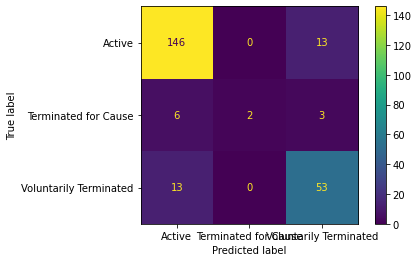

In [79]:

plt.close()
# fig = plt.figure(figsize = (10,10))
plot_confusion_matrix(clf1, train_X, train_y)
plt.show()

In [80]:
print(classification_report(train_y,clf1.predict(train_X)))

                        precision    recall  f1-score   support

                Active       0.88      0.92      0.90       159
  Terminated for Cause       1.00      0.18      0.31        11
Voluntarily Terminated       0.77      0.80      0.79        66

              accuracy                           0.85       236
             macro avg       0.88      0.63      0.66       236
          weighted avg       0.86      0.85      0.84       236



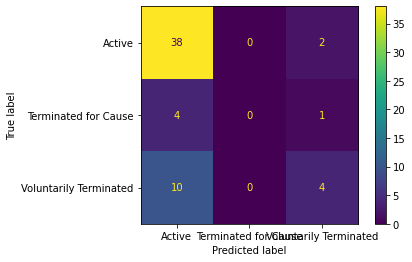

In [81]:
plot_confusion_matrix(clf1, test_X, test_y)

In [82]:
print(classification_report(test_y,clf1.predict(test_X)))

                        precision    recall  f1-score   support

                Active       0.73      0.95      0.83        40
  Terminated for Cause       0.00      0.00      0.00         5
Voluntarily Terminated       0.57      0.29      0.38        14

              accuracy                           0.71        59
             macro avg       0.43      0.41      0.40        59
          weighted avg       0.63      0.71      0.65        59



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
clf1.predict_proba(test)

array([[0.89767073, 0.04339996, 0.05892931],
       [0.70490393, 0.1752243 , 0.11987177],
       [0.58790895, 0.04533828, 0.36675277],
       [0.39741216, 0.04918887, 0.55339897],
       [0.2162161 , 0.01420675, 0.76957714],
       [0.60166385, 0.04024372, 0.35809243],
       [0.89436009, 0.03891105, 0.06672887],
       [0.94051119, 0.01993308, 0.03955573],
       [0.93118758, 0.02599231, 0.04282011],
       [0.30603803, 0.09469513, 0.59926684],
       [0.75495314, 0.06820181, 0.17684506],
       [0.87612792, 0.0516895 , 0.07218258],
       [0.90563277, 0.01617551, 0.07819172]])

In [84]:
a = pd.DataFrame(clf1.predict_proba(test), columns = ['Active', 'Terminated for Cause', 'Voluntarily Terminated']) 

In [86]:
a['name'] = data.iloc[:-14:-1, 0].sort_index().values

In [87]:
a = a[['name', 'Active', 'Terminated for Cause', 'Voluntarily Terminated']]

In [88]:
a

name    Active  Terminated for Cause  \
0           Walle, Robot  0.897671              0.043400   
1         Warwith, Salsa  0.704904              0.175224   
2            Whats, Sapp  0.587909              0.045338   
3         Wilbor, Bilbor  0.397412              0.049189   
4    Wilkensin, Annabele  0.216216              0.014207   
5   Williams, Samantha    0.601664              0.040244   
6      Winnie,  The pooh  0.894360              0.038911   
7           Wolf, Bigman  0.940511              0.019933   
8      Woodpecker, Woody  0.931188              0.025992   
9       Yemini, Kathleen  0.306038              0.094695   
10        Zamchi, Banchi  0.754953              0.068202   
11    Zinna, The warrier  0.876128              0.051689   
12      Zimmerman, Clara  0.905633              0.016176   

    Voluntarily Terminated  
0                 0.058929  
1                 0.119872  
2                 0.366753  
3                 0.553399  
4                 0.769577  
5                 0.358092  
6                 0.066729  
7                 0.039556  
8                 0.042820  
9                 0.599267  
10                0.176845  
11                0.072183  
12                0.078192